In [1]:
import scipy         
import datetime
from scipy.linalg import expm
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit


In [2]:
L = 4 #system size
M = 0.1 #fermion mass
N=10 #number of layers
l=1 #spin length
m_epsilon = 0
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [3]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
      0.         |2 2 2 2>           80  
      1.         |2 2 2 1>           79  
      2.         |2 2 2 0>           78  
      3.         |2 2 1 2>           77  
      4.         |2 2 1 1>           76  
      5.         |2 2 1 0>           75  
      6.         |2 2 0 2>           74  
      7.         |2 2 0 1>           73  
      8.         |2 2 0 0>           72  
      9.         |2 1 2 2>           71  
     10.         |2 1 2 1>           70  
     11.         |2 1 2 0>           69  
     12.         |2 1 1 2>           68  
     13.         |2 1 1 1>           67  
     14.         |2 1 1 0>           66  
     15.         |2 1 0 2>           65  
     16.         |2 1 0 1>           64  
     17.         |2 1 0 0>           63  
     18.         |2 0 2 2>           62  
     19.         |2 0 2 1>           61  
     20.         |2 0 2 0>           60  
     21.         |2 0 1 2>           59  
     22

In [4]:
#initialisation of the Gauss laws
LL = 3 #number of sites-1
liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []


for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    
    
gauss_law_map.append([
    ["z",liste[0]],
    ["z",liste[3]],
])

gauss_law_map.append([
    ["z",liste[1]],
    ["z",liste_m[0]],
    ["I",liste[1]],
])

gauss_law_map.append([
    ["z",liste_m[2]],
    ["z",liste_m[1]],
])

gauss_law_map.append([
    ["z",liste_m[3]],
    ["z",liste[2]],
    ["I",liste[3]],
])

for i in range(LL+1):
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(LL+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [5]:
B = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(4*l+1)
b[2*l+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(4*3+1)
for i in range(4*l+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 0. 0. 1. 0.]


In [6]:
C = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(4*l+1)
c[2*l] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(4*3+1)
for i in range(4*l+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [7]:
#projectors on g=1 for every site
Proj = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(LL+1)]
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [8]:
A = np.zeros((2*l+1,2*l+1))
for i in range(2*l+1):
    for j in range(2*l+1):
        A[i][j] = (-l+i)**j
a = np.zeros(2*l+1)
for i in range(2*l+1):
    a[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,a)
x = np.zeros(2*3+1)
for i in range(2*l+1):
    x[i] = solution[i]
print(x)

[ 1.  0. -2.  0.  0.  0.  0.]


In [9]:
D = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        D[i][j] = (-2*l+i)**j
d = np.zeros(4*l+1)
d[2*l] = 1.
solution = scipy.linalg.solve(D,d)
dd = np.zeros(4*3+1)
for i in range(4*l+1):
    dd[i] = solution[i]
print(dd)
print(d)

[ 1.    0.   -1.25 -0.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [10]:
E = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        E[i][j] = (-2*l+i+1)**j
e = np.zeros(4*l+1)
e[2*l-1] = 1.
solution = scipy.linalg.solve(E,e)
ee = np.zeros(4*3+1)
for i in range(4*l+1):
    ee[i] = solution[i]
print(ee)
print(e)

[ 1.         -0.83333333 -0.83333333  0.83333333 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 1. 0. 0. 0.]


In [11]:
#projectors on g=0 for every site
Proj_0 = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(LL+1)]
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj_0[2*i] += dd[j]*gauss_law_matrix[2*i]**j
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj_0[2*i+1] += ee[j]*gauss_law_matrix[2*i+1]**j

In [12]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []
quartic_term = []
quintic_term = []
sextic_term = []

interaction_p = []
interaction_m = []

phase = []
phase_ham = []

link_p = []
link_p_ham = []

link_m = []
link_m_ham = []

for i in range(L):
    const_term.append([[x[0],i]])
    linear_term.append([[x[1],i]])
    quadratic_term.append([[x[2],i,i]])
    cubic_term.append([[x[3],i,i,i]])
    quartic_term.append([[x[4],i,i,i,i]])
    quintic_term.append([[x[5],i,i,i,i,i]])
    sextic_term.append([[x[6],i,i,i,i,i,i]])


    phase.append([
        ["I", const_term[i]],
        ["z", linear_term[i]],
        ["zz", quadratic_term[i]],
        ["zzz", cubic_term[i]],
        ["zzzz", quartic_term[i]],
        ["zzzzz", quintic_term[i]],
        ["zzzzzz", sextic_term[i]],

    ])
    
    link_p.append([
    ["+",[[1./np.sqrt(l*(l+1)),i]]]  
    ])      
    
    link_m.append([
    ["-",[[1./np.sqrt(l*(l+1)),i]]]           
        
    ])
    
    phase_ham.append(hamiltonian(phase[i],dynamic_list=[],basis=basis,**no_checks))
    link_p_ham.append(hamiltonian(link_p[i],dynamic_list=[],basis=basis,**no_checks))
    link_m_ham.append(hamiltonian(link_m[i],dynamic_list=[],basis=basis,**no_checks))


    


kin_energy = [[0.5,i,i] for i in range(L)]

mass_term = []
mass_term.append([2*(-1)**0*M,0])
mass_term.append([2*(-1)**1*M,1])
mass_term.append([2*(-1)**1*M,2])
mass_term.append([2*(-1)**0*M,3])


kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

interaction = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(L)]

interaction[0] = -0.5*(Proj[0]@phase_ham[0].tocsc()@link_p_ham[0].tocsc()@Proj[1]+Proj[1]@link_m_ham[0].tocsc()@phase_ham[0].tocsc()@Proj[0])
interaction[1] = 0.5*(Proj[1]@phase_ham[1].tocsc()@link_p_ham[1].tocsc()@Proj[2]+Proj[2]@link_m_ham[1].tocsc()@phase_ham[1].tocsc()@Proj[1])
interaction[2] = 0.5*(Proj[3]@phase_ham[1].tocsc()@phase_ham[2].tocsc()@link_p_ham[2].tocsc()@Proj[2]+Proj[2]@link_m_ham[2].tocsc()@phase_ham[2].tocsc()@phase_ham[1].tocsc()@Proj[3])
interaction[3] = -0.5*(Proj[0]@phase_ham[0].tocsc()@phase_ham[3].tocsc()@link_p_ham[3].tocsc()@Proj[3]+Proj[3]@link_m_ham[3].tocsc()@phase_ham[3].tocsc()@phase_ham[0].tocsc()@Proj[0])

plaquette = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(2)]

plaquette[0] = 0.5*(Proj_0[3]@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@link_p_ham[0].tocsc()@link_p_ham[1].tocsc()@link_m_ham[2].tocsc()@link_m_ham[3].tocsc()@Proj_0[3]+Proj_0[3]@link_p_ham[2].tocsc()@link_p_ham[3].tocsc()@link_m_ham[0].tocsc()@link_m_ham[1].tocsc()@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@Proj_0[3])

plaquette[1] = -0.5*(Proj[3]@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@link_p_ham[0].tocsc()@link_p_ham[1].tocsc()@link_m_ham[2].tocsc()@link_m_ham[3].tocsc()@Proj[3]+Proj[3]@link_p_ham[2].tocsc()@link_p_ham[3].tocsc()@link_m_ham[0].tocsc()@link_m_ham[1].tocsc()@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@Proj[3])

h_plaq = 0

for i in range(2):
    h_plaq += plaquette[i]

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_plaq + h_int #Spin-1 Hamiltonian without the local contstaints

#for i in range(LL+1):
#    full_ham_matrix = (Proj_0[i]+Proj[i])@full_ham_matrix@(Proj_0[i]+Proj[i])

G=0
for i in range(LL+1):
    G += 0.1*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= full_ham_matrix + constraint_full_matrix #Spin-1 Hamiltonian with the local contstaints as a penalty term


In [13]:
print(np.allclose(full_ham_matrix.toarray(), full_ham_matrix.toarray().T.conj(), rtol=1e-8, atol=1e-8))

True


In [14]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(full_ham_matrix,k = 3,which = "SA")
string = ""
print(eigenval[eigenval<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvec[:,0][i])>=1e-5:
        string+=str(eigenvec[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"

[-0.92917693 -0.31306811 -0.1043844 ]


In [15]:
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")


In [16]:
#Gauge invariant part of the spectrum
string = ""
print(eigenvalues[eigenvalues<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])>=1e-4:
        string+=str(eigenvectors[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)


[-0.92917693 -0.31306811  0.49289322]
(0.06853882018293751+0.008227527944967184j)|2 2 0 1>
(-0.15487815250169742-0.01859186260241223j)|2 2 0 0>
(0.2804117615955391+0.033661151424359236j)|2 1 1 1>
(-0.07488854407553901-0.00898976065673218j)|2 1 0 1>
(-0.06853882018293746-0.0082275279449672j)|2 1 0 0>
(0.2804117615955392+0.03366115142435911j)|1 1 1 2>
(-0.7702533829695715-0.09246265424722531j)|1 1 1 1>
(0.28041176159553916+0.03366115142435924j)|1 1 0 1>
(-0.06853882018293753-0.008227527944967233j)|1 0 2 2>
(-0.07488854407553906-0.008989760656732085j)|1 0 1 2>
(0.28041176159553893+0.033661151424359166j)|1 0 1 1>
(-0.15487815250169745-0.0185918626024122j)|0 0 2 2>
(0.06853882018293753+0.00822752794496725j)|0 0 1 2>



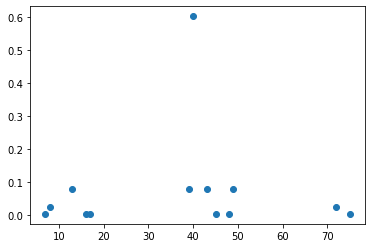

In [17]:
yy = []
xx = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])**2>=1e-4:
        yy.append(np.abs(eigenvectors[:,0][i])**2) 
        xx.append(i)
plt.plot(xx,yy, "o")

In [18]:
def rot_sigma(k,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
        
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-0][2*l-1] = 0.5
    sigma[2*l-1][2*l-0] = 0.5
    sigma = sparse.csc_matrix(sigma)
    
    sigma_1 = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_1[2*l-1][2*l-2] = 0.5
    sigma_1[2*l-2][2*l-1] = 0.5
    sigma_1 = sparse.csc_matrix(sigma_1)
    
    rot_matrix = expm(-1j*theta*(sigma+sigma_1))
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod

def rot_sigma_z(k,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-0][2*l-0] = -1.
    sigma[2*l-2][2*l-2] = 1.
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod

def rot_sigma_z2(k,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-0][2*l-0] = 1.
    sigma[2*l-2][2*l-2] = 1.
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


In [19]:



def ms_hamiltonian(i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    sigma_big = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(2*l+1)
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        sigma_big[k] = tensprod
    for k in range(L):
        for kk in range(k,L):
            summe += 1./(2-(k+kk)%2)**2*(sigma_big[k]+sigma_big[kk])@(sigma_big[k]+sigma_big[kk])
    return summe
                
matrix_part = ms_hamiltonian(1,2,0)
ms_ham_eigenval, ms_ham_eigenvec = scipy.linalg.eigh(matrix_part)



def ms_gate_global(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec@exponential@ms_ham_eigenvec.T.conj()


In [20]:
#initial state
string_0 = "1111"
#for i in range(L):
#    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string_0)

psi_0[i_0] = 1.


In [21]:
import optuna
n_iter = 5000
theta = np.zeros(5*N)

#cost function definition
def cost_function_sigma(trial):
    psi_var = psi_0
    for i in range(N):
        for j in range(5):
            theta[5*i+j] = trial.suggest_float("5*"+str(i)+"+"+str(j), -2*np.pi, 2*np.pi)

        
            
    for i in range(N):
        psi_var = ms_gate_global(theta[5*i+0])@psi_var
        psi_var = rot_sigma_z(0,theta[5*i+2])@rot_sigma(0,theta[5*i+1])@psi_var
        psi_var = rot_sigma_z(3,theta[5*i+2])@rot_sigma(3,theta[5*i+1])@psi_var
        psi_var = rot_sigma_z(1,theta[5*i+3])@rot_sigma(1,theta[5*i+4])@psi_var
        psi_var = rot_sigma_z(2,theta[5*i+3])@rot_sigma(2,theta[5*i+4])@psi_var

    cost = np.conj(psi_var)@constrained_full_ham_matrix@psi_var
    return np.real(cost)

sampler = optuna.samplers.CmaEsSampler()
study = optuna.create_study(sampler=sampler)
study.optimize(cost_function_sigma, n_trials=n_iter)

[I 2022-05-12 10:51:26,192] A new study created in memory with name: no-name-1334982d-6c1c-45dc-afd1-328ec61a29e5
/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:51:26,708] Trial 0 finished with value: 3.797449945239113 and parameters: {'5*0+0': 4.934598387872514, '5*0+1': -4.361978073074921, '5*0+2': 2.64233689850729, '5*0+3': 0.9060351625857646, '5*0+4': 1.8085892737609335, '5*1+0': 2.1037851441810194, '5*1+1': 5.922724739784078, '5*1+2': -3.662712146346766, '5*1+3': -0.219555386727035, '5*1+4': 3.6510970853635385, '5*2+0': -1.0325488013344657, '5*2+1': 2.129162406880761, '5*2+2': -2.1973808112975046, '5*2+3': 1.9081194016960072, '5*2+4': -2.727304247810393, '5*3+0': 1.4256774333094455, '5*3+1': 3.3615736586290073, '5*3+2': -6.064347570983307, '5*3+3': 4.888653688485945, '5*3+4': 5.

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:51:28,822] Trial 5 finished with value: 3.7581284216732973 and parameters: {'5*0+0': -1.5941265454952, '5*0+1': 0.7307623160296611, '5*0+2': -2.0967863539847484, '5*0+3': 0.9485773142454076, '5*0+4': 0.09540550595439526, '5*1+0': 0.9757858700352045, '5*1+1': 2.7190047635555823, '5*1+2': -0.6719744080713584, '5*1+3': 1.1592918266923589, '5*1+4': 4.750178975813471, '5*2+0': 0.6520376770573947, '5*2+1': -2.859851912075226, '5*2+2': 2.9995607101314596, '5*2+3': 3.187017497667301, '5*2+4': 1.6349843506645936, '5*3+0': -1.4105177987421091, '5*3+1': 0.9610008220647143, '5*3+2': 2.1583435344795068, '5*3+3': -0.2248403809268021, '5*3+4': -0.39878873674450827, '5*4+0': 1.6057881706596417, '5*4+1': 0.49476800884742606, '5*4+2': -0.4924147480593213,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:51:31,436] Trial 10 finished with value: 3.833133375079223 and parameters: {'5*0+0': 0.5992281397623328, '5*0+1': -0.7832673323346719, '5*0+2': -0.6352378406649726, '5*0+3': -0.2810572097920987, '5*0+4': -1.6579268079360974, '5*1+0': -1.9967470717669729, '5*1+1': 3.2306130187983353, '5*1+2': -1.3115574395525902, '5*1+3': 2.000100721743812, '5*1+4': -0.46264631934121225, '5*2+0': -2.32655816504168, '5*2+1': -3.091008584866952, '5*2+2': -0.19121771453584718, '5*2+3': 0.2703252042424719, '5*2+4': 1.702726893118719, '5*3+0': 2.5097418700200893, '5*3+1': 2.945844542215657, '5*3+2': 0.8937691027626435, '5*3+3': -1.9764614323820113, '5*3+4': 0.5698293418682334, '5*4+0': 1.0484304955455774, '5*4+1': -0.9566270344953529, '5*4+2': -0.8735436061610

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:51:33,932] Trial 15 finished with value: 3.7006640021907926 and parameters: {'5*0+0': 0.17017784915292392, '5*0+1': -1.1511943539447524, '5*0+2': 0.6805071299593729, '5*0+3': -1.344952313140313, '5*0+4': 0.003146054646443596, '5*1+0': 1.8835273425027015, '5*1+1': 2.737148917715199, '5*1+2': 1.6884699828376073, '5*1+3': 1.976959716112246, '5*1+4': -0.4031415664459173, '5*2+0': 0.8814584657130417, '5*2+1': -4.098895369867221, '5*2+2': -2.3628736148638434, '5*2+3': 0.8005150605765494, '5*2+4': 0.46037639814331927, '5*3+0': 1.400680832569557, '5*3+1': 2.2278012057073937, '5*3+2': 0.9307941934482661, '5*3+3': -2.1602930347006737, '5*3+4': 1.3407231713834327, '5*4+0': -1.2557653780179967, '5*4+1': -0.27890611025320483, '5*4+2': 0.3860401992123

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:51:36,651] Trial 20 finished with value: 3.0200411091839 and parameters: {'5*0+0': -0.03349310428886687, '5*0+1': -1.1430986941339492, '5*0+2': 1.2109203713261298, '5*0+3': 1.4493700115632913, '5*0+4': -2.7476703312106765, '5*1+0': 0.8380122786793633, '5*1+1': 2.135434058129709, '5*1+2': -4.824382483566538, '5*1+3': 2.863975117564128, '5*1+4': -1.1947573647348388, '5*2+0': -0.9044999547984639, '5*2+1': -0.45047252977366686, '5*2+2': 1.4707397508126807, '5*2+3': 2.9206921363914295, '5*2+4': -2.066861218809179, '5*3+0': -3.8729308274323735, '5*3+1': -1.5147694319589005, '5*3+2': 2.9880128544107993, '5*3+3': -0.9613180444200409, '5*3+4': -0.9855953638943823, '5*4+0': -1.0133706141012415, '5*4+1': 1.3941213081406125, '5*4+2': 0.3262653482233

[I 2022-05-12 10:51:39,003] Trial 25 finished with value: 4.892213852268126 and parameters: {'5*0+0': -2.0526921845136172, '5*0+1': -0.20758347533520727, '5*0+2': -1.2310250098953652, '5*0+3': -0.5490400013032313, '5*0+4': -3.4481738350142264, '5*1+0': -0.9867981595549948, '5*1+1': -0.6245137369802075, '5*1+2': 2.4368877295022715, '5*1+3': 2.2552721927444574, '5*1+4': 0.25624362716970006, '5*2+0': 1.0126490594209843, '5*2+1': 1.429591280151647, '5*2+2': 3.1950676678312364, '5*2+3': -0.5939301480156405, '5*2+4': -1.3675902415774033, '5*3+0': -3.7294049106107776, '5*3+1': 0.6805386088048753, '5*3+2': -1.3328450993921606, '5*3+3': -3.9597329734304507, '5*3+4': 3.6804291457041987, '5*4+0': -0.766697806684749, '5*4+1': -2.192164342095311, '5*4+2': -1.0148240242965865, '5*4+3': -1.2376125236478983, '5*4+4': -0.02301641340350602, '5*5+0': -2.1820498524059797, '5*5+1': -4.052910280471294, '5*5+2': 1.195796426864587, '5*5+3': 1.430057308094814, '5*5+4': 0.29566553678456664, '5*6+0': -2.85879163

[I 2022-05-12 10:51:41,359] Trial 30 finished with value: 3.012031016137604 and parameters: {'5*0+0': 2.2915149668199835, '5*0+1': -2.5095843893524252, '5*0+2': 1.6904582523990501, '5*0+3': -0.34118203550352133, '5*0+4': -0.9706339432434579, '5*1+0': 0.7345263747389269, '5*1+1': 0.7722340980447411, '5*1+2': 3.225195654835658, '5*1+3': 2.3271763297273242, '5*1+4': 0.7621959066063894, '5*2+0': 0.9985309494186388, '5*2+1': 1.3544734645235759, '5*2+2': -1.2003652380357859, '5*2+3': -1.1181346649008206, '5*2+4': 2.45211346608361, '5*3+0': 4.712251802303564, '5*3+1': -0.5120413516458037, '5*3+2': 2.762285067217537, '5*3+3': -2.686553573144213, '5*3+4': -0.5827260169085828, '5*4+0': -1.3935860706460441, '5*4+1': 0.10716373476761176, '5*4+2': -0.539645356948628, '5*4+3': -2.9464184508755604, '5*4+4': -0.8467442381319252, '5*5+0': -0.1687381201476271, '5*5+1': -1.6804986444837693, '5*5+2': -0.19464108052318194, '5*5+3': 0.6808331884807639, '5*5+4': 1.8792494623638247, '5*6+0': -2.08335350159709

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:51:43,937] Trial 35 finished with value: 3.9029307192724603 and parameters: {'5*0+0': 2.5601158274256166, '5*0+1': -4.327803363943045, '5*0+2': 0.13872924203957782, '5*0+3': 2.267618036419657, '5*0+4': -0.2049052433955063, '5*1+0': 0.12488271519915545, '5*1+1': -1.4581512729806712, '5*1+2': -2.374620801591836, '5*1+3': -3.036526300019651, '5*1+4': -3.949547451182873, '5*2+0': 1.8992766078381274, '5*2+1': -0.6170094145558156, '5*2+2': -0.15535243856736658, '5*2+3': 1.054647491837959, '5*2+4': 1.7170208936334062, '5*3+0': 2.7436978040934745, '5*3+1': -0.42844448907937815, '5*3+2': -0.6055483261165107, '5*3+3': -2.5824431953396143, '5*3+4': -0.5546954342310454, '5*4+0': -4.021991655031215, '5*4+1': 5.629795406252391, '5*4+2': -1.98557332204

[I 2022-05-12 10:51:46,326] Trial 40 finished with value: 3.6554580557533987 and parameters: {'5*0+0': -1.7304161339134718, '5*0+1': -1.8988131938148358, '5*0+2': 2.4094722278855, '5*0+3': -1.0838403885860637, '5*0+4': -1.0542657337295953, '5*1+0': -0.9624477835573445, '5*1+1': 0.5567992076149613, '5*1+2': 1.0514268257399633, '5*1+3': 0.8081089121234355, '5*1+4': -1.422009984398384, '5*2+0': 0.9325601233417633, '5*2+1': 0.04404642576145279, '5*2+2': -0.8053463224302868, '5*2+3': 2.4709868982269607, '5*2+4': 3.169310469082104, '5*3+0': 1.904903278029484, '5*3+1': -2.8966628616595993, '5*3+2': 0.9044171517412776, '5*3+3': 1.647427794265458, '5*3+4': -2.3691254287129064, '5*4+0': 4.0468631071301875, '5*4+1': 0.7907499695755242, '5*4+2': -0.2562239415466252, '5*4+3': -2.079762401536258, '5*4+4': 2.811398258568447, '5*5+0': 1.9414452937485889, '5*5+1': 0.7618978408276207, '5*5+2': -1.2261159944912259, '5*5+3': 3.393144771730347, '5*5+4': 3.3233376036241538, '5*6+0': -2.2468886532717858, '5*

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:51:48,746] Trial 45 finished with value: 4.361980938357039 and parameters: {'5*0+0': 0.23166341383755484, '5*0+1': -4.793586396813094, '5*0+2': -1.1029571829961533, '5*0+3': -1.3794517615884687, '5*0+4': -0.665149933564565, '5*1+0': -2.427443955126331, '5*1+1': 1.1048901984456587, '5*1+2': 0.17420562034878673, '5*1+3': 2.8586590472360514, '5*1+4': -2.9036390900631477, '5*2+0': -0.0072542263383874594, '5*2+1': 4.313689679674869, '5*2+2': 2.5233992103336433, '5*2+3': 1.4063599913501688, '5*2+4': 0.056544081524277034, '5*3+0': 0.61621032799296, '5*3+1': -0.8619013243832634, '5*3+2': 0.8035434089815412, '5*3+3': -3.337445127406615, '5*3+4': -1.944456015714008, '5*4+0': -3.0509407007211307, '5*4+1': 0.20296263736608722, '5*4+2': -3.6009918453

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:51:51,214] Trial 50 finished with value: 3.3385233507447554 and parameters: {'5*0+0': 1.2523132027039912, '5*0+1': -2.5180719636925852, '5*0+2': -0.4073338692992432, '5*0+3': -3.0909801609903456, '5*0+4': -1.8723994395357129, '5*1+0': 3.564527497595521, '5*1+1': 0.08871174983228713, '5*1+2': -2.0560608664755815, '5*1+3': 4.016735077307544, '5*1+4': -1.5830353690467192, '5*2+0': -1.289139872871401, '5*2+1': 2.120045806506229, '5*2+2': -3.2362189196471083, '5*2+3': 3.27491693675062, '5*2+4': 0.2666684586215349, '5*3+0': -4.37743844045084, '5*3+1': -3.1355370313816517, '5*3+2': 0.6062498958374426, '5*3+3': 2.0415081433295192, '5*3+4': -0.8407654628819772, '5*4+0': -1.5177214320576893, '5*4+1': -4.805056526859624, '5*4+2': 1.1494928298977598

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:51:53,685] Trial 55 finished with value: 3.0484549101414418 and parameters: {'5*0+0': -0.9120374984207398, '5*0+1': -2.713913774595901, '5*0+2': 1.4892428760007195, '5*0+3': -1.236997972720399, '5*0+4': -2.1068398979716845, '5*1+0': -1.1103968730974962, '5*1+1': -3.719012793847573, '5*1+2': 1.7909096571901757, '5*1+3': 2.0163033003989406, '5*1+4': 0.2961565023835308, '5*2+0': -3.368312948053007, '5*2+1': 2.3494506113126006, '5*2+2': -2.6562025304691366, '5*2+3': 2.4744910796532853, '5*2+4': -0.631932968566195, '5*3+0': -2.514904835729175, '5*3+1': -2.1867616650318955, '5*3+2': 3.0634553191848757, '5*3+3': 0.4072717848044906, '5*3+4': -0.9869072087245383, '5*4+0': 0.07790895642219575, '5*4+1': 1.4061589241729622, '5*4+2': 2.53053705964222

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:51:56,091] Trial 60 finished with value: 3.671678883916014 and parameters: {'5*0+0': -1.6860092178160526, '5*0+1': -2.0124445690851775, '5*0+2': 0.47655608280305817, '5*0+3': -1.3881148175186302, '5*0+4': -2.217767665353605, '5*1+0': 2.129626389087728, '5*1+1': -4.689232655018987, '5*1+2': -1.2630964128406488, '5*1+3': -0.6162884620007413, '5*1+4': 0.23615173426988748, '5*2+0': -0.8603675562677344, '5*2+1': 1.6371862294765411, '5*2+2': -2.0872789168230925, '5*2+3': 0.06782580070947652, '5*2+4': 2.457458283906634, '5*3+0': -0.5540377400834059, '5*3+1': -0.60339100930359, '5*3+2': -0.04728339713277707, '5*3+3': -0.6455094601853609, '5*3+4': 3.448766099500923, '5*4+0': -1.136966681141954, '5*4+1': -0.3805342923055348, '5*4+2': -1.6011181572

[I 2022-05-12 10:51:58,469] Trial 65 finished with value: 3.7839812072571695 and parameters: {'5*0+0': 0.7962327864465397, '5*0+1': -2.8399663363676786, '5*0+2': 0.5191184366287502, '5*0+3': -0.19963365480727646, '5*0+4': -0.1802956192992785, '5*1+0': 0.6553884972820148, '5*1+1': 0.10771128486298759, '5*1+2': 0.04022234312236994, '5*1+3': -1.4642089931442663, '5*1+4': -2.6557834584529196, '5*2+0': -1.819079996439156, '5*2+1': -1.0459777088700992, '5*2+2': -1.7282468775892101, '5*2+3': -2.0488112441306794, '5*2+4': -0.45462229139789245, '5*3+0': -2.399217965413718, '5*3+1': -4.48951373367556, '5*3+2': -0.48379126363569946, '5*3+3': 2.8086570729659672, '5*3+4': 0.5083834670945594, '5*4+0': -2.2252327879098694, '5*4+1': -1.475171811639789, '5*4+2': 1.9236883325175709, '5*4+3': -0.6164498109928398, '5*4+4': -2.073326702921813, '5*5+0': 2.7570225084815414, '5*5+1': -2.7220238799935146, '5*5+2': -0.16918040648296717, '5*5+3': 3.076277909307893, '5*5+4': 0.013897877326283808, '5*6+0': -0.8586

[I 2022-05-12 10:52:00,660] Trial 70 finished with value: 3.805762142857069 and parameters: {'5*0+0': 0.9646723154281474, '5*0+1': -5.537396497537169, '5*0+2': 0.1518989027270905, '5*0+3': -0.2558889137900955, '5*0+4': 0.5909072625132351, '5*1+0': 2.061172112242463, '5*1+1': -1.0287886791255993, '5*1+2': 0.12708742541977658, '5*1+3': 1.0015468764471671, '5*1+4': 1.1969198910754222, '5*2+0': -2.582467097318913, '5*2+1': 1.7257777989058911, '5*2+2': -2.234850315558713, '5*2+3': 0.488655825423964, '5*2+4': -2.160771918940604, '5*3+0': -1.587582178146291, '5*3+1': -2.7531286932938697, '5*3+2': 2.2208084077129104, '5*3+3': 3.9886722789380826, '5*3+4': -1.029597115428942, '5*4+0': -2.5264936383128513, '5*4+1': -4.171867366638422, '5*4+2': -1.1202704749943193, '5*4+3': -2.9478458112790102, '5*4+4': 0.07586502236846582, '5*5+0': 0.026394574473544957, '5*5+1': -0.2089171466890169, '5*5+2': -3.095144161542086, '5*5+3': 2.045451025998028, '5*5+4': -1.0788595601056925, '5*6+0': 4.287957820725561, 

[I 2022-05-12 10:52:03,110] Trial 75 finished with value: 3.6677238005579618 and parameters: {'5*0+0': -2.0461282193001322, '5*0+1': -4.186227892086466, '5*0+2': 2.4699153506334235, '5*0+3': -1.9637340867882127, '5*0+4': -1.3624049757754841, '5*1+0': 0.5282084426278464, '5*1+1': 1.6112814142401626, '5*1+2': 1.6730402669472495, '5*1+3': 1.8878053318273194, '5*1+4': -2.5517621742591405, '5*2+0': -3.337946211118277, '5*2+1': 2.5329292767242713, '5*2+2': 0.9269837760182156, '5*2+3': 0.01666704388819651, '5*2+4': 0.26002935025061436, '5*3+0': -1.1770325766226428, '5*3+1': -2.6839751196249164, '5*3+2': 1.7380668120399818, '5*3+3': 4.247473191648489, '5*3+4': -1.5155608532949223, '5*4+0': 0.23773597128410628, '5*4+1': 0.9636235795987207, '5*4+2': -0.08165795025655265, '5*4+3': 2.3998370895136696, '5*4+4': -1.7268693862181328, '5*5+0': -1.0251304132754375, '5*5+1': 1.1381708824413623, '5*5+2': -1.789316765167922, '5*5+3': 3.619244485045071, '5*5+4': -3.660330594932438, '5*6+0': 0.6612957688795

[I 2022-05-12 10:52:05,925] Trial 80 finished with value: 3.61933760652296 and parameters: {'5*0+0': -2.1513317545098545, '5*0+1': -3.043910367604855, '5*0+2': 2.8573834874538626, '5*0+3': -1.998355107574628, '5*0+4': -1.9296783016542585, '5*1+0': 0.22303102005335584, '5*1+1': -1.5959284705719254, '5*1+2': -2.1876011237620587, '5*1+3': 1.0754054485912787, '5*1+4': 0.3417311536432742, '5*2+0': -0.2574851600560235, '5*2+1': 2.4112916768538972, '5*2+2': -0.16342188795637558, '5*2+3': 3.4848613885136404, '5*2+4': -1.1800307246596917, '5*3+0': 0.25950854911093435, '5*3+1': -2.295409741913204, '5*3+2': 0.1591871167869498, '5*3+3': -0.5524405747499997, '5*3+4': 1.4597035466265997, '5*4+0': -1.0041508554399587, '5*4+1': -0.3669662758382981, '5*4+2': -0.5597378481538098, '5*4+3': -2.194812237121866, '5*4+4': -0.4760056879848489, '5*5+0': 0.11154438900999519, '5*5+1': 0.734098807354732, '5*5+2': -1.3672464004608922, '5*5+3': -0.6637934043625575, '5*5+4': 3.219772734117468, '5*6+0': 0.97140980460

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:52:08,418] Trial 85 finished with value: 3.777911972093089 and parameters: {'5*0+0': 2.809195787581032, '5*0+1': -4.027528019142578, '5*0+2': 0.295410792976595, '5*0+3': -2.6261140890212507, '5*0+4': -1.6233186516876976, '5*1+0': 2.079019301735908, '5*1+1': 0.38636595653146766, '5*1+2': -2.023001075958251, '5*1+3': 1.5200391414551429, '5*1+4': 0.27383422356981496, '5*2+0': -1.2586675394200475, '5*2+1': 1.8459475548089244, '5*2+2': -4.446582923884797, '5*2+3': 2.3171271665407374, '5*2+4': -2.1851318045066166, '5*3+0': 0.3960534235620816, '5*3+1': 1.1893524891539027, '5*3+2': -0.1377113724211309, '5*3+3': -1.4361529218540818, '5*3+4': -0.5601213133067735, '5*4+0': -0.42887988113796327, '5*4+1': -4.318106923643383, '5*4+2': 2.37102107649970

[I 2022-05-12 10:52:11,091] Trial 90 finished with value: 3.5091177870638472 and parameters: {'5*0+0': 1.8629517627939962, '5*0+1': -2.0121238925596066, '5*0+2': 2.3029104435034786, '5*0+3': -2.9157343036799985, '5*0+4': 0.4120616497699102, '5*1+0': -0.6978623678395195, '5*1+1': 0.14200909771603376, '5*1+2': -0.8960702334903317, '5*1+3': 0.5853984386946781, '5*1+4': 3.076943194034109, '5*2+0': -0.374925789383064, '5*2+1': 2.6262739298530917, '5*2+2': -3.96966066246582, '5*2+3': 1.19805720336656, '5*2+4': 1.1237204164252508, '5*3+0': -1.645349012183372, '5*3+1': 1.9163330798682598, '5*3+2': 0.4633606954357805, '5*3+3': -1.4708306951195411, '5*3+4': 1.2766002201832491, '5*4+0': 0.8614460068523062, '5*4+1': -0.5257467043976534, '5*4+2': 2.3419364115374037, '5*4+3': -0.6671031715245981, '5*4+4': -0.7882994150555687, '5*5+0': -1.3248297825208208, '5*5+1': 0.4875307077624059, '5*5+2': -2.5245985196869922, '5*5+3': 2.9166186016906788, '5*5+4': 4.032940568099317, '5*6+0': 2.0714022051600955, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:52:13,565] Trial 95 finished with value: 3.120373839466556 and parameters: {'5*0+0': -0.4120515533741882, '5*0+1': -5.0025121155318475, '5*0+2': 2.511550980178713, '5*0+3': -5.20887085898672, '5*0+4': 0.07138050756551645, '5*1+0': 0.5143410529426358, '5*1+1': -2.0998660622675502, '5*1+2': -0.3429495981229189, '5*1+3': -1.443999914320571, '5*1+4': 0.3116566153551579, '5*2+0': -1.344698770232663, '5*2+1': 2.299902402244033, '5*2+2': -3.603029164692511, '5*2+3': 2.0928945702816852, '5*2+4': 1.0821262286153344, '5*3+0': -2.944798935912355, '5*3+1': -2.0781369938893213, '5*3+2': -0.963358274766298, '5*3+3': -1.289333895738227, '5*3+4': 0.5407363142146806, '5*4+0': -2.019666377217331, '5*4+1': -0.7332105340279624, '5*4+2': -3.4872516649138685,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:52:15,932] Trial 100 finished with value: 4.240202303903891 and parameters: {'5*0+0': 1.264786592375407, '5*0+1': -2.68113760336779, '5*0+2': 4.889447004103358, '5*0+3': -2.430598300303805, '5*0+4': 2.4275045611634116, '5*1+0': -1.6396484077747377, '5*1+1': -2.8649093535370174, '5*1+2': 2.475956055278514, '5*1+3': 0.44112467362014385, '5*1+4': 4.84093319825527, '5*2+0': -3.7583985527246604, '5*2+1': 1.9857273746041533, '5*2+2': -5.314883337442353, '5*2+3': 2.277641634641979, '5*2+4': 2.43780742927314, '5*3+0': -5.181408649354163, '5*3+1': -2.4766905427285417, '5*3+2': 1.8266681488551264, '5*3+3': 0.4471126237014664, '5*3+4': 0.38169630431147383, '5*4+0': -3.824433209391084, '5*4+1': 0.04491533638827616, '5*4+2': -0.6336703713052297, '5*4

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:52:18,421] Trial 105 finished with value: 3.3589372477696715 and parameters: {'5*0+0': 0.28924412891268503, '5*0+1': -2.3898006766159097, '5*0+2': 5.909095388395024, '5*0+3': -0.8708945544308064, '5*0+4': -1.6121309095749687, '5*1+0': 1.497876650621496, '5*1+1': -4.668027540494025, '5*1+2': -3.1106508891100777, '5*1+3': -1.1981799021204864, '5*1+4': 0.13721954353826238, '5*2+0': -3.3975598284989608, '5*2+1': 2.9504134521932324, '5*2+2': -4.118640995085449, '5*2+3': 0.6767419046213574, '5*2+4': -1.0304144307823064, '5*3+0': -5.746825717510321, '5*3+1': -3.420437350912907, '5*3+2': -1.3258306377596305, '5*3+3': -0.41813411373206677, '5*3+4': -0.3578885041704037, '5*4+0': -1.6842406692854204, '5*4+1': -1.3961798912924763, '5*4+2': -1.841294

[I 2022-05-12 10:52:20,574] Trial 110 finished with value: 3.6387125827454665 and parameters: {'5*0+0': 0.9500787068046852, '5*0+1': -3.3659517176496414, '5*0+2': 1.9565860591587292, '5*0+3': -2.920744167652038, '5*0+4': 0.02694489836692715, '5*1+0': 4.355316039197976, '5*1+1': 0.7537112176037395, '5*1+2': 0.6250952939168326, '5*1+3': -0.6727381807668003, '5*1+4': 1.7647461627158352, '5*2+0': -0.3956244102150961, '5*2+1': 4.840100098195976, '5*2+2': -2.3216825757082757, '5*2+3': 1.5381828668605304, '5*2+4': -2.941832681715439, '5*3+0': -1.9138840891597326, '5*3+1': -2.27475492448131, '5*3+2': -1.5587715673908487, '5*3+3': -3.4431376667321, '5*3+4': -2.1336348036599317, '5*4+0': -1.2231045203531046, '5*4+1': -1.5798403751701389, '5*4+2': -1.0864393524050957, '5*4+3': -1.205988485548081, '5*4+4': -1.299304926871709, '5*5+0': -1.9236842417561846, '5*5+1': -0.1443844315995319, '5*5+2': -0.910520168951418, '5*5+3': 1.3988206580228062, '5*5+4': -0.16429056862754043, '5*6+0': 4.24195554142471

[I 2022-05-12 10:52:23,286] Trial 115 finished with value: 3.0884214035359165 and parameters: {'5*0+0': 0.42177415180964795, '5*0+1': -2.2626084736980427, '5*0+2': 3.5997315010044506, '5*0+3': -3.1173142602641635, '5*0+4': -1.2615503791731397, '5*1+0': 1.6902647200967116, '5*1+1': -0.11561066504416484, '5*1+2': -0.5868060073582437, '5*1+3': -2.0314597949877378, '5*1+4': 0.4995282371522699, '5*2+0': 1.4231769825587124, '5*2+1': 3.7327550699764727, '5*2+2': -3.1344492327873823, '5*2+3': 0.15670988578744005, '5*2+4': -0.5648978713510653, '5*3+0': -5.321987242803019, '5*3+1': 1.1172581953810583, '5*3+2': 0.1591652881208439, '5*3+3': 0.5892693258323528, '5*3+4': 0.21134859014222568, '5*4+0': -0.5162800733007793, '5*4+1': -1.863306719444347, '5*4+2': 2.518442431639347, '5*4+3': -2.392939332134163, '5*4+4': -0.8124734277722159, '5*5+0': -1.682809408181039, '5*5+1': 0.7349380177713518, '5*5+2': -0.4418703260989275, '5*5+3': 1.319875027123956, '5*5+4': -0.07018893765616518, '5*6+0': 3.509837612

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:52:25,921] Trial 120 finished with value: 3.2583062314406184 and parameters: {'5*0+0': 1.4003553093111503, '5*0+1': -1.95731744016829, '5*0+2': 2.445699922978019, '5*0+3': -5.016713544658575, '5*0+4': -0.19648953520334067, '5*1+0': 2.166753653017386, '5*1+1': -1.9130025248949865, '5*1+2': 1.9792745351000418, '5*1+3': -0.18754808438210613, '5*1+4': 0.9525743868021171, '5*2+0': -2.514010564186697, '5*2+1': 3.770655854741712, '5*2+2': -3.624648677727772, '5*2+3': 3.2950066706131103, '5*2+4': -1.4183373120364198, '5*3+0': -4.629099494946952, '5*3+1': -0.9517542196760999, '5*3+2': 1.1417720523473185, '5*3+3': -2.2497731241671652, '5*3+4': 1.039782826584801, '5*4+0': -2.7064880711095465, '5*4+1': 0.6764921053715631, '5*4+2': 1.914390630675164,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:52:28,424] Trial 125 finished with value: 3.6933426979143187 and parameters: {'5*0+0': 0.31279758707884303, '5*0+1': -0.8990032874682177, '5*0+2': 4.878335819306049, '5*0+3': -3.2838119916368185, '5*0+4': 0.8953147774651611, '5*1+0': 3.3821771951846507, '5*1+1': -3.3453955574719907, '5*1+2': -0.1412188516044326, '5*1+3': 0.47465748272279273, '5*1+4': 3.729312982506605, '5*2+0': -2.70385148413303, '5*2+1': 4.868583829262088, '5*2+2': -1.4906881626588406, '5*2+3': 0.6654562903764429, '5*2+4': 2.015975822826694, '5*3+0': -3.967017408879605, '5*3+1': -0.9220802597098151, '5*3+2': 0.37429957143530457, '5*3+3': -1.8548365920419931, '5*3+4': 1.771781421742718, '5*4+0': -3.3296705439813943, '5*4+1': 1.4177945122034115, '5*4+2': -0.06089655907253

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:52:30,799] Trial 130 finished with value: 2.7299750320207856 and parameters: {'5*0+0': 0.6390190794760047, '5*0+1': -4.818203777062246, '5*0+2': 2.552335905470211, '5*0+3': -3.6175671398443097, '5*0+4': 0.7461260578224443, '5*1+0': 1.4437082718008818, '5*1+1': -1.863091809712106, '5*1+2': 1.2806326599908266, '5*1+3': -2.4053088049853137, '5*1+4': 2.5784500256914176, '5*2+0': -1.1110839482851227, '5*2+1': 2.535790495737667, '5*2+2': -4.945106937179958, '5*2+3': 0.04004840198973958, '5*2+4': 0.8846394700109284, '5*3+0': -4.061989539430749, '5*3+1': -1.74920723617904, '5*3+2': 1.0025796970932417, '5*3+3': 0.5307246216208563, '5*3+4': -0.05516758432095864, '5*4+0': -1.9554536969437346, '5*4+1': -1.1609654722233878, '5*4+2': -0.45939281352828

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:52:33,544] Trial 135 finished with value: 4.221486290613258 and parameters: {'5*0+0': -2.088160005311952, '5*0+1': -2.5273916964245187, '5*0+2': 3.8839164245475097, '5*0+3': -5.0602587357304225, '5*0+4': 2.094150622708413, '5*1+0': 1.060135226096244, '5*1+1': -1.4791597886142365, '5*1+2': 0.7867923131163345, '5*1+3': -2.9842475592840754, '5*1+4': 2.0919797929847848, '5*2+0': -3.098795459976432, '5*2+1': 3.3019472586384944, '5*2+2': -2.397744578855299, '5*2+3': 2.4607788787981466, '5*2+4': -3.1021955992546664, '5*3+0': -3.2328836069885156, '5*3+1': -1.9787609678519331, '5*3+2': -1.293370070941759, '5*3+3': -2.807235228265548, '5*3+4': -2.2911320312716503, '5*4+0': -1.5437188863490945, '5*4+1': 1.9275513047614714, '5*4+2': -0.2075067352195

[I 2022-05-12 10:52:36,166] Trial 140 finished with value: 3.7436821997908103 and parameters: {'5*0+0': 2.1908505410233996, '5*0+1': -4.283135792042558, '5*0+2': 2.9454889192834406, '5*0+3': -3.910875313125011, '5*0+4': 2.6378875557482457, '5*1+0': 2.86285915612921, '5*1+1': -3.095506109912477, '5*1+2': -2.202766290979009, '5*1+3': -3.002925133163563, '5*1+4': 2.1363821162198806, '5*2+0': -1.902016060989784, '5*2+1': 2.400770633246573, '5*2+2': -2.811050893993338, '5*2+3': 1.1886905607514722, '5*2+4': 0.01090896952472794, '5*3+0': -3.447660027908266, '5*3+1': -1.2058433694408026, '5*3+2': 3.6515408807239895, '5*3+3': -0.40757222739380944, '5*3+4': -1.4118486328535382, '5*4+0': -2.5750623542132227, '5*4+1': -0.3668672531760353, '5*4+2': 1.278961269473166, '5*4+3': -2.6042354180533174, '5*4+4': -0.7049129210343795, '5*5+0': -2.846128917175961, '5*5+1': -2.2470604674964036, '5*5+2': -1.7539259444037678, '5*5+3': 1.4939283477475154, '5*5+4': 1.3533507047776343, '5*6+0': 3.47547016028812, '

[I 2022-05-12 10:52:38,541] Trial 145 finished with value: 3.6721194782933217 and parameters: {'5*0+0': 0.6469477293242869, '5*0+1': -4.081427126544692, '5*0+2': 3.350946510338544, '5*0+3': -2.731959471106485, '5*0+4': 2.300939561439926, '5*1+0': -0.4685852486240645, '5*1+1': 1.447311132521857, '5*1+2': 0.4206586040271868, '5*1+3': -1.877967818750622, '5*1+4': 0.6808345856485336, '5*2+0': 0.5737732300332344, '5*2+1': 2.130509588469888, '5*2+2': -3.3091786201298876, '5*2+3': 0.25377563767814215, '5*2+4': 0.645590929277868, '5*3+0': -4.591631894452471, '5*3+1': -1.4711220861422152, '5*3+2': 1.724356124971981, '5*3+3': 2.177858367938467, '5*3+4': -3.069338762405243, '5*4+0': -4.070735028981499, '5*4+1': 2.8312979884593155, '5*4+2': -0.6115661170861417, '5*4+3': -1.207119977902331, '5*4+4': -0.8666113467881572, '5*5+0': -4.996873300232593, '5*5+1': 0.8867786897229089, '5*5+2': -0.2580197954907036, '5*5+3': 1.8614132798985472, '5*5+4': 0.6703071958649276, '5*6+0': 2.921455353344211, '5*6+1'

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:52:40,767] Trial 150 finished with value: 4.230859427763283 and parameters: {'5*0+0': 0.6070575301047286, '5*0+1': -2.8595522658473516, '5*0+2': 4.914457406296988, '5*0+3': -1.1523056401300062, '5*0+4': 0.8148505552679363, '5*1+0': -0.5892794305787694, '5*1+1': -0.2629629332093013, '5*1+2': -1.2775173209055382, '5*1+3': -1.6178138123891155, '5*1+4': 1.3775861327344552, '5*2+0': -0.5380801765592813, '5*2+1': 1.669684136312542, '5*2+2': -4.958677410743273, '5*2+3': -1.0954195300835323, '5*2+4': 0.03266914440083354, '5*3+0': -4.637359934856536, '5*3+1': -1.3240297403087131, '5*3+2': -1.0432748091654556, '5*3+3': 0.4041079426366586, '5*3+4': -0.7353333974816301, '5*4+0': -1.1788978782875674, '5*4+1': -1.4902102448164298, '5*4+2': -1.72945804

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:52:43,057] Trial 155 finished with value: 3.3801995146292843 and parameters: {'5*0+0': 0.3019023984132214, '5*0+1': -1.9877716669959753, '5*0+2': 3.4429275015591934, '5*0+3': -4.362522591247103, '5*0+4': -0.6595226177716758, '5*1+0': 2.5004133634801073, '5*1+1': -1.5472161798398647, '5*1+2': -0.008591750998333092, '5*1+3': -1.6522792030627407, '5*1+4': 2.9556600943676985, '5*2+0': -0.98958071457745, '5*2+1': 1.96799077718743, '5*2+2': -2.9341091257683694, '5*2+3': 1.18432358491564, '5*2+4': 0.07573204713163051, '5*3+0': -3.3024209836525356, '5*3+1': -0.5703998267889553, '5*3+2': -0.4579528355530908, '5*3+3': 2.2936213717008176, '5*3+4': -0.5857884547443621, '5*4+0': -0.9148424724701463, '5*4+1': 0.12264157332241976, '5*4+2': 1.2680027897

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:52:45,451] Trial 160 finished with value: 3.2050270353719585 and parameters: {'5*0+0': 1.8519632310291434, '5*0+1': -3.8011775345302548, '5*0+2': 1.2467062431006573, '5*0+3': -4.327049724195259, '5*0+4': 0.21214940338697108, '5*1+0': 1.4388183932111707, '5*1+1': -3.1467970420993616, '5*1+2': -0.19267700583546477, '5*1+3': -1.5846348348870136, '5*1+4': -1.517210407192631, '5*2+0': -2.2640028760412085, '5*2+1': 1.004551307246314, '5*2+2': -2.716834114727102, '5*2+3': 0.04591576881387874, '5*2+4': 2.5101617024088245, '5*3+0': -2.154626781139109, '5*3+1': -3.067219770765738, '5*3+2': 0.9307667003456848, '5*3+3': -0.5307426489140816, '5*3+4': -1.8896420872372701, '5*4+0': -5.093927629699672, '5*4+1': -2.9439329662143283, '5*4+2': 1.0965159499

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:52:47,970] Trial 165 finished with value: 3.357423246562929 and parameters: {'5*0+0': -0.1661735950050418, '5*0+1': -3.532424928560358, '5*0+2': 2.085823339023606, '5*0+3': -4.337324401233202, '5*0+4': 1.458054985001302, '5*1+0': 1.5006689067184382, '5*1+1': -1.988483974836749, '5*1+2': -1.8777193039567452, '5*1+3': -1.4151551877130029, '5*1+4': -1.612910479243947, '5*2+0': -0.5816114839044244, '5*2+1': 0.9050880516210493, '5*2+2': -2.597907186868852, '5*2+3': 3.343585005166829, '5*2+4': -0.31115385357334646, '5*3+0': -4.439152741306682, '5*3+1': -2.63302037836661, '5*3+2': 0.19616680027479627, '5*3+3': -2.7184245268951432, '5*3+4': 0.9377462557957433, '5*4+0': -3.321386439456941, '5*4+1': 2.455302043221521, '5*4+2': 0.19266754829376603,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:52:49,975] Trial 170 finished with value: 4.605033854662637 and parameters: {'5*0+0': 0.9769516615409899, '5*0+1': 0.0603607626545255, '5*0+2': 2.5613076632215197, '5*0+3': -3.6694328711722615, '5*0+4': -0.2912745830620005, '5*1+0': 3.2369226386104977, '5*1+1': -0.8385522379672317, '5*1+2': 1.7181695682037605, '5*1+3': 0.7154828654093279, '5*1+4': 0.06730461304447599, '5*2+0': -0.16221764570458763, '5*2+1': -0.86486353946208, '5*2+2': -4.944486298290335, '5*2+3': -2.152670616214452, '5*2+4': 2.819364508832395, '5*3+0': -0.7292243790074209, '5*3+1': -0.32917690777936764, '5*3+2': -1.0869110787973113, '5*3+3': -0.110819416971489, '5*3+4': -0.6248391900005397, '5*4+0': -1.8723647225908482, '5*4+1': 0.659399250093966, '5*4+2': 2.560603328765

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:52:51,995] Trial 175 finished with value: 4.218894574783814 and parameters: {'5*0+0': 0.9616957117161149, '5*0+1': -1.648914249528784, '5*0+2': 0.6567153296689021, '5*0+3': -3.865851742652732, '5*0+4': 2.0571822484271234, '5*1+0': 2.18632371823515, '5*1+1': -2.5816553344789446, '5*1+2': -0.8352012565817175, '5*1+3': 1.212866797975038, '5*1+4': -2.777895262873505, '5*2+0': -2.179060580517201, '5*2+1': -2.252989822807792, '5*2+2': -4.496813147124113, '5*2+3': 0.5763559053357865, '5*2+4': 0.5406812777629109, '5*3+0': -3.7839102980621693, '5*3+1': -0.5310943443660341, '5*3+2': -0.098878670161996, '5*3+3': -0.07088908315875941, '5*3+4': 1.1899819120315802, '5*4+0': -2.9904784992765228, '5*4+1': -3.310532510408551, '5*4+2': -1.5360781380538697

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:52:54,180] Trial 180 finished with value: 3.259164651314821 and parameters: {'5*0+0': 2.79962824243611, '5*0+1': -1.0603945226943257, '5*0+2': 2.8461056380106755, '5*0+3': -5.397670149231985, '5*0+4': 2.6453550535704706, '5*1+0': -1.4337549632170274, '5*1+1': -4.978813669965921, '5*1+2': 0.6823312490473638, '5*1+3': 0.6328976169204726, '5*1+4': -3.7588016829827504, '5*2+0': -4.226414514858172, '5*2+1': 2.878029573412606, '5*2+2': -2.695392121764278, '5*2+3': -0.8874006206974778, '5*2+4': 4.129283380446118, '5*3+0': -2.029615488213585, '5*3+1': -0.6198604216810769, '5*3+2': -1.9589216838144645, '5*3+3': -1.947908373311047, '5*3+4': -0.46097056234044065, '5*4+0': -3.3035581864500525, '5*4+1': -2.50671083219397, '5*4+2': -0.2631791650102046

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:52:56,686] Trial 185 finished with value: 4.160807554546145 and parameters: {'5*0+0': -0.7487127849685529, '5*0+1': -5.68197169696579, '5*0+2': 3.8938590563689663, '5*0+3': -2.1400371424322415, '5*0+4': 1.4730196637148876, '5*1+0': 2.4877486209476434, '5*1+1': -4.20633084806798, '5*1+2': 0.04442396182475905, '5*1+3': 0.3483720298250513, '5*1+4': -1.8124618037126061, '5*2+0': -2.0009952636000787, '5*2+1': 0.5103606990036514, '5*2+2': -4.547580677948596, '5*2+3': 1.6518988151785483, '5*2+4': 2.0969312664750306, '5*3+0': -4.578257251444095, '5*3+1': -2.310442676885284, '5*3+2': 1.465163199034884, '5*3+3': -1.3055687952369635, '5*3+4': -1.7347097507598253, '5*4+0': -3.1357976648244694, '5*4+1': -3.2757847263709827, '5*4+2': 0.346074458546328

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:52:59,431] Trial 190 finished with value: 4.352323819447873 and parameters: {'5*0+0': -0.9313202129398455, '5*0+1': -3.432475207666589, '5*0+2': 2.2807905383566043, '5*0+3': -2.1932454588962003, '5*0+4': 0.6101766877521086, '5*1+0': 0.9287533912476682, '5*1+1': -2.8917997113403096, '5*1+2': 1.740001892394026, '5*1+3': -0.022449503461649284, '5*1+4': -3.0936563696760513, '5*2+0': -0.7395516108632543, '5*2+1': -0.34598697467718864, '5*2+2': -1.1556085445514082, '5*2+3': 0.8523006945279955, '5*2+4': 0.37912402404433054, '5*3+0': 0.33008245526886526, '5*3+1': 0.4893383244419279, '5*3+2': 0.5475132532046905, '5*3+3': -0.6740203962769044, '5*3+4': 0.6221522696947237, '5*4+0': -4.011158905833712, '5*4+1': -5.189852608801938, '5*4+2': 2.75778153

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:53:02,232] Trial 195 finished with value: 4.069948347240584 and parameters: {'5*0+0': 1.7253516847991865, '5*0+1': -2.878299480852113, '5*0+2': 5.435563696725403, '5*0+3': -3.0743122690302775, '5*0+4': 0.8806335908588488, '5*1+0': 1.2251462785493075, '5*1+1': -3.0597771680174835, '5*1+2': 0.35091390056825544, '5*1+3': -1.0456431438973381, '5*1+4': -1.27578003239929, '5*2+0': 1.143981914540438, '5*2+1': -0.5224628055954246, '5*2+2': -3.304245045488677, '5*2+3': 0.006739063416928426, '5*2+4': 5.348015527670926, '5*3+0': -2.203181217027896, '5*3+1': -3.1438061177082126, '5*3+2': -0.5437334255629582, '5*3+3': -1.8075999794731408, '5*3+4': 0.03291586364606719, '5*4+0': -5.030449471132054, '5*4+1': -2.3069608499362793, '5*4+2': 1.8737563799086

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:53:05,015] Trial 200 finished with value: 3.524366651759072 and parameters: {'5*0+0': 2.0510391587406445, '5*0+1': -3.875867618704285, '5*0+2': 2.2996283522382814, '5*0+3': -4.5072149924885885, '5*0+4': -0.0380722182255514, '5*1+0': 0.4308309492531419, '5*1+1': -3.013754141402698, '5*1+2': 3.5783298213364274, '5*1+3': -0.8790011775141225, '5*1+4': -5.188522391616143, '5*2+0': 0.08558541766562033, '5*2+1': 2.9523536499411875, '5*2+2': 0.451478976815997, '5*2+3': -0.7710879628642544, '5*2+4': 3.3789458321212704, '5*3+0': -4.2213873495116925, '5*3+1': -2.0589027577649537, '5*3+2': -0.43191054797439626, '5*3+3': -3.132423100252481, '5*3+4': -3.8481784350293147, '5*4+0': -4.173359106043423, '5*4+1': -0.19478165056310281, '5*4+2': -0.163406605

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:53:07,925] Trial 205 finished with value: 3.7916107368658842 and parameters: {'5*0+0': 1.6449599723896096, '5*0+1': -3.1290317370350267, '5*0+2': 2.8303171617589156, '5*0+3': -1.8800605419229544, '5*0+4': 1.971183114956716, '5*1+0': 1.6402128429937226, '5*1+1': -2.1823715075145547, '5*1+2': 2.852976793270367, '5*1+3': 0.12179782398289518, '5*1+4': -2.6414831318347205, '5*2+0': -0.9181823909001049, '5*2+1': 1.8931628197347456, '5*2+2': -0.31146299467011085, '5*2+3': -1.2194245031248974, '5*2+4': 5.13635964113103, '5*3+0': -0.7096948627260904, '5*3+1': 0.7632657782889711, '5*3+2': -0.7610644695983865, '5*3+3': -0.1441717024029061, '5*3+4': -0.971456260169592, '5*4+0': -1.9558573484957182, '5*4+1': -2.7857869328239233, '5*4+2': -2.044338295

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:53:10,311] Trial 210 finished with value: 4.313974629966554 and parameters: {'5*0+0': 1.3988862979691374, '5*0+1': -0.7451343432322828, '5*0+2': 4.013892664121741, '5*0+3': -0.9375809073185586, '5*0+4': -2.524773785368133, '5*1+0': 2.360970070892977, '5*1+1': -2.7844159168474176, '5*1+2': 0.09183880934015032, '5*1+3': -1.5813528749981849, '5*1+4': -0.9734651731362836, '5*2+0': 0.6338946765657014, '5*2+1': -1.9958942750808897, '5*2+2': -2.304876898565279, '5*2+3': -2.6343966100041474, '5*2+4': 1.9780018374966346, '5*3+0': -2.804206670119056, '5*3+1': 2.43471617015453, '5*3+2': -0.7232810787510413, '5*3+3': -0.02381194395108266, '5*3+4': -1.2336380892737113, '5*4+0': -4.4430307830666065, '5*4+1': -2.712371797041537, '5*4+2': -0.04171644162

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:53:12,610] Trial 215 finished with value: 3.010993016197391 and parameters: {'5*0+0': 1.118821217487165, '5*0+1': -1.319661141029643, '5*0+2': 3.0637528656317277, '5*0+3': -2.5593432575770234, '5*0+4': 1.3310125920536486, '5*1+0': 0.4958112701634688, '5*1+1': -4.284913467287996, '5*1+2': 1.168227518290871, '5*1+3': -3.488429519257817, '5*1+4': -4.513855198693968, '5*2+0': -0.5193070162683977, '5*2+1': -0.9719782441069837, '5*2+2': -1.8573901672824535, '5*2+3': -0.8151619177771303, '5*2+4': 2.8246631968545515, '5*3+0': -2.0923496009113496, '5*3+1': -0.16233241388664843, '5*3+2': 0.06892105124304981, '5*3+3': -1.240097122607179, '5*3+4': -1.0839676664519509, '5*4+0': -4.337524537264144, '5*4+1': -4.088713519512523, '5*4+2': 0.7422292024963

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:53:14,775] Trial 220 finished with value: 3.759228057596661 and parameters: {'5*0+0': 1.3444255276350703, '5*0+1': -3.355549184265602, '5*0+2': 4.116859700764211, '5*0+3': -3.34171981841448, '5*0+4': -0.7257597855173827, '5*1+0': -0.7081811208525775, '5*1+1': -1.9029401951258846, '5*1+2': 1.7381527053930501, '5*1+3': -2.924395584718932, '5*1+4': -3.2773979853686956, '5*2+0': 0.8727289254442241, '5*2+1': -1.6745502838332536, '5*2+2': -3.4357663961083156, '5*2+3': -0.5950679350112097, '5*2+4': 3.641006668894631, '5*3+0': -2.2811834460988747, '5*3+1': -1.7125832866548951, '5*3+2': 2.018869294152695, '5*3+3': -1.5256953541929024, '5*3+4': -1.1844880951491508, '5*4+0': -3.9649615744300566, '5*4+1': -2.7454551417983577, '5*4+2': 3.253637620325

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:53:17,200] Trial 225 finished with value: 3.8649309292804466 and parameters: {'5*0+0': 2.3545236519962645, '5*0+1': -0.06218597121281988, '5*0+2': 3.403865219373407, '5*0+3': -4.275123227128869, '5*0+4': 1.9183533796129608, '5*1+0': -1.3493258952105993, '5*1+1': -0.7725987451524017, '5*1+2': 0.4004542859418051, '5*1+3': -1.5252080222959412, '5*1+4': -3.2787626661755227, '5*2+0': 0.7824073737762743, '5*2+1': -1.4530164590322652, '5*2+2': -1.6820369553098984, '5*2+3': -0.6349900049974355, '5*2+4': -0.8184081280727493, '5*3+0': -0.8040718044078623, '5*3+1': -1.2472283777945248, '5*3+2': -1.1641724826513495, '5*3+3': -0.5138126636645002, '5*3+4': 0.7335556710035847, '5*4+0': -3.309989692904654, '5*4+1': -4.9127625950874645, '5*4+2': 3.943946

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:53:19,673] Trial 230 finished with value: 3.5071889415434248 and parameters: {'5*0+0': 5.6173555544943365, '5*0+1': -0.5195618402382625, '5*0+2': 2.584888174597412, '5*0+3': -3.0178728709147187, '5*0+4': -1.8856317020150661, '5*1+0': -0.041850989002513383, '5*1+1': -4.937624721755266, '5*1+2': 1.982256284741365, '5*1+3': -2.0668452926566667, '5*1+4': -2.8123787198294705, '5*2+0': 2.3680182838801214, '5*2+1': -0.3178718357356507, '5*2+2': 1.1594531688123166, '5*2+3': 1.035325423977468, '5*2+4': 1.437276114175876, '5*3+0': -4.6498275049561, '5*3+1': -0.44816784394549314, '5*3+2': -2.0220031769000446, '5*3+3': 0.011010594032212162, '5*3+4': -1.1629433758090488, '5*4+0': -3.737988184120589, '5*4+1': -1.6551522811273989, '5*4+2': 5.0338357878

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:53:21,802] Trial 235 finished with value: 4.059397362055533 and parameters: {'5*0+0': 0.6615668045940222, '5*0+1': -1.0408248944267096, '5*0+2': 2.821225047758211, '5*0+3': -4.456127037173455, '5*0+4': -1.4805267664487891, '5*1+0': 2.7325312839783904, '5*1+1': -0.5944596373194044, '5*1+2': 3.2258689865772268, '5*1+3': -2.9911913027965373, '5*1+4': -0.995525427783421, '5*2+0': 2.524081919913778, '5*2+1': -1.3738829781580388, '5*2+2': -0.7247756632941562, '5*2+3': 1.3415714455148628, '5*2+4': 2.170630801371724, '5*3+0': -5.159543675420923, '5*3+1': -0.6943885635677305, '5*3+2': -2.754207214779095, '5*3+3': -0.5150110864766515, '5*3+4': -0.5485941799209059, '5*4+0': -2.3516741787039543, '5*4+1': -4.584620646245309, '5*4+2': 1.30735893940972

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:53:24,316] Trial 240 finished with value: 3.6662544849683005 and parameters: {'5*0+0': 3.398650760551852, '5*0+1': -3.5808445130761637, '5*0+2': 2.998663476690798, '5*0+3': -1.636401670716121, '5*0+4': 2.3602199830595154, '5*1+0': -0.4687599671336362, '5*1+1': -2.2739763428175834, '5*1+2': 2.6708554145203762, '5*1+3': -3.133611890764972, '5*1+4': -0.2717253630484997, '5*2+0': 2.6812305664687934, '5*2+1': 1.7494134144925086, '5*2+2': -1.530859504574195, '5*2+3': 2.143805402959976, '5*2+4': 1.3503459590708982, '5*3+0': -3.2699983615974846, '5*3+1': 2.093510381946438, '5*3+2': -2.032986678838014, '5*3+3': -3.3832550140562114, '5*3+4': -1.9636062989553267, '5*4+0': -2.0745925135745926, '5*4+1': -3.2977506128786893, '5*4+2': 3.001842318018218

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:53:26,645] Trial 245 finished with value: 3.128055149834615 and parameters: {'5*0+0': 2.4561085189180125, '5*0+1': -2.2440206232234954, '5*0+2': 4.471336937564098, '5*0+3': -2.4537967412209953, '5*0+4': -1.9870008957105711, '5*1+0': 0.4266318540176148, '5*1+1': -2.2673073418236305, '5*1+2': -0.259751845226481, '5*1+3': -1.1059763174874253, '5*1+4': -1.6724884598448264, '5*2+0': 3.547604158764713, '5*2+1': 2.076429770992701, '5*2+2': -0.936467586342796, '5*2+3': 1.3579397668446254, '5*2+4': 0.9034423531150824, '5*3+0': -4.054415864801915, '5*3+1': 0.7738582249061496, '5*3+2': 2.548927211590986, '5*3+3': 1.2739859937131053, '5*3+4': 0.7432635325030317, '5*4+0': -2.6580237796344752, '5*4+1': -4.071631849504978, '5*4+2': 2.6777700733978143, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:53:29,346] Trial 250 finished with value: 3.1043771758459604 and parameters: {'5*0+0': 1.546310063025949, '5*0+1': -2.8590204718603554, '5*0+2': 4.138537739848564, '5*0+3': -3.756307913496351, '5*0+4': -0.806050960524661, '5*1+0': 1.0466165805315288, '5*1+1': -5.084088257479257, '5*1+2': 2.38395707026969, '5*1+3': -2.3563174990427447, '5*1+4': -1.0793528148757925, '5*2+0': 2.1281821352443155, '5*2+1': 1.5534893148491538, '5*2+2': -0.052490060196009214, '5*2+3': 0.6979399470389945, '5*2+4': 2.834681932883832, '5*3+0': -3.2827829579404835, '5*3+1': -0.9729625204915142, '5*3+2': 2.1880065603222194, '5*3+3': -1.4690373708125612, '5*3+4': -0.3134494950769867, '5*4+0': -5.607934967344375, '5*4+1': -4.034129743396165, '5*4+2': 3.846584572944959

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:53:32,171] Trial 255 finished with value: 3.2412951756766994 and parameters: {'5*0+0': -0.8506002625915885, '5*0+1': -1.3669958246971232, '5*0+2': 4.458474018120529, '5*0+3': -1.295227052672892, '5*0+4': -0.48221754430263186, '5*1+0': -0.003186919951554734, '5*1+1': -3.870534529411411, '5*1+2': -0.233927674088229, '5*1+3': -0.3887737856668405, '5*1+4': -2.803437476263078, '5*2+0': 0.9576366110595814, '5*2+1': 1.1706425712879134, '5*2+2': 0.39078609642411744, '5*2+3': -0.648806089873323, '5*2+4': 1.1969290219896402, '5*3+0': -2.5536367924363534, '5*3+1': 0.14442838741776604, '5*3+2': 0.6545875379176928, '5*3+3': -1.8184864832888927, '5*3+4': -0.3322616955540665, '5*4+0': -3.278907127089713, '5*4+1': -3.5186757490294465, '5*4+2': 3.8888986

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:53:34,387] Trial 260 finished with value: 3.1737683988031704 and parameters: {'5*0+0': -0.1448769451356866, '5*0+1': -3.6186403109008065, '5*0+2': 2.486402408715324, '5*0+3': -3.763738183644892, '5*0+4': 0.5244509781771115, '5*1+0': -1.023778996789797, '5*1+1': -2.775753703762434, '5*1+2': -0.03860527295980121, '5*1+3': -1.6896523849715366, '5*1+4': -3.3402933841311384, '5*2+0': 3.6884271705009173, '5*2+1': 3.5855852207606342, '5*2+2': -3.5627577051634405, '5*2+3': -1.421188129401482, '5*2+4': 2.848814246186048, '5*3+0': -2.5513285440052678, '5*3+1': 0.7100457320140525, '5*3+2': 1.8134004719701715, '5*3+3': -0.028671466476052676, '5*3+4': 2.510519350108831, '5*4+0': -4.238174638856004, '5*4+1': -3.938104334502989, '5*4+2': 2.199250758770

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:53:36,843] Trial 265 finished with value: 3.891917192971709 and parameters: {'5*0+0': 1.0857942525225923, '5*0+1': -2.4041058472841788, '5*0+2': 5.1030249803304795, '5*0+3': -4.9738528367018855, '5*0+4': 2.5859821352875887, '5*1+0': -0.3938020945274133, '5*1+1': -5.77018030368332, '5*1+2': -0.18008946589862013, '5*1+3': 0.3171536462881831, '5*1+4': -1.9015164642497306, '5*2+0': 3.1087807174639264, '5*2+1': 0.3398316679728437, '5*2+2': -3.9430941148995515, '5*2+3': -1.2728120947400678, '5*2+4': 2.774463165862911, '5*3+0': -3.1504112185484883, '5*3+1': -3.64975570511825, '5*3+2': -0.7425920200671311, '5*3+3': 0.5170084177803769, '5*3+4': 0.3860442900895029, '5*4+0': -5.588253202770938, '5*4+1': -2.3554427686170336, '5*4+2': 3.9325590612396

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:53:39,477] Trial 270 finished with value: 4.0481759676472215 and parameters: {'5*0+0': 2.908601763849818, '5*0+1': -1.808362680420695, '5*0+2': 2.4569892180805013, '5*0+3': -3.6496507310323967, '5*0+4': -0.6812876307968958, '5*1+0': -0.06694201877191241, '5*1+1': -2.2827254176598393, '5*1+2': -0.8517399704348967, '5*1+3': -2.9039413100342553, '5*1+4': -2.540093232923276, '5*2+0': 2.4334156090771906, '5*2+1': 3.6258980647975756, '5*2+2': -5.511679291866953, '5*2+3': -1.0004954544071876, '5*2+4': 1.4756966309928667, '5*3+0': -3.028665100722123, '5*3+1': -1.142604128134743, '5*3+2': 1.3979411157654442, '5*3+3': 2.057990443932543, '5*3+4': 0.72354676915341, '5*4+0': -3.9108958539781855, '5*4+1': -5.220622973270689, '5*4+2': -0.01957463390584

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:53:41,942] Trial 275 finished with value: 3.6445250486531293 and parameters: {'5*0+0': 4.013667345486571, '5*0+1': -4.5466714802570065, '5*0+2': 2.482127239852101, '5*0+3': -5.854459862936423, '5*0+4': -1.525591169030217, '5*1+0': -0.453705827719614, '5*1+1': -5.434276753573842, '5*1+2': -0.5431523559064948, '5*1+3': -1.1396039326728764, '5*1+4': -2.8357134653451217, '5*2+0': 0.8578193531699014, '5*2+1': 1.0039200110522108, '5*2+2': -4.000794430325886, '5*2+3': -1.5254825177354085, '5*2+4': 1.9583629625782681, '5*3+0': -3.503319232675682, '5*3+1': 1.6961442758458856, '5*3+2': 1.4223264648287073, '5*3+3': 0.3033138207367282, '5*3+4': 0.010237172738781664, '5*4+0': -4.145168059568222, '5*4+1': -3.486566581121032, '5*4+2': 0.252811217657433

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:53:44,766] Trial 280 finished with value: 3.81644271229346 and parameters: {'5*0+0': -0.21638167852063073, '5*0+1': -3.1325274890259402, '5*0+2': 3.2124722283814204, '5*0+3': -3.9722323397221992, '5*0+4': -0.7127658346647705, '5*1+0': 0.1697506112583076, '5*1+1': -4.156699329707387, '5*1+2': 1.5853459856097716, '5*1+3': -0.7170192948013917, '5*1+4': 0.24985193852042564, '5*2+0': 1.3288702479998102, '5*2+1': 2.6923235259662217, '5*2+2': -4.69802371798747, '5*2+3': -0.5827865141696358, '5*2+4': 2.898794503282735, '5*3+0': -3.589848018763103, '5*3+1': 1.8303691085045088, '5*3+2': 1.0895108134648999, '5*3+3': 1.9179836261844698, '5*3+4': -1.0097573341671084, '5*4+0': -4.879833023257356, '5*4+1': -2.0636717623259564, '5*4+2': 1.64946851293518

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:53:47,211] Trial 285 finished with value: 4.149748956627889 and parameters: {'5*0+0': 2.0900755229449586, '5*0+1': -3.854617880571161, '5*0+2': 2.67314602120349, '5*0+3': -3.459672349009459, '5*0+4': -1.7640967349714576, '5*1+0': -1.7829553138914545, '5*1+1': -3.164887307548277, '5*1+2': 0.1140601934026573, '5*1+3': 0.9988341951887125, '5*1+4': -3.420374557872414, '5*2+0': 4.514576291283575, '5*2+1': 2.0869517537787665, '5*2+2': -1.5823817013902832, '5*2+3': -2.0857623020325016, '5*2+4': 0.4361002139409995, '5*3+0': -4.754416781455218, '5*3+1': -0.7192566302838617, '5*3+2': 0.7836197338355457, '5*3+3': 1.1935932478361755, '5*3+4': 0.13589896079302088, '5*4+0': -6.094357813978304, '5*4+1': -2.607436558254999, '5*4+2': 1.2773041174616535, 

[I 2022-05-12 10:53:49,586] Trial 290 finished with value: 4.05443738875299 and parameters: {'5*0+0': 1.5263315971312799, '5*0+1': -3.7075769883891296, '5*0+2': 3.3632276421491123, '5*0+3': -3.8256578299604285, '5*0+4': 0.7612805414720555, '5*1+0': -1.9826777242056404, '5*1+1': -4.034233209623264, '5*1+2': -0.8309408503127563, '5*1+3': 0.7433821570085222, '5*1+4': -0.7672048481216867, '5*2+0': 2.631914587625328, '5*2+1': 1.1412413068811715, '5*2+2': -1.8065925471797453, '5*2+3': -1.1472082318737353, '5*2+4': 0.7875998749973955, '5*3+0': -2.9738824334295817, '5*3+1': 1.3329960964742809, '5*3+2': 2.755149953379307, '5*3+3': -0.6745939199548973, '5*3+4': -1.764502830234361, '5*4+0': -2.98315640036134, '5*4+1': -3.7130639594850923, '5*4+2': 1.749145025362795, '5*4+3': -1.1022983462724518, '5*4+4': -1.5182819376676284, '5*5+0': -4.10286344889886, '5*5+1': 0.19487523825493447, '5*5+2': -1.7488409598476466, '5*5+3': 4.16665267313603, '5*5+4': 5.251355374129111, '5*6+0': 4.8975856916951095, '5

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:53:52,144] Trial 295 finished with value: 3.4029650620191045 and parameters: {'5*0+0': 0.04804740778605843, '5*0+1': -2.4332124960580352, '5*0+2': 2.3214967059839147, '5*0+3': -4.618060327564385, '5*0+4': -0.33699844827243863, '5*1+0': -1.2725676244612107, '5*1+1': -5.302143516226347, '5*1+2': -1.674671147776249, '5*1+3': -1.4385901146232292, '5*1+4': -0.9140404757454579, '5*2+0': 3.720421883799292, '5*2+1': 0.9079153270378211, '5*2+2': -2.028270625936031, '5*2+3': -3.64831812072972, '5*2+4': 2.109719743333717, '5*3+0': -4.657008704261742, '5*3+1': 1.0109194449099304, '5*3+2': 1.6503710961073086, '5*3+3': 2.3410872649777184, '5*3+4': 0.10285079026465138, '5*4+0': -2.7056867123804027, '5*4+1': -4.68240941814179, '5*4+2': 3.149497763807704

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:53:55,017] Trial 300 finished with value: 4.332698107545211 and parameters: {'5*0+0': 1.4143135968174998, '5*0+1': -2.2226385036701113, '5*0+2': 2.5848107512961658, '5*0+3': -4.295253249819098, '5*0+4': 0.9915590383955505, '5*1+0': 0.31125878766051773, '5*1+1': -2.062016452176415, '5*1+2': -1.3788747415961082, '5*1+3': 0.15880156305363602, '5*1+4': -2.983712465727402, '5*2+0': 2.9529143592455966, '5*2+1': 0.7694260080577138, '5*2+2': -2.6925132128132727, '5*2+3': -0.8165141283571067, '5*2+4': 1.9158245270176422, '5*3+0': -4.860803351990606, '5*3+1': 0.41720368619986237, '5*3+2': -0.3294234677289287, '5*3+3': 1.8484579313611205, '5*3+4': -0.19209745992281624, '5*4+0': -3.4318374539127827, '5*4+1': -6.221763505371416, '5*4+2': 1.0250453320

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:53:57,953] Trial 305 finished with value: 3.327826085114096 and parameters: {'5*0+0': -0.663190820279913, '5*0+1': -3.3075802850621123, '5*0+2': 1.1794906621746628, '5*0+3': -4.043104045100013, '5*0+4': 1.032379126497339, '5*1+0': 0.5385655290542136, '5*1+1': -5.014099772317992, '5*1+2': -2.977046028660908, '5*1+3': -0.10224541603767434, '5*1+4': -1.2581319963798276, '5*2+0': 2.680400709162353, '5*2+1': 1.372037082610469, '5*2+2': -2.336705198071706, '5*2+3': -4.812120746844325, '5*2+4': 0.4641939978583456, '5*3+0': -3.2014928815987957, '5*3+1': -2.368647949056723, '5*3+2': -0.0832614501458393, '5*3+3': 2.4935177259237395, '5*3+4': -0.45526508672280286, '5*4+0': -2.7086874685891438, '5*4+1': -4.255284152011178, '5*4+2': -0.42138237841732

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:54:00,749] Trial 310 finished with value: 3.5117603913246627 and parameters: {'5*0+0': -1.790555459150053, '5*0+1': -3.477648272114699, '5*0+2': 4.133433287196537, '5*0+3': -5.659752287079101, '5*0+4': 0.4963094970148555, '5*1+0': 0.0802234934853735, '5*1+1': -4.46824840122137, '5*1+2': -0.10689397979578774, '5*1+3': -2.048047497275302, '5*1+4': -1.4531488463428102, '5*2+0': 1.9082993342716852, '5*2+1': 0.237568952018814, '5*2+2': -2.563275860173671, '5*2+3': -3.1796707849214467, '5*2+4': 0.9683258102767502, '5*3+0': -4.313821856383299, '5*3+1': 1.1712283918459834, '5*3+2': -2.3289451268760546, '5*3+3': -1.0262673333105035, '5*3+4': -0.859039177283889, '5*4+0': -2.3502815853841943, '5*4+1': -4.609258369776875, '5*4+2': 1.1293021471343938

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:54:03,488] Trial 315 finished with value: 3.8279774777049775 and parameters: {'5*0+0': 1.1430800446031855, '5*0+1': -3.193491731476362, '5*0+2': 0.5921985173594999, '5*0+3': -4.1047299043899566, '5*0+4': -0.8594097016815205, '5*1+0': -0.410886394712011, '5*1+1': -3.4739021494096427, '5*1+2': -0.6422929798423268, '5*1+3': 1.8400089406870008, '5*1+4': 1.109292645250355, '5*2+0': 2.8956550351241983, '5*2+1': 0.9906913843006506, '5*2+2': -2.4094445202676313, '5*2+3': -2.1073536228063703, '5*2+4': 2.909538858345195, '5*3+0': -2.7411995982881967, '5*3+1': 0.7306957137864316, '5*3+2': 1.7200941649464947, '5*3+3': 1.1904569052740328, '5*3+4': -0.660174340100274, '5*4+0': -3.624530130900084, '5*4+1': -4.7622776962252455, '5*4+2': -1.9076829916684

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:54:05,923] Trial 320 finished with value: 3.2844055312312634 and parameters: {'5*0+0': 0.42424097452530785, '5*0+1': -2.7571880581924297, '5*0+2': 3.9761012748445292, '5*0+3': -2.058741267538086, '5*0+4': 1.7826632237913302, '5*1+0': 0.6560910204252215, '5*1+1': -5.609357291812074, '5*1+2': -2.2169907644779436, '5*1+3': -1.8249291839057062, '5*1+4': -1.500531107651162, '5*2+0': 3.9016745968615445, '5*2+1': 0.6336097182247746, '5*2+2': -2.865270637924179, '5*2+3': -4.0543927785814065, '5*2+4': 0.543177650865073, '5*3+0': -3.324468255073266, '5*3+1': -0.39357131442099, '5*3+2': 1.8396904137422398, '5*3+3': 1.5625612568430447, '5*3+4': 0.3991306132932806, '5*4+0': -2.029010141847618, '5*4+1': -3.201557610741358, '5*4+2': -0.3638503782169449

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:54:08,355] Trial 325 finished with value: 3.4161394588249037 and parameters: {'5*0+0': 1.8608004837967345, '5*0+1': -1.0709099201543761, '5*0+2': 4.154183085718747, '5*0+3': -5.413930219769192, '5*0+4': 0.4895102254239458, '5*1+0': -0.9866624418411182, '5*1+1': -4.666370049630015, '5*1+2': -0.5949082903812236, '5*1+3': 1.541506695785328, '5*1+4': -2.5860058691346572, '5*2+0': 3.6938987574254996, '5*2+1': 3.0903868010257414, '5*2+2': -0.7097357451268547, '5*2+3': -3.18437291609134, '5*2+4': 0.7472578825584977, '5*3+0': -1.707141620627414, '5*3+1': -0.9240758258741617, '5*3+2': 0.006140542939132236, '5*3+3': 2.7875179846049805, '5*3+4': -0.2516974264242938, '5*4+0': -1.720794076055857, '5*4+1': -5.489516765412036, '5*4+2': -2.1760766721296

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:54:10,834] Trial 330 finished with value: 4.259611324932808 and parameters: {'5*0+0': 0.8240856378092771, '5*0+1': -1.263416263058928, '5*0+2': 1.0727111975237271, '5*0+3': -3.1646133721411402, '5*0+4': -1.9058786455345085, '5*1+0': 1.488315790579351, '5*1+1': -3.8160114914210435, '5*1+2': -2.979762044448447, '5*1+3': -4.707872992129948, '5*1+4': -3.8795743197845782, '5*2+0': 3.8753861020863107, '5*2+1': 3.7184937049391733, '5*2+2': -1.909311355405745, '5*2+3': -4.298902672405926, '5*2+4': 0.649493999479006, '5*3+0': -4.003625547732544, '5*3+1': -0.6550230498676266, '5*3+2': 1.9586233170606706, '5*3+3': 2.6213538611006313, '5*3+4': -0.2662701802541051, '5*4+0': -3.389685077358089, '5*4+1': -5.337362290153076, '5*4+2': 0.11913432670194035

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:54:13,222] Trial 335 finished with value: 3.429641782480994 and parameters: {'5*0+0': 1.8043875551585393, '5*0+1': -0.32672139465531536, '5*0+2': 3.4925502876093266, '5*0+3': -5.279442642879253, '5*0+4': -0.2294575406657121, '5*1+0': 0.46456152251553345, '5*1+1': -4.275547407485412, '5*1+2': 1.1142234184698094, '5*1+3': 1.3263273261042232, '5*1+4': -0.42045155367102516, '5*2+0': 5.634302768402577, '5*2+1': 2.8929042171201096, '5*2+2': -1.6613450685502766, '5*2+3': -2.120395204233864, '5*2+4': -0.5634023109364013, '5*3+0': -3.291025909378855, '5*3+1': -1.1018932635666714, '5*3+2': 1.0745839041521412, '5*3+3': 0.7992990998478134, '5*3+4': 1.461138315461993, '5*4+0': -4.593533504028735, '5*4+1': -3.918395741531892, '5*4+2': -0.9458452065714

[I 2022-05-12 10:54:15,676] Trial 340 finished with value: 3.8489240789107173 and parameters: {'5*0+0': 1.2960786269546156, '5*0+1': -2.8761193305821604, '5*0+2': 2.8600695280176542, '5*0+3': -3.4803430621636684, '5*0+4': 2.632072084867962, '5*1+0': -0.06389583546210216, '5*1+1': -5.317256260848667, '5*1+2': -1.5418835946617113, '5*1+3': -0.6374912838441761, '5*1+4': -1.1212889468368639, '5*2+0': 3.6956031662768596, '5*2+1': 4.306848448893759, '5*2+2': -3.1643720791144045, '5*2+3': -2.7747924750122688, '5*2+4': 2.140798533211597, '5*3+0': -3.4161081328584917, '5*3+1': -0.9283665530149249, '5*3+2': 0.2734204746221061, '5*3+3': 0.5688685060385223, '5*3+4': 0.5435747192311793, '5*4+0': -0.69221533634683, '5*4+1': -2.883838498735879, '5*4+2': 0.9752092634535888, '5*4+3': -2.879216288713002, '5*4+4': -0.7453479214585158, '5*5+0': -5.281135270629598, '5*5+1': -3.1837442148252477, '5*5+2': -0.4228042716199103, '5*5+3': 4.01936120346378, '5*5+4': 6.082180353852756, '5*6+0': 4.322640758472441, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:54:18,177] Trial 345 finished with value: 4.056761415043711 and parameters: {'5*0+0': 0.09269115594929711, '5*0+1': -2.987725824797686, '5*0+2': 5.470040474917481, '5*0+3': -3.9436702462074504, '5*0+4': 1.4631927477450177, '5*1+0': -1.411618396277648, '5*1+1': -4.612842981567379, '5*1+2': -3.6720586203710974, '5*1+3': 0.7225375961373615, '5*1+4': -0.870189305968495, '5*2+0': 4.612329645098024, '5*2+1': 6.061651907875843, '5*2+2': -2.442994566569862, '5*2+3': -2.299858445792077, '5*2+4': 1.0898799462285236, '5*3+0': -1.95497705804938, '5*3+1': 0.6977995720511794, '5*3+2': -0.28184330986965356, '5*3+3': 0.4485030031074344, '5*3+4': 0.5468236911308293, '5*4+0': 0.46219770137151306, '5*4+1': -5.235924791654425, '5*4+2': 1.1924707097450358, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:54:20,497] Trial 350 finished with value: 3.687465580686608 and parameters: {'5*0+0': 1.352111429972046, '5*0+1': -1.952423572132523, '5*0+2': 2.685198725206923, '5*0+3': -1.9484186855604286, '5*0+4': 1.2786271260660365, '5*1+0': 0.3274032840051727, '5*1+1': -3.8310561644313204, '5*1+2': -1.4318189961200736, '5*1+3': -1.1025581846408101, '5*1+4': -0.9476527367149705, '5*2+0': 5.059424712151988, '5*2+1': 0.9286566775494312, '5*2+2': -2.648560505180664, '5*2+3': -3.6236366134621223, '5*2+4': 0.9809594927880717, '5*3+0': -1.7267436293799616, '5*3+1': 1.095042005674392, '5*3+2': 0.0441785086185853, '5*3+3': 0.16984316929177168, '5*3+4': 2.5829015031523666, '5*4+0': -2.652987608858893, '5*4+1': -3.3020984125725152, '5*4+2': -1.392309731458388

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:54:23,017] Trial 355 finished with value: 3.942109739630542 and parameters: {'5*0+0': 0.8032657831678762, '5*0+1': -1.7084152185244887, '5*0+2': -0.08570076226660017, '5*0+3': -3.12172619814437, '5*0+4': 1.0077051007910511, '5*1+0': -1.0550518921634284, '5*1+1': -4.122062965586882, '5*1+2': -2.0449582773919923, '5*1+3': -1.7703422925673344, '5*1+4': -3.8624526814814555, '5*2+0': 4.534333971588728, '5*2+1': 2.697388068155015, '5*2+2': -3.0465355576767106, '5*2+3': -3.8463396548117403, '5*2+4': -0.2399870411557228, '5*3+0': -1.380160150135342, '5*3+1': -0.3371835802195188, '5*3+2': 0.7833249179679135, '5*3+3': 2.7644483243208127, '5*3+4': 2.9305756774076785, '5*4+0': -2.047107389852353, '5*4+1': -2.5763752011788155, '5*4+2': -1.91961277594

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:54:25,352] Trial 360 finished with value: 3.1950010784022855 and parameters: {'5*0+0': 1.0441602692667518, '5*0+1': 1.0200679389938976, '5*0+2': 2.9068190186050327, '5*0+3': -3.7219322379001882, '5*0+4': -0.1648466558918198, '5*1+0': 1.1683800103551216, '5*1+1': -0.8905418503863096, '5*1+2': -1.8099795669094842, '5*1+3': -2.0532551480925907, '5*1+4': -1.7065625157905373, '5*2+0': 2.060688270851373, '5*2+1': 1.5760111465161049, '5*2+2': -2.2725118856786652, '5*2+3': -3.0290294834166875, '5*2+4': -2.2995658470545544, '5*3+0': -0.5778382517688556, '5*3+1': 0.6063730353440179, '5*3+2': -1.429690971344756, '5*3+3': 1.47280156776838, '5*3+4': -0.4465323938070809, '5*4+0': -2.1300120303112378, '5*4+1': -2.905810909000429, '5*4+2': -1.3079005434

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:54:28,190] Trial 365 finished with value: 3.6252052342302723 and parameters: {'5*0+0': 2.0080570504686808, '5*0+1': -0.7886126028179453, '5*0+2': 2.001500931852842, '5*0+3': -4.126372448759713, '5*0+4': -0.044813447891357994, '5*1+0': 1.3460107149448337, '5*1+1': -4.272942740667068, '5*1+2': -1.4427083117811252, '5*1+3': -1.2584201793638332, '5*1+4': -3.4365183463419013, '5*2+0': 3.0912951520876075, '5*2+1': 2.174702434906248, '5*2+2': -1.6038225846311245, '5*2+3': -4.498010864611535, '5*2+4': -0.19365469237286626, '5*3+0': -3.06687899788775, '5*3+1': -1.0684024983788158, '5*3+2': -0.14807040629341095, '5*3+3': 1.4868745584393623, '5*3+4': 1.1416925968317768, '5*4+0': -3.31788119490036, '5*4+1': -3.2408087842526867, '5*4+2': -2.151032141

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:54:30,711] Trial 370 finished with value: 3.7993688785823956 and parameters: {'5*0+0': 2.464079001716472, '5*0+1': -0.35207154893569215, '5*0+2': 2.4142151513532486, '5*0+3': -4.6994789192226, '5*0+4': 2.4685592944006505, '5*1+0': -1.2848814771391468, '5*1+1': -3.403731810549145, '5*1+2': 1.6093273471894514, '5*1+3': 0.2274671826661241, '5*1+4': -1.7402290818458197, '5*2+0': 3.9142534040968417, '5*2+1': 2.6355358307840104, '5*2+2': -2.930004792324191, '5*2+3': -1.906134239961043, '5*2+4': -0.6075498591893087, '5*3+0': -1.4405614569889933, '5*3+1': -2.984899197038029, '5*3+2': 1.0227538018296634, '5*3+3': 0.08452911697313448, '5*3+4': 2.644797637726284, '5*4+0': -2.587933347245554, '5*4+1': -2.912305406694492, '5*4+2': -0.2830574437459066

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:54:32,879] Trial 375 finished with value: 2.948523866185572 and parameters: {'5*0+0': 2.539005013540505, '5*0+1': 0.7085697279997694, '5*0+2': 1.0388282196474647, '5*0+3': -5.322212959631772, '5*0+4': -0.045966093759535864, '5*1+0': 0.5838227387798859, '5*1+1': -0.6188404171227759, '5*1+2': -1.1108766546317612, '5*1+3': 0.8946298150019647, '5*1+4': -3.086328116508392, '5*2+0': 4.763041075000162, '5*2+1': 1.643609208680672, '5*2+2': -0.881822305782569, '5*2+3': -4.317115491833845, '5*2+4': 0.9191302955153514, '5*3+0': 0.2540287424399037, '5*3+1': -3.1279328516668894, '5*3+2': 1.080165778444749, '5*3+3': -0.9344375554250788, '5*3+4': 3.4876882435414536, '5*4+0': -2.0912787303873355, '5*4+1': -2.2398464914233465, '5*4+2': -0.211284741083231

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:54:35,296] Trial 380 finished with value: 3.621366231919067 and parameters: {'5*0+0': 0.5225816995563541, '5*0+1': 0.007421631521450589, '5*0+2': -0.031858598364222335, '5*0+3': -4.219177400998892, '5*0+4': 1.1031956134230754, '5*1+0': 0.9038630630467447, '5*1+1': -2.9076426527660635, '5*1+2': -0.18811260163315868, '5*1+3': -0.25480271078595484, '5*1+4': -4.336704391642336, '5*2+0': 3.3660931292578953, '5*2+1': 1.6386489866925824, '5*2+2': -0.981902260947815, '5*2+3': -5.041891893402663, '5*2+4': 0.3170003307612981, '5*3+0': -3.104989695430956, '5*3+1': -0.928141420124178, '5*3+2': 1.4825340005461292, '5*3+3': 1.3554311159387815, '5*3+4': 0.925119432012194, '5*4+0': -3.4650420422578643, '5*4+1': -2.293741262729198, '5*4+2': -0.4524597435

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:54:37,593] Trial 385 finished with value: 2.894710284314066 and parameters: {'5*0+0': 2.2567909154448818, '5*0+1': -1.1044026745004332, '5*0+2': 0.8777330388900413, '5*0+3': -3.2883351934687117, '5*0+4': 1.5878866302955634, '5*1+0': 0.6491100101327258, '5*1+1': -1.201637157876665, '5*1+2': -3.781415637653169, '5*1+3': 0.1969857338486729, '5*1+4': -2.7084563326879243, '5*2+0': 3.7604878107384483, '5*2+1': 0.6739341334450628, '5*2+2': -0.8358233981547231, '5*2+3': -4.935838010890324, '5*2+4': 1.406864834025576, '5*3+0': -0.8564866122126564, '5*3+1': 0.0375567800309653, '5*3+2': -0.29279562902725775, '5*3+3': -1.3139839266975044, '5*3+4': 3.4800075000950836, '5*4+0': -3.893091504460276, '5*4+1': -2.6990410738856956, '5*4+2': -0.707877569569

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:54:40,205] Trial 390 finished with value: 3.4597905794677395 and parameters: {'5*0+0': 1.8760843317087847, '5*0+1': -1.829601570907545, '5*0+2': 0.7727743896576875, '5*0+3': -5.050903947232898, '5*0+4': -0.3340655847288907, '5*1+0': -0.3356455171606064, '5*1+1': -1.2111081594419764, '5*1+2': -2.279965433109968, '5*1+3': -0.48315641754105876, '5*1+4': -3.5193537432050395, '5*2+0': 5.159797940428229, '5*2+1': 3.3205362894431802, '5*2+2': -0.3061600585963332, '5*2+3': -2.315728774847779, '5*2+4': 0.49920261504462315, '5*3+0': -1.4596524951329748, '5*3+1': -2.291387286555586, '5*3+2': 0.44484197208498144, '5*3+3': -0.7619039745056472, '5*3+4': 3.193286776485488, '5*4+0': -4.505080766635125, '5*4+1': -3.590626591918059, '5*4+2': -1.9526409480

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:54:43,079] Trial 395 finished with value: 3.6795048647322695 and parameters: {'5*0+0': 2.591690347205653, '5*0+1': 0.4486280222026695, '5*0+2': 0.6319251454351646, '5*0+3': -4.213677332967222, '5*0+4': 1.1248783948770487, '5*1+0': -1.2287422440081721, '5*1+1': 0.27136127973239244, '5*1+2': -1.310276251741891, '5*1+3': -0.9832101829311597, '5*1+4': -3.514917579124044, '5*2+0': 2.749948577834158, '5*2+1': 2.250935218832714, '5*2+2': -1.1846334120625541, '5*2+3': -4.484299505086249, '5*2+4': 2.4426152276243043, '5*3+0': -2.227140617675728, '5*3+1': -0.7257614933599518, '5*3+2': 1.215142411534045, '5*3+3': -0.3875651840305323, '5*3+4': 2.7139001465446904, '5*4+0': -2.5759880958217565, '5*4+1': -3.056044330227392, '5*4+2': -0.9336470276919397

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:54:46,161] Trial 400 finished with value: 3.3327688002684126 and parameters: {'5*0+0': 3.148275800552301, '5*0+1': -0.1239260803763233, '5*0+2': 1.345020271735078, '5*0+3': -4.491754580681942, '5*0+4': 0.5210724765496196, '5*1+0': -0.6546398900773184, '5*1+1': -1.2787699891986204, '5*1+2': -5.669193294226024, '5*1+3': 0.14424698148763193, '5*1+4': -3.5891185813768742, '5*2+0': 2.9315303238458648, '5*2+1': 0.11975365888283784, '5*2+2': 0.7588620720050574, '5*2+3': -3.5220245473640497, '5*2+4': 0.08333479825255707, '5*3+0': -0.4961704012685265, '5*3+1': -2.1448124646494677, '5*3+2': 2.9790493545918117, '5*3+3': -1.534327199180204, '5*3+4': 2.602769288004155, '5*4+0': -3.2644637883837055, '5*4+1': -2.218515458555469, '5*4+2': 0.713280798708

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:54:49,108] Trial 405 finished with value: 3.5630718420328833 and parameters: {'5*0+0': 1.4796431147394964, '5*0+1': 1.074268556067298, '5*0+2': 1.7939211310527974, '5*0+3': -5.224754907473599, '5*0+4': 1.085158046314555, '5*1+0': -0.16276310805014169, '5*1+1': -0.7875732568727337, '5*1+2': -1.9258926995680077, '5*1+3': -0.6452048948199074, '5*1+4': -4.424015660687299, '5*2+0': 6.069709458756643, '5*2+1': 3.440476751495517, '5*2+2': 0.2102632300570687, '5*2+3': -5.97515491948673, '5*2+4': 1.8114297403854227, '5*3+0': -2.3069120394190428, '5*3+1': 0.16433731316033207, '5*3+2': -0.8023054845538127, '5*3+3': 0.22019994091388229, '5*3+4': 3.0901840462981105, '5*4+0': -3.013427386174016, '5*4+1': -1.4892062557206158, '5*4+2': -2.84625639625715

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:54:52,198] Trial 410 finished with value: 4.132459417234965 and parameters: {'5*0+0': 4.135601053732434, '5*0+1': -0.671841993066823, '5*0+2': 2.0787744489431614, '5*0+3': -3.3896542057906807, '5*0+4': 0.2971219055255242, '5*1+0': -0.4981604528504918, '5*1+1': -1.020807323289377, '5*1+2': -2.2955896515740095, '5*1+3': 0.9339272776616399, '5*1+4': -3.3441436360290133, '5*2+0': 2.148957231117272, '5*2+1': 1.0693345055414358, '5*2+2': -0.38978926306495176, '5*2+3': -2.670730972120934, '5*2+4': 0.5889395922738251, '5*3+0': -1.5783308266927891, '5*3+1': -1.233126725084088, '5*3+2': 2.3523742523222775, '5*3+3': -1.1788528737472757, '5*3+4': 3.6057272139608356, '5*4+0': -3.220344548585171, '5*4+1': -3.901041046399205, '5*4+2': -1.04784542643564

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:54:54,684] Trial 415 finished with value: 3.2621489825577608 and parameters: {'5*0+0': 0.7054421948552896, '5*0+1': -1.53661006378325, '5*0+2': 1.5760702385892305, '5*0+3': -5.882412626922107, '5*0+4': -0.3665416738675897, '5*1+0': -1.5701019970041439, '5*1+1': -0.8870287373637797, '5*1+2': -4.052745397543769, '5*1+3': 0.9343166103872818, '5*1+4': -6.218704596049963, '5*2+0': 1.1504323575643238, '5*2+1': 1.7333095129802618, '5*2+2': -0.4430547195398376, '5*2+3': -2.4479870524251255, '5*2+4': -1.3572905668869741, '5*3+0': -0.5276701705303732, '5*3+1': -4.214368696427984, '5*3+2': -0.4993282661580031, '5*3+3': 0.6146753898681522, '5*3+4': 1.693105374515401, '5*4+0': -2.2809693798231843, '5*4+1': -4.782821776489618, '5*4+2': -0.492850890208

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:54:57,256] Trial 420 finished with value: 3.7610071835513685 and parameters: {'5*0+0': 1.5419084107774785, '5*0+1': -1.4939802508077715, '5*0+2': 2.6124437160323173, '5*0+3': -3.9988762941913603, '5*0+4': 2.046432044027474, '5*1+0': -1.9366427498944507, '5*1+1': -1.7248267437636855, '5*1+2': -1.329173404364208, '5*1+3': 1.6433406295897037, '5*1+4': -4.947257055757833, '5*2+0': 4.12591544120365, '5*2+1': 2.6611157121831432, '5*2+2': -0.26110351073342936, '5*2+3': -2.098049064567759, '5*2+4': 0.5429641961766454, '5*3+0': -0.41181203837019287, '5*3+1': -2.630811686730845, '5*3+2': 0.7337987794631959, '5*3+3': -0.5767097512335144, '5*3+4': 1.7687036730161068, '5*4+0': -3.309641927912853, '5*4+1': -4.454726399156006, '5*4+2': -1.3504068564978

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:54:59,971] Trial 425 finished with value: 3.5322127607279747 and parameters: {'5*0+0': 1.6254860298220475, '5*0+1': -2.0617714252345714, '5*0+2': 2.1673069097300797, '5*0+3': -5.1740198981065655, '5*0+4': 1.9673052962796347, '5*1+0': -0.4216641657293496, '5*1+1': -1.4382629189642366, '5*1+2': -2.3599117486201013, '5*1+3': -0.23926843615155124, '5*1+4': -3.3998307238395578, '5*2+0': 3.9513625883563206, '5*2+1': 0.7937626734224991, '5*2+2': -1.073407479527404, '5*2+3': -2.097846227228455, '5*2+4': -0.42463695525632755, '5*3+0': 1.3576642610621006, '5*3+1': -1.9365306820483905, '5*3+2': -0.996171097302357, '5*3+3': -0.6250132822292154, '5*3+4': 4.8004290033553705, '5*4+0': -3.904433645849193, '5*4+1': -4.564637355920961, '5*4+2': -1.4938635

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:55:02,878] Trial 430 finished with value: 3.933519925608554 and parameters: {'5*0+0': 3.0824445077912386, '5*0+1': 0.5060207878651133, '5*0+2': 2.8850321891364423, '5*0+3': -4.485059612488649, '5*0+4': 0.9427372041307591, '5*1+0': -0.9424441287547997, '5*1+1': -0.432671356522683, '5*1+2': -3.277365356864941, '5*1+3': 0.5925472884029359, '5*1+4': -3.7953918336916637, '5*2+0': 3.6046991482825774, '5*2+1': 3.4890784746583208, '5*2+2': -0.9694398274965775, '5*2+3': -4.2805748243866075, '5*2+4': -0.23022431256800635, '5*3+0': 0.6110594229791639, '5*3+1': -2.5369597630533165, '5*3+2': 0.7823102644906932, '5*3+3': -0.6937207935702363, '5*3+4': 4.418994179320946, '5*4+0': -3.6616988848360204, '5*4+1': -3.5110087686080296, '5*4+2': -1.01203119416

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:55:05,634] Trial 435 finished with value: 3.4446946382859513 and parameters: {'5*0+0': 2.59481288094749, '5*0+1': -0.7262622114740086, '5*0+2': 1.868332711207127, '5*0+3': -5.151597421622038, '5*0+4': 2.862943965562686, '5*1+0': -0.01708438450225791, '5*1+1': -0.6038437678170772, '5*1+2': -3.4013544910657325, '5*1+3': 0.6524242944229541, '5*1+4': -3.1619047662789415, '5*2+0': 4.594369351735707, '5*2+1': 1.6571183240002072, '5*2+2': -1.4279363607834492, '5*2+3': -3.7634087186775798, '5*2+4': -0.7460386719885808, '5*3+0': -1.3041277142880514, '5*3+1': -2.0868811407781287, '5*3+2': -0.9190724859056307, '5*3+3': -1.0775831645306388, '5*3+4': 2.34843015874492, '5*4+0': -4.426741910833487, '5*4+1': -4.7062343860079325, '5*4+2': -0.125067561280

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:55:08,046] Trial 440 finished with value: 3.7521053808623823 and parameters: {'5*0+0': 2.17196140124797, '5*0+1': -2.9441571159545474, '5*0+2': 3.6413340829287018, '5*0+3': -4.520924909356031, '5*0+4': -2.168349724993087, '5*1+0': -0.3586008275399012, '5*1+1': -1.3758622614444707, '5*1+2': -2.7962266940163087, '5*1+3': -0.22954887443453015, '5*1+4': -4.887664089561655, '5*2+0': 4.01451383991733, '5*2+1': -0.5776265568489124, '5*2+2': -0.7008980118175071, '5*2+3': -2.470874959772639, '5*2+4': 1.7320936545467929, '5*3+0': 0.32221484772439407, '5*3+1': -0.8743054921720732, '5*3+2': -0.045753060288340246, '5*3+3': -0.588245750320227, '5*3+4': 3.0442519420281906, '5*4+0': -5.019356655467623, '5*4+1': -3.1411657020940567, '5*4+2': -1.986350044

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:55:10,524] Trial 445 finished with value: 3.5867199071101536 and parameters: {'5*0+0': 2.1163436118155534, '5*0+1': 1.0268551086993978, '5*0+2': 2.1169190959728423, '5*0+3': -3.5760817912481047, '5*0+4': -0.660318808792346, '5*1+0': 0.31161220176001725, '5*1+1': -2.115819789563891, '5*1+2': -2.357406690174658, '5*1+3': 0.29599687955692056, '5*1+4': -4.434143906318817, '5*2+0': 3.847418290485415, '5*2+1': 2.4346698497232757, '5*2+2': -2.6159180129266764, '5*2+3': -0.9590850134908026, '5*2+4': -3.0757800783214186, '5*3+0': 1.4982136910140038, '5*3+1': -1.141630849891793, '5*3+2': 2.592856454422082, '5*3+3': 0.5643663603806195, '5*3+4': 1.8203661183868043, '5*4+0': -3.8225552442579502, '5*4+1': -3.548765734760726, '5*4+2': -1.70257626510337

[I 2022-05-12 10:55:13,499] Trial 450 finished with value: 3.4448798058085215 and parameters: {'5*0+0': 1.0771137999895826, '5*0+1': -0.14902384673404345, '5*0+2': 0.6926576882158839, '5*0+3': -2.1548584627174354, '5*0+4': 2.750228915195728, '5*1+0': -2.2271925100718377, '5*1+1': -1.201253809940601, '5*1+2': -2.5757214467163467, '5*1+3': 0.7149514538808295, '5*1+4': -4.984829659568367, '5*2+0': 3.326595134033318, '5*2+1': 1.1122774663631663, '5*2+2': -0.37864539639154515, '5*2+3': -1.7498302037853577, '5*2+4': -0.9089422862621561, '5*3+0': -1.1497803422886643, '5*3+1': -1.380328842925911, '5*3+2': -0.6297908353339322, '5*3+3': 2.289049251176119, '5*3+4': 2.0463678385013666, '5*4+0': -3.1635046820157893, '5*4+1': -2.6802323652895996, '5*4+2': -2.1044474882194413, '5*4+3': -3.750083138988289, '5*4+4': -1.7964661068929708, '5*5+0': -1.7696830639228132, '5*5+1': 1.4486511339092172, '5*5+2': 0.030201376014854286, '5*5+3': 3.1683839777595364, '5*5+4': 4.170163647286722, '5*6+0': 0.8635169291

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:55:15,920] Trial 455 finished with value: 4.085505650275648 and parameters: {'5*0+0': 4.703512747518669, '5*0+1': -1.5772085317664417, '5*0+2': 1.3230188745310003, '5*0+3': -4.928735418398329, '5*0+4': -0.2597282342995181, '5*1+0': -2.225079258667413, '5*1+1': 2.0927220760900065, '5*1+2': -1.7489841881167532, '5*1+3': -2.0861898717977043, '5*1+4': -2.956446579405341, '5*2+0': 0.6372824627009099, '5*2+1': 0.314129119901812, '5*2+2': 1.141179606213432, '5*2+3': -1.6601404365701316, '5*2+4': -0.9409287329428282, '5*3+0': 1.4728601265009473, '5*3+1': 0.720252591646166, '5*3+2': 1.3766948990137609, '5*3+3': 1.6160696449929433, '5*3+4': 2.0653659559908983, '5*4+0': -2.3272716134879357, '5*4+1': -1.8224801159494688, '5*4+2': -2.128649877195038,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:55:18,687] Trial 460 finished with value: 2.9546689822521266 and parameters: {'5*0+0': 2.545473144576365, '5*0+1': -1.9363661925612559, '5*0+2': 1.0347314247089647, '5*0+3': -4.716829341260152, '5*0+4': 1.7735149949257538, '5*1+0': -1.5764661304415808, '5*1+1': -0.19224944313252612, '5*1+2': -2.154201258879038, '5*1+3': 1.2277036385858038, '5*1+4': -4.627632445394968, '5*2+0': 2.07476529399022, '5*2+1': 2.7568755774682314, '5*2+2': -1.8318727267202985, '5*2+3': -2.008848874613518, '5*2+4': -0.4093879023482727, '5*3+0': 1.6796402782633488, '5*3+1': -2.044682048949661, '5*3+2': 1.4478052822914051, '5*3+3': -1.4466589197531516, '5*3+4': 3.325175309524701, '5*4+0': -5.509123712516257, '5*4+1': -4.699777959719682, '5*4+2': -1.1435433897560703

[I 2022-05-12 10:55:21,488] Trial 465 finished with value: 3.483383269564654 and parameters: {'5*0+0': 3.259843194636348, '5*0+1': -2.3720516130614024, '5*0+2': 1.8861413268066118, '5*0+3': -3.9159401156448217, '5*0+4': 2.2439908118550718, '5*1+0': -3.093918631283064, '5*1+1': -0.47874565805765307, '5*1+2': -3.2862141060866454, '5*1+3': -0.03934784007535014, '5*1+4': -5.381273767625519, '5*2+0': 4.133075551025189, '5*2+1': -0.8361699553537125, '5*2+2': 0.6942176697152178, '5*2+3': -0.7220300459264245, '5*2+4': -1.6129879692924303, '5*3+0': -0.2203876622947261, '5*3+1': -1.6801205853809476, '5*3+2': 0.3465300622918782, '5*3+3': -0.051700124787222496, '5*3+4': 4.341752746785129, '5*4+0': -4.340716159116498, '5*4+1': -2.875545923533, '5*4+2': -1.601628267197293, '5*4+3': -3.485330390006501, '5*4+4': -3.45737466996827, '5*5+0': -0.5234982533205867, '5*5+1': -1.205046046706952, '5*5+2': -1.8343974352351624, '5*5+3': 3.016274141993525, '5*5+4': 5.716162168127806, '5*6+0': 0.8864617636113622,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:55:24,219] Trial 470 finished with value: 2.9912033348998515 and parameters: {'5*0+0': 1.5075874681348655, '5*0+1': -2.426131536268675, '5*0+2': 0.7558199848548836, '5*0+3': -4.956722792082067, '5*0+4': 2.261552877113971, '5*1+0': -0.5891680164856014, '5*1+1': 2.12259029550973, '5*1+2': -3.240701622528205, '5*1+3': -0.5614484931449979, '5*1+4': -4.925461862092102, '5*2+0': 2.0949087216252265, '5*2+1': 3.0225225016130874, '5*2+2': -0.8620048895708257, '5*2+3': -1.7899329080256257, '5*2+4': -0.18241640970406292, '5*3+0': 0.3575045945032958, '5*3+1': -3.9109839285555754, '5*3+2': 0.683799174312927, '5*3+3': -1.1216924136211182, '5*3+4': 2.890358482469141, '5*4+0': -5.288085768172216, '5*4+1': -3.043316060449684, '5*4+2': -1.5192482410889538

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:55:26,529] Trial 475 finished with value: 3.215701165292109 and parameters: {'5*0+0': 2.695293242206904, '5*0+1': -3.6460754537773945, '5*0+2': 2.1319954501568867, '5*0+3': -5.420152480613258, '5*0+4': 1.038430464243385, '5*1+0': -2.1641577453035676, '5*1+1': 0.6811367117604179, '5*1+2': -2.6292755867426156, '5*1+3': 0.004552056892985164, '5*1+4': -3.5850813419515837, '5*2+0': 2.8286437989345194, '5*2+1': 2.5644491223552635, '5*2+2': -0.5942107737985696, '5*2+3': -0.7381836914705949, '5*2+4': -0.6348596306321314, '5*3+0': 0.37763624514796756, '5*3+1': -1.9826419172198473, '5*3+2': 0.7672171197971511, '5*3+3': -2.3603924174026925, '5*3+4': 3.228293383783349, '5*4+0': -4.587027847350024, '5*4+1': -3.5306473545204375, '5*4+2': -0.2081338501

[I 2022-05-12 10:55:29,303] Trial 480 finished with value: 3.4140027434644846 and parameters: {'5*0+0': 1.3583437021084146, '5*0+1': -0.7607818381792328, '5*0+2': 0.33603004067733333, '5*0+3': -1.25069712552575, '5*0+4': 0.6271038073272741, '5*1+0': -1.6383643221476214, '5*1+1': 0.731550369360257, '5*1+2': -4.218699121164769, '5*1+3': -0.784750929733087, '5*1+4': -4.143169228887634, '5*2+0': 1.5262435516257018, '5*2+1': -0.4689660786818819, '5*2+2': -1.6023225805704366, '5*2+3': -2.520645672881245, '5*2+4': -0.32138615614855504, '5*3+0': 0.13862558744526127, '5*3+1': -0.9055176621079151, '5*3+2': 3.148479213387509, '5*3+3': 0.022021015092183904, '5*3+4': 2.4218898253861716, '5*4+0': -2.868040004914308, '5*4+1': -2.8629953668265222, '5*4+2': 0.19240954467144444, '5*4+3': -2.537235720009763, '5*4+4': 0.029706784313191514, '5*5+0': -0.006718951282702168, '5*5+1': 1.5284147663388985, '5*5+2': -1.760721353703726, '5*5+3': 3.9702097201876234, '5*5+4': 3.1304013192543727, '5*6+0': 1.656432511

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:55:31,474] Trial 485 finished with value: 3.2479441324143887 and parameters: {'5*0+0': 1.6888947337510665, '5*0+1': -2.1733933543106003, '5*0+2': 2.622360371844407, '5*0+3': -4.296269154789446, '5*0+4': 1.4604106873793588, '5*1+0': -0.4938980328462639, '5*1+1': 1.5371194725649255, '5*1+2': -2.28802946129501, '5*1+3': 0.21923663441909835, '5*1+4': -5.0736602678419525, '5*2+0': 2.7089079102361993, '5*2+1': -0.1461240501270189, '5*2+2': 1.0564207248536863, '5*2+3': -1.9797128366121108, '5*2+4': 0.24096951192706684, '5*3+0': 0.06501962642494957, '5*3+1': -4.009471201779918, '5*3+2': 0.741980794314121, '5*3+3': -2.23468397066049, '5*3+4': 3.8363314245682556, '5*4+0': -5.5241613619910925, '5*4+1': -1.0837433357564554, '5*4+2': -0.0706531164953

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:55:33,779] Trial 490 finished with value: 3.023276398377055 and parameters: {'5*0+0': 2.055170039095134, '5*0+1': -1.4064852064511677, '5*0+2': 0.737712917936167, '5*0+3': -5.709227280954575, '5*0+4': 3.5922791013033555, '5*1+0': 0.8005396004890106, '5*1+1': 0.7902422339150682, '5*1+2': -2.0093249489245286, '5*1+3': 0.39303620762395786, '5*1+4': -5.014788399497031, '5*2+0': 3.026073904944944, '5*2+1': 1.344599868404606, '5*2+2': -0.28011725547196, '5*2+3': -0.18688433015954886, '5*2+4': -1.8646724022162071, '5*3+0': -0.7862875926433678, '5*3+1': -2.329751316223765, '5*3+2': 2.807112317299284, '5*3+3': -0.5260013238678576, '5*3+4': 2.7977333065934418, '5*4+0': -4.4878333605052365, '5*4+1': -3.337455323428655, '5*4+2': -0.7881731964534313,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:55:36,289] Trial 495 finished with value: 3.2932752819296987 and parameters: {'5*0+0': 0.7750658124676699, '5*0+1': -2.2915109269423075, '5*0+2': 3.170000926381411, '5*0+3': -4.803368215585478, '5*0+4': 0.1755311621306732, '5*1+0': 0.30445463038186515, '5*1+1': 1.2783539768933458, '5*1+2': -1.7216599542689934, '5*1+3': 0.2745063205543359, '5*1+4': -3.3581385359586644, '5*2+0': 1.9792861196747324, '5*2+1': 0.01198253668729854, '5*2+2': -1.040330348972026, '5*2+3': -1.6344878088715111, '5*2+4': 0.6011990797605884, '5*3+0': 1.321453264517015, '5*3+1': -1.8471270311637327, '5*3+2': -0.9648598247303639, '5*3+3': -0.30149955169095477, '5*3+4': 1.8292503041712278, '5*4+0': -3.537678985411768, '5*4+1': -1.5248926399705558, '5*4+2': 1.27718923363

[I 2022-05-12 10:55:38,847] Trial 500 finished with value: 3.1014759265786696 and parameters: {'5*0+0': 3.7711347167239886, '5*0+1': -3.326300389237691, '5*0+2': 4.022612370778383, '5*0+3': -4.203216107148202, '5*0+4': 1.3868007360833425, '5*1+0': 1.7904711218795812, '5*1+1': 1.584015259591027, '5*1+2': -3.329524190577579, '5*1+3': 0.47785743885341103, '5*1+4': -5.537835137948297, '5*2+0': 3.4654273932591995, '5*2+1': 0.8718399817319494, '5*2+2': -1.6851265106519786, '5*2+3': -1.9945747996838694, '5*2+4': 0.18130997240561364, '5*3+0': 0.6002117436956277, '5*3+1': -3.793447321315549, '5*3+2': 0.16422127451051827, '5*3+3': -1.6742241564602731, '5*3+4': 3.4659619542595106, '5*4+0': -3.029994611001325, '5*4+1': -2.1356362677439313, '5*4+2': -0.42703904838571244, '5*4+3': -3.266659469001314, '5*4+4': -1.896018658400764, '5*5+0': 0.1588168181073537, '5*5+1': 0.5412079468527864, '5*5+2': -0.5518118015737163, '5*5+3': 2.786681835869555, '5*5+4': 5.285210014961073, '5*6+0': 3.2662515392611837, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:55:41,002] Trial 505 finished with value: 3.5483690939286197 and parameters: {'5*0+0': 0.6723126863836677, '5*0+1': -4.22962164480931, '5*0+2': 2.493624041648584, '5*0+3': -4.706510444161193, '5*0+4': 1.1988385310502832, '5*1+0': -1.1391775858899253, '5*1+1': -0.6518927826536465, '5*1+2': -0.8807997713435105, '5*1+3': -0.39324285259419756, '5*1+4': -5.100323204353549, '5*2+0': 3.682644487301424, '5*2+1': -0.4278614114932999, '5*2+2': -2.7454630897210226, '5*2+3': 0.1108379745312158, '5*2+4': -0.33533860087372486, '5*3+0': -1.0218137328445056, '5*3+1': -2.870868703434012, '5*3+2': 1.9575829736649786, '5*3+3': -2.6911907050713904, '5*3+4': 4.975495580668292, '5*4+0': -5.4812772374259815, '5*4+1': -0.9695270882724331, '5*4+2': -0.7564843983

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:55:43,295] Trial 510 finished with value: 3.0642180873753286 and parameters: {'5*0+0': 0.8395443219466288, '5*0+1': -1.1129120260564247, '5*0+2': 2.4299204563398114, '5*0+3': -4.13213744790331, '5*0+4': 1.7161049243050905, '5*1+0': 0.3636559720580284, '5*1+1': 0.27656086568813254, '5*1+2': -1.0159542973830393, '5*1+3': 0.14212039529683462, '5*1+4': -2.892993406687917, '5*2+0': 3.1877679967811994, '5*2+1': 0.8311913781112845, '5*2+2': -1.345062291230565, '5*2+3': -0.9919673700608753, '5*2+4': -1.0879723274013386, '5*3+0': 0.20717590764880356, '5*3+1': -1.7624492078152598, '5*3+2': 1.8395256651311143, '5*3+3': -1.6122917141062714, '5*3+4': 0.8275248004820832, '5*4+0': -4.110783820413609, '5*4+1': -2.0934279098970925, '5*4+2': 0.56902535256

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:55:45,973] Trial 515 finished with value: 3.4934382962706483 and parameters: {'5*0+0': 1.8552718573506324, '5*0+1': -0.6960460252240264, '5*0+2': 3.6901814973518223, '5*0+3': -4.324963860481933, '5*0+4': 0.6545032430643363, '5*1+0': 0.7660037567681914, '5*1+1': 0.8301582511133939, '5*1+2': -2.436471698457586, '5*1+3': 2.010622090764423, '5*1+4': -3.383477889102716, '5*2+0': 1.3551839896475841, '5*2+1': 1.465134661529536, '5*2+2': -1.2062826593296727, '5*2+3': 0.9376345224956353, '5*2+4': -1.9456857066344944, '5*3+0': -0.15624095982554098, '5*3+1': -3.61872460680528, '5*3+2': 2.0533633168527476, '5*3+3': -2.711064253571781, '5*3+4': 3.4523087777788355, '5*4+0': -4.278905616230866, '5*4+1': -3.3251052601990323, '5*4+2': 0.568102557497735, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:55:48,604] Trial 520 finished with value: 3.9884193036399584 and parameters: {'5*0+0': 1.419184541124155, '5*0+1': -3.0632735099215784, '5*0+2': 2.9895425558883018, '5*0+3': -4.536743921286242, '5*0+4': 1.3723689354033777, '5*1+0': 0.3332759596082054, '5*1+1': 0.6501628011983187, '5*1+2': 0.8939084326869526, '5*1+3': 0.4271811431312269, '5*1+4': -4.882094419274117, '5*2+0': 3.765968456610376, '5*2+1': 1.6469481983472445, '5*2+2': -1.1841104614168245, '5*2+3': 0.2598112646703461, '5*2+4': 0.9913780710566609, '5*3+0': 0.40217767510715097, '5*3+1': -2.990747284349936, '5*3+2': 0.7919416535068511, '5*3+3': -2.9935931170034884, '5*3+4': 3.3372349776790937, '5*4+0': -2.7206450057468117, '5*4+1': -0.9257317396917988, '5*4+2': -0.678967134933989

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:55:51,227] Trial 525 finished with value: 3.534614637505131 and parameters: {'5*0+0': 3.1239848228681932, '5*0+1': -2.9000257604002266, '5*0+2': 2.283793660561859, '5*0+3': -4.151424168223675, '5*0+4': 1.3189182656550789, '5*1+0': 1.1421661664986718, '5*1+1': 1.2792379759339056, '5*1+2': -2.483339998765324, '5*1+3': -1.2316600323398392, '5*1+4': -3.8712262754650033, '5*2+0': 4.949942387195677, '5*2+1': 0.5344292254574913, '5*2+2': -0.43285654217715686, '5*2+3': -0.7072273375530096, '5*2+4': -0.2248804901948412, '5*3+0': 0.2565698284848655, '5*3+1': -1.9574708020886127, '5*3+2': -0.26501681235800834, '5*3+3': -0.16494161849556233, '5*3+4': 3.5041466938343913, '5*4+0': -5.062008264042071, '5*4+1': -0.8639699367027223, '5*4+2': 0.5810981063

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:55:53,987] Trial 530 finished with value: 3.3147285555525734 and parameters: {'5*0+0': 1.1219877010881876, '5*0+1': -1.7669746266090676, '5*0+2': 3.568521157505162, '5*0+3': -3.628051663389843, '5*0+4': 1.38438094666984, '5*1+0': 1.5897515154249107, '5*1+1': 1.5960847876362676, '5*1+2': 0.6048872946297623, '5*1+3': -0.6801980966389981, '5*1+4': -5.584702992333322, '5*2+0': 4.285056128960346, '5*2+1': 2.989201899287249, '5*2+2': -2.3779732031523326, '5*2+3': 0.6072152945062916, '5*2+4': 0.2860758226929647, '5*3+0': 0.15006520035988147, '5*3+1': -1.6829139749053679, '5*3+2': -0.0018164883000001408, '5*3+3': -0.769815913181094, '5*3+4': 1.4359673556921515, '5*4+0': -2.049702731210253, '5*4+1': -3.957042612306613, '5*4+2': -1.025305933140288

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:55:56,773] Trial 535 finished with value: 3.6304013809626725 and parameters: {'5*0+0': 1.2768746899274293, '5*0+1': -1.8447428835395536, '5*0+2': 3.0337478569787697, '5*0+3': -3.639215702418936, '5*0+4': 1.229010025431319, '5*1+0': 0.567936427678608, '5*1+1': 1.6648956728883402, '5*1+2': -1.1998190553539532, '5*1+3': 1.266056182397468, '5*1+4': -3.675231957427213, '5*2+0': 4.977367609090231, '5*2+1': 0.49233474440766944, '5*2+2': -0.7405924269812397, '5*2+3': -1.7079711062940577, '5*2+4': -0.5284139221672818, '5*3+0': -1.3954132027346953, '5*3+1': -2.861266096390525, '5*3+2': 1.0003393812003167, '5*3+3': 1.6344133412122235, '5*3+4': 1.8278156584080276, '5*4+0': -2.7758199032711603, '5*4+1': -2.688624409808362, '5*4+2': -1.461832666635399

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:55:59,122] Trial 540 finished with value: 3.2747025047677223 and parameters: {'5*0+0': -0.15282866299589526, '5*0+1': -2.30429960088091, '5*0+2': 2.8037938481715146, '5*0+3': -3.0020288614772825, '5*0+4': 1.8369238369751841, '5*1+0': 1.9600653083803472, '5*1+1': 1.589735540481145, '5*1+2': -1.1172938996178312, '5*1+3': -1.0276464038531856, '5*1+4': -4.561490071249905, '5*2+0': 3.601845286745428, '5*2+1': 0.6415466646242953, '5*2+2': -2.0839208979552284, '5*2+3': -1.7659242964541189, '5*2+4': -2.1490470337680416, '5*3+0': -0.8599600634971103, '5*3+1': -5.028900765055632, '5*3+2': 1.7046193903408264, '5*3+3': -1.6426228015222093, '5*3+4': 1.985731980253369, '5*4+0': -3.086977909826231, '5*4+1': -2.610533887616931, '5*4+2': 0.69405214153196

[I 2022-05-12 10:56:01,905] Trial 545 finished with value: 3.103818460175132 and parameters: {'5*0+0': -0.04070791194271861, '5*0+1': -0.5234615101988276, '5*0+2': 2.712518127604598, '5*0+3': -3.472158744362496, '5*0+4': 1.22289052949455, '5*1+0': -0.06109385886254115, '5*1+1': 0.6614591160191602, '5*1+2': -1.8491369402308426, '5*1+3': 0.7210903937573881, '5*1+4': -3.2377471828290036, '5*2+0': 4.12607584723964, '5*2+1': 1.5090106109978725, '5*2+2': 0.011838893624491309, '5*2+3': -1.2098464214665763, '5*2+4': -1.380638236667607, '5*3+0': 1.49575345986036, '5*3+1': -3.7979674702914465, '5*3+2': 1.3837681942532671, '5*3+3': -1.9843119737239157, '5*3+4': 0.9383866373308546, '5*4+0': -2.655410181323594, '5*4+1': -4.007695568761309, '5*4+2': -2.2921977232371953, '5*4+3': -3.984496512966413, '5*4+4': -2.647541535931664, '5*5+0': -1.1700565356495958, '5*5+1': -1.3672313962925902, '5*5+2': -2.2242295307395126, '5*5+3': 2.40841377803456, '5*5+4': 5.165770227677733, '5*6+0': 2.2019582204926254, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:56:04,237] Trial 550 finished with value: 3.2423536933662307 and parameters: {'5*0+0': -1.2133676965773805, '5*0+1': -1.4859693395981035, '5*0+2': 1.45129636710787, '5*0+3': -2.5143831478234593, '5*0+4': 2.2153972304578744, '5*1+0': -0.43667988038345457, '5*1+1': 0.6130886905984884, '5*1+2': -1.2183159799483012, '5*1+3': -0.10324343278611944, '5*1+4': -4.600723441236315, '5*2+0': 3.18460648150238, '5*2+1': 0.9681707871417858, '5*2+2': -0.7138734156784693, '5*2+3': 1.1162580656472136, '5*2+4': -0.8646587387013566, '5*3+0': -0.578586518809713, '5*3+1': -4.802835548191502, '5*3+2': -0.5724246797350295, '5*3+3': 0.02726772002601685, '5*3+4': 3.044962935156044, '5*4+0': -2.533766337025911, '5*4+1': -2.2128401540154963, '5*4+2': -0.98857021112

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:56:06,461] Trial 555 finished with value: 3.8470995520982543 and parameters: {'5*0+0': 3.3908270200362987, '5*0+1': -1.193416323274415, '5*0+2': 1.6782840850430738, '5*0+3': -3.8120612730705936, '5*0+4': 3.153675971335584, '5*1+0': -0.9281225457720352, '5*1+1': 0.37074256904489844, '5*1+2': 0.1443672183556155, '5*1+3': 0.049181852167901, '5*1+4': -3.5733977106555868, '5*2+0': 3.328628015926516, '5*2+1': 0.9074464222073962, '5*2+2': -1.343753936499378, '5*2+3': 0.06250766192213689, '5*2+4': -1.2093455639876947, '5*3+0': 0.2285688650858566, '5*3+1': -2.3296284604361768, '5*3+2': 1.5797560275507192, '5*3+3': 0.464577369438845, '5*3+4': 0.25295511395145875, '5*4+0': -5.410474317070001, '5*4+1': -3.2971062231799233, '5*4+2': -2.24911229551217

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:56:09,442] Trial 560 finished with value: 3.219397873469795 and parameters: {'5*0+0': 1.7318808113402482, '5*0+1': -0.32897984796044444, '5*0+2': 2.0611053839466367, '5*0+3': -3.1726476694283146, '5*0+4': 1.823319086557027, '5*1+0': 0.41107059826412923, '5*1+1': 1.3520139911476095, '5*1+2': -1.2076497068833894, '5*1+3': -0.44165430317447674, '5*1+4': -4.898340592324464, '5*2+0': 3.1077353010178004, '5*2+1': 0.22352480123433915, '5*2+2': -0.646800024434075, '5*2+3': -0.5245647672106405, '5*2+4': -2.1064281339674014, '5*3+0': 1.1434216625298863, '5*3+1': -4.123923576968004, '5*3+2': 1.1151816067349698, '5*3+3': -0.8386790393626937, '5*3+4': 1.21609924298952, '5*4+0': -1.1699443560825509, '5*4+1': -2.37764943089498, '5*4+2': -1.565771262604

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:56:12,379] Trial 565 finished with value: 3.2671606644557203 and parameters: {'5*0+0': -1.03101484958451, '5*0+1': -0.918474320182275, '5*0+2': 2.7140617761967527, '5*0+3': -3.8107538455280126, '5*0+4': 1.350897583991065, '5*1+0': 0.023074730653346864, '5*1+1': 2.0194581067303234, '5*1+2': -0.8930547505780327, '5*1+3': -0.2731869488892601, '5*1+4': -3.68913371994946, '5*2+0': 4.636329197948129, '5*2+1': -0.3211862378494389, '5*2+2': -1.8860531905377123, '5*2+3': -1.101332649083869, '5*2+4': -1.0047426342755141, '5*3+0': 0.5998980990714252, '5*3+1': -4.412701692627822, '5*3+2': 1.3571505641616524, '5*3+3': 0.5738987775284579, '5*3+4': 2.1514673891525407, '5*4+0': -2.673946838480161, '5*4+1': -3.9401628044143138, '5*4+2': -1.99810765501146

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:56:15,207] Trial 570 finished with value: 4.059125408051315 and parameters: {'5*0+0': -1.178871201592532, '5*0+1': -0.10344353098421077, '5*0+2': 3.099103421860021, '5*0+3': -2.9644591448629214, '5*0+4': 1.1861629663013986, '5*1+0': -1.3540645500082311, '5*1+1': 1.569671876324733, '5*1+2': -2.311367275578713, '5*1+3': 1.4920846179707763, '5*1+4': -3.4173308262291573, '5*2+0': 2.220466572258784, '5*2+1': 1.5170219542561953, '5*2+2': -0.9619068355324809, '5*2+3': -0.9030092236436702, '5*2+4': 0.6135324365093375, '5*3+0': 0.9144593143154441, '5*3+1': -4.747042106789598, '5*3+2': 2.554717632581263, '5*3+3': -1.6056613568634446, '5*3+4': 1.54102299731567, '5*4+0': -2.516049125863708, '5*4+1': -2.666523343657876, '5*4+2': -1.0531294620840297, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:56:17,572] Trial 575 finished with value: 3.896884037326571 and parameters: {'5*0+0': -0.578346721645399, '5*0+1': -1.6208208851892578, '5*0+2': 2.200973304010583, '5*0+3': -3.478147844257456, '5*0+4': 0.6664287955328041, '5*1+0': -0.3376244659849809, '5*1+1': 0.4908370200135719, '5*1+2': -0.7259969447848363, '5*1+3': 0.4882240615017458, '5*1+4': -1.4779460670929325, '5*2+0': 3.789051281036601, '5*2+1': 2.2467384580514773, '5*2+2': -0.8075549108201056, '5*2+3': -1.0933784539986977, '5*2+4': -0.7378595963130622, '5*3+0': 1.1273546834772534, '5*3+1': -3.146659863195761, '5*3+2': -0.7563878262728041, '5*3+3': 0.5075231591212521, '5*3+4': 2.65046619608024, '5*4+0': -3.155807826476026, '5*4+1': -3.902364705890545, '5*4+2': -2.951192873078083,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:56:20,026] Trial 580 finished with value: 4.242484114204437 and parameters: {'5*0+0': -0.011218634585431014, '5*0+1': -0.8994092203774758, '5*0+2': 0.838691036307495, '5*0+3': -1.9778602202302515, '5*0+4': -0.9402017765794928, '5*1+0': -0.2280874324803555, '5*1+1': 0.2070834131138266, '5*1+2': 0.4913554991093787, '5*1+3': 0.13705692085900334, '5*1+4': -1.6937839660412433, '5*2+0': 3.299934988573437, '5*2+1': 0.8880402651896142, '5*2+2': -0.0645997904100597, '5*2+3': -0.4056926577905978, '5*2+4': -0.5910379802408318, '5*3+0': -0.11445492419660774, '5*3+1': -3.1856583835701837, '5*3+2': 1.0794340891822731, '5*3+3': 0.20748942973141493, '5*3+4': -0.18921680957444043, '5*4+0': -2.21326681813014, '5*4+1': -3.09049479058451, '5*4+2': -0.466936

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:56:22,801] Trial 585 finished with value: 3.0019809123740693 and parameters: {'5*0+0': 0.6273833503593393, '5*0+1': -3.3832302505885434, '5*0+2': 2.5557777698505544, '5*0+3': -3.519370567441781, '5*0+4': 0.38985780984604745, '5*1+0': 0.704900981144072, '5*1+1': 1.4852428802614457, '5*1+2': -0.4362280016998805, '5*1+3': 0.2568498559658279, '5*1+4': -3.6328231047321835, '5*2+0': 4.526756051171963, '5*2+1': -1.045582378672699, '5*2+2': -1.5334398746681366, '5*2+3': -1.8566887792881412, '5*2+4': -1.2091356487520688, '5*3+0': 0.8253235673187078, '5*3+1': -3.6589441710349924, '5*3+2': 2.7343673691011015, '5*3+3': 1.3643035130389585, '5*3+4': 3.472559905584285, '5*4+0': -2.8838302217182528, '5*4+1': -2.2464562097473806, '5*4+2': 0.2846257281402

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:56:25,217] Trial 590 finished with value: 3.8564011339512323 and parameters: {'5*0+0': 0.3347179396053953, '5*0+1': -1.7968530341593185, '5*0+2': 2.2363781743533457, '5*0+3': -3.1739960623260677, '5*0+4': 0.8540794090935161, '5*1+0': 1.0200311542172171, '5*1+1': 0.7821251772376692, '5*1+2': -0.09108334941315621, '5*1+3': 2.389251844688184, '5*1+4': -2.6457666274574314, '5*2+0': 3.807555674248709, '5*2+1': -0.28525147903840065, '5*2+2': -0.14498628913556533, '5*2+3': 1.0289696340988923, '5*2+4': -2.2717768623936547, '5*3+0': -0.7187463228844828, '5*3+1': -4.404176111901076, '5*3+2': 1.4190975764856368, '5*3+3': 1.6095946653951614, '5*3+4': 1.526317935695917, '5*4+0': -3.8151484244437626, '5*4+1': -1.0077137653445467, '5*4+2': 0.0167831455

[I 2022-05-12 10:56:28,093] Trial 595 finished with value: 3.6816457320056086 and parameters: {'5*0+0': 0.0832936116824061, '5*0+1': -3.746427108849095, '5*0+2': 0.8918801314528125, '5*0+3': -2.179744256671299, '5*0+4': 1.823795877740429, '5*1+0': -1.3233683217979866, '5*1+1': 1.9718603590214068, '5*1+2': -1.9874648454529507, '5*1+3': 2.462653290927596, '5*1+4': -2.737756556192579, '5*2+0': 5.124367129036872, '5*2+1': 1.2626419389798693, '5*2+2': -1.2474264272234539, '5*2+3': -1.7776433294295113, '5*2+4': 0.4068332508750986, '5*3+0': 0.5760055492020382, '5*3+1': -5.169363817053686, '5*3+2': 3.1381640211753536, '5*3+3': 2.584518109689749, '5*3+4': 2.9934556482963566, '5*4+0': -2.2155962645983047, '5*4+1': -3.748259894538262, '5*4+2': 0.44995794767788744, '5*4+3': -4.047710371497479, '5*4+4': -3.6535464419801276, '5*5+0': -0.1840375132913703, '5*5+1': -1.5161020402714227, '5*5+2': -2.1782458128482696, '5*5+3': 2.5649827036483135, '5*5+4': 4.28110958095448, '5*6+0': 2.5568112956592954, '5

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:56:30,689] Trial 600 finished with value: 3.382222141209839 and parameters: {'5*0+0': -0.5935023180129082, '5*0+1': -1.238756434898259, '5*0+2': 0.6300380980658509, '5*0+3': -2.8513662216021793, '5*0+4': -1.1393967143862653, '5*1+0': 0.4209533339496241, '5*1+1': 1.9107776563700547, '5*1+2': -0.1369952087372608, '5*1+3': 0.24352629823418692, '5*1+4': -3.4222880202503556, '5*2+0': 4.742053539410074, '5*2+1': 0.42190496077228706, '5*2+2': -1.9644363835231597, '5*2+3': -3.105637085797153, '5*2+4': -0.14389255110770405, '5*3+0': 0.2769894895492071, '5*3+1': -3.3590452737807603, '5*3+2': 0.02463802281594285, '5*3+3': 0.5174606423662336, '5*3+4': 2.2767237297369705, '5*4+0': -3.9448150755869413, '5*4+1': -2.6333028050101164, '5*4+2': 0.30705246

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:56:33,400] Trial 605 finished with value: 3.0891805492173825 and parameters: {'5*0+0': 0.9442616829054382, '5*0+1': -1.6452772695539983, '5*0+2': 0.9842550954587144, '5*0+3': -4.639584788853572, '5*0+4': 1.0784424237539318, '5*1+0': 0.03825649653062985, '5*1+1': 1.9782993859656033, '5*1+2': -0.9513777726740476, '5*1+3': 1.954756551294325, '5*1+4': -3.0704755158552977, '5*2+0': 6.165662505187353, '5*2+1': 0.9789125698446202, '5*2+2': -1.3302316836258772, '5*2+3': -1.9607113668713259, '5*2+4': -1.4914113321829003, '5*3+0': -0.5497530352039719, '5*3+1': -2.605065261951951, '5*3+2': 0.9279400298216225, '5*3+3': -0.9699493120670202, '5*3+4': 2.8118771348968536, '5*4+0': -2.520955904059108, '5*4+1': -2.5191899930701496, '5*4+2': 0.913434724979

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:56:36,132] Trial 610 finished with value: 4.080676291965324 and parameters: {'5*0+0': -0.6198731770052627, '5*0+1': -2.6250509123832866, '5*0+2': 0.8215476695739127, '5*0+3': -1.1328443269547326, '5*0+4': -0.20260862689401055, '5*1+0': 0.9350641258712669, '5*1+1': 0.7572475886086911, '5*1+2': 0.36212928238365616, '5*1+3': 1.1627118668188978, '5*1+4': -3.6347027519340007, '5*2+0': 4.772635842325258, '5*2+1': 0.8202934709205848, '5*2+2': -0.36299803426561383, '5*2+3': -1.3742893853077405, '5*2+4': -1.2722996685420336, '5*3+0': 1.2476783259293704, '5*3+1': -3.9056451490903665, '5*3+2': 0.6258819450398894, '5*3+3': 0.5441393642506756, '5*3+4': 1.3293918420504545, '5*4+0': -3.784820333542141, '5*4+1': -2.523940288411615, '5*4+2': -0.299687683

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:56:39,050] Trial 615 finished with value: 3.294620139746701 and parameters: {'5*0+0': 0.706919155556682, '5*0+1': -3.007284785726319, '5*0+2': 0.786300174901086, '5*0+3': -4.4215487419078485, '5*0+4': -1.1590010892204923, '5*1+0': 0.14045643420593962, '5*1+1': 1.1904221854457715, '5*1+2': -0.002644919751325414, '5*1+3': 1.237583430885353, '5*1+4': -3.717674861061793, '5*2+0': 4.29586124333561, '5*2+1': -0.9367272297723728, '5*2+2': -1.1150691663162031, '5*2+3': -4.524828844114698, '5*2+4': -1.0121927723065889, '5*3+0': -1.5579377795686222, '5*3+1': -3.3656981952712903, '5*3+2': 1.181174334224823, '5*3+3': 0.6262830934091788, '5*3+4': 3.936670633403441, '5*4+0': -4.286531049880349, '5*4+1': -3.0229153064729353, '5*4+2': 0.7918027451104227

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:56:42,098] Trial 620 finished with value: 3.65351749190073 and parameters: {'5*0+0': 1.9292840338391113, '5*0+1': -3.002853695168076, '5*0+2': 0.25159788942903405, '5*0+3': -5.174449944794746, '5*0+4': 0.9459607968655236, '5*1+0': 0.23996184194292086, '5*1+1': 1.2505232761224063, '5*1+2': -1.6643028847267236, '5*1+3': 2.416729179114367, '5*1+4': -2.6888926797524113, '5*2+0': 4.985270230740742, '5*2+1': -0.6347230798064795, '5*2+2': -1.2273000298232022, '5*2+3': -3.0723475394495554, '5*2+4': -1.3277276668376459, '5*3+0': -0.42774510148191147, '5*3+1': -3.3832735560890757, '5*3+2': -0.1555478147658862, '5*3+3': 1.3267014385817513, '5*3+4': 2.542578884099485, '5*4+0': -2.910869359904808, '5*4+1': -4.7537156869414385, '5*4+2': -0.96898977561

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:56:44,607] Trial 625 finished with value: 3.659811762514199 and parameters: {'5*0+0': -0.4036011697159514, '5*0+1': -1.6878779098185013, '5*0+2': 2.340718136385893, '5*0+3': -4.528609460090749, '5*0+4': 0.15944815301295523, '5*1+0': 0.8489054571202943, '5*1+1': 0.6003418008310701, '5*1+2': 0.03002342118564605, '5*1+3': 3.4853742391097424, '5*1+4': -2.8786488149039564, '5*2+0': 5.140821874200437, '5*2+1': 0.03977555569874702, '5*2+2': -1.3097166236618911, '5*2+3': -0.7834882503244238, '5*2+4': -0.7572790009817827, '5*3+0': -0.5344901694667407, '5*3+1': -3.1764551264387046, '5*3+2': 0.7070328358002286, '5*3+3': 1.0486991143337683, '5*3+4': 4.039454580982124, '5*4+0': -1.8011411974767404, '5*4+1': -3.1818486918161524, '5*4+2': 0.07884282609

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:56:47,230] Trial 630 finished with value: 4.3081501199162435 and parameters: {'5*0+0': 1.521072326259267, '5*0+1': -1.9184342123845632, '5*0+2': -0.8928029798368943, '5*0+3': -5.360953830671976, '5*0+4': 0.8811551742056449, '5*1+0': 1.898289281047237, '5*1+1': 2.6373446981464594, '5*1+2': -1.932589391544051, '5*1+3': 1.4466289949043554, '5*1+4': -3.3503710652699934, '5*2+0': 6.06464142721739, '5*2+1': 1.276994665119869, '5*2+2': -1.083430581020954, '5*2+3': -2.756619291541176, '5*2+4': -1.1182993166330446, '5*3+0': -0.21683775360975485, '5*3+1': -4.232881678774448, '5*3+2': 2.4327373727956187, '5*3+3': -0.7092439534848495, '5*3+4': 4.642901222045126, '5*4+0': -2.097029258127023, '5*4+1': -1.800609792182441, '5*4+2': -0.6932306981114134, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:56:49,905] Trial 635 finished with value: 3.4605410927844185 and parameters: {'5*0+0': 0.0372951050691122, '5*0+1': -2.62581337283737, '5*0+2': 0.1278439550096634, '5*0+3': -3.8711387658107568, '5*0+4': 1.5521868071947553, '5*1+0': -0.6421818486856878, '5*1+1': 2.706258954770556, '5*1+2': -0.16087717341523278, '5*1+3': 1.8923709711845396, '5*1+4': -3.1549812961693795, '5*2+0': 5.488383136386318, '5*2+1': 1.6519965113237367, '5*2+2': -1.7004654845309237, '5*2+3': -1.3130464504978183, '5*2+4': -1.1792639498251944, '5*3+0': 2.8248337028401713, '5*3+1': -3.486991069754606, '5*3+2': 1.462555923690496, '5*3+3': -1.3018989261593454, '5*3+4': 3.743647864535046, '5*4+0': -3.600978101777352, '5*4+1': -3.688371018978611, '5*4+2': -0.851352533115444

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:56:52,203] Trial 640 finished with value: 3.9127700689383413 and parameters: {'5*0+0': -1.2900309766393838, '5*0+1': -3.142532203344664, '5*0+2': 1.7143920610382677, '5*0+3': -3.8607884676304036, '5*0+4': -0.7488498596815948, '5*1+0': 0.9925969492566635, '5*1+1': 4.257603220820349, '5*1+2': -2.13266986312324, '5*1+3': 1.1708943195229313, '5*1+4': -4.036866322338288, '5*2+0': 3.4862559457596243, '5*2+1': 0.3917483832304828, '5*2+2': -0.5014291734901508, '5*2+3': -2.566332192704392, '5*2+4': -3.1657359748934866, '5*3+0': -0.3764376892415754, '5*3+1': -1.9108670287228575, '5*3+2': 1.6594132129429704, '5*3+3': -0.18714349402102165, '5*3+4': 0.5259750034810131, '5*4+0': -4.680221544943924, '5*4+1': -2.4460949742559386, '5*4+2': 0.164561289410

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:56:54,686] Trial 645 finished with value: 3.86369383398773 and parameters: {'5*0+0': 0.2361204085304589, '5*0+1': -4.19354235413014, '5*0+2': 1.6139250249650088, '5*0+3': -4.646595322991915, '5*0+4': 0.35178931410168307, '5*1+0': 0.31614653597982173, '5*1+1': 0.8931377175076296, '5*1+2': -0.8587644225214811, '5*1+3': 1.4844724601302104, '5*1+4': -4.128272385422168, '5*2+0': 5.179220855031716, '5*2+1': 0.30839471692510256, '5*2+2': -2.134987553415276, '5*2+3': -1.1987841048150245, '5*2+4': -1.133953896376779, '5*3+0': 0.5182273619067954, '5*3+1': -3.782988471024089, '5*3+2': 1.438382588329549, '5*3+3': 0.499625224632434, '5*3+4': 2.1468943687092197, '5*4+0': -3.9352707205715918, '5*4+1': -4.523090715066924, '5*4+2': 0.15699241942406733, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:56:57,696] Trial 650 finished with value: 3.442536419759938 and parameters: {'5*0+0': 0.6341648499935106, '5*0+1': -3.7736803239672403, '5*0+2': -0.19868679824090796, '5*0+3': -3.7327681585644585, '5*0+4': 1.1349408545422746, '5*1+0': 0.7460019709799602, '5*1+1': 3.254055212798402, '5*1+2': -3.739104177379109, '5*1+3': 2.86250351521893, '5*1+4': -3.610198988598502, '5*2+0': 3.9364979625835397, '5*2+1': 0.6961412075714364, '5*2+2': -2.0503362932706732, '5*2+3': -1.8836389616345202, '5*2+4': -1.1600423476509971, '5*3+0': -0.6447805952144634, '5*3+1': -2.4302482036847906, '5*3+2': 1.0436975304735538, '5*3+3': -1.1645481863291411, '5*3+4': 4.134743921094508, '5*4+0': -3.0730341793817897, '5*4+1': -0.9378773643201956, '5*4+2': -0.350129796525

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:57:00,427] Trial 655 finished with value: 3.789812257442044 and parameters: {'5*0+0': 1.0878369498205556, '5*0+1': -1.972310866442617, '5*0+2': 2.3400060359473756, '5*0+3': -4.423050813400472, '5*0+4': 0.9948939302172737, '5*1+0': 1.099295700577951, '5*1+1': 2.4752564435704856, '5*1+2': -2.0182149904400015, '5*1+3': 1.9925625669172056, '5*1+4': -3.0137422946242327, '5*2+0': 3.664853134113809, '5*2+1': 1.5861852974531008, '5*2+2': -3.2934467291856007, '5*2+3': -1.5987296471022383, '5*2+4': -1.9209565378765974, '5*3+0': 1.7325408286022261, '5*3+1': -4.746965014810472, '5*3+2': 1.7741309830414336, '5*3+3': 0.46860438540381716, '5*3+4': 3.4358895624512336, '5*4+0': -3.779113677102842, '5*4+1': -2.4614819194778046, '5*4+2': 0.4046160548272333

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:57:03,450] Trial 660 finished with value: 2.9460735472367325 and parameters: {'5*0+0': 1.369116166639411, '5*0+1': -2.2367176413023873, '5*0+2': 1.328563456716662, '5*0+3': -3.9301520000588837, '5*0+4': 0.8177371719325182, '5*1+0': 1.6790820148350618, '5*1+1': 3.7856458739777388, '5*1+2': 0.20688463841912008, '5*1+3': 2.2500123006100243, '5*1+4': -4.322028248707313, '5*2+0': 4.4122516865319446, '5*2+1': 1.14222560574014, '5*2+2': -2.208756572765503, '5*2+3': -1.1454321401644065, '5*2+4': -2.3932232312902126, '5*3+0': 1.093229988072356, '5*3+1': -5.612744319478468, '5*3+2': 2.11065555972946, '5*3+3': -0.014958095948729627, '5*3+4': 3.909530974677729, '5*4+0': -2.242374746018614, '5*4+1': -3.7732612355058404, '5*4+2': -0.830100229421221, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:57:05,744] Trial 665 finished with value: 3.9006253062519174 and parameters: {'5*0+0': 0.04674251841099719, '5*0+1': -2.898138670439066, '5*0+2': 0.8833895766477402, '5*0+3': -3.5751426746251633, '5*0+4': 1.3894756933542667, '5*1+0': -0.3310257631313268, '5*1+1': 3.069368920506768, '5*1+2': -1.1460109224680242, '5*1+3': 2.1724366064569613, '5*1+4': -5.0909579195571695, '5*2+0': 3.6717191294666494, '5*2+1': 1.4206582236195535, '5*2+2': -1.839592734708941, '5*2+3': 0.8199697928031844, '5*2+4': 0.1331001078670424, '5*3+0': 0.02956560987457907, '5*3+1': -3.943447564941443, '5*3+2': 1.6107051875461913, '5*3+3': -0.13830327498834527, '5*3+4': 4.807480779056362, '5*4+0': -2.850756954872182, '5*4+1': -2.656189398687514, '5*4+2': 0.65063169046922

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:57:08,255] Trial 670 finished with value: 5.186795880712001 and parameters: {'5*0+0': -0.3778738903582315, '5*0+1': -2.5246886730934732, '5*0+2': 0.07759441575086101, '5*0+3': -3.959096282862305, '5*0+4': 1.5173072666634033, '5*1+0': 2.1344652150707386, '5*1+1': 4.293116926501425, '5*1+2': -1.6835369488589156, '5*1+3': 2.874819385040879, '5*1+4': -4.2997296003507275, '5*2+0': 4.641556180836802, '5*2+1': 0.3594024067883712, '5*2+2': -1.71735591206814, '5*2+3': -2.2736799788454065, '5*2+4': -1.833003152554433, '5*3+0': 0.8550772935802882, '5*3+1': -4.71498160113061, '5*3+2': 1.6749134878403786, '5*3+3': -1.4324570532127954, '5*3+4': 4.79480811556339, '5*4+0': -4.10616954792177, '5*4+1': -0.8805865738222429, '5*4+2': -0.6484481447606683, '5

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:57:10,891] Trial 675 finished with value: 3.4787194455515404 and parameters: {'5*0+0': 1.5826665813797116, '5*0+1': -3.1275007961948518, '5*0+2': 0.10990925431782084, '5*0+3': -5.028504681818116, '5*0+4': 2.238962747809056, '5*1+0': 0.9100620037166416, '5*1+1': 2.942481614706818, '5*1+2': -1.3441603596428895, '5*1+3': 0.7057413496333469, '5*1+4': -4.714430793723658, '5*2+0': 4.371641853999405, '5*2+1': 0.6454826870605996, '5*2+2': -1.7184136351783525, '5*2+3': -2.2137901374748377, '5*2+4': -0.1810323929325539, '5*3+0': 0.88944811857029, '5*3+1': -6.047173162338504, '5*3+2': 1.745723458772392, '5*3+3': 0.07895810450793533, '5*3+4': 5.4783782996446195, '5*4+0': -2.293801556586259, '5*4+1': -2.660348498325706, '5*4+2': -0.5147036253340587, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:57:13,409] Trial 680 finished with value: 3.1608831900607415 and parameters: {'5*0+0': 2.0917950255037967, '5*0+1': -4.932284364710187, '5*0+2': 1.503764482636721, '5*0+3': -4.353373936382163, '5*0+4': -0.1639051670421865, '5*1+0': 2.071425927708986, '5*1+1': 3.5261364546820104, '5*1+2': -1.8591012640349485, '5*1+3': 1.2776311210597924, '5*1+4': -5.125931413324231, '5*2+0': 6.022298304691069, '5*2+1': 1.6568995961428197, '5*2+2': -0.1356169657596682, '5*2+3': -0.6191943950934502, '5*2+4': 0.8106860648688337, '5*3+0': 1.1872732995329351, '5*3+1': -5.757060901509194, '5*3+2': 1.8466786414068477, '5*3+3': 0.4456486637673822, '5*3+4': 2.4044940497103937, '5*4+0': -4.8252090290754435, '5*4+1': -2.846232760800273, '5*4+2': -2.2172363020919876,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:57:15,927] Trial 685 finished with value: 2.8160437724519927 and parameters: {'5*0+0': 1.0207737673975392, '5*0+1': -2.1383928547042386, '5*0+2': 1.098479251335974, '5*0+3': -2.0912276462007906, '5*0+4': 0.756011298515568, '5*1+0': 1.0506237404664152, '5*1+1': 2.672367779841137, '5*1+2': -1.6687833102339698, '5*1+3': 1.4752302852381884, '5*1+4': -2.877326160530825, '5*2+0': 3.601605403000995, '5*2+1': 1.5463014429564694, '5*2+2': -1.3430640785717989, '5*2+3': 0.10295390759850864, '5*2+4': -1.6378787742960712, '5*3+0': -0.7291536869882724, '5*3+1': -4.951134328596817, '5*3+2': 2.0061839375285695, '5*3+3': -0.3806237105548469, '5*3+4': 3.969266204175951, '5*4+0': -3.2205209521316167, '5*4+1': -3.638339901313611, '5*4+2': -1.313843107279021

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:57:18,356] Trial 690 finished with value: 3.2686183687232555 and parameters: {'5*0+0': 0.0503649816268299, '5*0+1': -3.163881279246118, '5*0+2': 0.8942994149570976, '5*0+3': -2.4140144953901093, '5*0+4': 1.4190299393946173, '5*1+0': 2.8652243664623605, '5*1+1': 3.727337318093129, '5*1+2': -2.7797146234455936, '5*1+3': 1.3590475325832299, '5*1+4': -4.882069025391983, '5*2+0': 4.4316663576765585, '5*2+1': 1.1090925413725439, '5*2+2': -2.162340527007463, '5*2+3': -2.3742496859628246, '5*2+4': -2.6176695362637803, '5*3+0': 0.8818540847988259, '5*3+1': -5.335182882801394, '5*3+2': 0.8769687491584827, '5*3+3': -0.8752084033901825, '5*3+4': 2.2247842846034507, '5*4+0': -2.856859695728776, '5*4+1': -4.4993965043584785, '5*4+2': -0.84370735606033

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:57:20,991] Trial 695 finished with value: 3.624975307405066 and parameters: {'5*0+0': 1.5866196044242213, '5*0+1': -5.011887411244347, '5*0+2': 1.588376082930887, '5*0+3': -1.9969990408742, '5*0+4': 0.5058396849779389, '5*1+0': 1.0638990414160752, '5*1+1': 4.296820590246645, '5*1+2': -3.223370818108247, '5*1+3': -0.12699977007812313, '5*1+4': -4.096788247147874, '5*2+0': 4.273855014653776, '5*2+1': 0.9840775435356681, '5*2+2': -0.7537684883763376, '5*2+3': -1.6802186735548956, '5*2+4': -1.5089218866796208, '5*3+0': 0.16135770980566072, '5*3+1': -5.062647574255249, '5*3+2': 1.6131224878998218, '5*3+3': -0.2766868165243124, '5*3+4': 2.8778903911091165, '5*4+0': -5.122075046902261, '5*4+1': -3.2124010639086267, '5*4+2': -1.688861759687443, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:57:23,667] Trial 700 finished with value: 3.0056614623901368 and parameters: {'5*0+0': 1.4335010816455063, '5*0+1': -3.242350654740969, '5*0+2': 1.0858216134673244, '5*0+3': -4.387673703998137, '5*0+4': 1.4796588016815222, '5*1+0': 1.4948289397654788, '5*1+1': 1.6512709944402255, '5*1+2': -2.7927006825531127, '5*1+3': 1.8409724322685803, '5*1+4': -4.226833955725453, '5*2+0': 3.2668268592473417, '5*2+1': 0.41249607772575503, '5*2+2': -1.1452107322354164, '5*2+3': -2.115275844530773, '5*2+4': -3.7433554294985227, '5*3+0': -0.14581623992015258, '5*3+1': -5.878125165045242, '5*3+2': 0.3752943956329331, '5*3+3': 0.9841728047185437, '5*3+4': 3.0797755557829394, '5*4+0': -4.917686736734722, '5*4+1': -4.544276823544338, '5*4+2': -1.3896573535159

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:57:26,862] Trial 705 finished with value: 3.783797080487881 and parameters: {'5*0+0': 1.876967134822364, '5*0+1': -3.89196830245619, '5*0+2': 1.0281065860022, '5*0+3': -3.8068098930154135, '5*0+4': 3.0123451793383724, '5*1+0': 2.0728467429494533, '5*1+1': 3.4711229307985674, '5*1+2': -2.0902311452656264, '5*1+3': 2.076259292111965, '5*1+4': -4.00823771234081, '5*2+0': 1.9583813850199343, '5*2+1': 1.9818865872745937, '5*2+2': -2.817383428666082, '5*2+3': 0.392172586931798, '5*2+4': -1.1903370108373448, '5*3+0': 0.03580950054840715, '5*3+1': -5.287148077521675, '5*3+2': 0.6850691742916082, '5*3+3': -0.9603965760854253, '5*3+4': 2.6679179146265932, '5*4+0': -3.4400154285187083, '5*4+1': -2.636800468258229, '5*4+2': -0.8927855926636623, '5*4

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:57:29,841] Trial 710 finished with value: 3.5462381300794013 and parameters: {'5*0+0': 2.2638065897207458, '5*0+1': -2.633564189603291, '5*0+2': -0.2766215488206999, '5*0+3': -3.010431633120401, '5*0+4': 2.680171965980078, '5*1+0': 1.1980110018032617, '5*1+1': 2.4522198238769235, '5*1+2': -2.1269581161331157, '5*1+3': 1.6465697957324235, '5*1+4': -3.8104824390259324, '5*2+0': 2.795396282441143, '5*2+1': 0.6466723462070918, '5*2+2': -0.9398553862360122, '5*2+3': -0.4467169081718454, '5*2+4': -2.0597788765359666, '5*3+0': -1.1776527047606042, '5*3+1': -5.788594362763563, '5*3+2': 1.9257848134135684, '5*3+3': -0.7564537320787104, '5*3+4': 4.149867395494624, '5*4+0': -4.164256824429253, '5*4+1': -4.1713235363373276, '5*4+2': 0.20284398581318

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:57:32,707] Trial 715 finished with value: 4.776290854755328 and parameters: {'5*0+0': 3.219114321177055, '5*0+1': -3.2912518713579395, '5*0+2': -0.6122794137449935, '5*0+3': -2.7115243084351124, '5*0+4': 1.858573425721885, '5*1+0': 1.4617563731215133, '5*1+1': 2.6878654148628294, '5*1+2': -3.385308345336406, '5*1+3': 1.3759846382785228, '5*1+4': -3.0936411939880593, '5*2+0': 5.621099813584077, '5*2+1': 1.1151645736002775, '5*2+2': -1.3035197492201203, '5*2+3': -0.6721880702771589, '5*2+4': -1.2149643831841321, '5*3+0': -2.084860530799732, '5*3+1': -4.75922102881681, '5*3+2': 0.9476650508875792, '5*3+3': 1.825226015048798, '5*3+4': 3.9403013854877336, '5*4+0': -2.840783009492478, '5*4+1': -3.8644603126109174, '5*4+2': -1.0490065094368117,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:57:35,742] Trial 720 finished with value: 3.45656866123942 and parameters: {'5*0+0': 1.097383324986746, '5*0+1': -3.2449933648107026, '5*0+2': -0.16259600128167784, '5*0+3': -4.311754679188386, '5*0+4': 2.9396595610165948, '5*1+0': 1.6155726399059491, '5*1+1': 3.099745126765289, '5*1+2': -3.189637105614839, '5*1+3': 3.3051812090941683, '5*1+4': -2.9170927487143676, '5*2+0': 3.9973898811026976, '5*2+1': 1.1223935246504857, '5*2+2': -0.15402000804353677, '5*2+3': -1.545751046226003, '5*2+4': -0.34174796211388037, '5*3+0': -0.3674088038597356, '5*3+1': -4.549063315366158, '5*3+2': 1.1959387433485245, '5*3+3': -0.9311991992567146, '5*3+4': 3.2667018738610536, '5*4+0': -5.549796367074345, '5*4+1': -3.6631686113705215, '5*4+2': -1.878368815053

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:57:38,548] Trial 725 finished with value: 3.9583540640440145 and parameters: {'5*0+0': 2.410118451209854, '5*0+1': -2.666191520230271, '5*0+2': 0.6764747715892091, '5*0+3': -3.373793462215635, '5*0+4': 0.3959914078247025, '5*1+0': 1.686794383407194, '5*1+1': 3.101306261719617, '5*1+2': -2.3042918054920505, '5*1+3': 2.77367733043856, '5*1+4': -3.606770725359393, '5*2+0': 4.929654069262908, '5*2+1': 0.07254393158899525, '5*2+2': -2.4294955267053435, '5*2+3': -1.682572456041477, '5*2+4': -2.3716128931031046, '5*3+0': -0.725520809618099, '5*3+1': -5.013633806334575, '5*3+2': 1.865748147670217, '5*3+3': -1.0716869990101436, '5*3+4': 5.509865882303293, '5*4+0': -3.43691453807794, '5*4+1': -2.5608043684435975, '5*4+2': -1.8359629137820304, '5*4

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:57:41,154] Trial 730 finished with value: 4.052751717724057 and parameters: {'5*0+0': 1.2054815456073376, '5*0+1': -4.34504860784067, '5*0+2': -0.3653233876611436, '5*0+3': -1.8526620608480702, '5*0+4': 0.9259230913626966, '5*1+0': 2.081377099738991, '5*1+1': 3.184448307358984, '5*1+2': -3.433818470920549, '5*1+3': 2.619812357145209, '5*1+4': -3.8899118186899537, '5*2+0': 3.372199646873788, '5*2+1': -1.2949305046807473, '5*2+2': -1.9190347968159487, '5*2+3': -1.8243228954413113, '5*2+4': -1.6755400234073865, '5*3+0': -1.5934424873636104, '5*3+1': -4.124488415297652, '5*3+2': 0.7293274791354516, '5*3+3': 0.5566920423994246, '5*3+4': 2.2536445220786945, '5*4+0': -5.342321918912366, '5*4+1': -4.338081626798642, '5*4+2': -0.5928177775617913,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:57:43,611] Trial 735 finished with value: 4.261806075348294 and parameters: {'5*0+0': 0.9834537988600895, '5*0+1': -2.669841086219959, '5*0+2': -0.625583327702725, '5*0+3': -1.5142191316305917, '5*0+4': 0.9047389301744173, '5*1+0': 3.0182251769667596, '5*1+1': 3.195302776764984, '5*1+2': -4.588296188504214, '5*1+3': 3.3772335912220397, '5*1+4': -5.010650756309736, '5*2+0': 2.403347772022899, '5*2+1': 0.15007690394721732, '5*2+2': -0.6021580460510518, '5*2+3': -1.5755882541691713, '5*2+4': -0.4800496248633257, '5*3+0': -0.6483370662811666, '5*3+1': -3.6363458466940273, '5*3+2': 0.7737245501162947, '5*3+3': -0.4709941027479949, '5*3+4': 3.4047933324984165, '5*4+0': -3.617357223848524, '5*4+1': -3.8534586502618637, '5*4+2': -1.0124881721008

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:57:47,011] Trial 740 finished with value: 3.839597074748914 and parameters: {'5*0+0': 2.3413095140249, '5*0+1': -4.8250899918089, '5*0+2': 0.07854539354822143, '5*0+3': -2.5153282109185975, '5*0+4': 2.374157493973099, '5*1+0': 1.4500041857850245, '5*1+1': 3.198883913736908, '5*1+2': -1.940236226688366, '5*1+3': 2.6194572430796796, '5*1+4': -4.693175616922067, '5*2+0': 5.209512175270511, '5*2+1': -1.5259842191203217, '5*2+2': -2.543621095529001, '5*2+3': -2.008487198529498, '5*2+4': -2.9477830774517555, '5*3+0': -1.1198436244471432, '5*3+1': -5.330413764247128, '5*3+2': -0.24140600115811428, '5*3+3': 0.580220150554305, '5*3+4': 3.141349788228623, '5*4+0': -3.5946542561743917, '5*4+1': -2.60868870772381, '5*4+2': -2.162877793632057, '5*4+3

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:57:49,692] Trial 745 finished with value: 3.5145692616194357 and parameters: {'5*0+0': 0.08577321506501612, '5*0+1': -4.8350064962410535, '5*0+2': 0.9276402556239911, '5*0+3': -2.242820277599459, '5*0+4': 0.9548353019475234, '5*1+0': 3.5466596253836835, '5*1+1': 3.0988948965289578, '5*1+2': -2.1279674942402815, '5*1+3': 4.181189679266832, '5*1+4': -5.09949057246337, '5*2+0': 5.765532786720311, '5*2+1': 0.1465222740356904, '5*2+2': -0.8886938392857304, '5*2+3': -1.4282499314736963, '5*2+4': -2.812815574206176, '5*3+0': 0.5834024092869226, '5*3+1': -4.669174746824374, '5*3+2': -1.8545584537899924, '5*3+3': -0.21991257514520954, '5*3+4': 4.929395934770552, '5*4+0': -4.081838419304506, '5*4+1': -4.091816872606524, '5*4+2': -1.175602357447190

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:57:52,543] Trial 750 finished with value: 3.3863590747662 and parameters: {'5*0+0': 2.077780189046361, '5*0+1': -4.318922351527131, '5*0+2': 1.1716249491286395, '5*0+3': -2.9727188723987683, '5*0+4': 0.5005227897586159, '5*1+0': 1.6401413637676696, '5*1+1': 3.961720450742572, '5*1+2': -2.4156569872828073, '5*1+3': 2.9910124565978804, '5*1+4': -4.447872977979217, '5*2+0': 3.107966270208893, '5*2+1': -1.7090589880997764, '5*2+2': -0.8588893433437271, '5*2+3': -0.301102134814071, '5*2+4': -2.235459953908333, '5*3+0': -0.21557034767492378, '5*3+1': -3.9240695978243165, '5*3+2': -1.4087967895177373, '5*3+3': -0.5427627008092801, '5*3+4': 3.497128022822171, '5*4+0': -3.1376153278208427, '5*4+1': -3.7233477805544157, '5*4+2': -0.572459487386418

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:57:55,320] Trial 755 finished with value: 3.2712934377809466 and parameters: {'5*0+0': 1.4940171579026384, '5*0+1': -4.285224668232703, '5*0+2': 1.5431138034561074, '5*0+3': -4.0460038913519085, '5*0+4': 1.2742160986222306, '5*1+0': 2.554346875698958, '5*1+1': 6.0418677687063305, '5*1+2': -3.3144702477585515, '5*1+3': 2.859281251368075, '5*1+4': -3.0631009222850722, '5*2+0': 4.2299331997410405, '5*2+1': 0.10044536190184405, '5*2+2': -1.9694232551305464, '5*2+3': -0.951837601347119, '5*2+4': -2.870914770452441, '5*3+0': -0.14825353915922143, '5*3+1': -5.593342643713065, '5*3+2': -0.4546145038899341, '5*3+3': -2.07003246479243, '5*3+4': 5.03851498221908, '5*4+0': -4.101102625601605, '5*4+1': -2.9667659907986557, '5*4+2': -1.017859453223746

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:57:57,920] Trial 760 finished with value: 3.3308670235124382 and parameters: {'5*0+0': 3.7218154826846055, '5*0+1': -4.225699935122034, '5*0+2': 0.48840028029222926, '5*0+3': -1.3518028860640252, '5*0+4': 1.2394968552025827, '5*1+0': 1.6577330578027265, '5*1+1': 3.464259449963147, '5*1+2': -2.61441230697199, '5*1+3': 3.3964363208343173, '5*1+4': -4.923742612509984, '5*2+0': 3.285992460107318, '5*2+1': -1.646902803569073, '5*2+2': -0.9705209982750109, '5*2+3': -1.535178584998551, '5*2+4': -2.350517448044301, '5*3+0': -0.969619367565917, '5*3+1': -3.346836676095963, '5*3+2': -0.0297457509410457, '5*3+3': -0.6548750837358729, '5*3+4': 3.8557099649421507, '5*4+0': -4.499022900535902, '5*4+1': -3.4122786482973186, '5*4+2': 0.09913845807089527

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:58:00,831] Trial 765 finished with value: 4.035446872144196 and parameters: {'5*0+0': 2.2608832117139928, '5*0+1': -5.173482437311286, '5*0+2': 0.6462627473656042, '5*0+3': -3.5017910431332258, '5*0+4': 0.5300043217875655, '5*1+0': -0.6538003263883323, '5*1+1': 3.223642023958571, '5*1+2': -2.440490012125904, '5*1+3': 3.024792856318445, '5*1+4': -4.682245387241673, '5*2+0': 4.913357356758314, '5*2+1': -0.014277426870920817, '5*2+2': -1.876794723575355, '5*2+3': 0.1273361178944492, '5*2+4': -1.3978689496485235, '5*3+0': -0.2035615794796489, '5*3+1': -3.506494642479255, '5*3+2': -1.0991590204059882, '5*3+3': -0.59870482948826, '5*3+4': 2.75948980950377, '5*4+0': -5.2041522247432965, '5*4+1': -3.981758084253665, '5*4+2': 0.28329757718955706,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:58:03,524] Trial 770 finished with value: 3.3072036448215476 and parameters: {'5*0+0': 3.758584068658646, '5*0+1': -2.851505922502609, '5*0+2': -0.7610502522597422, '5*0+3': -2.5262920849030985, '5*0+4': 1.6378818501428338, '5*1+0': 2.9978861153910272, '5*1+1': 3.910114879318824, '5*1+2': -1.7867266265206851, '5*1+3': 2.6981238205211686, '5*1+4': -5.85673085286052, '5*2+0': 3.2488708728418576, '5*2+1': -1.005768066886555, '5*2+2': -1.23759331971955, '5*2+3': 0.25516189506078435, '5*2+4': -3.1825977085826627, '5*3+0': 0.1860788231335965, '5*3+1': -3.726244461967093, '5*3+2': -1.031743980123062, '5*3+3': -0.5648313380906662, '5*3+4': 4.015841349111182, '5*4+0': -1.5232974558693655, '5*4+1': -2.7024137275460127, '5*4+2': -1.0612400818436194

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:58:06,254] Trial 775 finished with value: 3.76848514912031 and parameters: {'5*0+0': 3.1750557019827825, '5*0+1': -4.208736692825414, '5*0+2': 2.069280212658713, '5*0+3': -1.030730559073867, '5*0+4': 0.6707736095277295, '5*1+0': 3.7277274326101737, '5*1+1': 3.8632311890306372, '5*1+2': -2.3474474355624704, '5*1+3': 1.1884238043129822, '5*1+4': -3.3533603014547175, '5*2+0': 3.7289832309269753, '5*2+1': -0.829685796784243, '5*2+2': -1.0735398357712393, '5*2+3': 0.3006987150180218, '5*2+4': -1.8620653561064269, '5*3+0': 0.1394187429575114, '5*3+1': -2.534515276533801, '5*3+2': 0.11041954826842443, '5*3+3': -0.6098124205415792, '5*3+4': 1.3134957986608005, '5*4+0': -4.080424548877019, '5*4+1': -4.539564813987766, '5*4+2': -1.117155161758678,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:58:09,066] Trial 780 finished with value: 3.7654448568188643 and parameters: {'5*0+0': 2.482824695536376, '5*0+1': -3.48010355015623, '5*0+2': 1.6924071338570947, '5*0+3': -1.209875913866588, '5*0+4': 1.1456446778304112, '5*1+0': 3.1364153653036824, '5*1+1': 1.4987856329844171, '5*1+2': -1.2760883649401638, '5*1+3': 2.613031151879254, '5*1+4': -2.6625374147727485, '5*2+0': 3.2056966009779178, '5*2+1': -0.007766742237361346, '5*2+2': -0.6916362777151668, '5*2+3': -2.1497297326046905, '5*2+4': -4.12655821238143, '5*3+0': 0.22572089330419548, '5*3+1': -3.7016801569110402, '5*3+2': -0.3677306183573844, '5*3+3': 1.1212014675111297, '5*3+4': 3.8939985590758077, '5*4+0': -3.3269271239975815, '5*4+1': -4.324479913144289, '5*4+2': -1.414166337257

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:58:11,710] Trial 785 finished with value: 3.377506853850667 and parameters: {'5*0+0': 3.1892776214443956, '5*0+1': -3.484915104341691, '5*0+2': 1.9189567612087615, '5*0+3': -2.0731301830296083, '5*0+4': 0.06160127519531211, '5*1+0': 3.614842414469682, '5*1+1': 3.7120258156283343, '5*1+2': -2.119731397179538, '5*1+3': 1.6002429847507718, '5*1+4': -3.148807105473802, '5*2+0': 3.803872263238134, '5*2+1': -1.4331352075529302, '5*2+2': -0.8291099239373214, '5*2+3': -1.387286992217927, '5*2+4': -2.231487360452053, '5*3+0': -0.42786601350191217, '5*3+1': -4.750055783294119, '5*3+2': -2.8757220291242085, '5*3+3': 0.775980040331646, '5*3+4': 2.5729949417840428, '5*4+0': -3.339859318818042, '5*4+1': -3.117917416861164, '5*4+2': -0.3727161236816661

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:58:14,444] Trial 790 finished with value: 3.816469535848895 and parameters: {'5*0+0': 3.5333867971550514, '5*0+1': -5.216945315663225, '5*0+2': 0.3501793232542131, '5*0+3': -1.635614352817771, '5*0+4': 1.408690365459818, '5*1+0': 2.9112773317589506, '5*1+1': 3.74851585749984, '5*1+2': -1.0880140418397743, '5*1+3': 2.3033582057668816, '5*1+4': -3.062942040954605, '5*2+0': 3.237395092703948, '5*2+1': -1.3379751658818673, '5*2+2': -0.426050354205263, '5*2+3': -0.09631644077533175, '5*2+4': -3.7729953382177266, '5*3+0': 0.4825964676339477, '5*3+1': -4.701817004244387, '5*3+2': -1.1160007236259917, '5*3+3': -0.5245144945061733, '5*3+4': 3.3758689695360067, '5*4+0': -3.412882771409723, '5*4+1': -3.0048570368994456, '5*4+2': -0.5304623417935225

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:58:17,380] Trial 795 finished with value: 4.246860629035819 and parameters: {'5*0+0': 2.1589919997629634, '5*0+1': -3.7342872278300745, '5*0+2': 1.167958101006185, '5*0+3': -1.2199229048793858, '5*0+4': 1.8942371986538435, '5*1+0': 2.010557908914303, '5*1+1': 4.999226689307951, '5*1+2': -2.1891779975363552, '5*1+3': 2.7120134638231255, '5*1+4': -2.3185939228019583, '5*2+0': 3.8675633166406302, '5*2+1': -0.8581000512548371, '5*2+2': 0.3832994789572194, '5*2+3': -1.4447397976562346, '5*2+4': -3.105566295790143, '5*3+0': -0.6017469302675887, '5*3+1': -5.511597893541765, '5*3+2': -0.03459961016126445, '5*3+3': -2.055671526016377, '5*3+4': 1.7243949713277755, '5*4+0': -2.6630305792395914, '5*4+1': -3.485150428759605, '5*4+2': -0.7363659814108

[I 2022-05-12 10:58:19,776] Trial 800 finished with value: 4.0470685121695835 and parameters: {'5*0+0': 3.3404400886224628, '5*0+1': -4.110380078836609, '5*0+2': 0.9912018421414979, '5*0+3': -2.0102382386647957, '5*0+4': 2.482838250582282, '5*1+0': 1.2955914760510878, '5*1+1': 2.8889971496393345, '5*1+2': -3.3479637626086074, '5*1+3': 1.2891851212867946, '5*1+4': -4.240591179363129, '5*2+0': 4.595760304042356, '5*2+1': -1.7536276493421388, '5*2+2': 0.03571658925016574, '5*2+3': -0.23352660526309688, '5*2+4': -2.95346631549391, '5*3+0': -1.8755490693654213, '5*3+1': -4.920252350724909, '5*3+2': -0.16003515612050795, '5*3+3': -0.06552843342061165, '5*3+4': 3.2939679958276793, '5*4+0': -3.272699448087147, '5*4+1': -3.926829539994744, '5*4+2': 1.7727261937143592, '5*4+3': -3.1462318731711556, '5*4+4': -0.4300693832308509, '5*5+0': 1.0589158336005857, '5*5+1': -1.7680374728640214, '5*5+2': 1.4055882346417023, '5*5+3': 3.1017533643911714, '5*5+4': 2.430685093354131, '5*6+0': 1.70351337607322

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:58:22,201] Trial 805 finished with value: 3.567387554833517 and parameters: {'5*0+0': 3.3239199920308082, '5*0+1': -3.623437963189597, '5*0+2': 0.5582737789906164, '5*0+3': -0.427234452415742, '5*0+4': 2.448457908652283, '5*1+0': 0.18060784981401135, '5*1+1': 4.886415075647143, '5*1+2': -1.739617291968103, '5*1+3': 1.5251702214071219, '5*1+4': -3.8166250909838926, '5*2+0': 4.590354064169997, '5*2+1': 1.1870871922177877, '5*2+2': 0.3562084659757036, '5*2+3': -1.2047830030166837, '5*2+4': -4.119536397975432, '5*3+0': -0.033040161424175096, '5*3+1': -3.8782715103607526, '5*3+2': -0.18874349097987386, '5*3+3': 0.2249806854765984, '5*3+4': 2.822502978987293, '5*4+0': -5.1329548119233905, '5*4+1': -5.889447367148326, '5*4+2': 0.222111946834525

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:58:24,629] Trial 810 finished with value: 2.989201735392083 and parameters: {'5*0+0': 2.6901497041493876, '5*0+1': -4.183387663814156, '5*0+2': 1.2078194928322217, '5*0+3': 0.4836560498880784, '5*0+4': 0.3850456781023065, '5*1+0': 2.9775416500792087, '5*1+1': 5.526094209251441, '5*1+2': -3.374535764477854, '5*1+3': 3.10221686432288, '5*1+4': -2.4469632124805183, '5*2+0': 3.808644214323391, '5*2+1': 0.5159114610585878, '5*2+2': 0.4910850760348253, '5*2+3': -0.2137495343256467, '5*2+4': -1.993204404085747, '5*3+0': -1.6968722757751755, '5*3+1': -4.375596474620398, '5*3+2': -0.9778359255844702, '5*3+3': -0.20751205009718166, '5*3+4': 2.0332052318753346, '5*4+0': -4.057219727380765, '5*4+1': -5.005165703238887, '5*4+2': -1.0132600167068562, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:58:26,524] Trial 815 finished with value: 3.572476825868301 and parameters: {'5*0+0': 2.2973465438884393, '5*0+1': -4.4661327458032565, '5*0+2': 1.732373218455391, '5*0+3': -0.08620395091842092, '5*0+4': 0.3929863447970403, '5*1+0': 3.021853788779766, '5*1+1': 3.6639293551973067, '5*1+2': -2.8133481828880824, '5*1+3': 2.2969002639886558, '5*1+4': -3.125348321469052, '5*2+0': 5.482280981566477, '5*2+1': 0.8478154785014207, '5*2+2': -0.5082329873624687, '5*2+3': 0.12953925976388206, '5*2+4': -2.9135970181239865, '5*3+0': -2.706529372890114, '5*3+1': -3.569509529583975, '5*3+2': -1.8462928089115391, '5*3+3': 1.0545309222678874, '5*3+4': 2.7718930511193336, '5*4+0': -4.224797093275867, '5*4+1': -4.0318526377608706, '5*4+2': -0.29257482256492

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:58:28,221] Trial 820 finished with value: 3.2499890015746624 and parameters: {'5*0+0': 3.5216637555947563, '5*0+1': -4.595001634880898, '5*0+2': 0.5205008731292348, '5*0+3': 0.767087376793811, '5*0+4': 1.4033343438874515, '5*1+0': 2.608756967706062, '5*1+1': 4.946918686876968, '5*1+2': -2.0036965719444746, '5*1+3': 2.0082305596109835, '5*1+4': -2.0083081328793586, '5*2+0': 3.8238266904680533, '5*2+1': 1.1851392996560235, '5*2+2': -0.7909395953984701, '5*2+3': -0.4447644903464655, '5*2+4': -3.032695404467132, '5*3+0': -1.1205982538893844, '5*3+1': -5.483758610972977, '5*3+2': -0.7303993911703996, '5*3+3': 0.0592548657208839, '5*3+4': 2.7359039121278115, '5*4+0': -5.129077840554734, '5*4+1': -4.309578406534489, '5*4+2': -1.878603314555545,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:58:29,894] Trial 825 finished with value: 3.6359499936726403 and parameters: {'5*0+0': 2.671922704679752, '5*0+1': -3.1457732999754358, '5*0+2': 1.2971305342504198, '5*0+3': 0.09937380183904065, '5*0+4': 1.111371007457614, '5*1+0': 2.425227906481026, '5*1+1': 4.74919957858506, '5*1+2': -1.9590136457767495, '5*1+3': 2.2672178230845987, '5*1+4': -2.9532547286600073, '5*2+0': 4.581936750416502, '5*2+1': 0.38281276521226837, '5*2+2': -1.7034798073232826, '5*2+3': -0.8395279112178007, '5*2+4': -2.5433007439308275, '5*3+0': -0.9533523564081613, '5*3+1': -4.095344318434797, '5*3+2': -1.1052931799667338, '5*3+3': 0.5937439379961152, '5*3+4': 3.2285512574420614, '5*4+0': -4.883147618427885, '5*4+1': -4.068629203317878, '5*4+2': 0.5039219288096507

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:58:31,610] Trial 830 finished with value: 4.939621341573751 and parameters: {'5*0+0': 2.5109506048811894, '5*0+1': -4.364917044017484, '5*0+2': -0.4013854719938812, '5*0+3': 0.652426912336922, '5*0+4': 0.3985309411703686, '5*1+0': 3.235257034969017, '5*1+1': 4.920580878735464, '5*1+2': -2.7791907929899478, '5*1+3': 2.6257502630475917, '5*1+4': -3.308128570618841, '5*2+0': 4.67907576530913, '5*2+1': -1.7471573017436848, '5*2+2': 0.025902200096890204, '5*2+3': 0.9254269371491215, '5*2+4': -2.782767992478825, '5*3+0': -1.3647955865796118, '5*3+1': -5.496375227551647, '5*3+2': -0.6885284059129677, '5*3+3': 1.427784533244591, '5*3+4': 2.974867199162156, '5*4+0': -3.141681653993335, '5*4+1': -3.452861088335223, '5*4+2': -0.33046377424751194, '

[I 2022-05-12 10:58:33,410] Trial 835 finished with value: 4.227431115429758 and parameters: {'5*0+0': 3.194761307168912, '5*0+1': -3.8915434459156835, '5*0+2': 1.0175945833240474, '5*0+3': 0.1835064967317263, '5*0+4': -0.1363833679983324, '5*1+0': 1.9165598485325641, '5*1+1': 4.924641593621818, '5*1+2': -2.9762872508198033, '5*1+3': 0.9629139799059663, '5*1+4': -4.884657475693832, '5*2+0': 4.071478983815611, '5*2+1': -0.02825878227228895, '5*2+2': 1.1762569467968715, '5*2+3': 0.852714379696452, '5*2+4': -4.449990202292842, '5*3+0': -0.704259060456184, '5*3+1': -4.891113486350789, '5*3+2': -1.3493235547923237, '5*3+3': 2.3706313023718653, '5*3+4': 1.4039098634175737, '5*4+0': -4.556108723912972, '5*4+1': -2.897139041773277, '5*4+2': -0.7797944721436219, '5*4+3': -4.091670062043835, '5*4+4': -1.4305445933577845, '5*5+0': 0.8031561322277901, '5*5+1': -0.7149468727338931, '5*5+2': -0.8598614564989175, '5*5+3': 3.0982065003386965, '5*5+4': 2.0586329725593866, '5*6+0': 0.933562510213021, '5

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:58:35,073] Trial 840 finished with value: 3.292325826587886 and parameters: {'5*0+0': 4.012907613970233, '5*0+1': -4.748055604607427, '5*0+2': 1.3203155426651285, '5*0+3': -1.0277927798308029, '5*0+4': 1.6905556631763567, '5*1+0': 1.5920840372316067, '5*1+1': 3.0677493497194233, '5*1+2': -2.7708767154633143, '5*1+3': 2.545135044133487, '5*1+4': -4.700948769964311, '5*2+0': 3.32811942525871, '5*2+1': -1.2119986150488757, '5*2+2': 0.4882228061866785, '5*2+3': -0.8283881607407311, '5*2+4': -4.213769688082956, '5*3+0': -2.280526111021514, '5*3+1': -4.345575637618651, '5*3+2': 0.5835363003005635, '5*3+3': 2.567524960901201, '5*3+4': 3.0993822463605984, '5*4+0': -4.548635274155637, '5*4+1': -2.8947071740415353, '5*4+2': -0.32742442578996955, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:58:36,739] Trial 845 finished with value: 3.383921848992814 and parameters: {'5*0+0': 2.58600272824999, '5*0+1': -4.776582691956244, '5*0+2': 1.0643841021475142, '5*0+3': -1.1090157449629148, '5*0+4': 2.6635151163025252, '5*1+0': 3.461395405313994, '5*1+1': 4.476811240015015, '5*1+2': -2.1635813017870804, '5*1+3': 2.5343934136488526, '5*1+4': -2.304306178365424, '5*2+0': 4.405466650290794, '5*2+1': -1.495154354663403, '5*2+2': -1.5131055132186377, '5*2+3': -0.33111700146804257, '5*2+4': -5.118816382362892, '5*3+0': -1.588878419612108, '5*3+1': -4.89484680625837, '5*3+2': -1.014083385937727, '5*3+3': 0.34253717893645197, '5*3+4': 1.543553934904289, '5*4+0': -4.156550612593755, '5*4+1': -4.911052546027043, '5*4+2': -0.2158244245572103, '5*

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:58:38,768] Trial 850 finished with value: 3.850550882051359 and parameters: {'5*0+0': 4.158529740499198, '5*0+1': -5.227185483418525, '5*0+2': 0.926747951415123, '5*0+3': -0.8362034437250081, '5*0+4': 1.3036481554611457, '5*1+0': 3.3509825897978907, '5*1+1': 3.8944692486148758, '5*1+2': -0.7287141305627853, '5*1+3': 1.400301146580675, '5*1+4': -4.086499507107084, '5*2+0': 3.2001198087311122, '5*2+1': -0.3079635939297079, '5*2+2': -0.5527749353445713, '5*2+3': -0.44538773093982265, '5*2+4': -4.821149501289568, '5*3+0': -1.9210408779310286, '5*3+1': -4.547707364327319, '5*3+2': -0.42518481814102116, '5*3+3': 0.056415969379787656, '5*3+4': 1.3617049692345928, '5*4+0': -5.074709517621409, '5*4+1': -4.554239021588729, '5*4+2': -1.400447430803

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:58:40,522] Trial 855 finished with value: 5.236728554678936 and parameters: {'5*0+0': 3.6134723092413923, '5*0+1': -5.18099973101765, '5*0+2': -0.03997668359491113, '5*0+3': 0.040945022948164905, '5*0+4': 1.0390482060633257, '5*1+0': 1.057586002968658, '5*1+1': 3.289409631599592, '5*1+2': -1.479220521681721, '5*1+3': 2.125780878305149, '5*1+4': -1.877677584305568, '5*2+0': 4.437330532598315, '5*2+1': -1.5385556004871042, '5*2+2': 1.0205040738987554, '5*2+3': -1.7113129906525666, '5*2+4': -3.9008486234688284, '5*3+0': -1.9791101555825867, '5*3+1': -4.1870419413060755, '5*3+2': 0.09095284899798198, '5*3+3': 1.6278320811918132, '5*3+4': 1.8842971923327094, '5*4+0': -4.4056114683545715, '5*4+1': -4.975786302758347, '5*4+2': -2.15934961997314

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:58:42,246] Trial 860 finished with value: 4.118622659132413 and parameters: {'5*0+0': 3.666840279890101, '5*0+1': -4.809990940245201, '5*0+2': 1.6547976582972153, '5*0+3': -0.7062999345003214, '5*0+4': 1.323271903534913, '5*1+0': 2.767117143118088, '5*1+1': 3.8961150465845016, '5*1+2': -2.7338168411733124, '5*1+3': 0.7999540778878436, '5*1+4': -4.665803762390279, '5*2+0': 3.1826170337182913, '5*2+1': -3.2920857973115463, '5*2+2': 0.17347231304343474, '5*2+3': 0.20527325063676022, '5*2+4': -3.2687545269960365, '5*3+0': -2.2045339585965245, '5*3+1': -4.1251722751231235, '5*3+2': 0.6700400193808609, '5*3+3': -0.645071803359385, '5*3+4': 2.5276587486222133, '5*4+0': -4.245486803922787, '5*4+1': -3.4959475512793396, '5*4+2': -0.40598248620782

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:58:44,076] Trial 865 finished with value: 3.2466898362863077 and parameters: {'5*0+0': 2.399790087675423, '5*0+1': -4.745707763990467, '5*0+2': 1.9658440590869524, '5*0+3': -0.419139811791183, '5*0+4': 2.578481306371894, '5*1+0': 2.3568740419121528, '5*1+1': 4.598695150869705, '5*1+2': -2.8659106943217143, '5*1+3': 0.6016814490916409, '5*1+4': -2.90867675556333, '5*2+0': 2.7990726908974293, '5*2+1': -1.843734695597386, '5*2+2': -0.9688032205205188, '5*2+3': 0.15320927268145546, '5*2+4': -3.786625218289942, '5*3+0': -2.0117041045530746, '5*3+1': -4.712853755673594, '5*3+2': 0.07830568734151544, '5*3+3': -0.6299814050990662, '5*3+4': 2.325727289945515, '5*4+0': -4.419480867044619, '5*4+1': -3.0835856623552607, '5*4+2': -1.9055105452790755,

[I 2022-05-12 10:58:45,957] Trial 870 finished with value: 3.4187826396215795 and parameters: {'5*0+0': 2.693339900671977, '5*0+1': -2.9257384865082057, '5*0+2': 0.34320442633034054, '5*0+3': -0.8819349868627615, '5*0+4': 1.1611675885411274, '5*1+0': 3.3305719806957685, '5*1+1': 3.556524719360864, '5*1+2': -2.1155061174356695, '5*1+3': 1.6685916857746212, '5*1+4': -4.508020831995256, '5*2+0': 2.6912092154012317, '5*2+1': -0.822257562106146, '5*2+2': 1.212691039639277, '5*2+3': 0.5615174844182764, '5*2+4': -3.3357752737773105, '5*3+0': -1.8471908150509733, '5*3+1': -4.01236299100222, '5*3+2': 0.21244111293878803, '5*3+3': -1.6937659830829919, '5*3+4': 3.599803161257808, '5*4+0': -3.747873252030106, '5*4+1': -3.010880953184821, '5*4+2': -3.343208598302553, '5*4+3': -2.7318187696213623, '5*4+4': -0.9804823481484102, '5*5+0': 0.923318691893402, '5*5+1': -0.14052245213053216, '5*5+2': 1.6205085422028662, '5*5+3': 2.7086087207651235, '5*5+4': 2.189447680999213, '5*6+0': 1.5998873133433547, '

[I 2022-05-12 10:58:47,663] Trial 875 finished with value: 3.1397922293500256 and parameters: {'5*0+0': 1.7299207901368279, '5*0+1': -4.205992379956871, '5*0+2': 0.9420897818561358, '5*0+3': -0.3264476297983759, '5*0+4': 1.8364617895168092, '5*1+0': 1.949613534773551, '5*1+1': 4.920160662223871, '5*1+2': -2.467057191445641, '5*1+3': 1.6956750444904805, '5*1+4': -4.174970346662324, '5*2+0': 3.613238851516817, '5*2+1': -2.118675669233741, '5*2+2': 1.274845642217003, '5*2+3': 0.3323478336783602, '5*2+4': -3.270685041439025, '5*3+0': -2.8228672708288087, '5*3+1': -5.882114851409757, '5*3+2': -0.8119173211389389, '5*3+3': -1.519699871103696, '5*3+4': 2.559060345881204, '5*4+0': -4.409083054528662, '5*4+1': -4.37290608283272, '5*4+2': -2.8084749108863045, '5*4+3': -3.1049486878490224, '5*4+4': -2.5730740303418185, '5*5+0': 2.8841413480233467, '5*5+1': -0.7991187214288442, '5*5+2': 1.717840040113646, '5*5+3': 2.530269415030579, '5*5+4': 3.0096698417654624, '5*6+0': 3.3941525458549835, '5*6+1'

[I 2022-05-12 10:58:49,346] Trial 880 finished with value: 3.576286914345507 and parameters: {'5*0+0': 2.669253047125201, '5*0+1': -4.321054806440024, '5*0+2': 2.735283590054814, '5*0+3': 0.12468164071674798, '5*0+4': -1.2865864523883, '5*1+0': 2.509017190830073, '5*1+1': 4.130463042634637, '5*1+2': -1.9680230256057831, '5*1+3': 1.4463379995035428, '5*1+4': -3.774424393290525, '5*2+0': 4.360212821662353, '5*2+1': -0.16219906051195454, '5*2+2': 1.3728270986409474, '5*2+3': 1.7889187393315291, '5*2+4': -4.377199242557452, '5*3+0': -1.1907579305944969, '5*3+1': -3.6932990828858125, '5*3+2': 0.4193912180959461, '5*3+3': -1.2151982342731116, '5*3+4': 2.9622682028228726, '5*4+0': -4.027089995538528, '5*4+1': -3.7841982419585944, '5*4+2': -2.2054144760166077, '5*4+3': -4.167597567353355, '5*4+4': -1.157047224987577, '5*5+0': 2.5333541826535386, '5*5+1': -0.13371307667746254, '5*5+2': 3.009945167916366, '5*5+3': 4.006067372937081, '5*5+4': 3.696698514554867, '5*6+0': 1.6950440619853342, '5*6+1

[I 2022-05-12 10:58:51,022] Trial 885 finished with value: 4.108288437892023 and parameters: {'5*0+0': 2.13586075130855, '5*0+1': -4.10186834891504, '5*0+2': 1.7240333408530744, '5*0+3': -0.6492116501395486, '5*0+4': 0.20452057729097073, '5*1+0': 2.967215478904083, '5*1+1': 5.578814953348624, '5*1+2': -2.171528991120728, '5*1+3': 2.056221807568683, '5*1+4': -3.2885208129607566, '5*2+0': 3.8838763276278163, '5*2+1': -1.645208881185698, '5*2+2': 0.6398814362453125, '5*2+3': 0.3894706724188616, '5*2+4': -3.012849631136999, '5*3+0': -1.8090577407644306, '5*3+1': -2.3578333854880738, '5*3+2': 0.6281877535044949, '5*3+3': -1.555810623029144, '5*3+4': 3.4932227525520445, '5*4+0': -5.530871392462571, '5*4+1': -2.9803410489026216, '5*4+2': -1.5399302908259915, '5*4+3': -2.152201774320436, '5*4+4': -2.591180697870655, '5*5+0': 3.1212651772963165, '5*5+1': -1.1105341432527496, '5*5+2': 1.3429784420405366, '5*5+3': 2.9046297348507455, '5*5+4': 2.7691666643005446, '5*6+0': 1.9356330449176928, '5*6+

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:58:52,770] Trial 890 finished with value: 3.26799918706751 and parameters: {'5*0+0': 2.895415462190429, '5*0+1': -5.2980043571935145, '5*0+2': 0.17493608664987736, '5*0+3': -0.09900541771764214, '5*0+4': 1.3613151672610317, '5*1+0': 2.9298984628522597, '5*1+1': 3.8396028352712492, '5*1+2': -1.4432563697703376, '5*1+3': 1.2601432717379935, '5*1+4': -4.856446995763932, '5*2+0': 3.2536682714954335, '5*2+1': -2.011357277084857, '5*2+2': 0.5771463506583595, '5*2+3': 0.38270110999411416, '5*2+4': -4.562068958536694, '5*3+0': -0.8360299035493362, '5*3+1': -5.423818174233282, '5*3+2': -1.834616350018828, '5*3+3': -0.44196780835371674, '5*3+4': 1.2786377128388666, '5*4+0': -4.421124142888939, '5*4+1': -2.736346473682521, '5*4+2': -0.5210274544004

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:58:54,553] Trial 895 finished with value: 4.016862910493318 and parameters: {'5*0+0': 2.4985362844998824, '5*0+1': -3.5143648032455688, '5*0+2': 1.6985302894300776, '5*0+3': 0.40483556568909085, '5*0+4': 0.11042058827360457, '5*1+0': 2.71761973234406, '5*1+1': 5.1726810465118085, '5*1+2': -1.3252740587944827, '5*1+3': 2.641860474448057, '5*1+4': -3.1864933287572548, '5*2+0': 2.5973888565225467, '5*2+1': -2.198023435953686, '5*2+2': 1.1142896796564439, '5*2+3': 0.7792626332975284, '5*2+4': -5.063626175298653, '5*3+0': -1.7619313199523043, '5*3+1': -4.533092041370099, '5*3+2': -0.10158615986468128, '5*3+3': -0.3054637847463816, '5*3+4': 1.8585995861073346, '5*4+0': -2.091555326222731, '5*4+1': -3.639991739935283, '5*4+2': -3.63522946605450

[I 2022-05-12 10:58:56,231] Trial 900 finished with value: 4.0135268166730995 and parameters: {'5*0+0': 1.6976563777998874, '5*0+1': -4.591378571923755, '5*0+2': 1.698626389171157, '5*0+3': -0.34371579973156313, '5*0+4': 1.0437841470773483, '5*1+0': 3.3052823459148133, '5*1+1': 4.418373221729601, '5*1+2': -1.8112099077079187, '5*1+3': 2.0359484552671065, '5*1+4': -4.2082754212998426, '5*2+0': 4.1665907145545455, '5*2+1': -2.542436905309411, '5*2+2': -0.056564149938739705, '5*2+3': -0.4363124881004582, '5*2+4': -2.8479399217223715, '5*3+0': -0.761326882586343, '5*3+1': -5.4582366579439325, '5*3+2': -0.40711123537739274, '5*3+3': -0.8234621146849446, '5*3+4': 2.385055326291277, '5*4+0': -4.205935106380606, '5*4+1': -3.269856958332393, '5*4+2': -3.6253119083981726, '5*4+3': -3.612496350494676, '5*4+4': -1.5395476229871288, '5*5+0': 2.047598048081914, '5*5+1': 0.07015144595694889, '5*5+2': 2.015630514705782, '5*5+3': 3.9250798214599287, '5*5+4': 4.8034446932792, '5*6+0': 2.304991236017248,

[I 2022-05-12 10:58:58,385] Trial 905 finished with value: 3.5978910807386093 and parameters: {'5*0+0': 2.742664972656948, '5*0+1': -2.882704491120096, '5*0+2': -0.14505076977912257, '5*0+3': 0.19191147545250686, '5*0+4': -1.3014739906189536, '5*1+0': 3.577160696348561, '5*1+1': 5.604220995761133, '5*1+2': -1.5812652528345896, '5*1+3': 2.601848687699423, '5*1+4': -2.51412675706291, '5*2+0': 5.376740403571175, '5*2+1': -0.4502091723442878, '5*2+2': 2.026526091297227, '5*2+3': 0.720930710384732, '5*2+4': -3.4959034161263287, '5*3+0': -0.6561362651358533, '5*3+1': -5.595967910280698, '5*3+2': -1.4030926553981093, '5*3+3': -0.05067062151840007, '5*3+4': 0.2895153959982574, '5*4+0': -3.7712605442464806, '5*4+1': -4.335100877230399, '5*4+2': -2.753830380252047, '5*4+3': -2.430991272084668, '5*4+4': -2.6207834146958664, '5*5+0': 2.0560286698912806, '5*5+1': 2.0477422494361477, '5*5+2': 0.8788442151133347, '5*5+3': 4.2556552087243835, '5*5+4': 4.312472923423069, '5*6+0': 2.13051275541111, '5*6

[I 2022-05-12 10:59:00,427] Trial 910 finished with value: 3.923894870053868 and parameters: {'5*0+0': 2.687537520950829, '5*0+1': -4.678588845095563, '5*0+2': 2.617654756763703, '5*0+3': 1.2038739149844355, '5*0+4': 1.5454583832884392, '5*1+0': 1.818647474371355, '5*1+1': 5.336326115852818, '5*1+2': -0.7840606710294953, '5*1+3': 0.5505247656772341, '5*1+4': -2.992941747414633, '5*2+0': 5.374737894794659, '5*2+1': -4.149104473252012, '5*2+2': 2.1216998169137913, '5*2+3': -0.4219870268413448, '5*2+4': -3.492313646054928, '5*3+0': 0.10887282462757675, '5*3+1': -5.522774521670918, '5*3+2': -1.6876632357267638, '5*3+3': -0.5504540157983968, '5*3+4': 0.15430694654138222, '5*4+0': -4.406005239786581, '5*4+1': -4.56414888941569, '5*4+2': -2.6156402392567397, '5*4+3': -4.203996872662628, '5*4+4': -2.2216760309854715, '5*5+0': 2.797837579496309, '5*5+1': 0.9374570980677365, '5*5+2': 1.6147054334028579, '5*5+3': 4.221260484559015, '5*5+4': 4.300683626810679, '5*6+0': 2.6768884440943443, '5*6+1':

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:59:02,319] Trial 915 finished with value: 3.0474180935875816 and parameters: {'5*0+0': 1.8809154730932884, '5*0+1': -3.413489290917778, '5*0+2': 0.4900445976360962, '5*0+3': -0.33315873811585905, '5*0+4': 1.5827714519316856, '5*1+0': 2.3719360028652003, '5*1+1': 4.386381412169641, '5*1+2': -1.6109765216767158, '5*1+3': 0.372216391657086, '5*1+4': -4.068062481952279, '5*2+0': 3.218416947597537, '5*2+1': -1.3689290917235535, '5*2+2': 1.2600212410551466, '5*2+3': 1.0728645914877586, '5*2+4': -3.6011654208881088, '5*3+0': -0.5486793110915175, '5*3+1': -5.990727114286977, '5*3+2': -0.6818920428801929, '5*3+3': -1.274406499382019, '5*3+4': 2.2252711133963, '5*4+0': -3.9280663924446584, '5*4+1': -3.6316059752236307, '5*4+2': -1.3362279198323561

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:59:04,108] Trial 920 finished with value: 3.610728129252687 and parameters: {'5*0+0': 2.293321475496158, '5*0+1': -4.246500579938062, '5*0+2': 0.4057950091904402, '5*0+3': -1.699440024763045, '5*0+4': 1.004420785551829, '5*1+0': 2.1802397345588678, '5*1+1': 4.3594453102755875, '5*1+2': -0.9901060902794256, '5*1+3': 1.3035954447908025, '5*1+4': -3.934295087669577, '5*2+0': 5.455017018752931, '5*2+1': -2.663227533855959, '5*2+2': 1.0978964118856636, '5*2+3': -0.8858026473488346, '5*2+4': -4.1379833573784115, '5*3+0': -1.1223362652143156, '5*3+1': -5.276055857224402, '5*3+2': -0.7734042557958325, '5*3+3': -2.0621236631418034, '5*3+4': 1.9797369564341738, '5*4+0': -3.570738984133685, '5*4+1': -3.2950435257001356, '5*4+2': -1.2885019123577037

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:59:05,823] Trial 925 finished with value: 3.6802367345321643 and parameters: {'5*0+0': 1.2765103558145352, '5*0+1': -4.215501787014326, '5*0+2': 1.6375120379605161, '5*0+3': 1.0042602740831437, '5*0+4': 1.2127384046708238, '5*1+0': 1.974298240979964, '5*1+1': 5.185336243168766, '5*1+2': -2.9841520123357475, '5*1+3': 0.5824016058951912, '5*1+4': -3.154196409942778, '5*2+0': 3.960482050049575, '5*2+1': -2.635538040841597, '5*2+2': 1.5791068592511026, '5*2+3': 1.9262239297616368, '5*2+4': -3.2902313097417077, '5*3+0': -0.4129387988022639, '5*3+1': -4.269421170997334, '5*3+2': -1.6674742270008962, '5*3+3': -2.1406036102714707, '5*3+4': 1.5759215030526568, '5*4+0': -3.4728617787255405, '5*4+1': -3.5312201358464828, '5*4+2': -1.928970723907423

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:59:07,816] Trial 930 finished with value: 3.304186862742416 and parameters: {'5*0+0': 2.667381360741261, '5*0+1': -3.670686826576951, '5*0+2': -0.4619224482333679, '5*0+3': 0.4127154676957986, '5*0+4': 0.6214295315103292, '5*1+0': 3.0094736233158357, '5*1+1': 4.448389823113435, '5*1+2': -2.7760088513652956, '5*1+3': 1.2554715661225415, '5*1+4': -4.550830139011178, '5*2+0': 4.288470514331309, '5*2+1': -1.66234794239293, '5*2+2': 0.4725985372726701, '5*2+3': 0.13995194150738335, '5*2+4': -4.255863038878651, '5*3+0': -2.6946690836838343, '5*3+1': -4.510042640370473, '5*3+2': -1.2001724371186144, '5*3+3': -1.5749424486347572, '5*3+4': 0.056734721764114315, '5*4+0': -4.641047105584828, '5*4+1': -3.9384130485998208, '5*4+2': -2.550471439241411

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:59:09,734] Trial 935 finished with value: 3.972751521874862 and parameters: {'5*0+0': 2.2671691359823143, '5*0+1': -4.252370806983915, '5*0+2': 1.5729199432347172, '5*0+3': 0.29357789134070017, '5*0+4': 0.8486393218987774, '5*1+0': 3.416565426525444, '5*1+1': 4.5333713335133, '5*1+2': -2.1674391028971365, '5*1+3': 1.2807589071330685, '5*1+4': -4.624476028538844, '5*2+0': 3.918907654180561, '5*2+1': -2.7623088977973014, '5*2+2': 1.7317014514514573, '5*2+3': -0.22181191870407346, '5*2+4': -2.9226470813848446, '5*3+0': -2.358223271086094, '5*3+1': -5.579614315879811, '5*3+2': 0.3649048346558086, '5*3+3': -1.414375704496475, '5*3+4': 0.9394646085471214, '5*4+0': -4.230323506535514, '5*4+1': -3.139841324269392, '5*4+2': -1.3170382508025331, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:59:11,623] Trial 940 finished with value: 2.982816522958662 and parameters: {'5*0+0': 2.1595219598343975, '5*0+1': -3.5836101075522997, '5*0+2': 0.08950767207872112, '5*0+3': 0.8881849312092103, '5*0+4': 1.3874077528104194, '5*1+0': 2.648190152236666, '5*1+1': 3.5591481238789915, '5*1+2': -1.665837348899764, '5*1+3': 1.7432876790588594, '5*1+4': -4.340614755895011, '5*2+0': 4.996158909137366, '5*2+1': -1.1745774781946703, '5*2+2': -0.3599834427781101, '5*2+3': -0.17194657138294484, '5*2+4': -2.523429704268904, '5*3+0': -1.8623901934479372, '5*3+1': -4.904849896650744, '5*3+2': -0.5674485251238011, '5*3+3': -1.20265180374276, '5*3+4': 1.215393801192621, '5*4+0': -3.22703568173141, '5*4+1': -3.441034308784065, '5*4+2': -1.942935939701846, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:59:13,738] Trial 945 finished with value: 3.493097047399041 and parameters: {'5*0+0': 2.822423446141017, '5*0+1': -2.744533339159022, '5*0+2': 1.127950438020308, '5*0+3': 0.8812249594903874, '5*0+4': 0.8971912070157585, '5*1+0': 2.1891507235183143, '5*1+1': 4.783712441776897, '5*1+2': -3.043668937547593, '5*1+3': 2.4194534359927644, '5*1+4': -5.42351708249185, '5*2+0': 4.539764516427497, '5*2+1': -1.182788592741132, '5*2+2': 2.5724599740378444, '5*2+3': 0.4607094385223145, '5*2+4': -4.6032379615030194, '5*3+0': -1.4550025503953707, '5*3+1': -3.7018697801216165, '5*3+2': -0.9522053958471313, '5*3+3': -0.6270874097994856, '5*3+4': 1.375773339811974, '5*4+0': -3.33825439431636, '5*4+1': -3.353341965364871, '5*4+2': -2.033518251289723, '5*4+

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:59:16,168] Trial 950 finished with value: 3.8134073268580186 and parameters: {'5*0+0': 3.142929501871257, '5*0+1': -4.99636327928808, '5*0+2': 1.2612511018789636, '5*0+3': 0.4277807395864901, '5*0+4': -0.8047911686469726, '5*1+0': 3.982057289037842, '5*1+1': 4.520129718677273, '5*1+2': -2.324949221720866, '5*1+3': 0.7272099311496422, '5*1+4': -4.214411415727744, '5*2+0': 4.586429420137128, '5*2+1': 0.11322401710155017, '5*2+2': 0.2824975267542722, '5*2+3': -0.1395094126367688, '5*2+4': -3.5752736787413615, '5*3+0': -1.7867768093350334, '5*3+1': -3.6225480806535284, '5*3+2': -0.9967201425668087, '5*3+3': -0.36705232106942365, '5*3+4': 1.8228938603788296, '5*4+0': -3.868631264915522, '5*4+1': -3.244212911413089, '5*4+2': -1.625688817654396

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:59:18,489] Trial 955 finished with value: 3.5905586137743226 and parameters: {'5*0+0': 2.26702946144442, '5*0+1': -4.9141258905447005, '5*0+2': 0.554628262319238, '5*0+3': 0.4037424563049934, '5*0+4': 2.1122942736859267, '5*1+0': 1.7873259188725945, '5*1+1': 4.217605630263997, '5*1+2': -1.6214344268853627, '5*1+3': 0.9284819433641703, '5*1+4': -3.6118691529921083, '5*2+0': 4.508916986221478, '5*2+1': -0.7951462022337509, '5*2+2': 1.3198631259921623, '5*2+3': 0.5177766097753336, '5*2+4': -3.608722030180377, '5*3+0': 0.5717988043659294, '5*3+1': -4.273625461031219, '5*3+2': -1.5776828666852283, '5*3+3': -0.9637296636515646, '5*3+4': 1.663127219986781, '5*4+0': -3.6310465137492702, '5*4+1': -2.620236963809641, '5*4+2': -1.041759768577779, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:59:20,990] Trial 960 finished with value: 3.8050448436346613 and parameters: {'5*0+0': 2.859239405546306, '5*0+1': -4.506676948019349, '5*0+2': 0.43506332405468684, '5*0+3': 1.626793713510981, '5*0+4': 0.3659621442533063, '5*1+0': 3.4629676916660905, '5*1+1': 4.54687970741982, '5*1+2': -1.9987247385371314, '5*1+3': 1.380948637307718, '5*1+4': -2.6761191899204966, '5*2+0': 4.347733512951778, '5*2+1': -2.680004769390015, '5*2+2': 0.8036597359281025, '5*2+3': 0.7929170535283291, '5*2+4': -3.5740214134192767, '5*3+0': -1.9859135638909264, '5*3+1': -3.4256309484481706, '5*3+2': -1.1682661195908493, '5*3+3': -0.5368205121617233, '5*3+4': 1.213077752403169, '5*4+0': -3.919022549743723, '5*4+1': -4.902736459466595, '5*4+2': -3.3871225451478626, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:59:23,059] Trial 965 finished with value: 3.620174770907229 and parameters: {'5*0+0': 2.514673145918251, '5*0+1': -5.740092986819868, '5*0+2': -0.408890006732497, '5*0+3': 0.027988679109810732, '5*0+4': -0.6926764329967215, '5*1+0': 3.1014258727251804, '5*1+1': 3.399355443285651, '5*1+2': -1.747066146313655, '5*1+3': 1.8707130129699294, '5*1+4': -2.3588844056759597, '5*2+0': 5.183159058382641, '5*2+1': -1.5959461601233598, '5*2+2': 1.6855522999968413, '5*2+3': -0.556049067556594, '5*2+4': -3.8850961213084703, '5*3+0': -2.2605340461089285, '5*3+1': -5.640582331028563, '5*3+2': -0.9212381008022055, '5*3+3': -1.1641299838615073, '5*3+4': 0.5343864188901986, '5*4+0': -3.4224256123753687, '5*4+1': -3.1946541198046137, '5*4+2': -2.048699236420

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:59:25,105] Trial 970 finished with value: 2.735864035462675 and parameters: {'5*0+0': 3.5282129102154167, '5*0+1': -3.660229603955091, '5*0+2': 1.5313735009266924, '5*0+3': 0.6355728208854601, '5*0+4': 1.3476203507594222, '5*1+0': 3.314670945034473, '5*1+1': 3.5889742227573547, '5*1+2': -1.332815277812001, '5*1+3': -0.5902298668800015, '5*1+4': -2.881249576227139, '5*2+0': 3.2695546443724783, '5*2+1': -2.7690543838600736, '5*2+2': 1.801547418917545, '5*2+3': -0.5998937675365908, '5*2+4': -5.103412951440837, '5*3+0': -2.733713323888006, '5*3+1': -3.4160066346066307, '5*3+2': -1.3944603775630766, '5*3+3': -0.6058083995246782, '5*3+4': -0.6128626346651478, '5*4+0': -3.80128830516835, '5*4+1': -3.747812764335327, '5*4+2': -1.6229785472412963

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:59:27,458] Trial 975 finished with value: 3.0380231749529036 and parameters: {'5*0+0': 2.9686609308049556, '5*0+1': -4.392468716597553, '5*0+2': -0.013741849524363192, '5*0+3': 2.4293690840085627, '5*0+4': -1.4416272490098634, '5*1+0': 3.313582082953682, '5*1+1': 3.553317585917919, '5*1+2': -1.9676062367910316, '5*1+3': 1.6773186735213268, '5*1+4': -2.8225123722559555, '5*2+0': 5.254312225356362, '5*2+1': -2.715086987668373, '5*2+2': 2.3490344361701725, '5*2+3': 1.4923541831075116, '5*2+4': -3.2505135641843657, '5*3+0': -2.386948649030586, '5*3+1': -4.403950670612494, '5*3+2': -0.7011247463651697, '5*3+3': -0.6749723173268565, '5*3+4': 0.8544005709194057, '5*4+0': -5.315102282894529, '5*4+1': -2.5911079662380567, '5*4+2': -2.052737253067

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:59:29,615] Trial 980 finished with value: 3.061107557826059 and parameters: {'5*0+0': 4.119127904395642, '5*0+1': -3.6754621127248637, '5*0+2': 0.07454867454147951, '5*0+3': 1.4000067608104627, '5*0+4': -0.27928974108617877, '5*1+0': 2.790595398641514, '5*1+1': 3.3299742726552513, '5*1+2': -2.2257839430448683, '5*1+3': 0.7587686376816376, '5*1+4': -4.357619038169713, '5*2+0': 4.192519659747684, '5*2+1': -3.6324593939134298, '5*2+2': 1.0956262372852756, '5*2+3': 0.6264009307391658, '5*2+4': -4.166132317231422, '5*3+0': -2.4371298916777695, '5*3+1': -2.2099612278050325, '5*3+2': -1.145656676900418, '5*3+3': -1.7193323479474607, '5*3+4': 1.5331433774660579, '5*4+0': -4.62419067458371, '5*4+1': -3.4133997535568334, '5*4+2': -2.29573795245949

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:59:31,901] Trial 985 finished with value: 3.842033014707286 and parameters: {'5*0+0': 1.9069291896079066, '5*0+1': -3.5286546051948275, '5*0+2': 2.1725645668774067, '5*0+3': -0.0017810048349409247, '5*0+4': 0.21710023654359875, '5*1+0': 2.576451251242956, '5*1+1': 4.624209223425709, '5*1+2': -1.3546996239026545, '5*1+3': 0.40898088532249277, '5*1+4': -2.7434876215951443, '5*2+0': 5.407583194203461, '5*2+1': -2.7265614562336267, '5*2+2': 2.7518256987348977, '5*2+3': 0.025124724127461806, '5*2+4': -4.413856726102581, '5*3+0': -1.7287883693990111, '5*3+1': -3.4536393689582447, '5*3+2': -0.9958241800541487, '5*3+3': -0.4146938654443655, '5*3+4': 0.5089673139553526, '5*4+0': -5.046062672953811, '5*4+1': -2.960841551129418, '5*4+2': -2.1630656

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:59:34,038] Trial 990 finished with value: 2.991972341072351 and parameters: {'5*0+0': 2.241190504526789, '5*0+1': -4.008409779853078, '5*0+2': 0.6030287446907948, '5*0+3': 1.6741221680767915, '5*0+4': 0.3904110170657116, '5*1+0': 1.5398028685316094, '5*1+1': 3.8741985499500102, '5*1+2': -2.3161244405163686, '5*1+3': 3.2424032784597965, '5*1+4': -3.2609281258261062, '5*2+0': 4.470139283209023, '5*2+1': -2.672270902358052, '5*2+2': 2.7467435454704416, '5*2+3': 0.28053354734859376, '5*2+4': -4.499207450940564, '5*3+0': -3.290970462819967, '5*3+1': -2.2106282072938237, '5*3+2': -1.5194750781198827, '5*3+3': -0.991593229630928, '5*3+4': 0.6304002483279912, '5*4+0': -3.359113478692387, '5*4+1': -2.690385648690065, '5*4+2': -1.8671250198384786,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:59:36,202] Trial 995 finished with value: 3.1070742915517826 and parameters: {'5*0+0': 2.5716479967293164, '5*0+1': -3.4132245915696373, '5*0+2': 0.3627912696120288, '5*0+3': 0.05966251411110912, '5*0+4': 1.2835114889160775, '5*1+0': 3.9061416134608287, '5*1+1': 2.5098696909172062, '5*1+2': -1.0086828018280327, '5*1+3': 3.2160388535771363, '5*1+4': -2.65354310865373, '5*2+0': 4.354701547124261, '5*2+1': -2.8544806508401472, '5*2+2': 2.18236854023536, '5*2+3': 0.5983213955274241, '5*2+4': -4.321637933392155, '5*3+0': -2.759433476573383, '5*3+1': -2.948628344471664, '5*3+2': -0.44131063400178117, '5*3+3': -0.05487388132973614, '5*3+4': 0.48364223141665635, '5*4+0': -4.296912127967395, '5*4+1': -3.213135847971997, '5*4+2': -2.06004237353953

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:59:38,275] Trial 1000 finished with value: 4.028748842506529 and parameters: {'5*0+0': 3.94854011863009, '5*0+1': -2.261647880229633, '5*0+2': 0.17547256049636312, '5*0+3': 1.1056566435523651, '5*0+4': 0.3991128083572709, '5*1+0': 2.9014176257831106, '5*1+1': 3.6590094226594423, '5*1+2': -0.8781981679287394, '5*1+3': 2.2130649870174857, '5*1+4': -3.04428245296688, '5*2+0': 4.683317443335117, '5*2+1': -2.2921326303651437, '5*2+2': 1.812052828507837, '5*2+3': 0.24142992861741175, '5*2+4': -4.971763064552039, '5*3+0': -3.388057450092005, '5*3+1': -3.1002902823121605, '5*3+2': -2.1331935280542313, '5*3+3': -1.1369917613507217, '5*3+4': 1.790005808749262, '5*4+0': -5.743629096187343, '5*4+1': -2.713565844963817, '5*4+2': -2.2663320909361184, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:59:40,209] Trial 1005 finished with value: 3.3920509493194553 and parameters: {'5*0+0': 3.428895707057129, '5*0+1': -4.208552633766147, '5*0+2': 0.49501740284323026, '5*0+3': 3.759579207582401, '5*0+4': 1.201532269938838, '5*1+0': 2.2916917331019633, '5*1+1': 5.256834010488273, '5*1+2': -1.8011963944413087, '5*1+3': 1.935780795955883, '5*1+4': -2.9796543576939856, '5*2+0': 6.09920262295781, '5*2+1': -2.490060829785733, '5*2+2': 0.8484663623628358, '5*2+3': 1.135270494303754, '5*2+4': -4.41908072038621, '5*3+0': -3.1482453938160377, '5*3+1': -2.638274078403615, '5*3+2': -0.8053408138732661, '5*3+3': 0.061976661925160936, '5*3+4': 0.9095781033030846, '5*4+0': -5.377588232299105, '5*4+1': -2.483348240565882, '5*4+2': -2.1656023368184103, '5

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:59:42,068] Trial 1010 finished with value: 3.0318265667824433 and parameters: {'5*0+0': 2.78777622506819, '5*0+1': -3.6647545745589003, '5*0+2': 0.8369357489567917, '5*0+3': 3.282581394154556, '5*0+4': 0.6734676955133843, '5*1+0': 3.7633717969753473, '5*1+1': 3.7403693598922163, '5*1+2': -1.1855444577217105, '5*1+3': 1.0198551297414093, '5*1+4': -2.933071416078427, '5*2+0': 3.2607877446636606, '5*2+1': -2.389591022282974, '5*2+2': 2.431176261401205, '5*2+3': 0.7405885300131592, '5*2+4': -3.0104231011969347, '5*3+0': -4.228985326318706, '5*3+1': -4.0934724380449135, '5*3+2': -2.083809080621267, '5*3+3': -0.24299858067219532, '5*3+4': -1.2165485589200837, '5*4+0': -3.578580376927375, '5*4+1': -3.632517231703259, '5*4+2': -1.846981188350605

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:59:44,259] Trial 1015 finished with value: 4.429335608035723 and parameters: {'5*0+0': 2.88070613329641, '5*0+1': -3.94139383286481, '5*0+2': 0.7615335274811202, '5*0+3': 2.1026595317573973, '5*0+4': 0.5684941611043146, '5*1+0': 2.144317219648447, '5*1+1': 4.366024786415962, '5*1+2': -1.6870862166010223, '5*1+3': 1.598445706263807, '5*1+4': -3.1289703211214683, '5*2+0': 4.3703491605747455, '5*2+1': -4.386140323285653, '5*2+2': 1.2041210521943877, '5*2+3': 0.34498084849676997, '5*2+4': -4.814351239114083, '5*3+0': -1.777275281995925, '5*3+1': -4.254699318421096, '5*3+2': -1.8211480438106478, '5*3+3': -0.9182092832978728, '5*3+4': 1.3034267538108855, '5*4+0': -5.111818924860592, '5*4+1': -1.5842548195714594, '5*4+2': -1.0825834627002822, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:59:46,479] Trial 1020 finished with value: 3.2186326445316737 and parameters: {'5*0+0': 2.498433805209931, '5*0+1': -2.698519067893019, '5*0+2': 0.2847528751104927, '5*0+3': 0.5562231758038851, '5*0+4': 1.1041336622782505, '5*1+0': 2.7774785708165934, '5*1+1': 4.787128901259302, '5*1+2': -1.4488215658682138, '5*1+3': 2.4171134835717085, '5*1+4': -2.6387179235453795, '5*2+0': 2.6428000961761953, '5*2+1': -3.2354342210441613, '5*2+2': 1.943757488803834, '5*2+3': 1.2424215866313508, '5*2+4': -3.738624242594842, '5*3+0': -1.5797792488581885, '5*3+1': -3.4291991741935046, '5*3+2': -2.057074546705118, '5*3+3': -2.2802402110359616, '5*3+4': 1.440612148441693, '5*4+0': -2.3684666390010065, '5*4+1': -2.6101254243032193, '5*4+2': -2.10545407851869

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:59:48,415] Trial 1025 finished with value: 3.418432490203312 and parameters: {'5*0+0': 3.658084778723382, '5*0+1': -4.168310158611352, '5*0+2': 0.731190131519603, '5*0+3': 3.623006656070703, '5*0+4': 0.016651356939551235, '5*1+0': 3.604523744581618, '5*1+1': 3.9279385140030847, '5*1+2': -2.0837144560526024, '5*1+3': 1.6205284007145098, '5*1+4': -2.8550095764869154, '5*2+0': 4.999662635187731, '5*2+1': -4.051862525766245, '5*2+2': 1.4557200048386951, '5*2+3': 1.6646062498082357, '5*2+4': -4.70468403415175, '5*3+0': -2.0329759703482924, '5*3+1': -3.9660475228691707, '5*3+2': -1.8343173415887297, '5*3+3': 0.3992966422295392, '5*3+4': 0.06983286017016932, '5*4+0': -3.6217145522204253, '5*4+1': -3.2146837459646, '5*4+2': -3.0358519002524003, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:59:50,335] Trial 1030 finished with value: 3.0890874073788774 and parameters: {'5*0+0': 4.266109768614033, '5*0+1': -4.687783077275882, '5*0+2': 0.5481417544131463, '5*0+3': 1.4689731209955268, '5*0+4': 0.9274766376484773, '5*1+0': 2.9026343326658015, '5*1+1': 5.317826262518176, '5*1+2': -1.3660754574782794, '5*1+3': 1.9754417921109526, '5*1+4': -1.7096608844671144, '5*2+0': 3.6982940219429348, '5*2+1': -1.9481185461148665, '5*2+2': 1.8346708005284467, '5*2+3': 0.5848991063844806, '5*2+4': -5.661703511592178, '5*3+0': -0.8500839880921889, '5*3+1': -3.393980819714564, '5*3+2': -1.2418421672359168, '5*3+3': -0.08962706241565921, '5*3+4': 0.4701909144019945, '5*4+0': -4.356664388653236, '5*4+1': -3.264432619444371, '5*4+2': -2.1138618582748

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:59:52,665] Trial 1035 finished with value: 4.2093617588150085 and parameters: {'5*0+0': 2.626738344954884, '5*0+1': -4.266448233397777, '5*0+2': 1.369759568680903, '5*0+3': 0.529272671520021, '5*0+4': -1.1826284647730962, '5*1+0': 2.022716425694349, '5*1+1': 4.735236707648803, '5*1+2': -1.3039081093902196, '5*1+3': 2.2914901493035362, '5*1+4': -3.544111418965376, '5*2+0': 3.5044681250526444, '5*2+1': -2.55257090561173, '5*2+2': 0.20711962506786308, '5*2+3': -0.6923432053886607, '5*2+4': -4.262960197460819, '5*3+0': -1.801477588005453, '5*3+1': -3.5386200190350703, '5*3+2': -0.23887793108550714, '5*3+3': -2.1663946617846284, '5*3+4': 1.969531596844908, '5*4+0': -2.64552763578749, '5*4+1': -2.6577686254741115, '5*4+2': -2.1462023505262335,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:59:55,020] Trial 1040 finished with value: 3.9724486514300184 and parameters: {'5*0+0': 2.0586912692565162, '5*0+1': -4.592489351800841, '5*0+2': 0.7484760869552731, '5*0+3': 2.2173894531612, '5*0+4': -0.7280340855645495, '5*1+0': 1.6912501457717601, '5*1+1': 5.49696506454707, '5*1+2': -2.924948459947544, '5*1+3': 3.3808450405035284, '5*1+4': -2.5034645762741063, '5*2+0': 3.8392686613177505, '5*2+1': -3.157948524359476, '5*2+2': 1.1122649122422616, '5*2+3': -0.07638680919830487, '5*2+4': -3.558946098970085, '5*3+0': -1.3080302440376048, '5*3+1': -3.0547182317806367, '5*3+2': -0.54294664228967, '5*3+3': -1.9399560524402955, '5*3+4': 0.8819078951004571, '5*4+0': -5.375157626715502, '5*4+1': -2.6783737554159632, '5*4+2': -3.2505053335937015

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:59:56,964] Trial 1045 finished with value: 3.1696026667767074 and parameters: {'5*0+0': 4.005834357934142, '5*0+1': -4.128902168340825, '5*0+2': 2.363260701536379, '5*0+3': 2.328474998299046, '5*0+4': -0.8777499544067285, '5*1+0': 3.40801986230365, '5*1+1': 4.365753285224775, '5*1+2': -0.9092978014083826, '5*1+3': 1.6269276516592377, '5*1+4': -1.3306721278360611, '5*2+0': 4.115952735006194, '5*2+1': -3.9748708904067875, '5*2+2': 2.1910082457183444, '5*2+3': 0.9005736028714706, '5*2+4': -5.462437166271905, '5*3+0': -1.8790666112647465, '5*3+1': -3.818514129647273, '5*3+2': -0.2301247945718845, '5*3+3': -1.3871472292530422, '5*3+4': 0.7377448541216455, '5*4+0': -4.25417517011031, '5*4+1': -3.0679158102712907, '5*4+2': -0.11365639617332568,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 10:59:58,742] Trial 1050 finished with value: 4.422749927261424 and parameters: {'5*0+0': 3.3454373840057396, '5*0+1': -4.798350194059476, '5*0+2': 0.5161478741193462, '5*0+3': 1.75071365108768, '5*0+4': -1.0822525138802344, '5*1+0': 2.942855017328796, '5*1+1': 5.588719655875316, '5*1+2': -2.2189950767170274, '5*1+3': 1.680374070367524, '5*1+4': -1.6789043832338535, '5*2+0': 6.267642070840864, '5*2+1': -4.224745553624629, '5*2+2': 1.4806707623120832, '5*2+3': 1.018235902605792, '5*2+4': -4.4526208992720715, '5*3+0': -0.9250758994650516, '5*3+1': -2.30920301017354, '5*3+2': 0.21110010218971442, '5*3+3': -0.8380169508216584, '5*3+4': 0.8708989235409144, '5*4+0': -4.878739372121456, '5*4+1': -2.323210854430746, '5*4+2': -2.407114936297814, '5*

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:00:00,706] Trial 1055 finished with value: 3.1959803906000204 and parameters: {'5*0+0': 3.5444944535229665, '5*0+1': -5.283059927971695, '5*0+2': 1.3715471107397903, '5*0+3': 1.505336213949804, '5*0+4': -0.6398142268787741, '5*1+0': 3.303101637688453, '5*1+1': 4.399223171485868, '5*1+2': 0.014278823255768014, '5*1+3': 1.683513576622528, '5*1+4': -0.9821550957217826, '5*2+0': 4.588020010529226, '5*2+1': -4.291220117414464, '5*2+2': 2.216780691410491, '5*2+3': 0.6479614043173407, '5*2+4': -4.74496049008916, '5*3+0': -1.5590671049144147, '5*3+1': -2.207895815800472, '5*3+2': -0.5339292584057195, '5*3+3': -1.5476974873552372, '5*3+4': 0.4263688870135921, '5*4+0': -2.7320583524751147, '5*4+1': -3.057565578671106, '5*4+2': -3.0912441046166403,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:00:02,652] Trial 1060 finished with value: 3.55753836804164 and parameters: {'5*0+0': 1.7308734334507405, '5*0+1': -5.383230600778828, '5*0+2': 2.1770286294483183, '5*0+3': 1.6064581306026398, '5*0+4': 0.1658741375699871, '5*1+0': 2.2798873922083773, '5*1+1': 5.241476653595413, '5*1+2': -0.06562887276100737, '5*1+3': 1.1605882130270682, '5*1+4': -1.1639287082317333, '5*2+0': 5.028470563152453, '5*2+1': -3.8264733942046942, '5*2+2': 0.8998289149597885, '5*2+3': 0.5015680964895229, '5*2+4': -5.583097045358377, '5*3+0': -1.8988364576389019, '5*3+1': -2.5627087002407425, '5*3+2': -0.23266505403757165, '5*3+3': -0.33515267788441894, '5*3+4': 2.0948811763838346, '5*4+0': -3.912218690941009, '5*4+1': -2.2929304808424624, '5*4+2': -4.39378019068

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:00:04,558] Trial 1065 finished with value: 3.162273705023183 and parameters: {'5*0+0': 2.356063133920495, '5*0+1': -5.999419028061463, '5*0+2': 0.9318929340161466, '5*0+3': 0.3925912947965351, '5*0+4': -1.8136915918074157, '5*1+0': 3.8130530119622703, '5*1+1': 3.287073868708151, '5*1+2': -1.5822209399584626, '5*1+3': 1.8016281407174266, '5*1+4': -2.000288500395829, '5*2+0': 5.166564713821798, '5*2+1': -2.0144214832218803, '5*2+2': 1.4949801392061954, '5*2+3': 0.6424505690396132, '5*2+4': -6.017429785526986, '5*3+0': -2.1976180306533273, '5*3+1': -2.8495646513839343, '5*3+2': -0.6621322748014926, '5*3+3': -2.2731674092264553, '5*3+4': 0.9591034160151415, '5*4+0': -4.797360048799411, '5*4+1': -0.9089896160077093, '5*4+2': -2.92712875004960

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:00:06,460] Trial 1070 finished with value: 4.115391646362352 and parameters: {'5*0+0': 2.3180852588687966, '5*0+1': -5.663099466955394, '5*0+2': 1.2163283618687473, '5*0+3': 1.538966478535663, '5*0+4': -1.0618805727893506, '5*1+0': 2.951546517112482, '5*1+1': 4.704725626255948, '5*1+2': -0.5974871088104409, '5*1+3': 2.0227421989358536, '5*1+4': -1.0139767996526077, '5*2+0': 5.583661038518326, '5*2+1': -4.147934210600676, '5*2+2': 1.7696055031950362, '5*2+3': 0.9051964758272423, '5*2+4': -5.520569225809961, '5*3+0': -2.9096200424604364, '5*3+1': -1.772102966258886, '5*3+2': -1.7467492455649931, '5*3+3': -2.4376804901814673, '5*3+4': 1.9277887035811798, '5*4+0': -2.904164521297754, '5*4+1': -0.7724543383709415, '5*4+2': -3.843688683518055,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:00:08,437] Trial 1075 finished with value: 4.089969672144425 and parameters: {'5*0+0': 3.262590598380594, '5*0+1': -4.906341568243222, '5*0+2': 1.5798608003234575, '5*0+3': 1.4941934817740594, '5*0+4': -0.7279402554106136, '5*1+0': 3.282950586463807, '5*1+1': 3.0968599596118818, '5*1+2': -1.2118825335863084, '5*1+3': 1.957415713449926, '5*1+4': -2.4768916638413296, '5*2+0': 4.975609488583205, '5*2+1': -1.7594706190720149, '5*2+2': 1.090125706403704, '5*2+3': 2.137339440423858, '5*2+4': -4.873594068222249, '5*3+0': -3.2067091069726934, '5*3+1': -1.4263491286328636, '5*3+2': 0.3542126846212912, '5*3+3': -1.2284405193414982, '5*3+4': 1.454076485384718, '5*4+0': -3.855854045422839, '5*4+1': -1.3385145696149632, '5*4+2': -2.329929240614141, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:00:10,302] Trial 1080 finished with value: 2.6958883158397127 and parameters: {'5*0+0': 3.0720307554379023, '5*0+1': -4.518429276121264, '5*0+2': 2.2468336879421953, '5*0+3': 1.3632862759485584, '5*0+4': -0.8769999026080315, '5*1+0': 4.29735316212793, '5*1+1': 4.855708321134353, '5*1+2': 0.14673690417141716, '5*1+3': 1.6412294740178668, '5*1+4': -2.0370635914218194, '5*2+0': 5.13341829833705, '5*2+1': -3.0198870582990494, '5*2+2': 2.386296745805369, '5*2+3': -0.2777725346695137, '5*2+4': -5.967134500648172, '5*3+0': -3.15928288436751, '5*3+1': -3.3217250620177285, '5*3+2': -1.6317939181081287, '5*3+3': -1.2614972904088375, '5*3+4': 1.2078998079511887, '5*4+0': -5.232107272006099, '5*4+1': -2.8944126094379032, '5*4+2': -3.438569492457326,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:00:12,184] Trial 1085 finished with value: 3.792979613573812 and parameters: {'5*0+0': 2.334023199465551, '5*0+1': -6.216978914251653, '5*0+2': 1.4468747263712127, '5*0+3': 1.4193998299179906, '5*0+4': 0.17720471661429582, '5*1+0': 4.1189898186566145, '5*1+1': 4.411881244512482, '5*1+2': -1.541959629350898, '5*1+3': 1.8735509772112307, '5*1+4': -2.287360796059633, '5*2+0': 4.180539953723667, '5*2+1': -1.9076876905614386, '5*2+2': 2.8345715516451833, '5*2+3': 1.348711492645323, '5*2+4': -4.676847861218826, '5*3+0': -1.9058639338898558, '5*3+1': -2.6830196706539815, '5*3+2': -0.6102616138927446, '5*3+3': -0.29934603414076355, '5*3+4': 0.6690344022784884, '5*4+0': -4.127493326004158, '5*4+1': -3.708111414422195, '5*4+2': -4.072507845297144,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:00:14,069] Trial 1090 finished with value: 3.2079221195080985 and parameters: {'5*0+0': 2.6641205236872336, '5*0+1': -5.077507571867018, '5*0+2': 2.731481174659046, '5*0+3': 1.0918147079381413, '5*0+4': -0.8359834860669212, '5*1+0': 3.6735860760991956, '5*1+1': 4.946385295646878, '5*1+2': 1.0063442002588694, '5*1+3': 1.3174793071270217, '5*1+4': -2.1625536365795144, '5*2+0': 5.82092304871856, '5*2+1': -1.9779278635876865, '5*2+2': 2.046464192642518, '5*2+3': 1.2801178023201993, '5*2+4': -6.096183518962652, '5*3+0': -2.6886699058808947, '5*3+1': -2.224069597441417, '5*3+2': -1.4584528148476967, '5*3+3': -0.5515916299562604, '5*3+4': 0.495229486427057, '5*4+0': -3.8613273639912817, '5*4+1': -2.37960455384553, '5*4+2': -3.138987368609813, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:00:16,140] Trial 1095 finished with value: 3.8211418056780264 and parameters: {'5*0+0': 1.4398784501426913, '5*0+1': -2.9884481264050677, '5*0+2': 1.3697620533108532, '5*0+3': -0.4522051711616042, '5*0+4': -0.7339660967751083, '5*1+0': 2.6746523582209365, '5*1+1': 4.215604573945318, '5*1+2': -0.4398530148900559, '5*1+3': 1.9082373233972527, '5*1+4': -2.232922109720651, '5*2+0': 4.484126908092273, '5*2+1': -2.5227864170898706, '5*2+2': 0.8674849759569416, '5*2+3': -0.1676245968285377, '5*2+4': -4.7907994621728065, '5*3+0': -2.925259818492424, '5*3+1': -4.042484934829019, '5*3+2': -0.36316817797011525, '5*3+3': -2.0689390584242737, '5*3+4': 1.9339832988492895, '5*4+0': -3.7706457092750796, '5*4+1': -1.9504790398149245, '5*4+2': -2.36038398

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:00:17,944] Trial 1100 finished with value: 3.6913101873968097 and parameters: {'5*0+0': 1.8657856448359302, '5*0+1': -4.192217628969262, '5*0+2': 1.9405252165716693, '5*0+3': 2.423485116064156, '5*0+4': -0.9616542655279318, '5*1+0': 2.2844204091532436, '5*1+1': 6.145393162289607, '5*1+2': -0.10659667811670503, '5*1+3': 1.1980688503296255, '5*1+4': -1.9554182917230354, '5*2+0': 5.331299800622817, '5*2+1': -0.8256324467502598, '5*2+2': 1.4291618034458307, '5*2+3': 0.6308512342533693, '5*2+4': -4.924609693358635, '5*3+0': -2.6315202890220752, '5*3+1': -4.534943584035486, '5*3+2': -1.4247380435315342, '5*3+3': 0.3206009898013158, '5*3+4': 1.5418781555773902, '5*4+0': -5.88918504721813, '5*4+1': -3.013770371987903, '5*4+2': -2.804155829570820

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:00:19,645] Trial 1105 finished with value: 3.5034302390170704 and parameters: {'5*0+0': 2.0635921918850237, '5*0+1': -3.604283117387837, '5*0+2': 1.7962589794042703, '5*0+3': 0.4894216174194399, '5*0+4': -0.8464227436998601, '5*1+0': 2.294465677240266, '5*1+1': 5.787785813653158, '5*1+2': -0.5262605243232192, '5*1+3': 1.736781726385264, '5*1+4': -0.3074611156574114, '5*2+0': 5.210427090062067, '5*2+1': -2.931617976207983, '5*2+2': 1.4937899123300455, '5*2+3': 1.4001955127215062, '5*2+4': -4.878264332655387, '5*3+0': -1.913695844760463, '5*3+1': -3.3549047277896205, '5*3+2': -0.8148678390334467, '5*3+3': -1.217619968864636, '5*3+4': 1.6791231377675593, '5*4+0': -5.228409324588545, '5*4+1': -2.3270447836706705, '5*4+2': -3.548160969432842,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:00:21,636] Trial 1110 finished with value: 3.870778592885946 and parameters: {'5*0+0': 2.750659008874266, '5*0+1': -4.12240233760194, '5*0+2': 1.5001071586499324, '5*0+3': 1.1092117247816873, '5*0+4': -0.4205220174536035, '5*1+0': 2.306312550568599, '5*1+1': 5.942925215457481, '5*1+2': -0.4999199691723407, '5*1+3': 0.3168976280253266, '5*1+4': -1.66983649993462, '5*2+0': 5.9378094564342625, '5*2+1': -2.511361120699002, '5*2+2': 3.008620874023466, '5*2+3': -0.33495965298659125, '5*2+4': -5.4594683782391344, '5*3+0': -1.9774041561342985, '5*3+1': -3.3007901436719385, '5*3+2': -0.2823813709333409, '5*3+3': -0.6195076013420018, '5*3+4': 1.2163926703858876, '5*4+0': -5.27042043527535, '5*4+1': -3.298231214178401, '5*4+2': -1.9244561460911402,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:00:23,627] Trial 1115 finished with value: 3.6495993458729155 and parameters: {'5*0+0': 2.6976353290400668, '5*0+1': -5.27974081764023, '5*0+2': 0.7954300584419498, '5*0+3': -0.004884836824587735, '5*0+4': -0.42438052211206456, '5*1+0': 3.8568438989108604, '5*1+1': 4.9417934460493615, '5*1+2': -0.006085507953664304, '5*1+3': 2.830610037939141, '5*1+4': -1.1733862922307299, '5*2+0': 5.581608828251734, '5*2+1': -3.752448953229097, '5*2+2': 1.0542422944969263, '5*2+3': 0.032516289200873405, '5*2+4': -4.723464514962206, '5*3+0': -1.4689981916764978, '5*3+1': -2.9639537572036803, '5*3+2': 0.055346635377404696, '5*3+3': -1.9691753495020676, '5*3+4': 2.5137950204355075, '5*4+0': -5.952111892502918, '5*4+1': -3.580378791379156, '5*4+2': -3.42832

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:00:25,551] Trial 1120 finished with value: 3.773804827632455 and parameters: {'5*0+0': 1.5437513880731304, '5*0+1': -6.232171442524304, '5*0+2': 1.9518194905146216, '5*0+3': 1.5015673577022546, '5*0+4': -0.7654112698883315, '5*1+0': 2.9220832733165936, '5*1+1': 5.103794723967433, '5*1+2': 0.5810368551802985, '5*1+3': 2.341093367089079, '5*1+4': -0.7801765882222198, '5*2+0': 5.8310766220548365, '5*2+1': -3.6404812301426634, '5*2+2': 1.9290312669803065, '5*2+3': 0.7327943910523484, '5*2+4': -3.456607435569323, '5*3+0': -2.101045579323188, '5*3+1': -3.1823725083235086, '5*3+2': -0.8788759959928053, '5*3+3': -2.2098994717421636, '5*3+4': 0.9675522736168726, '5*4+0': -3.9329147526216146, '5*4+1': -2.344171703118297, '5*4+2': -4.91284233170344

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:00:27,555] Trial 1125 finished with value: 3.0468742466217478 and parameters: {'5*0+0': 1.9123526794252237, '5*0+1': -5.652079741190745, '5*0+2': 1.6825773296400697, '5*0+3': 0.734811052480097, '5*0+4': -1.5882562789788706, '5*1+0': 2.7117447798332135, '5*1+1': 5.837843946615925, '5*1+2': 0.048086241211503344, '5*1+3': 1.2264364763559716, '5*1+4': -2.3617110028779424, '5*2+0': 5.042671077823182, '5*2+1': -3.1296991250228374, '5*2+2': 1.0345061065423247, '5*2+3': 1.058620493430725, '5*2+4': -3.2528002025348757, '5*3+0': -1.9145410838849681, '5*3+1': -2.6761017776179123, '5*3+2': -1.087919442727698, '5*3+3': -1.3310915942346906, '5*3+4': 0.5812221192258932, '5*4+0': -3.7913214184045443, '5*4+1': -2.216457469880458, '5*4+2': -2.832496021496

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:00:29,297] Trial 1130 finished with value: 3.497738992091771 and parameters: {'5*0+0': 0.9699746051671985, '5*0+1': -3.974680995633376, '5*0+2': 2.287611034474259, '5*0+3': -0.26891486441068, '5*0+4': -0.227744114638178, '5*1+0': 2.4776413927665466, '5*1+1': 4.819312914863812, '5*1+2': -1.4770864468550622, '5*1+3': 1.7465361804325545, '5*1+4': -1.711635774443148, '5*2+0': 6.095845510112672, '5*2+1': -2.961847906772872, '5*2+2': 1.1374573659979452, '5*2+3': 0.5504010865554763, '5*2+4': -5.296332953511344, '5*3+0': -1.2332771450246112, '5*3+1': -3.0954341787767072, '5*3+2': -2.2469810329180957, '5*3+3': -1.7351858182064652, '5*3+4': 0.551416366872605, '5*4+0': -4.768879112948, '5*4+1': -2.6405019455580305, '5*4+2': -1.6661792107297433, '5*

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:00:30,987] Trial 1135 finished with value: 2.499039336260168 and parameters: {'5*0+0': 2.8661912160215404, '5*0+1': -4.414015992710122, '5*0+2': 1.4869498017717253, '5*0+3': -0.050842308934294755, '5*0+4': -2.167320433869641, '5*1+0': 3.226550168710268, '5*1+1': 5.315122537090784, '5*1+2': 0.5750705990236853, '5*1+3': 1.811672066162679, '5*1+4': -1.3139095333386106, '5*2+0': 3.722294546859203, '5*2+1': -3.7517093555659096, '5*2+2': 1.6571834120157751, '5*2+3': 1.1324228753564074, '5*2+4': -4.916921003908174, '5*3+0': -2.228666360964536, '5*3+1': -2.6405459474183246, '5*3+2': -0.8562865908834711, '5*3+3': -0.9411565236912224, '5*3+4': 0.33667372507298904, '5*4+0': -4.549064026859557, '5*4+1': -3.192725618301111, '5*4+2': -2.43443539612426

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:00:32,792] Trial 1140 finished with value: 3.657857412778246 and parameters: {'5*0+0': 2.5492301897832337, '5*0+1': -5.327867377675646, '5*0+2': 0.981440239292575, '5*0+3': 0.230060531784687, '5*0+4': -1.426403231776969, '5*1+0': 3.6780531555556433, '5*1+1': 4.717346908437328, '5*1+2': -1.2074329075359325, '5*1+3': -0.13602313559833457, '5*1+4': -1.7515662901647473, '5*2+0': 5.325783520417607, '5*2+1': -3.3518709356805747, '5*2+2': 1.0660228928254054, '5*2+3': -0.6513855015518603, '5*2+4': -3.9530639899515396, '5*3+0': -1.731703237864076, '5*3+1': -3.3030654019948136, '5*3+2': -1.90728359955341, '5*3+3': -1.201087859402227, '5*3+4': 0.6352719996692772, '5*4+0': -4.8494767121595705, '5*4+1': -2.9116824266271695, '5*4+2': -1.41105355139428

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:00:34,690] Trial 1145 finished with value: 3.0978560985674033 and parameters: {'5*0+0': 2.442459709625818, '5*0+1': -5.95171487547451, '5*0+2': -0.2586461685304846, '5*0+3': -1.814275703566424, '5*0+4': -1.3563642567113512, '5*1+0': 3.471535959262502, '5*1+1': 4.61623765693896, '5*1+2': 0.6818237293740148, '5*1+3': 0.9049707683758774, '5*1+4': -0.7830828952067708, '5*2+0': 5.1404459888446095, '5*2+1': -4.673400220692612, '5*2+2': 2.1161143654737127, '5*2+3': 0.3124983074371192, '5*2+4': -4.475825487769199, '5*3+0': -2.457483188904437, '5*3+1': -2.4578972406238084, '5*3+2': 0.40421319176199244, '5*3+3': -1.2382630171661706, '5*3+4': -0.477057405053703, '5*4+0': -5.4545698863333065, '5*4+1': -2.6143512144953154, '5*4+2': -2.552055620821643

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:00:36,454] Trial 1150 finished with value: 4.1127470794621175 and parameters: {'5*0+0': 1.6733365831951788, '5*0+1': -3.2984915963414423, '5*0+2': -0.15035594779345973, '5*0+3': 0.3404622287282194, '5*0+4': -1.6250047659517164, '5*1+0': 2.451611834254259, '5*1+1': 4.5847183260095, '5*1+2': 0.09184986117084196, '5*1+3': 1.799941742387884, '5*1+4': -1.3672044505609176, '5*2+0': 4.66189529725759, '5*2+1': -2.9095349823529726, '5*2+2': 2.808542598745966, '5*2+3': 0.9031110187631205, '5*2+4': -4.568271874905907, '5*3+0': -3.148417148854972, '5*3+1': -3.2645411770372617, '5*3+2': -0.7514790561420175, '5*3+3': -1.0126798303904976, '5*3+4': -0.659156079893853, '5*4+0': -5.447763907044446, '5*4+1': -3.1296849267404943, '5*4+2': -2.494122225748771

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:00:38,276] Trial 1155 finished with value: 3.0858026809077668 and parameters: {'5*0+0': 2.886543701952707, '5*0+1': -4.213715873023181, '5*0+2': 1.188447225849082, '5*0+3': 1.2601073201894608, '5*0+4': -1.592062337795994, '5*1+0': 2.561491733265029, '5*1+1': 5.267003703905282, '5*1+2': -0.6328319641942408, '5*1+3': 1.7837889732671992, '5*1+4': -1.5491034784608118, '5*2+0': 3.0171456165107995, '5*2+1': -3.72343530635899, '5*2+2': 2.023729705180585, '5*2+3': 0.22062199671121463, '5*2+4': -4.771198978442497, '5*3+0': -1.5427535550172984, '5*3+1': -3.2934517038699482, '5*3+2': -0.3194156718018236, '5*3+3': -2.7710256818829624, '5*3+4': -3.3112851908545515e-05, '5*4+0': -3.15009786186034, '5*4+1': -3.2262512064638513, '5*4+2': -1.961802303463

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:00:40,065] Trial 1160 finished with value: 3.0602310677519657 and parameters: {'5*0+0': 1.2784258390767242, '5*0+1': -4.2493271642550905, '5*0+2': 0.9951948537923773, '5*0+3': 0.7145225040644755, '5*0+4': -1.8703248686592397, '5*1+0': 2.121652885014628, '5*1+1': 5.570430685367732, '5*1+2': -0.9523442763759451, '5*1+3': 0.7480379964017213, '5*1+4': -1.7558837601636497, '5*2+0': 4.782483242630134, '5*2+1': -3.4481486227557987, '5*2+2': 1.40352022916872, '5*2+3': 0.8336911262439812, '5*2+4': -5.645810420917106, '5*3+0': -1.3070268433850833, '5*3+1': -2.913782932729738, '5*3+2': -1.9598890290760629, '5*3+3': -3.6791714630327146, '5*3+4': 0.29790727530835864, '5*4+0': -3.727242352213443, '5*4+1': -4.5114536932694715, '5*4+2': -2.9708966176509

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:00:41,977] Trial 1165 finished with value: 3.508657315284129 and parameters: {'5*0+0': 1.5684246359659195, '5*0+1': -3.9688553487846825, '5*0+2': 1.8641950588850906, '5*0+3': 0.9396564746713634, '5*0+4': -0.9331925921863844, '5*1+0': 1.7965241526839497, '5*1+1': 4.614486374697843, '5*1+2': -0.8102315098172135, '5*1+3': 0.6713279218899804, '5*1+4': -1.2851127239254525, '5*2+0': 3.178375592776101, '5*2+1': -3.515278140020889, '5*2+2': 0.8822924379384312, '5*2+3': -0.34905828387167326, '5*2+4': -5.9648278487697945, '5*3+0': -2.031534775459744, '5*3+1': -3.508026988412919, '5*3+2': -0.7221855147695454, '5*3+3': -0.8250325061997843, '5*3+4': -0.532161641669781, '5*4+0': -3.7635897152206126, '5*4+1': -2.4958906656156667, '5*4+2': -2.3429526320

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:00:43,760] Trial 1170 finished with value: 4.044319838145887 and parameters: {'5*0+0': 3.163953615450497, '5*0+1': -5.450947378260649, '5*0+2': 1.5010802831500862, '5*0+3': -0.35140695048818693, '5*0+4': -1.5818153590857034, '5*1+0': 3.5583293019209803, '5*1+1': 4.212172839405962, '5*1+2': 0.050316011405736744, '5*1+3': 1.984439072054701, '5*1+4': -1.5966781507160965, '5*2+0': 4.870322609408455, '5*2+1': -3.4293964950233176, '5*2+2': 1.1714897002387732, '5*2+3': 1.5880787214497263, '5*2+4': -4.976079395030657, '5*3+0': -1.6793924763955694, '5*3+1': -0.9534721794663743, '5*3+2': 0.6916722525433991, '5*3+3': -1.6895978520087342, '5*3+4': 0.03326729919290494, '5*4+0': -4.414947070422731, '5*4+1': -2.602190302520586, '5*4+2': -0.601141697219

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:00:45,593] Trial 1175 finished with value: 5.57787218796868 and parameters: {'5*0+0': 2.202637935997849, '5*0+1': -3.435525008059895, '5*0+2': 3.2623138906496756, '5*0+3': 0.4981064292605534, '5*0+4': -1.744974457411574, '5*1+0': 1.634843808077932, '5*1+1': 4.8987402445358, '5*1+2': 0.14623136048671959, '5*1+3': -0.05284974607009518, '5*1+4': -0.20754604726742953, '5*2+0': 4.506937982024064, '5*2+1': -3.594677751151064, '5*2+2': 0.9058951007798377, '5*2+3': -1.077540499670432, '5*2+4': -4.420414667589331, '5*3+0': 0.22500536072431387, '5*3+1': -3.6912114851355127, '5*3+2': -1.2811182075264942, '5*3+3': -3.8198717492245473, '5*3+4': -0.9823124909024853, '5*4+0': -4.181699913143984, '5*4+1': -3.9895418176704998, '5*4+2': -2.292092077807100

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:00:47,302] Trial 1180 finished with value: 3.390228071393961 and parameters: {'5*0+0': 1.5766619846887406, '5*0+1': -5.392532964587252, '5*0+2': 1.7931344923795114, '5*0+3': 0.2543638563633767, '5*0+4': -0.38228142019095757, '5*1+0': 4.279335056028138, '5*1+1': 5.236202007988915, '5*1+2': 0.6060993565992869, '5*1+3': 1.1884199021235111, '5*1+4': -1.1348113964635922, '5*2+0': 4.847710451465679, '5*2+1': -1.7255407317903972, '5*2+2': 1.60147167322892, '5*2+3': 0.6165176360924701, '5*2+4': -5.508565302940695, '5*3+0': -0.7168029724865257, '5*3+1': -2.340317676490812, '5*3+2': -1.6567413632876067, '5*3+3': -2.172149041598465, '5*3+4': 1.203780062298078, '5*4+0': -3.7351646374507728, '5*4+1': -2.9195060938367847, '5*4+2': -2.362584552767832, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:00:49,203] Trial 1185 finished with value: 3.8049383665428422 and parameters: {'5*0+0': 2.6370545635029874, '5*0+1': -4.93197730368383, '5*0+2': 0.9925207737376511, '5*0+3': -0.21339153016779633, '5*0+4': -1.6260514742085987, '5*1+0': 3.339006963418173, '5*1+1': 5.9920633429817896, '5*1+2': 0.5278647871035265, '5*1+3': 0.8312360019293298, '5*1+4': -2.9449552484434256, '5*2+0': 4.3826946324948945, '5*2+1': -4.4863246150384395, '5*2+2': 2.4496155573758482, '5*2+3': 0.7200893822819465, '5*2+4': -5.507346712323636, '5*3+0': -2.1896017916093555, '5*3+1': -1.8997675724230274, '5*3+2': -1.0199895940447088, '5*3+3': -4.412880142040427, '5*3+4': 0.9527059588097488, '5*4+0': -2.926154627384372, '5*4+1': -2.6117102192229638, '5*4+2': -3.41335817432

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:00:51,152] Trial 1190 finished with value: 3.85141961797245 and parameters: {'5*0+0': 1.7729297539597073, '5*0+1': -4.489439138195906, '5*0+2': 1.1421078518802517, '5*0+3': 0.028212362127888968, '5*0+4': -0.6693118276881469, '5*1+0': 2.6411557104059105, '5*1+1': 5.811267489509208, '5*1+2': 0.652179492811848, '5*1+3': 1.1470719214537028, '5*1+4': -2.492462729265606, '5*2+0': 5.282025188569945, '5*2+1': -3.979687947971753, '5*2+2': 0.9773338118953762, '5*2+3': 0.6075987950734754, '5*2+4': -6.267185165970641, '5*3+0': -1.5576492115554874, '5*3+1': -2.1865561996479714, '5*3+2': -1.570238323137289, '5*3+3': -2.150106047377476, '5*3+4': -0.09681479956585787, '5*4+0': -3.67655065785303, '5*4+1': -3.1411700791989365, '5*4+2': -3.1371365722269546

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:00:53,046] Trial 1195 finished with value: 3.272620779554761 and parameters: {'5*0+0': 0.8077694620816567, '5*0+1': -5.193555189805562, '5*0+2': 0.3817938399577213, '5*0+3': -0.8437927117505665, '5*0+4': -0.5102096938206173, '5*1+0': 0.8262892804698825, '5*1+1': 4.116901223785296, '5*1+2': 0.3202525146367604, '5*1+3': 1.3118972613182134, '5*1+4': -1.9961564225281871, '5*2+0': 4.605108644277842, '5*2+1': -2.6137560482974056, '5*2+2': 1.3992391674713007, '5*2+3': 0.4842504590514412, '5*2+4': -4.8592756445362655, '5*3+0': -1.8974759294707966, '5*3+1': -1.3318788575135234, '5*3+2': 0.3589969154368904, '5*3+3': -1.368818900116162, '5*3+4': 0.3029360769080139, '5*4+0': -2.84572362957059, '5*4+1': -1.6474615202626612, '5*4+2': -2.88144461259858

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:00:54,916] Trial 1200 finished with value: 3.140478590918598 and parameters: {'5*0+0': 1.4663579328792693, '5*0+1': -4.309374728092367, '5*0+2': 0.05622063255191678, '5*0+3': 0.8878717177286681, '5*0+4': -1.4076443256858082, '5*1+0': 2.6535498379451896, '5*1+1': 5.174899964648781, '5*1+2': -0.4488802268547718, '5*1+3': 1.7708610014269723, '5*1+4': -1.749144420008186, '5*2+0': 5.294420843575749, '5*2+1': -3.5988136209948034, '5*2+2': 1.2244560382817895, '5*2+3': -0.28659273144164, '5*2+4': -6.085969752528594, '5*3+0': -2.142811636171837, '5*3+1': -1.245058676383666, '5*3+2': -2.2612493577649664, '5*3+3': -2.337443690956814, '5*3+4': -0.14079869367676012, '5*4+0': -4.64724530137224, '5*4+1': -2.734498071717515, '5*4+2': -3.0359806136097998

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:00:56,771] Trial 1205 finished with value: 3.6056499677669347 and parameters: {'5*0+0': 1.8079269593557346, '5*0+1': -4.887711119309767, '5*0+2': 1.200369329608395, '5*0+3': 0.7620340828754903, '5*0+4': -1.3057691746089213, '5*1+0': 1.8517233487045388, '5*1+1': 6.2313705462188285, '5*1+2': -0.4724890787557329, '5*1+3': 1.5869182690246875, '5*1+4': -2.378211331418991, '5*2+0': 5.065075178270781, '5*2+1': -3.317287071485914, '5*2+2': 0.27011917621282244, '5*2+3': 1.4075711196444445, '5*2+4': -5.367920247562071, '5*3+0': -1.757244779608698, '5*3+1': -2.3453417822650744, '5*3+2': 0.0516249166748346, '5*3+3': -3.6008909773096196, '5*3+4': -0.9434368551880153, '5*4+0': -2.747730467113815, '5*4+1': -2.0951182192249367, '5*4+2': -3.1284352532770

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:00:58,752] Trial 1210 finished with value: 3.8311409090299824 and parameters: {'5*0+0': 1.4382922860266947, '5*0+1': -4.984517718053537, '5*0+2': 1.8834688175080605, '5*0+3': -0.08836051239145865, '5*0+4': -1.2814378382754956, '5*1+0': 1.1980706808980512, '5*1+1': 5.676466863857485, '5*1+2': -0.5250071199511103, '5*1+3': 2.1513980316516452, '5*1+4': -2.3655247200443523, '5*2+0': 5.951968670672199, '5*2+1': -2.9444044399838427, '5*2+2': 1.7701046071130806, '5*2+3': 0.5793413059752983, '5*2+4': -5.461117378698331, '5*3+0': -2.0450320500922037, '5*3+1': -1.078882795649042, '5*3+2': -0.6263461228402367, '5*3+3': -1.6077816454420821, '5*3+4': -0.9519441700203518, '5*4+0': -4.327449077993819, '5*4+1': -2.7067459053509237, '5*4+2': -1.448756916

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:01:00,780] Trial 1215 finished with value: 3.2077797682424194 and parameters: {'5*0+0': 0.7341593793801204, '5*0+1': -4.259280743119149, '5*0+2': 0.22766485412708382, '5*0+3': -0.00814973073350915, '5*0+4': -0.4157521471234911, '5*1+0': 2.4052651240107363, '5*1+1': 5.645503934636831, '5*1+2': -0.1668009387527532, '5*1+3': 1.8450998685940225, '5*1+4': -2.5756601110417954, '5*2+0': 3.76922310511268, '5*2+1': -2.406099936387535, '5*2+2': 1.7542811560298701, '5*2+3': -0.41823916575594355, '5*2+4': -5.331488837687808, '5*3+0': -1.4389429752382887, '5*3+1': -1.6353657819314056, '5*3+2': -0.7218694884024603, '5*3+3': -1.7191519044641654, '5*3+4': -0.6210449909161915, '5*4+0': -4.846453374848389, '5*4+1': -2.859362168526924, '5*4+2': -1.47125853

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:01:02,703] Trial 1220 finished with value: 3.1586856407092485 and parameters: {'5*0+0': 3.211511201655043, '5*0+1': -5.13233680272173, '5*0+2': 1.2143277466923, '5*0+3': 0.43345290736411224, '5*0+4': -0.27711307609164204, '5*1+0': 1.631515949715813, '5*1+1': 5.512602446018816, '5*1+2': -0.015236856993305736, '5*1+3': 1.3475477008419767, '5*1+4': -1.9652819441309708, '5*2+0': 4.521282793312073, '5*2+1': -3.895927896553003, '5*2+2': 2.316105701907357, '5*2+3': -0.021172403376667148, '5*2+4': -5.969916868624766, '5*3+0': -2.7408154659695825, '5*3+1': -1.0610661397680035, '5*3+2': -0.9604256763446298, '5*3+3': -3.5925119884826384, '5*3+4': 0.5670451460235763, '5*4+0': -3.7360669282622463, '5*4+1': -2.9724293503464554, '5*4+2': -2.30405576965

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:01:04,581] Trial 1225 finished with value: 2.9419101281054805 and parameters: {'5*0+0': 1.2588716996847593, '5*0+1': -5.243344592380553, '5*0+2': 0.2152670915275166, '5*0+3': 1.0383087500582668, '5*0+4': -0.48003402320221306, '5*1+0': 2.2288047767093087, '5*1+1': 4.567301631328365, '5*1+2': 0.1484773387556322, '5*1+3': 1.5152824885999563, '5*1+4': -1.9694488236432306, '5*2+0': 5.243414144080559, '5*2+1': -2.370844154102675, '5*2+2': 2.995885920125678, '5*2+3': 0.3129736612172599, '5*2+4': -5.302125238758401, '5*3+0': -0.6416152556426221, '5*3+1': -1.062237108855809, '5*3+2': -0.46132505105987837, '5*3+3': -0.9140683878752016, '5*3+4': -0.8557433167180296, '5*4+0': -3.512002614290807, '5*4+1': -2.466734722886125, '5*4+2': -2.5965416871100

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:01:06,450] Trial 1230 finished with value: 3.515346702525776 and parameters: {'5*0+0': 2.279939536710108, '5*0+1': -5.28132970813153, '5*0+2': -0.2756004711934271, '5*0+3': 0.07416176928824467, '5*0+4': -0.48381355249938385, '5*1+0': 1.717450992411188, '5*1+1': 5.118693908789255, '5*1+2': -0.1816470545450281, '5*1+3': 0.8230907416246646, '5*1+4': -1.3332588491857915, '5*2+0': 4.817359452681948, '5*2+1': -2.3506803538635355, '5*2+2': 0.711516105891431, '5*2+3': 0.39642404221932187, '5*2+4': -4.118412193715988, '5*3+0': -0.09434709173692091, '5*3+1': -0.9926332902524639, '5*3+2': -0.44076430927565224, '5*3+3': -1.1544404295858848, '5*3+4': 1.7304027613354256, '5*4+0': -3.6579305048982085, '5*4+1': -2.197926540930614, '5*4+2': -1.8159269807

[I 2022-05-12 11:01:08,271] Trial 1235 finished with value: 4.0551170587519305 and parameters: {'5*0+0': 1.3101172463120982, '5*0+1': -4.217682029898469, '5*0+2': 1.0733262578337772, '5*0+3': 0.7932407830242747, '5*0+4': -1.7849496632806459, '5*1+0': 1.7684039741574316, '5*1+1': 5.442049746936712, '5*1+2': 0.17634527768790784, '5*1+3': 1.6014848648366091, '5*1+4': -1.4760857894539905, '5*2+0': 4.684414521588738, '5*2+1': -3.4960984991723305, '5*2+2': 3.4940933254942, '5*2+3': -0.5772658014418288, '5*2+4': -6.225510972831396, '5*3+0': -1.2881046354559154, '5*3+1': -0.48906336567870334, '5*3+2': -0.6883796063064931, '5*3+3': -2.186174886629782, '5*3+4': 0.20116935923831775, '5*4+0': -3.6773568875272344, '5*4+1': -2.336847963993705, '5*4+2': -2.9789469890706473, '5*4+3': -3.3372738389346335, '5*4+4': -5.698425707628273, '5*5+0': 2.2427829616950294, '5*5+1': 2.7785499428543097, '5*5+2': 3.976561171043702, '5*5+3': 3.873454179468159, '5*5+4': 3.4604095041135112, '5*6+0': 2.51269241651605, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:01:09,984] Trial 1240 finished with value: 4.26208280601244 and parameters: {'5*0+0': 1.901186433650447, '5*0+1': -5.271594010702843, '5*0+2': 1.6841068764532285, '5*0+3': -0.9354068769122124, '5*0+4': 1.0791676552241638, '5*1+0': 1.5163268393218974, '5*1+1': 5.910035249497487, '5*1+2': 0.09684438330541523, '5*1+3': 1.0944881958446526, '5*1+4': -0.6701903572130707, '5*2+0': 4.256387767264402, '5*2+1': -3.3029778566772467, '5*2+2': 1.444764304052521, '5*2+3': 0.16616613870351934, '5*2+4': -6.220015175271175, '5*3+0': -0.7774479679368533, '5*3+1': -0.9256927841557101, '5*3+2': -0.44895944789312137, '5*3+3': -1.5830855260898, '5*3+4': -0.690876421852202, '5*4+0': -4.609168803925835, '5*4+1': -2.359416367874801, '5*4+2': -2.046656777828501, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:01:11,850] Trial 1245 finished with value: 3.680792666770685 and parameters: {'5*0+0': 1.6513899570181845, '5*0+1': -4.902291793651167, '5*0+2': 1.31056864295468, '5*0+3': 0.6177091770921511, '5*0+4': 0.4930097535153347, '5*1+0': 2.022956050145068, '5*1+1': 6.090055537253882, '5*1+2': 0.8775822327198115, '5*1+3': 2.0475717366263795, '5*1+4': -0.9492587033303774, '5*2+0': 5.844862607232973, '5*2+1': -3.2877365173031965, '5*2+2': 2.4852681572047173, '5*2+3': -0.4167114337949543, '5*2+4': -4.648527855073701, '5*3+0': -1.133255817199643, '5*3+1': -2.3568749841419576, '5*3+2': -0.721215457911109, '5*3+3': -0.3066394372673795, '5*3+4': 0.5310838977929688, '5*4+0': -5.191022373053645, '5*4+1': -3.306600460432877, '5*4+2': -2.6917606406821206, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:01:13,749] Trial 1250 finished with value: 3.919844727398117 and parameters: {'5*0+0': 1.158840203809584, '5*0+1': -4.743638569223582, '5*0+2': 0.12372356554627784, '5*0+3': -0.31479055370485076, '5*0+4': 0.09102444654226843, '5*1+0': 1.2838518339674145, '5*1+1': 5.6389060061338805, '5*1+2': 0.5585913687683249, '5*1+3': 0.47243282623510685, '5*1+4': -0.40743239995242253, '5*2+0': 5.266716328773145, '5*2+1': -2.805553006609975, '5*2+2': 1.103147941527167, '5*2+3': -0.13420726427199303, '5*2+4': -4.6833966848315205, '5*3+0': -1.4987779057927055, '5*3+1': -2.3343454169432776, '5*3+2': 0.7658463855636207, '5*3+3': 0.15447741508627288, '5*3+4': -0.18853881400879968, '5*4+0': -4.7907768884158575, '5*4+1': -1.9628567630650458, '5*4+2': -3.01338

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:01:15,577] Trial 1255 finished with value: 4.404894438555065 and parameters: {'5*0+0': 1.9877868296377854, '5*0+1': -5.713471974848291, '5*0+2': 1.5137627645226157, '5*0+3': -0.5351641086289737, '5*0+4': -0.5640455651581329, '5*1+0': 1.8633273231687233, '5*1+1': 4.74143635333629, '5*1+2': -0.019733860080157817, '5*1+3': -0.05168903219370624, '5*1+4': -1.2865048575739688, '5*2+0': 4.537990838236173, '5*2+1': -1.9847997441332248, '5*2+2': 0.3817704378073603, '5*2+3': 0.14106027194475304, '5*2+4': -5.198020582026301, '5*3+0': -0.5935915634237483, '5*3+1': -1.098847264235527, '5*3+2': -1.757292499873535, '5*3+3': -1.1197695816254918, '5*3+4': -0.0277082137012008, '5*4+0': -3.9684612890250777, '5*4+1': -2.5960235335977107, '5*4+2': -3.4712432

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:01:17,348] Trial 1260 finished with value: 3.45785944935621 and parameters: {'5*0+0': 1.6992959758721093, '5*0+1': -3.8127312442698624, '5*0+2': 0.3731403921282731, '5*0+3': 0.16387301388832282, '5*0+4': -0.2550203521691561, '5*1+0': 2.4868800252844085, '5*1+1': 5.691535197260924, '5*1+2': 0.31313624654819505, '5*1+3': 1.8514346168751703, '5*1+4': -0.9818333099748213, '5*2+0': 4.882716617851198, '5*2+1': -2.936212056964883, '5*2+2': 1.349860318037965, '5*2+3': -0.793751538091078, '5*2+4': -4.50826359158547, '5*3+0': -0.9879531773638499, '5*3+1': -0.10465607354188644, '5*3+2': -0.9351447264444455, '5*3+3': -0.5300048528777771, '5*3+4': -0.5288533225817494, '5*4+0': -4.59578571616808, '5*4+1': -1.6358481802718838, '5*4+2': -2.0660997477140

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:01:19,160] Trial 1265 finished with value: 3.658158407605959 and parameters: {'5*0+0': 1.377726540182477, '5*0+1': -4.6582499089738505, '5*0+2': 1.8060908388585717, '5*0+3': -0.07810570939248052, '5*0+4': 0.23980115539735497, '5*1+0': 1.3152808045502593, '5*1+1': 5.5964185764733925, '5*1+2': -0.36655586248909844, '5*1+3': 1.170491512731682, '5*1+4': -1.7837257791962597, '5*2+0': 5.248465654017908, '5*2+1': -2.8467669267343068, '5*2+2': 2.4249123714819447, '5*2+3': -0.3320453697543003, '5*2+4': -4.110710841935522, '5*3+0': -0.6954094883264421, '5*3+1': -0.8642858365204198, '5*3+2': -2.0446577133110004, '5*3+3': -1.1456631111249527, '5*3+4': -0.0206114527050838, '5*4+0': -4.8854921352006935, '5*4+1': -2.6023243439956456, '5*4+2': -3.308342

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:01:20,894] Trial 1270 finished with value: 2.819090763850661 and parameters: {'5*0+0': 1.6003791252549178, '5*0+1': -4.579328685069277, '5*0+2': -0.0853157907339458, '5*0+3': -0.24374319399151467, '5*0+4': -1.211209033209026, '5*1+0': 1.0099136626936847, '5*1+1': 5.815201320119797, '5*1+2': -0.6281632600709466, '5*1+3': 1.2378154856901304, '5*1+4': -0.7713392628619689, '5*2+0': 4.7114983365991945, '5*2+1': -1.596498075687783, '5*2+2': 1.1274754254071881, '5*2+3': 0.10708117261239258, '5*2+4': -3.601507016236889, '5*3+0': -1.1675420619750412, '5*3+1': -0.8647486196239336, '5*3+2': -0.9528998078616158, '5*3+3': -2.0859183801245216, '5*3+4': -0.05338958600339694, '5*4+0': -3.3086143056006967, '5*4+1': -1.3884265252778833, '5*4+2': -3.344585

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:01:22,676] Trial 1275 finished with value: 3.2859005190635977 and parameters: {'5*0+0': 2.040707930756089, '5*0+1': -4.563775207070567, '5*0+2': 0.8891452923847605, '5*0+3': 0.05008718948461344, '5*0+4': -1.282528278247733, '5*1+0': 1.5429299946562984, '5*1+1': 4.227170163125721, '5*1+2': -0.19193869266573596, '5*1+3': 0.19689167750047976, '5*1+4': -1.5776034512986898, '5*2+0': 4.318403223906184, '5*2+1': -3.6286836622660235, '5*2+2': 2.4885998220995273, '5*2+3': -0.023760902713154286, '5*2+4': -5.35317697387221, '5*3+0': -1.1229649452848973, '5*3+1': -1.8785377193453179, '5*3+2': 0.34559196536492465, '5*3+3': -0.8656690381819154, '5*3+4': 1.0423279074827039, '5*4+0': -3.633505771214571, '5*4+1': -2.799385769546661, '5*4+2': -3.685478842

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:01:24,416] Trial 1280 finished with value: 3.6447957531797677 and parameters: {'5*0+0': 0.5394930186035207, '5*0+1': -4.30648298637218, '5*0+2': 0.7878297395571264, '5*0+3': -0.0631451379248189, '5*0+4': -0.9880080794641894, '5*1+0': 2.039912811263214, '5*1+1': 4.266818831300791, '5*1+2': -0.8554495674949496, '5*1+3': 1.7875541599573053, '5*1+4': -1.096795722649774, '5*2+0': 5.204188999444222, '5*2+1': -2.791526610998531, '5*2+2': 1.711319588293809, '5*2+3': -0.4211344344099869, '5*2+4': -4.285112045981351, '5*3+0': -0.5339960310468692, '5*3+1': -0.3412868980021687, '5*3+2': -1.40715283380832, '5*3+3': -1.8863086969523266, '5*3+4': 1.7202865238564247, '5*4+0': -3.6233785010706714, '5*4+1': -2.235093259078105, '5*4+2': -2.5894938602306223

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:01:26,193] Trial 1285 finished with value: 3.307623991066087 and parameters: {'5*0+0': 1.1655460409347689, '5*0+1': -4.3075235179631255, '5*0+2': 0.5137038729155278, '5*0+3': 0.1299699861585395, '5*0+4': 0.08868939228654699, '5*1+0': 2.152282086805405, '5*1+1': 4.473804382895824, '5*1+2': -0.641012398299236, '5*1+3': 1.0907775020986745, '5*1+4': -0.8479804984753812, '5*2+0': 5.342778641238946, '5*2+1': -2.0505864927105364, '5*2+2': 2.6582436761535746, '5*2+3': -0.2913418311887002, '5*2+4': -4.447711286580474, '5*3+0': -0.1660853862935726, '5*3+1': -1.1639556889983989, '5*3+2': -0.3291855001196748, '5*3+3': -0.754516009759624, '5*3+4': -0.043947028423550694, '5*4+0': -4.655832209274594, '5*4+1': -1.2716663384367055, '5*4+2': -3.4361791231

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:01:27,894] Trial 1290 finished with value: 3.9258648181551665 and parameters: {'5*0+0': 1.5652290656416519, '5*0+1': -4.3069507656291774, '5*0+2': 0.47279908261356296, '5*0+3': -0.998454419364794, '5*0+4': -1.2432031031228095, '5*1+0': 1.6957752041873577, '5*1+1': 5.568916326012182, '5*1+2': -0.6623110276761341, '5*1+3': 2.3057296772029083, '5*1+4': -2.2152470183711417, '5*2+0': 4.073416064183652, '5*2+1': -1.7563985752662286, '5*2+2': 2.5887344275484017, '5*2+3': -0.15238715549769463, '5*2+4': -4.867813008880285, '5*3+0': 0.6509220757231684, '5*3+1': -0.12556220147602792, '5*3+2': -0.383234269085986, '5*3+3': -1.7539566210179856, '5*3+4': 0.9329833410419782, '5*4+0': -3.125916709564822, '5*4+1': -1.5390565761776749, '5*4+2': -2.64467367

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:01:29,591] Trial 1295 finished with value: 3.433855707198793 and parameters: {'5*0+0': 0.5296722332765125, '5*0+1': -5.175505565399538, '5*0+2': 0.37079180715235405, '5*0+3': 0.8043938060625893, '5*0+4': -0.8062358456912982, '5*1+0': 0.6642629195939381, '5*1+1': 3.9228934736670444, '5*1+2': 1.091236894499633, '5*1+3': 1.08054745013, '5*1+4': -1.0904124109186002, '5*2+0': 4.664408592386272, '5*2+1': -1.6217759343267297, '5*2+2': 1.533203148405243, '5*2+3': 0.23079575116091083, '5*2+4': -4.32603142727065, '5*3+0': -1.8000737898926422, '5*3+1': -1.453201113039213, '5*3+2': -1.3142030060846772, '5*3+3': -1.2957622001089124, '5*3+4': 0.6441422267962766, '5*4+0': -4.398204862565865, '5*4+1': -2.436546420210648, '5*4+2': -3.0204136869754783, '5

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:01:31,347] Trial 1300 finished with value: 2.9370791350012273 and parameters: {'5*0+0': 1.8944290895403044, '5*0+1': -4.353803383174727, '5*0+2': 1.176703373182959, '5*0+3': -0.9821553624299328, '5*0+4': -0.32745913516910036, '5*1+0': 1.2075230891474347, '5*1+1': 4.862460962015261, '5*1+2': -0.305059897964245, '5*1+3': 1.5928776753444072, '5*1+4': -1.1773621786901853, '5*2+0': 4.94752817511633, '5*2+1': -1.5120994206564577, '5*2+2': 2.068229146308419, '5*2+3': -0.5073542949280974, '5*2+4': -5.427619296900387, '5*3+0': -0.8629566660772297, '5*3+1': -1.7100012356998333, '5*3+2': -1.200398323039658, '5*3+3': -1.2702246673120343, '5*3+4': 1.2724202886498315, '5*4+0': -3.9122923909814813, '5*4+1': -2.0126935851641248, '5*4+2': -3.139772033142

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:01:33,080] Trial 1305 finished with value: 3.0191396966862083 and parameters: {'5*0+0': 1.7377025148975682, '5*0+1': -5.157034301117965, '5*0+2': 1.5752767718247327, '5*0+3': -0.25285067206691136, '5*0+4': -0.10362638849356745, '5*1+0': 1.8704254699654856, '5*1+1': 5.284098855102408, '5*1+2': -0.5712738189706321, '5*1+3': 1.1982015562638713, '5*1+4': -0.994938315617522, '5*2+0': 5.530456311992138, '5*2+1': -2.238611975417368, '5*2+2': 2.2309312309676073, '5*2+3': 0.0071003723473195, '5*2+4': -4.677082418242321, '5*3+0': -1.3478961083467669, '5*3+1': -1.1337812266204739, '5*3+2': -1.251478635842941, '5*3+3': -1.03354804742234, '5*3+4': 0.34787914533128905, '5*4+0': -4.021130464017823, '5*4+1': -2.259080018739972, '5*4+2': -4.4167882906351

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:01:34,780] Trial 1310 finished with value: 3.165246371171834 and parameters: {'5*0+0': 1.6311963354922865, '5*0+1': -4.258984352629002, '5*0+2': 0.8672340933194953, '5*0+3': -0.41119031368967146, '5*0+4': 0.15886961059618399, '5*1+0': 1.5235485308128016, '5*1+1': 4.193794989414522, '5*1+2': -0.5654003459665372, '5*1+3': 0.8009671684821349, '5*1+4': -1.7831954995415003, '5*2+0': 4.823453050964748, '5*2+1': -2.4540604980261813, '5*2+2': 2.3845120256301957, '5*2+3': -1.0281012706148236, '5*2+4': -5.794887450947825, '5*3+0': -0.17674479476418203, '5*3+1': -1.559146367727913, '5*3+2': 1.4465190495269802, '5*3+3': -0.7753024754721206, '5*3+4': 0.7147134573957481, '5*4+0': -2.7031225122569764, '5*4+1': -0.8657973145647361, '5*4+2': -4.105418950

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:01:36,479] Trial 1315 finished with value: 3.128428890129436 and parameters: {'5*0+0': 1.1859069184617188, '5*0+1': -5.354288647258609, '5*0+2': 0.5517465220671133, '5*0+3': 0.05352049820145005, '5*0+4': -0.4142380964572754, '5*1+0': 2.127558151964358, '5*1+1': 4.441530111957637, '5*1+2': 0.6326065155141267, '5*1+3': 0.7820081906369295, '5*1+4': -1.828708735044842, '5*2+0': 5.2542073864080345, '5*2+1': -1.446134170992414, '5*2+2': 1.1695135219307593, '5*2+3': -0.30191228864693387, '5*2+4': -4.5672081993013975, '5*3+0': -0.3614809673073879, '5*3+1': 1.0088648631051753, '5*3+2': -0.5961510518780369, '5*3+3': -0.9259469059061991, '5*3+4': 1.0561302729499031, '5*4+0': -3.741269628942622, '5*4+1': -2.620874823349981, '5*4+2': -3.8039912519500

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:01:38,173] Trial 1320 finished with value: 3.961113090062747 and parameters: {'5*0+0': 1.1439924054799149, '5*0+1': -5.4490799761530715, '5*0+2': -0.08362959643653323, '5*0+3': -1.17151098237481, '5*0+4': -0.7246002408039272, '5*1+0': 1.5545098136615143, '5*1+1': 4.212762342347251, '5*1+2': -0.13403677332919134, '5*1+3': 1.647332518653483, '5*1+4': -1.3150661554390959, '5*2+0': 5.341130168818283, '5*2+1': -3.185720527229793, '5*2+2': 2.139721291961164, '5*2+3': 0.5963923019608818, '5*2+4': -5.298675609462931, '5*3+0': -2.1868209360005397, '5*3+1': -1.2776056414039805, '5*3+2': -1.1173210048703428, '5*3+3': -1.3677769923766387, '5*3+4': 0.8563962732617444, '5*4+0': -4.379824821996987, '5*4+1': -1.3165317494723279, '5*4+2': -4.275099533099

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:01:39,887] Trial 1325 finished with value: 4.431747432956975 and parameters: {'5*0+0': 1.8298543632243103, '5*0+1': -4.103959744059812, '5*0+2': 1.043385311029434, '5*0+3': -0.6276730210841696, '5*0+4': -0.14139340135449355, '5*1+0': 1.2341834147529167, '5*1+1': 4.345666529425731, '5*1+2': -0.22788411432641842, '5*1+3': 0.8190774581206162, '5*1+4': -0.7920786817223905, '5*2+0': 5.9477680920708345, '5*2+1': -0.6199776563260211, '5*2+2': 0.7703129709643215, '5*2+3': 0.16655471439910918, '5*2+4': -5.2232099807298855, '5*3+0': -0.5670056415430735, '5*3+1': -0.5051224418555144, '5*3+2': 0.382889566016835, '5*3+3': -0.8830816873592622, '5*3+4': 0.8105670150409149, '5*4+0': -3.733408199433022, '5*4+1': -0.7836112383593697, '5*4+2': -3.992687799

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:01:41,693] Trial 1330 finished with value: 3.7198288867377314 and parameters: {'5*0+0': 1.9297797653288222, '5*0+1': -5.475653737858338, '5*0+2': 1.2175203622487856, '5*0+3': 0.6686841652883408, '5*0+4': -1.1785163984043112, '5*1+0': 2.120741657317412, '5*1+1': 4.479168984001003, '5*1+2': 0.0684981085920775, '5*1+3': 1.3187662149747987, '5*1+4': 0.012849611248384685, '5*2+0': 3.759638981701359, '5*2+1': -2.744114722257239, '5*2+2': 2.6901573818630684, '5*2+3': 1.117936910600786, '5*2+4': -5.577711971151059, '5*3+0': -1.0677978264034589, '5*3+1': -0.3235666642837053, '5*3+2': 0.31550077471785554, '5*3+3': -0.13438487078555772, '5*3+4': 1.1356287168272114, '5*4+0': -3.5955615573092805, '5*4+1': -1.096526116185078, '5*4+2': -3.5470908419960

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:01:43,426] Trial 1335 finished with value: 4.199410488481435 and parameters: {'5*0+0': 2.3216197024625176, '5*0+1': -5.032770104904531, '5*0+2': 0.40507805854574613, '5*0+3': 0.20143743121774244, '5*0+4': -0.9887310047138393, '5*1+0': 1.2179360911918167, '5*1+1': 5.59809782154888, '5*1+2': 0.9972579047291055, '5*1+3': 1.4419426174956311, '5*1+4': -0.390175466093239, '5*2+0': 5.882126801279162, '5*2+1': -1.7438597193377248, '5*2+2': 2.018507440428896, '5*2+3': -0.4882411955117921, '5*2+4': -4.18843985716194, '5*3+0': -0.4321063417603191, '5*3+1': -1.1793456129189892, '5*3+2': 0.5188900966844923, '5*3+3': -1.3278424677289375, '5*3+4': 0.9639532765002552, '5*4+0': -3.2373464925773114, '5*4+1': -1.631460738917927, '5*4+2': -3.512777258520129

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:01:45,168] Trial 1340 finished with value: 3.1692136438008944 and parameters: {'5*0+0': 0.6912678326972138, '5*0+1': -5.195618990227251, '5*0+2': -0.004485323195692392, '5*0+3': -0.5787529957051654, '5*0+4': 0.4863446701360613, '5*1+0': 1.7494571843232403, '5*1+1': 5.642483299873883, '5*1+2': -0.22340671468360696, '5*1+3': 1.5248869831466008, '5*1+4': -0.11170782494259002, '5*2+0': 4.175214397353432, '5*2+1': -2.2654354943829547, '5*2+2': 2.5424101960849756, '5*2+3': -0.9496547061911035, '5*2+4': -4.812164163472429, '5*3+0': -0.9973151517394034, '5*3+1': 0.72837758467885, '5*3+2': -0.0829389251669112, '5*3+3': -0.7662896065209859, '5*3+4': 0.9814772000104754, '5*4+0': -4.214287433580856, '5*4+1': -0.961805387107385, '5*4+2': -3.541031714

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:01:46,953] Trial 1345 finished with value: 4.292913500909812 and parameters: {'5*0+0': 1.6431275021949958, '5*0+1': -4.844023726592812, '5*0+2': 0.30660338526750575, '5*0+3': -0.003440949451862574, '5*0+4': -0.9433717546832279, '5*1+0': 2.2092694736251985, '5*1+1': 4.420862859009583, '5*1+2': -0.7756996611277911, '5*1+3': 1.073292401269041, '5*1+4': -1.0880029030341083, '5*2+0': 4.857659229566527, '5*2+1': -1.99358601150758, '5*2+2': 1.5301374373420582, '5*2+3': 0.2647860062342557, '5*2+4': -4.028846986985099, '5*3+0': -2.090462454403776, '5*3+1': -0.2777805191017576, '5*3+2': 0.22077233534444535, '5*3+3': -1.0213970120173916, '5*3+4': -0.2649127049439206, '5*4+0': -3.9179204094483318, '5*4+1': -2.928680058657231, '5*4+2': -2.50182531292

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:01:48,696] Trial 1350 finished with value: 3.858780768834932 and parameters: {'5*0+0': 1.9097582292981206, '5*0+1': -4.896199297397153, '5*0+2': -0.15581202200189248, '5*0+3': -0.613620090553344, '5*0+4': 0.5333324959435962, '5*1+0': 2.256097918138155, '5*1+1': 4.0843114242138086, '5*1+2': -0.30870830304456554, '5*1+3': 0.9948237052273533, '5*1+4': -1.130133852252353, '5*2+0': 4.41787019739755, '5*2+1': -2.1643253133111764, '5*2+2': 1.4754467152187565, '5*2+3': -0.17681921121700056, '5*2+4': -4.780315920396513, '5*3+0': -0.9179218809495973, '5*3+1': 0.521135387260154, '5*3+2': 0.7392664809941043, '5*3+3': -1.1812665079256157, '5*3+4': 0.8886848372785335, '5*4+0': -3.5537795180647556, '5*4+1': -1.6268643739240405, '5*4+2': -3.092896874835

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:01:50,416] Trial 1355 finished with value: 3.8542601920769766 and parameters: {'5*0+0': 0.2414784813859986, '5*0+1': -5.319710227540863, '5*0+2': 0.5526713260835008, '5*0+3': 0.1924453453215812, '5*0+4': -0.24887755751197496, '5*1+0': 1.9325358113408533, '5*1+1': 4.370383780597126, '5*1+2': 0.1996843824888096, '5*1+3': 0.8715232713849896, '5*1+4': -1.3225553319608392, '5*2+0': 4.974618555388662, '5*2+1': -1.2148044688687476, '5*2+2': 3.0010582872494886, '5*2+3': -1.6022509926504034, '5*2+4': -5.184432485185185, '5*3+0': -0.5008437212413958, '5*3+1': -0.8651273068804712, '5*3+2': -0.6761668170380664, '5*3+3': -0.9489316138271842, '5*3+4': 1.3677307743710347, '5*4+0': -4.021713558758659, '5*4+1': -1.402887029829528, '5*4+2': -4.03257968753

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:01:52,183] Trial 1360 finished with value: 3.706101141949929 and parameters: {'5*0+0': 0.9952405062473223, '5*0+1': -6.2309958569037995, '5*0+2': 0.20176770574291536, '5*0+3': -1.0448596127838512, '5*0+4': -0.4459414396027571, '5*1+0': 1.5129577073199618, '5*1+1': 4.406004627036108, '5*1+2': -0.37485610901736977, '5*1+3': 0.6827075707525858, '5*1+4': -0.5632581504587247, '5*2+0': 4.76428570505278, '5*2+1': -1.5353686991077122, '5*2+2': 2.508065604927611, '5*2+3': -0.21991765896299537, '5*2+4': -5.682649704113795, '5*3+0': -1.317015973442171, '5*3+1': 0.01315788648151206, '5*3+2': -0.01639733335089899, '5*3+3': -0.4663491299771098, '5*3+4': 0.813078845745208, '5*4+0': -4.851044598268226, '5*4+1': -1.480988292617517, '5*4+2': -2.8070796385

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:01:54,099] Trial 1365 finished with value: 4.265934252980655 and parameters: {'5*0+0': 0.8999856949510903, '5*0+1': -6.001360028276487, '5*0+2': 0.3384019840277476, '5*0+3': -1.0630000143728149, '5*0+4': -0.8066038588064476, '5*1+0': 1.5764274077973046, '5*1+1': 3.503831056166838, '5*1+2': 0.29104957069297477, '5*1+3': 1.5610650643482884, '5*1+4': -0.4069403626672486, '5*2+0': 4.896546321446161, '5*2+1': -0.6871795097539992, '5*2+2': 2.3939229120879557, '5*2+3': -1.0260903759862718, '5*2+4': -4.869975455367023, '5*3+0': -0.9168811166744154, '5*3+1': -0.018523149751119808, '5*3+2': 0.19477248322252905, '5*3+3': -0.3910102457719049, '5*3+4': -0.21552878064695724, '5*4+0': -3.7087718436617783, '5*4+1': -1.3076394859972174, '5*4+2': -3.48037

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:01:55,934] Trial 1370 finished with value: 3.279858158013662 and parameters: {'5*0+0': 0.439235804205254, '5*0+1': -5.759166136696116, '5*0+2': -1.1656003866442588, '5*0+3': -0.9423574501853806, '5*0+4': 0.08091953827747889, '5*1+0': 1.9597000148967705, '5*1+1': 4.039635653800639, '5*1+2': 0.20267623699799778, '5*1+3': 0.2042903889343073, '5*1+4': -1.6481952491073066, '5*2+0': 4.985968028448202, '5*2+1': -1.8832039310427653, '5*2+2': 2.6377848036502924, '5*2+3': -0.8802853227586125, '5*2+4': -5.544930478584394, '5*3+0': -1.2245387061560584, '5*3+1': 0.38712845290110476, '5*3+2': 0.6848770447801809, '5*3+3': -0.04783213631774619, '5*3+4': 0.815372824104064, '5*4+0': -4.14893185883401, '5*4+1': -2.0394211618270517, '5*4+2': -3.222767520765

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:01:57,874] Trial 1375 finished with value: 3.5594633201233465 and parameters: {'5*0+0': -0.20968867242389333, '5*0+1': -6.0214116114881575, '5*0+2': -1.230316377037184, '5*0+3': 0.1391449188406469, '5*0+4': -1.9355545781924586, '5*1+0': 2.0849813202283416, '5*1+1': 3.643816902416632, '5*1+2': 0.5118004597836407, '5*1+3': 0.8110033529639219, '5*1+4': -1.554962039751294, '5*2+0': 5.627335568406917, '5*2+1': -0.7914335945716819, '5*2+2': 3.3505975272682726, '5*2+3': -1.8800074986270325, '5*2+4': -5.856279914888413, '5*3+0': -1.573920773991837, '5*3+1': 0.9127331893734413, '5*3+2': -0.3305720944192615, '5*3+3': -0.9886721584643454, '5*3+4': 0.26853057288019566, '5*4+0': -3.320904758982203, '5*4+1': -1.608514448343721, '5*4+2': -4.57872978006

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:01:59,736] Trial 1380 finished with value: 3.758861298755943 and parameters: {'5*0+0': 0.8647312081440999, '5*0+1': -5.55754757609413, '5*0+2': 0.7296570485644056, '5*0+3': -0.47798755202463994, '5*0+4': -1.0141401886439343, '5*1+0': 1.4883076554420454, '5*1+1': 3.0516797408808927, '5*1+2': -0.05474789708353661, '5*1+3': 1.8513800353103003, '5*1+4': -2.100795769900493, '5*2+0': 4.452137341272978, '5*2+1': -2.4046971714727263, '5*2+2': 2.4281338289662036, '5*2+3': -1.1935910302750454, '5*2+4': -4.58417217997578, '5*3+0': -1.0524727189908591, '5*3+1': 0.1308128196062919, '5*3+2': 0.8508924489065788, '5*3+3': -0.6118005608341257, '5*3+4': 0.9245094934415062, '5*4+0': -4.27134614235241, '5*4+1': -1.6110103803198819, '5*4+2': -3.3209878100860

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:02:01,499] Trial 1385 finished with value: 3.571927402613948 and parameters: {'5*0+0': 0.28381753908658935, '5*0+1': -5.926127777572688, '5*0+2': 0.232117564030213, '5*0+3': -0.1780750838262659, '5*0+4': -1.2754712641724084, '5*1+0': 1.7034061277944872, '5*1+1': 4.753495760990981, '5*1+2': 0.15829573292465582, '5*1+3': 0.6571309493371579, '5*1+4': 0.15668188512678194, '5*2+0': 4.153154391955685, '5*2+1': -1.5978230555193633, '5*2+2': 3.890624283077916, '5*2+3': -2.400838203707839, '5*2+4': -5.187667642758912, '5*3+0': -0.5294822097146269, '5*3+1': -0.806274787106705, '5*3+2': 0.6305721441553995, '5*3+3': -0.6663303332897926, '5*3+4': 1.3190823112665566, '5*4+0': -3.2875988758762817, '5*4+1': -2.338696974073559, '5*4+2': -3.67294029931899

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:02:03,248] Trial 1390 finished with value: 2.7459390619723374 and parameters: {'5*0+0': 1.2290234228144452, '5*0+1': -6.094383713560569, '5*0+2': 0.3557390966641394, '5*0+3': -0.7337528567968823, '5*0+4': -0.1350431656953648, '5*1+0': 2.228330607332316, '5*1+1': 4.586221260607761, '5*1+2': -1.6026775113492913, '5*1+3': 0.8077788960895568, '5*1+4': -0.7941553038679059, '5*2+0': 4.686863270891601, '5*2+1': -1.7634571762616054, '5*2+2': 2.487361048546142, '5*2+3': -0.9401350938746975, '5*2+4': -5.2098509273334015, '5*3+0': -1.6886430787176452, '5*3+1': 0.12230556415942254, '5*3+2': -0.305110980920964, '5*3+3': -0.4298800387175577, '5*3+4': 1.968474757152009, '5*4+0': -4.169821459567386, '5*4+1': -2.38269024137987, '5*4+2': -4.29643191702491

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:02:05,001] Trial 1395 finished with value: 4.2782167371123725 and parameters: {'5*0+0': 1.5394224004914954, '5*0+1': -5.111437026245433, '5*0+2': -0.5348045836815296, '5*0+3': -1.116737498952332, '5*0+4': 0.3207532655972186, '5*1+0': 2.7329648386940892, '5*1+1': 6.058452625267627, '5*1+2': 0.5204827192304669, '5*1+3': 0.5826014964549115, '5*1+4': -1.0866163903839485, '5*2+0': 5.466789067443619, '5*2+1': -1.837499439166943, '5*2+2': 3.387812970246194, '5*2+3': -1.0993509884542614, '5*2+4': -5.194925817932451, '5*3+0': -0.4240440531692159, '5*3+1': 0.5337621146151106, '5*3+2': -0.5648623935359919, '5*3+3': -1.3320269227953965, '5*3+4': 1.4694984048233344, '5*4+0': -4.227255835427272, '5*4+1': -2.0027643171509464, '5*4+2': -2.24861321366593

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:02:06,774] Trial 1400 finished with value: 4.237638993704403 and parameters: {'5*0+0': 0.9217521243641319, '5*0+1': -5.922951619591311, '5*0+2': -0.8544314062529301, '5*0+3': -0.7651386863725755, '5*0+4': -0.7569666133472917, '5*1+0': 2.1302768349753936, '5*1+1': 3.2178733093807033, '5*1+2': 0.5119541709037538, '5*1+3': 1.405955479825445, '5*1+4': -0.08890357213952438, '5*2+0': 4.799775558532917, '5*2+1': -2.38805095690462, '5*2+2': 3.4207943888111276, '5*2+3': -1.7618295811537696, '5*2+4': -4.812474493980728, '5*3+0': -0.38462274249996975, '5*3+1': 0.10088586055376515, '5*3+2': -0.11435800161823562, '5*3+3': 0.18439014252460906, '5*3+4': 0.8214496412265898, '5*4+0': -3.4565465420236046, '5*4+1': -2.4569254414302892, '5*4+2': -4.15782142

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:02:08,627] Trial 1405 finished with value: 3.4398138437133445 and parameters: {'5*0+0': 1.060883380849882, '5*0+1': -5.410970235280545, '5*0+2': 0.07979850044300818, '5*0+3': -0.5410355576287096, '5*0+4': -0.2323151068334248, '5*1+0': 2.5369039878148634, '5*1+1': 3.6840669597596096, '5*1+2': -0.578226339192863, '5*1+3': 1.0393160568440933, '5*1+4': -1.184234702312467, '5*2+0': 3.5828384415742667, '5*2+1': -2.099490821667867, '5*2+2': 2.804097572469156, '5*2+3': -0.7648831269185462, '5*2+4': -5.398604711836087, '5*3+0': -1.5023232786180345, '5*3+1': 0.9838820051887772, '5*3+2': -0.4118765663061468, '5*3+3': 0.23555598688768153, '5*3+4': 1.3606878396605515, '5*4+0': -3.0854029965694973, '5*4+1': -2.1575609066695898, '5*4+2': -3.60311956471

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:02:10,451] Trial 1410 finished with value: 3.235189522878181 and parameters: {'5*0+0': 0.5718887590635241, '5*0+1': -5.474243749087173, '5*0+2': -0.8621512328134866, '5*0+3': -1.8504432171442655, '5*0+4': -0.09077255275837764, '5*1+0': 2.1399546339754587, '5*1+1': 4.294013741548108, '5*1+2': 0.3461486188188545, '5*1+3': 0.7389152328003228, '5*1+4': 0.6557149803842344, '5*2+0': 4.098942760929501, '5*2+1': -1.6157215728834702, '5*2+2': 2.192719018482129, '5*2+3': -0.2892804354145836, '5*2+4': -5.514863268703465, '5*3+0': -1.2839172642155339, '5*3+1': 0.8018615194869952, '5*3+2': 0.4916012492143518, '5*3+3': -0.35519581674640605, '5*3+4': 2.0956878488748103, '5*4+0': -3.0781864334780784, '5*4+1': -2.9109645545745177, '5*4+2': -3.65012525869

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:02:12,266] Trial 1415 finished with value: 3.7297826051254868 and parameters: {'5*0+0': 1.1989350393621703, '5*0+1': -4.403187318724739, '5*0+2': 0.19975609323995946, '5*0+3': -1.0292237619183588, '5*0+4': -0.3983545898084794, '5*1+0': 1.9982575382868544, '5*1+1': 4.858751585642693, '5*1+2': -1.4212058712164823, '5*1+3': 0.4735999784927786, '5*1+4': -0.6470716951518185, '5*2+0': 3.679586766759604, '5*2+1': -1.8734744460258088, '5*2+2': 2.2154538752954633, '5*2+3': -1.0309596966451668, '5*2+4': -5.819821467705006, '5*3+0': -1.640111194512401, '5*3+1': 1.2996289285409037, '5*3+2': -0.0440705308639745, '5*3+3': -0.8464380869381596, '5*3+4': 2.083085619363158, '5*4+0': -4.190546014048115, '5*4+1': -2.0716704792256886, '5*4+2': -3.85017103222

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:02:14,055] Trial 1420 finished with value: 3.4940287226298907 and parameters: {'5*0+0': 1.1758720731995698, '5*0+1': -5.850156711648614, '5*0+2': -0.4211310625066314, '5*0+3': -1.9331231265002065, '5*0+4': 0.08241728934968018, '5*1+0': 1.9102446917888458, '5*1+1': 4.152788083957528, '5*1+2': -1.2970278322804796, '5*1+3': 0.7341843817319422, '5*1+4': -1.5385744820179017, '5*2+0': 4.152307539756631, '5*2+1': -2.9409340118124776, '5*2+2': 2.6234763675307606, '5*2+3': -0.12327116636702429, '5*2+4': -5.7121743425903215, '5*3+0': -2.104774103771417, '5*3+1': 0.5223381170966717, '5*3+2': -0.5516606203511898, '5*3+3': -1.6501211694871738, '5*3+4': 1.8640971355955345, '5*4+0': -3.659807538118074, '5*4+1': -1.7805776957189978, '5*4+2': -4.15954570

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:02:15,870] Trial 1425 finished with value: 3.070179434626625 and parameters: {'5*0+0': 1.3432494111316422, '5*0+1': -4.508126908187111, '5*0+2': -0.17650718004160337, '5*0+3': -0.7456943106545, '5*0+4': -0.29646408341327746, '5*1+0': 1.7148319288258154, '5*1+1': 3.9672554946280107, '5*1+2': -0.7875285738587735, '5*1+3': 1.109643099692195, '5*1+4': -0.6525519117737373, '5*2+0': 3.3462161791454386, '5*2+1': -1.128613884651442, '5*2+2': 2.7432383401960894, '5*2+3': 0.0675769006729452, '5*2+4': -5.384226702074096, '5*3+0': -1.5447498236042392, '5*3+1': 0.4097290865549014, '5*3+2': -0.373449264702236, '5*3+3': -1.0722703289405282, '5*3+4': 0.9288402679773369, '5*4+0': -4.187741561350142, '5*4+1': -2.9192235469605126, '5*4+2': -3.8394420225663

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:02:17,706] Trial 1430 finished with value: 3.5200113201863155 and parameters: {'5*0+0': 0.6220307444751502, '5*0+1': -5.676076729453512, '5*0+2': -0.05198793637463206, '5*0+3': -1.677308769807412, '5*0+4': 1.6737560319541989, '5*1+0': 0.8913165358230011, '5*1+1': 4.745855379330543, '5*1+2': -0.6228291463522054, '5*1+3': 1.956968510065527, '5*1+4': -0.9410086200216969, '5*2+0': 4.229194700782969, '5*2+1': -1.8409773513653502, '5*2+2': 2.375801026357672, '5*2+3': -0.11815104957486533, '5*2+4': -4.750994468934131, '5*3+0': -1.9698811165563368, '5*3+1': -0.4272521331441399, '5*3+2': 0.40002846052825625, '5*3+3': -0.8512085611962708, '5*3+4': 1.2165468750422832, '5*4+0': -3.8154055928286366, '5*4+1': -2.414649063060378, '5*4+2': -4.0218138057

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:02:19,487] Trial 1435 finished with value: 3.6456081469759365 and parameters: {'5*0+0': 1.392819448388737, '5*0+1': -5.4598988636350825, '5*0+2': -0.45198190291502627, '5*0+3': -0.8801710119362685, '5*0+4': 0.12897198124195342, '5*1+0': 2.350161819931965, '5*1+1': 4.875954954365236, '5*1+2': -0.06735710109983606, '5*1+3': -0.08356002830007503, '5*1+4': -0.16634799601265143, '5*2+0': 4.718351115366977, '5*2+1': -2.7978582359364483, '5*2+2': 2.6954157744465217, '5*2+3': -2.0041116372698524, '5*2+4': -5.382996377885843, '5*3+0': -1.3877876068280521, '5*3+1': -0.07753604697224337, '5*3+2': -0.584894673746164, '5*3+3': -0.3849982207196324, '5*3+4': 0.5467639556732107, '5*4+0': -3.377465424883661, '5*4+1': -3.0608009006212287, '5*4+2': -4.2706

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:02:21,491] Trial 1440 finished with value: 3.7844357499911867 and parameters: {'5*0+0': 1.635801782221443, '5*0+1': -5.689545927944458, '5*0+2': 0.7224640547858844, '5*0+3': 0.272920162984027, '5*0+4': 0.6215286573173595, '5*1+0': 1.20268062562709, '5*1+1': 3.8584933227115217, '5*1+2': -1.1476728621604306, '5*1+3': 1.093926285244983, '5*1+4': 0.27310314002781466, '5*2+0': 3.839305004872795, '5*2+1': -2.347423813473772, '5*2+2': 3.130593139805484, '5*2+3': -0.9502957838314242, '5*2+4': -5.708475858856492, '5*3+0': -1.797171123282551, '5*3+1': 0.6635772153575079, '5*3+2': -0.821238827412468, '5*3+3': -1.0295728051679258, '5*3+4': 0.9861098308923893, '5*4+0': -3.098356607412445, '5*4+1': -1.3144970971051357, '5*4+2': -3.869775449777724, '5*

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:02:23,626] Trial 1445 finished with value: 3.1553548535634226 and parameters: {'5*0+0': -0.13887144926260175, '5*0+1': -5.253428006098121, '5*0+2': -0.7718691225304601, '5*0+3': -0.40697121550484544, '5*0+4': -0.645176850732505, '5*1+0': 1.6387137745987472, '5*1+1': 3.4527341026089804, '5*1+2': -0.9052063358411625, '5*1+3': 1.1460519158547804, '5*1+4': -0.5902219784051421, '5*2+0': 4.887734296695253, '5*2+1': -1.4154745508932138, '5*2+2': 3.887362669360695, '5*2+3': -1.5965556399629077, '5*2+4': -5.673589886045239, '5*3+0': -1.5911267458175307, '5*3+1': 0.8950031483131216, '5*3+2': 0.19291933311188084, '5*3+3': -0.3830930268552247, '5*3+4': 1.0305656819646134, '5*4+0': -2.9377374694173652, '5*4+1': -2.2685304213796975, '5*4+2': -4.451536

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:02:25,731] Trial 1450 finished with value: 3.8146068477243036 and parameters: {'5*0+0': 0.4457591756409681, '5*0+1': -5.623229594062806, '5*0+2': -0.19914935572496195, '5*0+3': -0.8933815091870269, '5*0+4': 0.8200342860400978, '5*1+0': 1.1677071839470896, '5*1+1': 3.99675235608855, '5*1+2': -0.47998998681945576, '5*1+3': 1.4323601258864307, '5*1+4': -0.7172937364168233, '5*2+0': 4.550725667540422, '5*2+1': -1.9383087306948832, '5*2+2': 3.1744955002172603, '5*2+3': -1.5127971593013325, '5*2+4': -4.178916767666918, '5*3+0': -1.6787084531953282, '5*3+1': 0.506893246419533, '5*3+2': 0.2504638429297199, '5*3+3': -0.47123218136981426, '5*3+4': 0.7520874254794644, '5*4+0': -3.1367823863700193, '5*4+1': -2.5452035682823007, '5*4+2': -3.859017874

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:02:27,784] Trial 1455 finished with value: 3.4976724696728736 and parameters: {'5*0+0': 1.025434612472163, '5*0+1': -5.65169871083395, '5*0+2': -0.8515445641515635, '5*0+3': -0.7470714717460675, '5*0+4': 0.27306996358713087, '5*1+0': 2.567779285399853, '5*1+1': 4.099934444732732, '5*1+2': -0.9418896892297648, '5*1+3': 1.0582706842374017, '5*1+4': -0.5175088354891484, '5*2+0': 4.376251602877442, '5*2+1': -2.305642608827758, '5*2+2': 3.7469125894592126, '5*2+3': -2.0845802181430915, '5*2+4': -5.674753837353924, '5*3+0': -1.6290694692605636, '5*3+1': 0.526735339005772, '5*3+2': 0.23316194401767756, '5*3+3': -2.701591979400461, '5*3+4': 1.5122213265488844, '5*4+0': -2.9771457884296377, '5*4+1': -2.120256590732422, '5*4+2': -3.935039383346812

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:02:29,838] Trial 1460 finished with value: 3.7586558098172143 and parameters: {'5*0+0': 1.3189464486071212, '5*0+1': -5.739440467760611, '5*0+2': 0.288465727783247, '5*0+3': -1.626885133754132, '5*0+4': 1.4220218760559868, '5*1+0': 1.5585646727701206, '5*1+1': 4.245890155623824, '5*1+2': -0.7209855366715912, '5*1+3': 0.6256202144880358, '5*1+4': -1.0603753121321493, '5*2+0': 4.1586410351071, '5*2+1': -1.694314451107535, '5*2+2': 2.8323218480247356, '5*2+3': -0.8177731110017898, '5*2+4': -5.158912799090998, '5*3+0': -1.646828082428896, '5*3+1': 0.9187822518887697, '5*3+2': -0.11865232894962038, '5*3+3': -1.0110023131922445, '5*3+4': 0.2583835995773889, '5*4+0': -3.284720228191235, '5*4+1': -3.4037887390929393, '5*4+2': -4.216280811584745,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:02:31,879] Trial 1465 finished with value: 3.9223448576054465 and parameters: {'5*0+0': 0.28148046791673575, '5*0+1': -5.964971893042984, '5*0+2': -0.8958192726479749, '5*0+3': -0.4391266364742928, '5*0+4': 1.1015665882582109, '5*1+0': 1.8314853811475738, '5*1+1': 3.412569296920043, '5*1+2': -1.2811874120905744, '5*1+3': 1.1426842417079708, '5*1+4': 0.3542386424894186, '5*2+0': 5.01560683492897, '5*2+1': -1.2365145788577494, '5*2+2': 3.825146593995237, '5*2+3': -1.3888942610424373, '5*2+4': -5.91573725284365, '5*3+0': -1.0977186151772784, '5*3+1': 0.544662570243791, '5*3+2': 1.031818990849553, '5*3+3': -0.17694755197110557, '5*3+4': 0.9828811181173265, '5*4+0': -4.205534474370564, '5*4+1': -2.9006584955962054, '5*4+2': -3.629714455305722

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:02:34,017] Trial 1470 finished with value: 2.905033458459264 and parameters: {'5*0+0': 1.1760844705207827, '5*0+1': -5.606033164065416, '5*0+2': -0.13218182935481776, '5*0+3': -1.387119961129081, '5*0+4': 0.8682038645326526, '5*1+0': 0.6090755582090979, '5*1+1': 3.901318860923894, '5*1+2': -1.21665364228048, '5*1+3': -0.11227627155601083, '5*1+4': -1.0262628066350084, '5*2+0': 4.845680694872603, '5*2+1': -1.9034912629400993, '5*2+2': 3.5598136438345866, '5*2+3': -1.348901515881535, '5*2+4': -4.982499798097917, '5*3+0': -1.2430112872758103, '5*3+1': 1.4382618201529886, '5*3+2': 0.156511017500336, '5*3+3': -0.7988331943634046, '5*3+4': 1.9107697284059446, '5*4+0': -4.55259751005348, '5*4+1': -1.6643289745592573, '5*4+2': -3.321656295119848

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:02:36,127] Trial 1475 finished with value: 3.8364354890292245 and parameters: {'5*0+0': 0.3902876483870512, '5*0+1': -6.126577948199014, '5*0+2': -0.40921194446128806, '5*0+3': -0.8134071082654045, '5*0+4': 0.4155508775212756, '5*1+0': 1.8618093540595901, '5*1+1': 4.277328355507078, '5*1+2': -1.8093916849727996, '5*1+3': 0.9208563720162833, '5*1+4': -0.9328763898147092, '5*2+0': 4.6208006713338055, '5*2+1': -2.0474938178552913, '5*2+2': 3.486210506037238, '5*2+3': -0.4188071020366029, '5*2+4': -5.20375301548753, '5*3+0': -0.6833400194196828, '5*3+1': 1.008707860190716, '5*3+2': -0.05701694197696264, '5*3+3': -1.2919409088982277, '5*3+4': 1.3825091043489515, '5*4+0': -3.730104941021337, '5*4+1': -1.612660788640045, '5*4+2': -4.24990720875

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:02:38,262] Trial 1480 finished with value: 4.097219873785691 and parameters: {'5*0+0': 0.6694562103620365, '5*0+1': -5.652569497404794, '5*0+2': -0.37524124286546734, '5*0+3': -0.12856662869376878, '5*0+4': 0.2599379646202241, '5*1+0': 2.5762002157356347, '5*1+1': 3.66726338047428, '5*1+2': -0.46327989699217376, '5*1+3': 0.6041960859928921, '5*1+4': -0.8103450585506876, '5*2+0': 4.2441666395571405, '5*2+1': -1.4123554853943512, '5*2+2': 2.991360598048818, '5*2+3': -0.9096932035811376, '5*2+4': -4.799707387960769, '5*3+0': -0.9794890151416986, '5*3+1': 1.6462977640893994, '5*3+2': -0.009610641854773089, '5*3+3': -1.1426676241314937, '5*3+4': 2.2334238322729734, '5*4+0': -4.330627977999774, '5*4+1': -1.7664096166205967, '5*4+2': -3.4080021

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:02:40,355] Trial 1485 finished with value: 3.299468789677419 and parameters: {'5*0+0': 1.6338057116985731, '5*0+1': -5.824530126946104, '5*0+2': -0.6234954703756851, '5*0+3': -0.5998110762875393, '5*0+4': 0.6454939908360682, '5*1+0': 1.860737492755386, '5*1+1': 4.306135717440684, '5*1+2': -2.62035103216588, '5*1+3': 0.20412488928148587, '5*1+4': -1.4335668925074416, '5*2+0': 4.478585067949951, '5*2+1': -1.7802478511601143, '5*2+2': 3.7817646504849307, '5*2+3': -0.9081421854529799, '5*2+4': -5.892526120391384, '5*3+0': -1.6906753840600814, '5*3+1': 0.8370311199475087, '5*3+2': -0.437544310508348, '5*3+3': -1.2431534763502166, '5*3+4': 1.6139539214273595, '5*4+0': -3.620813751408942, '5*4+1': -2.641825408890435, '5*4+2': -4.109725430179637

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:02:41,895] Trial 1490 finished with value: 3.3311204717071643 and parameters: {'5*0+0': 1.6890142900169904, '5*0+1': -5.1298658367549255, '5*0+2': -0.5523220968974104, '5*0+3': -1.3186133198886836, '5*0+4': 0.13375272384957815, '5*1+0': 1.5139408443829676, '5*1+1': 4.648123236491241, '5*1+2': -1.6975507605978917, '5*1+3': 0.8643400384387245, '5*1+4': -2.019155117906117, '5*2+0': 3.599879510793377, '5*2+1': -1.9564854689183475, '5*2+2': 2.9716038708475785, '5*2+3': -1.295771765187901, '5*2+4': -5.7997982148146185, '5*3+0': -1.1866062366968475, '5*3+1': 1.3338495522593716, '5*3+2': 0.35530258531764475, '5*3+3': -0.9056806131067009, '5*3+4': 1.5823756655135672, '5*4+0': -4.184739200315596, '5*4+1': -2.819622980697407, '5*4+2': -3.5320579737

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:02:43,471] Trial 1495 finished with value: 3.4104332438912257 and parameters: {'5*0+0': 1.0115252119717262, '5*0+1': -5.478669687729675, '5*0+2': -0.6418696002151156, '5*0+3': -0.6725223961567097, '5*0+4': 1.6869910073729306, '5*1+0': 1.760515220125313, '5*1+1': 3.8077051766720107, '5*1+2': -1.3903023710639608, '5*1+3': 1.3094122033424709, '5*1+4': -2.3242470807836777, '5*2+0': 6.132346294967888, '5*2+1': -0.7193497391969739, '5*2+2': 4.434025713910902, '5*2+3': -1.3285813901483388, '5*2+4': -5.4141963075105854, '5*3+0': -0.9768639685289177, '5*3+1': 1.1489014728208846, '5*3+2': 0.2996417115408859, '5*3+3': -0.05913561845786719, '5*3+4': 1.1383839846459345, '5*4+0': -3.77898485098234, '5*4+1': -1.248002880377409, '5*4+2': -3.490916882068

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:02:45,064] Trial 1500 finished with value: 3.548770981130218 and parameters: {'5*0+0': 3.2343538445110447, '5*0+1': -5.283030544031112, '5*0+2': -0.573089089910422, '5*0+3': -0.8620813241106209, '5*0+4': 0.9551471697622849, '5*1+0': 1.0602907133927446, '5*1+1': 3.94085219396736, '5*1+2': -1.2212656228625136, '5*1+3': 1.130040222603449, '5*1+4': -1.9067230599644271, '5*2+0': 4.878987871061065, '5*2+1': -1.232473192751141, '5*2+2': 4.311793185612938, '5*2+3': -1.9028617384132047, '5*2+4': -5.269227305050713, '5*3+0': -1.7227270620987496, '5*3+1': 0.3230598729524876, '5*3+2': -0.5968816895150234, '5*3+3': -0.04956579405325168, '5*3+4': 1.517384728594952, '5*4+0': -3.0487536568337332, '5*4+1': -3.366980958787438, '5*4+2': -3.223949161548499,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:02:46,617] Trial 1505 finished with value: 3.2678806432223353 and parameters: {'5*0+0': 1.2838006716151127, '5*0+1': -5.405320661332652, '5*0+2': -1.1249821164029563, '5*0+3': -0.2244465284485988, '5*0+4': 0.8011969619928132, '5*1+0': 1.2967147704552162, '5*1+1': 3.9515518297443273, '5*1+2': -1.3139856014458942, '5*1+3': -0.24461566600281492, '5*1+4': -1.7265843767221962, '5*2+0': 5.7593892479817015, '5*2+1': -1.556336532280952, '5*2+2': 4.841238443225145, '5*2+3': -1.6384543484511047, '5*2+4': -5.9670527804967355, '5*3+0': -1.407124233953163, '5*3+1': -0.5938358971888307, '5*3+2': 0.6310285786179944, '5*3+3': -0.3867727586688572, '5*3+4': 1.7976735962596315, '5*4+0': -3.6192276985021206, '5*4+1': -2.3262822669446765, '5*4+2': -4.5629042

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:02:48,291] Trial 1510 finished with value: 2.876630257793482 and parameters: {'5*0+0': 1.039603941278422, '5*0+1': -5.259352328160086, '5*0+2': -1.233265788415792, '5*0+3': -0.8269275100668143, '5*0+4': 0.9964980487848433, '5*1+0': 2.0212291970377745, '5*1+1': 4.785030904159416, '5*1+2': -1.0773642148434954, '5*1+3': -0.3583730337885065, '5*1+4': -2.2581221255867954, '5*2+0': 5.011874863248523, '5*2+1': -1.9810760510794152, '5*2+2': 4.136629521611762, '5*2+3': -1.1007454373540237, '5*2+4': -5.695763381940104, '5*3+0': -2.21125231020349, '5*3+1': 1.0865430578409354, '5*3+2': 0.2974889188305748, '5*3+3': -0.1555224298167417, '5*3+4': 1.7211050139034012, '5*4+0': -2.9662356279656845, '5*4+1': -2.1353529058086744, '5*4+2': -4.981960531527994

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:02:50,627] Trial 1515 finished with value: 3.634516613556674 and parameters: {'5*0+0': 1.7014104016569245, '5*0+1': -5.4472525505735, '5*0+2': 0.10852448971107753, '5*0+3': -0.8722209945692475, '5*0+4': 1.615444090010879, '5*1+0': 2.166017425178876, '5*1+1': 3.866593937408616, '5*1+2': -1.1943310488405354, '5*1+3': -0.13854192620432437, '5*1+4': -1.499195895064469, '5*2+0': 5.346022849980824, '5*2+1': -1.6020289527691913, '5*2+2': 4.160122789473781, '5*2+3': -0.4761434925502599, '5*2+4': -5.439006198666472, '5*3+0': -2.1824247874462044, '5*3+1': 0.34509899721618786, '5*3+2': 1.0846002107590147, '5*3+3': 0.33790796828805114, '5*3+4': 1.929996260461131, '5*4+0': -4.828134911418855, '5*4+1': -2.111786304136863, '5*4+2': -2.8620404082913993,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:02:53,035] Trial 1520 finished with value: 2.602550825175813 and parameters: {'5*0+0': 1.1322807107383317, '5*0+1': -5.468563418382044, '5*0+2': -0.811470518046818, '5*0+3': -0.07102631287482053, '5*0+4': 0.6177439159795125, '5*1+0': 2.092500748760691, '5*1+1': 4.753637810828501, '5*1+2': -1.2328133200398184, '5*1+3': 0.13762921459362645, '5*1+4': -1.4297812300008585, '5*2+0': 4.421554169814806, '5*2+1': -0.8523994802202334, '5*2+2': 4.322722239441273, '5*2+3': -1.3682498392188238, '5*2+4': -5.681161349980379, '5*3+0': -1.8805328327800188, '5*3+1': 0.5511921135631698, '5*3+2': 0.6153805406299022, '5*3+3': -0.18438040368949243, '5*3+4': 0.9980182889332521, '5*4+0': -4.535393778602403, '5*4+1': -1.8352793954368405, '5*4+2': -3.811685146048

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:02:55,413] Trial 1525 finished with value: 3.4791080518206674 and parameters: {'5*0+0': 0.9474965885622336, '5*0+1': -5.430451662127048, '5*0+2': -1.2491858868468855, '5*0+3': -0.7493869494367108, '5*0+4': 0.4368236132296789, '5*1+0': 1.5972790691130716, '5*1+1': 4.34826468388018, '5*1+2': -0.9613883859317831, '5*1+3': 0.3554102106779782, '5*1+4': -0.9753731512446744, '5*2+0': 5.0251878721503305, '5*2+1': -1.0685462670571995, '5*2+2': 4.341903383343908, '5*2+3': -0.8757932921265251, '5*2+4': -5.8361121520513874, '5*3+0': -1.0530673395948735, '5*3+1': 0.7440360603982621, '5*3+2': -0.15014436264540565, '5*3+3': -0.5138925759383319, '5*3+4': 2.3042953213828254, '5*4+0': -2.8881994489493215, '5*4+1': -0.7848012641837807, '5*4+2': -5.50898650

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:02:57,981] Trial 1530 finished with value: 3.956760643978786 and parameters: {'5*0+0': 1.2759866822005144, '5*0+1': -5.764408248618474, '5*0+2': -0.6019148707630697, '5*0+3': -0.2414560460454438, '5*0+4': 0.701800397804895, '5*1+0': 1.2620879200080235, '5*1+1': 4.662065969114202, '5*1+2': -0.9346504161045395, '5*1+3': 0.20632698951234632, '5*1+4': -1.8164477316450058, '5*2+0': 5.169470990969162, '5*2+1': -0.9629380412306184, '5*2+2': 5.611218612787648, '5*2+3': -2.0538942099175292, '5*2+4': -5.024730665512717, '5*3+0': -1.4525299209410618, '5*3+1': 0.6905246819595391, '5*3+2': 0.6265123414078867, '5*3+3': 0.1597391729876383, '5*3+4': 0.7490672758466496, '5*4+0': -3.6146373678788124, '5*4+1': -1.7917735231726728, '5*4+2': -4.9336314493783

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:03:00,435] Trial 1535 finished with value: 3.647995064776835 and parameters: {'5*0+0': 1.7436921424100154, '5*0+1': -5.670155631490945, '5*0+2': -0.6193215018821612, '5*0+3': -1.1292625325981804, '5*0+4': 1.1638232392899357, '5*1+0': 2.0766035545528814, '5*1+1': 4.282688175194837, '5*1+2': -2.0204996940529782, '5*1+3': -0.13093662040257528, '5*1+4': -0.815734677367376, '5*2+0': 4.325228177885961, '5*2+1': -2.1342890920322004, '5*2+2': 4.235223347973949, '5*2+3': -1.4113821911094797, '5*2+4': -5.3717471483770005, '5*3+0': -1.54899073593136, '5*3+1': 0.32322410720265493, '5*3+2': 0.26360187357042936, '5*3+3': -0.9085911857857389, '5*3+4': 1.5898730410811563, '5*4+0': -4.531072578344119, '5*4+1': -1.326276328165128, '5*4+2': -3.893405299053

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:03:02,947] Trial 1540 finished with value: 3.3502004014789817 and parameters: {'5*0+0': 1.1909020825453935, '5*0+1': -5.4072605625905545, '5*0+2': -1.6976603419574112, '5*0+3': -0.6234105280388786, '5*0+4': 1.2266506634200973, '5*1+0': 2.350941594015204, '5*1+1': 4.588764582835477, '5*1+2': -0.7515919438161798, '5*1+3': 0.7890518674008491, '5*1+4': -1.8012698142961732, '5*2+0': 3.786965382366173, '5*2+1': -1.3318908659213127, '5*2+2': 3.8615287110578205, '5*2+3': -1.334425692902422, '5*2+4': -6.001690259664118, '5*3+0': -1.7286212073649319, '5*3+1': 0.3102172437656777, '5*3+2': 0.11353872653740277, '5*3+3': -1.0584514980903537, '5*3+4': 0.8340140552523319, '5*4+0': -3.3231441808521147, '5*4+1': -1.8965096294631252, '5*4+2': -3.6163374586

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:03:05,316] Trial 1545 finished with value: 4.960303081658889 and parameters: {'5*0+0': 1.489642804893094, '5*0+1': -4.261385876965998, '5*0+2': -0.6237298885968062, '5*0+3': 0.1872245783521852, '5*0+4': 1.1195767707866355, '5*1+0': 2.4369327254315314, '5*1+1': 3.680506545454297, '5*1+2': -0.8391450768784416, '5*1+3': -0.526488626142761, '5*1+4': -1.8022181718179102, '5*2+0': 4.158502123916859, '5*2+1': -1.6452483002844978, '5*2+2': 3.687929997042378, '5*2+3': -0.747008318602095, '5*2+4': -4.931450450521044, '5*3+0': -1.6760046335435976, '5*3+1': 0.6854391849092122, '5*3+2': 0.35952699943575805, '5*3+3': -0.5254747779651094, '5*3+4': 1.323673369339051, '5*4+0': -3.9877650314771933, '5*4+1': -1.6427882891966545, '5*4+2': -3.711793979388914

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:03:07,682] Trial 1550 finished with value: 3.0817426443667033 and parameters: {'5*0+0': 1.2849472493568717, '5*0+1': -4.1968278050686685, '5*0+2': -1.6102157516978455, '5*0+3': -1.6831220643865272, '5*0+4': 2.1918001391594397, '5*1+0': 1.0608398720600165, '5*1+1': 4.106299266692425, '5*1+2': -0.8797215621735179, '5*1+3': 0.15738734078450672, '5*1+4': -1.9121899596496752, '5*2+0': 5.417891283928505, '5*2+1': -0.5267238825791556, '5*2+2': 4.619344884465674, '5*2+3': -0.8267988101528899, '5*2+4': -5.070081631503508, '5*3+0': -0.9699446487084951, '5*3+1': 2.0465741757249916, '5*3+2': 0.749649848664272, '5*3+3': 0.7448074497768238, '5*3+4': 1.1102700510194794, '5*4+0': -2.935167348303161, '5*4+1': -2.5401601642157376, '5*4+2': -4.275684886803

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:03:09,843] Trial 1555 finished with value: 3.4637868703712105 and parameters: {'5*0+0': 0.9311634078642228, '5*0+1': -4.153929033059778, '5*0+2': -1.3844097990918152, '5*0+3': -0.9169055591698649, '5*0+4': 0.6401463213744538, '5*1+0': 2.2879405234011143, '5*1+1': 3.4120095777473707, '5*1+2': -0.13950770353194297, '5*1+3': -0.26149306105917447, '5*1+4': -1.5242110177595256, '5*2+0': 5.917704314931553, '5*2+1': -2.0637872527529657, '5*2+2': 3.425457879108789, '5*2+3': -1.4553519477755261, '5*2+4': -5.432537666732471, '5*3+0': -2.2997127731545834, '5*3+1': 0.18699350679630133, '5*3+2': 0.13632019528442454, '5*3+3': -0.3573377553891458, '5*3+4': 0.5754010892583914, '5*4+0': -2.5161444928646612, '5*4+1': -1.8057314527417012, '5*4+2': -4.12704

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:03:12,091] Trial 1560 finished with value: 3.0238901936340596 and parameters: {'5*0+0': 0.8330301825502453, '5*0+1': -4.742574414892629, '5*0+2': -1.9722138961638631, '5*0+3': -0.9801968862606523, '5*0+4': 0.4738628502943827, '5*1+0': 2.6427479624446937, '5*1+1': 3.9553364550925383, '5*1+2': -0.9840306566273747, '5*1+3': 1.2018519046791147, '5*1+4': -1.6114098732629942, '5*2+0': 4.583580755171552, '5*2+1': -1.8760690365940151, '5*2+2': 4.102038689564749, '5*2+3': -1.3591760527357852, '5*2+4': -5.687489413699177, '5*3+0': -0.9001469404633751, '5*3+1': -0.0901588131186346, '5*3+2': 0.17191709219326215, '5*3+3': 0.32346669378641957, '5*3+4': 0.7334557773104042, '5*4+0': -4.435955775488582, '5*4+1': -1.6432280927354657, '5*4+2': -3.391275808

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:03:13,997] Trial 1565 finished with value: 3.6136365479354557 and parameters: {'5*0+0': 0.9979018133259743, '5*0+1': -4.540111042611346, '5*0+2': -0.9511983953119845, '5*0+3': -1.0250187873376775, '5*0+4': 0.9975510516140587, '5*1+0': 2.3813338202571983, '5*1+1': 4.906971110915306, '5*1+2': -1.491194414843473, '5*1+3': -0.028656202388211482, '5*1+4': -1.312465553380306, '5*2+0': 5.692115714550837, '5*2+1': -0.5833742234653301, '5*2+2': 4.4122543804486805, '5*2+3': -0.9137004277836087, '5*2+4': -5.69288576237737, '5*3+0': -2.3195605100437406, '5*3+1': 0.5372407477398794, '5*3+2': 0.748943353315203, '5*3+3': -0.22450733080155863, '5*3+4': 1.4519259921680885, '5*4+0': -3.2272874720644524, '5*4+1': -1.368417625234044, '5*4+2': -5.27973585810

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:03:15,839] Trial 1570 finished with value: 2.7092074523207605 and parameters: {'5*0+0': 1.3978732410924846, '5*0+1': -5.418726826340508, '5*0+2': -1.1056159583983054, '5*0+3': 0.11294316952195282, '5*0+4': 0.24189484148215684, '5*1+0': 2.0491222946864203, '5*1+1': 5.126964944495864, '5*1+2': -0.9589472463413695, '5*1+3': 1.0435454462973865, '5*1+4': -1.860155208498186, '5*2+0': 5.521165394135389, '5*2+1': -2.495630419030575, '5*2+2': 3.9287242484666303, '5*2+3': -0.8073340294529027, '5*2+4': -6.01074955766992, '5*3+0': -1.4795507075587795, '5*3+1': 1.146607703693986, '5*3+2': 0.5585302160498271, '5*3+3': -0.3246581961184331, '5*3+4': 1.2968260325648293, '5*4+0': -4.120280998184881, '5*4+1': -1.623678943294969, '5*4+2': -3.905862759634050

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:03:18,243] Trial 1575 finished with value: 3.1260161593614084 and parameters: {'5*0+0': 0.9925712095471226, '5*0+1': -5.0196256698999555, '5*0+2': -1.253294835165388, '5*0+3': -1.1588640436748847, '5*0+4': 0.5971125852196368, '5*1+0': 1.8847199727353012, '5*1+1': 4.350897901828178, '5*1+2': -1.6797707788245728, '5*1+3': -0.17732944686041235, '5*1+4': -1.7804971593358268, '5*2+0': 4.310353427943898, '5*2+1': -1.1697889432658923, '5*2+2': 4.84067346811729, '5*2+3': -0.5496135428576979, '5*2+4': -5.400601132825423, '5*3+0': -1.441985279810387, '5*3+1': 0.7191485703302558, '5*3+2': 0.06024874800067315, '5*3+3': 0.6706985157154881, '5*3+4': 2.181806356055897, '5*4+0': -3.370144902961221, '5*4+1': -1.743535930689157, '5*4+2': -4.22095049751467

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:03:20,727] Trial 1580 finished with value: 3.4623199408532868 and parameters: {'5*0+0': 1.2660060085307394, '5*0+1': -4.8701093951348255, '5*0+2': -1.200114739052762, '5*0+3': -0.9024925175383731, '5*0+4': 1.1406206973970607, '5*1+0': 1.6931645118266774, '5*1+1': 4.7055673655552575, '5*1+2': -1.8081800621432973, '5*1+3': 0.9715175995016574, '5*1+4': -1.7285740132754939, '5*2+0': 5.426990444159102, '5*2+1': -1.0041146907921474, '5*2+2': 4.569574361486132, '5*2+3': -0.8874500017254239, '5*2+4': -5.580612687480036, '5*3+0': -1.682772199903487, '5*3+1': 0.0997362920849465, '5*3+2': 0.036601368594161465, '5*3+3': -0.18619427838763186, '5*3+4': 2.080390454963215, '5*4+0': -2.6018271459253555, '5*4+1': -1.8040994819334957, '5*4+2': -3.764403317

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:03:23,027] Trial 1585 finished with value: 3.6718586508771174 and parameters: {'5*0+0': 0.11149088204405244, '5*0+1': -5.484745773789147, '5*0+2': -1.948138577751653, '5*0+3': 0.3884030949037442, '5*0+4': -0.21528482915876723, '5*1+0': 2.2666449426948474, '5*1+1': 4.418678122011714, '5*1+2': -1.9886970991846211, '5*1+3': 0.07186132741376428, '5*1+4': -1.4912599147933516, '5*2+0': 5.093364217726245, '5*2+1': -1.5258651756929382, '5*2+2': 4.348899900725895, '5*2+3': -1.2377643290837228, '5*2+4': -5.1462780286404, '5*3+0': -1.2054393469539006, '5*3+1': 0.7410047551471397, '5*3+2': 0.22586039352726633, '5*3+3': -0.7532171723584068, '5*3+4': 1.7732208121481812, '5*4+0': -4.262183502716794, '5*4+1': -1.6323138851016692, '5*4+2': -3.73811187447

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:03:25,643] Trial 1590 finished with value: 4.630342988393778 and parameters: {'5*0+0': 1.5940904771180169, '5*0+1': -4.542902710402432, '5*0+2': -1.6084077747032208, '5*0+3': -0.49654336642970687, '5*0+4': 0.04279525623712094, '5*1+0': 2.5684456596020158, '5*1+1': 4.829914266377729, '5*1+2': -1.249441044454014, '5*1+3': 0.8171219613453591, '5*1+4': -2.1777462033313078, '5*2+0': 5.661487806152098, '5*2+1': -1.2406558429189234, '5*2+2': 4.770960582641402, '5*2+3': -0.9871236850698918, '5*2+4': -5.803753088387868, '5*3+0': -1.2958078480405848, '5*3+1': -0.17147971408025475, '5*3+2': 0.042188488920308354, '5*3+3': -0.4216963561722654, '5*3+4': 2.0783906294476333, '5*4+0': -3.6843557554304245, '5*4+1': -1.9439997638757567, '5*4+2': -4.3715991

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:03:28,089] Trial 1595 finished with value: 3.687646165109234 and parameters: {'5*0+0': 0.6717593614880719, '5*0+1': -4.596122934900533, '5*0+2': -1.0982093028165993, '5*0+3': -0.8995155328841802, '5*0+4': 0.6276813079306415, '5*1+0': 1.9039932098255132, '5*1+1': 3.7333105841889114, '5*1+2': -0.8712970839842544, '5*1+3': 0.5223410374641533, '5*1+4': -1.5605843830007353, '5*2+0': 4.960571207759383, '5*2+1': -2.002507832358876, '5*2+2': 4.198090169132918, '5*2+3': -0.7605918678651533, '5*2+4': -5.389007061035215, '5*3+0': -0.7472622208561834, '5*3+1': 0.7909853219639926, '5*3+2': 0.6178676269556741, '5*3+3': -0.5150893462849322, '5*3+4': 1.0139769380919703, '5*4+0': -3.4090920945750653, '5*4+1': -1.4936376474343316, '5*4+2': -3.536050221078

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:03:30,386] Trial 1600 finished with value: 3.1909136610510496 and parameters: {'5*0+0': 0.40333569341767267, '5*0+1': -3.961957195516604, '5*0+2': -1.2813048106217986, '5*0+3': -0.703058449237538, '5*0+4': 0.1360533336220564, '5*1+0': 1.6882547323793955, '5*1+1': 4.907125105360887, '5*1+2': -1.6722528132955459, '5*1+3': 0.2329845762263665, '5*1+4': -1.8188419455890217, '5*2+0': 5.298070399665796, '5*2+1': -1.8784673207860532, '5*2+2': 4.261664098589177, '5*2+3': -1.7713938595395493, '5*2+4': -5.120048435766786, '5*3+0': -1.2087977772021703, '5*3+1': 0.39928759743114317, '5*3+2': 0.632555073763015, '5*3+3': -0.6566343546218206, '5*3+4': 1.1193925459291654, '5*4+0': -3.1359170394092604, '5*4+1': -2.216819595939101, '5*4+2': -4.401112173259

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:03:32,637] Trial 1605 finished with value: 3.7243873777493035 and parameters: {'5*0+0': 0.8264530225415424, '5*0+1': -4.401492908139289, '5*0+2': -1.2515608688313358, '5*0+3': -0.2691345944016169, '5*0+4': 0.8688887358701319, '5*1+0': 1.6937931392147296, '5*1+1': 4.59975077239796, '5*1+2': -1.035389448516088, '5*1+3': 0.5794351311380924, '5*1+4': -1.598247179611522, '5*2+0': 5.79694023040909, '5*2+1': -3.019216113488552, '5*2+2': 4.244161464362765, '5*2+3': -1.5970942464513904, '5*2+4': -5.023600801262237, '5*3+0': -1.6053982145128445, '5*3+1': 0.43969854691525057, '5*3+2': 0.710937690587139, '5*3+3': 0.33423216811381046, '5*3+4': 1.6963592026479377, '5*4+0': -3.3220691223024574, '5*4+1': -2.1405236692668943, '5*4+2': -4.131072841312109,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:03:34,750] Trial 1610 finished with value: 3.30982828938763 and parameters: {'5*0+0': 0.4769148998014143, '5*0+1': -4.339815798357715, '5*0+2': -2.171195148384196, '5*0+3': -0.8316117683239125, '5*0+4': -0.6329162499773959, '5*1+0': 1.326659188918687, '5*1+1': 4.839063252397709, '5*1+2': -1.390996477545517, '5*1+3': -0.03242961652277762, '5*1+4': -2.4053242807303916, '5*2+0': 5.555819582100878, '5*2+1': -2.4577070614677416, '5*2+2': 4.6494286534968365, '5*2+3': -2.0798042719332823, '5*2+4': -4.574030994402696, '5*3+0': -2.314942363531154, '5*3+1': 0.8307179210940833, '5*3+2': 0.5682425182724536, '5*3+3': -0.2503734700100735, '5*3+4': 1.5627394447803469, '5*4+0': -2.7882839371047554, '5*4+1': -1.6263859881450542, '5*4+2': -3.5883088621410

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:03:36,981] Trial 1615 finished with value: 3.568519110321339 and parameters: {'5*0+0': 0.16193629869195114, '5*0+1': -4.8299306582326, '5*0+2': -1.992377780080232, '5*0+3': -0.7908307796305148, '5*0+4': 0.8494451214613656, '5*1+0': 1.6698186590270652, '5*1+1': 4.811013794236185, '5*1+2': -0.8017051909357651, '5*1+3': 0.6086604257985719, '5*1+4': -1.8097098415829616, '5*2+0': 4.558972579779023, '5*2+1': -1.5376250904219715, '5*2+2': 3.639653755949576, '5*2+3': -1.6834245740802358, '5*2+4': -4.6736194031218306, '5*3+0': -2.2643593645146005, '5*3+1': 0.45697929199606874, '5*3+2': 0.2726013829029156, '5*3+3': 0.3670930495869802, '5*3+4': 2.562361835465253, '5*4+0': -3.4166292294159804, '5*4+1': -1.726509348702336, '5*4+2': -4.519888929609687

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:03:39,274] Trial 1620 finished with value: 3.226499808335423 and parameters: {'5*0+0': 1.1366043545013298, '5*0+1': -4.7494449437137725, '5*0+2': -1.7798565080967117, '5*0+3': -0.8111983045259225, '5*0+4': 1.3893131451360459, '5*1+0': 2.023329611823502, '5*1+1': 4.298858201158172, '5*1+2': -1.1126352666669974, '5*1+3': -0.212910652915512, '5*1+4': -2.177301698250359, '5*2+0': 4.583711436002659, '5*2+1': -1.246111572361292, '5*2+2': 4.1249473654508355, '5*2+3': -2.033934361324292, '5*2+4': -4.739442663639874, '5*3+0': -1.725134222453082, '5*3+1': 0.5219475787216363, '5*3+2': 0.17624899157381613, '5*3+3': 0.5558764309466375, '5*3+4': 2.1743290687377104, '5*4+0': -3.493732171522489, '5*4+1': -1.9235790385423313, '5*4+2': -3.4037247593256854

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:03:41,644] Trial 1625 finished with value: 3.6089536025862547 and parameters: {'5*0+0': 0.7808646851444675, '5*0+1': -4.765373638458272, '5*0+2': -0.7417160899412168, '5*0+3': -0.6812822640391107, '5*0+4': 0.12008095784195477, '5*1+0': 1.8447028035022754, '5*1+1': 4.11131514178845, '5*1+2': -0.8840421820357922, '5*1+3': -0.07924571987864937, '5*1+4': -2.087931285479699, '5*2+0': 5.7639181489416424, '5*2+1': -1.8830647771029585, '5*2+2': 2.7130663406817863, '5*2+3': -2.1331029553521903, '5*2+4': -5.045381716646121, '5*3+0': -3.0427192569284087, '5*3+1': 0.16960827494686148, '5*3+2': 0.8368683230068823, '5*3+3': 0.0320750632277643, '5*3+4': 2.643901992021979, '5*4+0': -2.806441927154614, '5*4+1': -1.8456062918887937, '5*4+2': -3.6463083095

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:03:44,325] Trial 1630 finished with value: 3.8405982723949417 and parameters: {'5*0+0': 0.07661368078902309, '5*0+1': -4.8365485876707925, '5*0+2': -2.2677695265089053, '5*0+3': -0.3869410879911547, '5*0+4': -0.06213896518188172, '5*1+0': 1.4568748501344229, '5*1+1': 3.625065473442822, '5*1+2': 0.20770040505200926, '5*1+3': -0.06343490287731395, '5*1+4': -2.0896860932557524, '5*2+0': 5.5793527376035055, '5*2+1': -1.6709487144280373, '5*2+2': 2.9898688784536067, '5*2+3': -2.1327834860104957, '5*2+4': -5.1604555722101875, '5*3+0': -2.3980359060545506, '5*3+1': 1.684031187327053, '5*3+2': 0.6651346010233906, '5*3+3': -0.36965537974851953, '5*3+4': 2.067959888205309, '5*4+0': -2.8167975999242256, '5*4+1': -2.4215391605293366, '5*4+2': -4.965

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:03:46,979] Trial 1635 finished with value: 2.949374174602784 and parameters: {'5*0+0': 0.9398694134599217, '5*0+1': -4.441385214332055, '5*0+2': -2.597102081379391, '5*0+3': -0.40978704980471126, '5*0+4': 0.09959353895004552, '5*1+0': 1.6566413334641759, '5*1+1': 4.723402872248073, '5*1+2': -1.4570674396765937, '5*1+3': -0.3900196419384704, '5*1+4': -1.9225381707397748, '5*2+0': 6.130876722795302, '5*2+1': -1.940884375278566, '5*2+2': 4.076534376689789, '5*2+3': -1.1114554602356166, '5*2+4': -4.324199991580965, '5*3+0': -2.8012105206551268, '5*3+1': 1.4505333205865518, '5*3+2': 0.9465007975426218, '5*3+3': 0.04427956191433524, '5*3+4': 1.6632625440958564, '5*4+0': -2.789778088789215, '5*4+1': -1.6840072327611013, '5*4+2': -4.035109303829

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:03:49,222] Trial 1640 finished with value: 3.651409518118286 and parameters: {'5*0+0': 1.2637063581948529, '5*0+1': -5.3313223668299425, '5*0+2': -1.2388084221722617, '5*0+3': -0.9756758397468854, '5*0+4': 1.0726479811457945, '5*1+0': 2.212703179337352, '5*1+1': 4.252289155848077, '5*1+2': -1.228151910281157, '5*1+3': -0.19599410473884799, '5*1+4': -2.8473998421771833, '5*2+0': 6.139940718779778, '5*2+1': -1.3168721302586195, '5*2+2': 4.006403402688425, '5*2+3': -2.0205172406482763, '5*2+4': -3.2421804338575595, '5*3+0': -2.4821038481820485, '5*3+1': 1.4334328589435255, '5*3+2': 0.8033690130684392, '5*3+3': 0.08879882004464362, '5*3+4': 1.871770628822265, '5*4+0': -2.3016514576872718, '5*4+1': -1.4697738343411992, '5*4+2': -3.44954616636

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:03:51,814] Trial 1645 finished with value: 3.4319397862834915 and parameters: {'5*0+0': 1.7854673351968768, '5*0+1': -4.846406316469947, '5*0+2': -1.413866009263892, '5*0+3': -0.5329306237254051, '5*0+4': 0.2557388452606968, '5*1+0': 1.6112607307862687, '5*1+1': 4.89644330013501, '5*1+2': -1.4042241428552649, '5*1+3': -0.9832831041002735, '5*1+4': -2.7091613465579543, '5*2+0': 5.5294929363183005, '5*2+1': -1.4424287507833289, '5*2+2': 3.3707337937091655, '5*2+3': -1.0759806658785793, '5*2+4': -4.361308870641792, '5*3+0': -2.686847310225743, '5*3+1': 0.9943168659422239, '5*3+2': -0.03271864288518145, '5*3+3': 1.108651915851615, '5*3+4': 2.2257325532575893, '5*4+0': -3.184622888337591, '5*4+1': -2.334092291339897, '5*4+2': -4.5158454169278

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:03:54,188] Trial 1650 finished with value: 3.322135008180279 and parameters: {'5*0+0': 0.998662021452493, '5*0+1': -4.680257692738036, '5*0+2': -2.074393608778934, '5*0+3': 0.0957004826646971, '5*0+4': -0.08388508574037043, '5*1+0': 3.583752582247289, '5*1+1': 4.317006911172559, '5*1+2': -0.5824881961436901, '5*1+3': -0.5654293913007221, '5*1+4': -2.321092125275446, '5*2+0': 5.790017153767171, '5*2+1': -2.2674414764123494, '5*2+2': 3.8198581065655186, '5*2+3': -2.085673366924479, '5*2+4': -4.521849549690909, '5*3+0': -2.613928226498502, '5*3+1': 1.0391519719068725, '5*3+2': 1.2568461541376252, '5*3+3': -0.03658492162857779, '5*3+4': 1.9509490086536405, '5*4+0': -2.445731781070087, '5*4+1': -2.250760959742582, '5*4+2': -3.7503503020688904

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:03:56,669] Trial 1655 finished with value: 3.527917622709998 and parameters: {'5*0+0': 0.1948744984300902, '5*0+1': -4.232797945887067, '5*0+2': -1.727035777489986, '5*0+3': 0.016058606301772194, '5*0+4': 0.30919272780045803, '5*1+0': 2.299575526433756, '5*1+1': 4.826020646401392, '5*1+2': -1.2498308584330253, '5*1+3': -0.38108156610309224, '5*1+4': -2.7488265669999508, '5*2+0': 5.582189604923142, '5*2+1': -1.7766009204111575, '5*2+2': 4.384396630142881, '5*2+3': -1.669139669537657, '5*2+4': -4.750278581162104, '5*3+0': -2.8005646930153287, '5*3+1': 0.8009918647645847, '5*3+2': 0.10565903836120849, '5*3+3': -0.18273337913679685, '5*3+4': 2.0130415143315523, '5*4+0': -2.3814445491384038, '5*4+1': -1.5052389350810451, '5*4+2': -3.646672344

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:03:58,857] Trial 1660 finished with value: 3.2398662721498166 and parameters: {'5*0+0': 0.7420203575977883, '5*0+1': -4.057946999060919, '5*0+2': -2.6514491154406947, '5*0+3': -0.3388944435035483, '5*0+4': 0.013328618256606625, '5*1+0': 1.4822609939088436, '5*1+1': 4.136336943777907, '5*1+2': -0.7961197556068058, '5*1+3': -1.4241852005169966, '5*1+4': -2.9433101458500706, '5*2+0': 5.280979817250217, '5*2+1': -1.5149648341726718, '5*2+2': 4.325595885688159, '5*2+3': -1.5963382415757963, '5*2+4': -4.14346907468331, '5*3+0': -2.682990476021869, '5*3+1': 1.4285927537874556, '5*3+2': -0.14064927525924542, '5*3+3': 1.194676237606233, '5*3+4': 2.092421807123041, '5*4+0': -3.404390123103431, '5*4+1': -1.6778911021591896, '5*4+2': -3.589282019662

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:04:01,147] Trial 1665 finished with value: 3.8556203652049374 and parameters: {'5*0+0': 0.8313445373784403, '5*0+1': -4.932597452436684, '5*0+2': -2.803109660976393, '5*0+3': -0.6775504522208206, '5*0+4': 0.46166343200421467, '5*1+0': 1.9570811770438687, '5*1+1': 4.651659614556665, '5*1+2': -0.8044212544113982, '5*1+3': -0.3096896098942322, '5*1+4': -2.045920436442044, '5*2+0': 6.215143099018267, '5*2+1': -1.5552726136256172, '5*2+2': 3.7986819928308275, '5*2+3': -1.2250135744426207, '5*2+4': -3.9726090249073187, '5*3+0': -3.1353106683875436, '5*3+1': 0.5791341859303242, '5*3+2': 0.40982956546866944, '5*3+3': 0.17483252823258805, '5*3+4': 1.799672711770363, '5*4+0': -3.609542097965614, '5*4+1': -1.6518437723355583, '5*4+2': -4.8478786497

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:04:03,453] Trial 1670 finished with value: 3.5825501247160147 and parameters: {'5*0+0': 1.1615158797136087, '5*0+1': -3.716743265453175, '5*0+2': -2.8827027555641163, '5*0+3': -0.6566916794433197, '5*0+4': 0.1765946792476355, '5*1+0': 2.316831886576267, '5*1+1': 4.248214014735037, '5*1+2': -0.9409531020367127, '5*1+3': -0.5894448947197868, '5*1+4': -3.3916144789482665, '5*2+0': 5.947698453586728, '5*2+1': -1.4973949870766876, '5*2+2': 4.253882222180932, '5*2+3': -1.1090423955650288, '5*2+4': -4.972082789761067, '5*3+0': -3.3328941651543156, '5*3+1': 0.11287796818917017, '5*3+2': 0.7117965026537006, '5*3+3': 0.9027802177973558, '5*3+4': 2.308532160163363, '5*4+0': -2.68044742847336, '5*4+1': -0.9696903911748077, '5*4+2': -4.48438466787607

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:04:05,711] Trial 1675 finished with value: 3.4346112625469996 and parameters: {'5*0+0': 1.1943031537530113, '5*0+1': -3.970292627724753, '5*0+2': -3.388038985324503, '5*0+3': -0.45786593607480275, '5*0+4': 0.7075752089669973, '5*1+0': 1.3469233482299912, '5*1+1': 4.6051218895874255, '5*1+2': -1.202391621688539, '5*1+3': -1.3370468603365369, '5*1+4': -2.689896692130494, '5*2+0': 6.062645692675771, '5*2+1': -3.2237116565760298, '5*2+2': 3.722744263932324, '5*2+3': -1.7710448336262938, '5*2+4': -3.5048617255689303, '5*3+0': -2.7543311686644487, '5*3+1': 1.1156343547458547, '5*3+2': 0.1728937640364997, '5*3+3': -0.1659315258085416, '5*3+4': 1.9449967741557397, '5*4+0': -3.058100337956987, '5*4+1': -2.093645793499723, '5*4+2': -4.678917945237

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:04:08,022] Trial 1680 finished with value: 3.605545994838568 and parameters: {'5*0+0': 0.4565517974415713, '5*0+1': -4.818902914297805, '5*0+2': -2.4636182657558354, '5*0+3': -0.08350463004197844, '5*0+4': 1.2708417881680538, '5*1+0': 2.5506985730313, '5*1+1': 4.2640759206165075, '5*1+2': -0.6646600925934556, '5*1+3': -1.028793552935586, '5*1+4': -2.6735335509001894, '5*2+0': 5.9421671934338915, '5*2+1': -2.4716792850021085, '5*2+2': 3.824183230971372, '5*2+3': -1.3715121238107193, '5*2+4': -4.833172391882779, '5*3+0': -3.411816298813309, '5*3+1': 1.1509933585571892, '5*3+2': 0.8745718768590431, '5*3+3': 0.01773987620959533, '5*3+4': 1.288387722856311, '5*4+0': -3.0029951667906816, '5*4+1': -2.3807083674600134, '5*4+2': -4.43172568916817

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:04:09,921] Trial 1685 finished with value: 3.957346343102197 and parameters: {'5*0+0': 1.5667000150058379, '5*0+1': -4.789710929633625, '5*0+2': -1.5903879918120727, '5*0+3': 0.03329073034900426, '5*0+4': -0.2583094092888974, '5*1+0': 2.2387412192878746, '5*1+1': 3.3372889726169586, '5*1+2': -1.4276569544996698, '5*1+3': -1.3296048249897363, '5*1+4': -3.3443611483880527, '5*2+0': 5.166611580904471, '5*2+1': -2.812053765089352, '5*2+2': 3.9696511655777793, '5*2+3': -1.7154524634732278, '5*2+4': -4.294036770898076, '5*3+0': -3.7392097428023874, '5*3+1': 0.7480789310990139, '5*3+2': 0.32418227517503845, '5*3+3': 0.2602159337360874, '5*3+4': 1.4868572419267834, '5*4+0': -3.226135218761392, '5*4+1': -1.7530006956723403, '5*4+2': -4.5984799097

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:04:11,901] Trial 1690 finished with value: 2.959790762756146 and parameters: {'5*0+0': 0.7451242791370106, '5*0+1': -4.223420667103608, '5*0+2': -2.372965809528725, '5*0+3': -0.6709950023423334, '5*0+4': 0.47383983274811337, '5*1+0': 1.8990371169281, '5*1+1': 4.221158359186453, '5*1+2': -0.334400787385762, '5*1+3': -0.9710896325356604, '5*1+4': -2.8992515439473014, '5*2+0': 4.510497348926633, '5*2+1': -2.3839294488198277, '5*2+2': 4.776850028352612, '5*2+3': -2.061468684613761, '5*2+4': -3.7051387718006357, '5*3+0': -2.1863678380119436, '5*3+1': 1.3967316012503297, '5*3+2': 0.1436797229775777, '5*3+3': 0.9611722917022752, '5*3+4': 1.6531582378989043, '5*4+0': -3.0078330740896546, '5*4+1': -1.6120167342719611, '5*4+2': -3.95175255748975, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:04:14,062] Trial 1695 finished with value: 3.36603005043849 and parameters: {'5*0+0': 0.8497110111540125, '5*0+1': -3.727274216727963, '5*0+2': -2.323499112314363, '5*0+3': -0.20990747137608573, '5*0+4': 0.6679610702407978, '5*1+0': 1.8370538991823593, '5*1+1': 5.264701276303555, '5*1+2': -0.7287973731516285, '5*1+3': -0.8316464772837511, '5*1+4': -2.939733106454419, '5*2+0': 5.1284580768792125, '5*2+1': -2.073361421128813, '5*2+2': 4.529453753321003, '5*2+3': -1.5160130604070872, '5*2+4': -4.992700056165207, '5*3+0': -2.867375608607871, '5*3+1': 1.8381743755568116, '5*3+2': 1.2497547515328653, '5*3+3': 0.9180530721392617, '5*3+4': 2.377239074801989, '5*4+0': -2.963605220189917, '5*4+1': -1.7929490171016387, '5*4+2': -4.935123383916722, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:04:16,011] Trial 1700 finished with value: 3.4856479631574295 and parameters: {'5*0+0': 0.8012946003792076, '5*0+1': -4.5314081046898185, '5*0+2': -2.2879909932337297, '5*0+3': -0.6254354107688085, '5*0+4': -0.24423627961191893, '5*1+0': 1.97372919168877, '5*1+1': 4.629616287919941, '5*1+2': -0.766999468832894, '5*1+3': -1.3882936204802, '5*1+4': -2.92318552027986, '5*2+0': 5.799950858879289, '5*2+1': -3.473131062222876, '5*2+2': 4.25964912603057, '5*2+3': -2.0218950531089024, '5*2+4': -4.465692428786116, '5*3+0': -2.8735884773700353, '5*3+1': 0.30524989641002276, '5*3+2': 0.7960292105638198, '5*3+3': 0.19326871111344218, '5*3+4': 1.6652430978270631, '5*4+0': -1.9818317180583644, '5*4+1': -1.810687264494939, '5*4+2': -4.6193035587531, '5

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:04:18,150] Trial 1705 finished with value: 3.5288666303403717 and parameters: {'5*0+0': 0.40992713478633086, '5*0+1': -4.052255999828115, '5*0+2': -3.1747172802322154, '5*0+3': -0.7031413780372343, '5*0+4': -0.5200373378864971, '5*1+0': 1.8501150306013725, '5*1+1': 4.93001200476811, '5*1+2': -1.0341015093454198, '5*1+3': -1.9265146059224971, '5*1+4': -3.132924006740646, '5*2+0': 4.559434882448469, '5*2+1': -3.402076899796388, '5*2+2': 4.759925458661103, '5*2+3': -1.404124921017056, '5*2+4': -4.188617994315083, '5*3+0': -2.324545807821306, '5*3+1': 0.9721129589183755, '5*3+2': 0.3999374929155069, '5*3+3': 0.5841936608904487, '5*3+4': 1.6293378581790932, '5*4+0': -3.548768005087206, '5*4+1': -1.3731264202610092, '5*4+2': -4.856260014966085

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:04:20,248] Trial 1710 finished with value: 3.1228241292682815 and parameters: {'5*0+0': 0.6387273306904312, '5*0+1': -4.499576573693318, '5*0+2': -2.201107156203322, '5*0+3': -1.183344921863576, '5*0+4': 0.4645014094295661, '5*1+0': 0.8517110684363836, '5*1+1': 4.637520047865467, '5*1+2': -0.5595536594780262, '5*1+3': -1.3277976903568367, '5*1+4': -3.3142737831375824, '5*2+0': 5.4112859705080485, '5*2+1': -2.9553258437199412, '5*2+2': 4.167567728672941, '5*2+3': -2.3789776181083546, '5*2+4': -4.772671804682091, '5*3+0': -2.6888945663997004, '5*3+1': 2.107219499496997, '5*3+2': 1.2227130819707002, '5*3+3': 0.8189428207786913, '5*3+4': 2.2682141431926595, '5*4+0': -3.4215566732170686, '5*4+1': -1.417034365450128, '5*4+2': -4.18878135397338

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:04:22,219] Trial 1715 finished with value: 3.070973722221359 and parameters: {'5*0+0': 0.7392075740567388, '5*0+1': -4.059549182321646, '5*0+2': -1.7521661780897713, '5*0+3': -1.1534226073225895, '5*0+4': 0.7913705475943112, '5*1+0': 1.2834053889510224, '5*1+1': 3.1621265513089565, '5*1+2': -0.6578397585262052, '5*1+3': -1.2663903463166002, '5*1+4': -2.3437132036828205, '5*2+0': 5.496957761254404, '5*2+1': -2.1119857326497318, '5*2+2': 5.343893075204634, '5*2+3': -1.8586334741954074, '5*2+4': -4.527444874930878, '5*3+0': -2.1733939749124085, '5*3+1': 1.8141784936215855, '5*3+2': 0.6241182283211584, '5*3+3': 0.7617068418810928, '5*3+4': 1.6059156515489947, '5*4+0': -2.456129079264357, '5*4+1': -1.052815803423592, '5*4+2': -3.8829899412612

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:04:24,309] Trial 1720 finished with value: 3.6679318710011595 and parameters: {'5*0+0': 1.1631637385552374, '5*0+1': -4.224821500791787, '5*0+2': -1.6316956901577864, '5*0+3': -1.6117461530263388, '5*0+4': -0.36590419821938064, '5*1+0': 2.1324224557315494, '5*1+1': 5.05369757068082, '5*1+2': -1.0844333023984563, '5*1+3': -1.5078410909281899, '5*1+4': -2.5514642567446133, '5*2+0': 4.958254926698268, '5*2+1': -2.3957778777862595, '5*2+2': 4.585351984486803, '5*2+3': -1.945470378367843, '5*2+4': -4.738537218703553, '5*3+0': -3.396949112061116, '5*3+1': 1.913337040025797, '5*3+2': 0.9727182302121246, '5*3+3': 0.3035059579264208, '5*3+4': 1.7175966225324464, '5*4+0': -2.8688990221032724, '5*4+1': -1.0769973885763098, '5*4+2': -4.6668682969266

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:04:26,241] Trial 1725 finished with value: 3.962666608301955 and parameters: {'5*0+0': 0.32875596850871924, '5*0+1': -3.7346850432925525, '5*0+2': -2.151444803682588, '5*0+3': -0.9629636832773875, '5*0+4': -0.5339404631335961, '5*1+0': 0.6840645306222572, '5*1+1': 4.300539782679113, '5*1+2': -0.8145538834652899, '5*1+3': -1.2227036240318903, '5*1+4': -2.7446722929299368, '5*2+0': 4.812487016527802, '5*2+1': -2.71801703459724, '5*2+2': 4.412143501846916, '5*2+3': -1.5968350056806722, '5*2+4': -5.207005985193901, '5*3+0': -2.5249031241737723, '5*3+1': 2.277491863228141, '5*3+2': 0.615292192053168, '5*3+3': 0.17254654657157287, '5*3+4': 2.337260996034047, '5*4+0': -2.5838565878021496, '5*4+1': -1.646482213402227, '5*4+2': -4.530984394045788

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:04:28,185] Trial 1730 finished with value: 4.158207224997863 and parameters: {'5*0+0': 0.30496820426881593, '5*0+1': -4.534181437605563, '5*0+2': -2.1346535628905023, '5*0+3': -0.5425274628468899, '5*0+4': 0.21951826483512363, '5*1+0': 0.5614833094182253, '5*1+1': 3.7406957504167657, '5*1+2': 0.5300332776654658, '5*1+3': -1.566465572305468, '5*1+4': -3.3171792864653415, '5*2+0': 5.568761897503138, '5*2+1': -2.442951054061717, '5*2+2': 5.1514311626777705, '5*2+3': -2.264999585509747, '5*2+4': -5.059877503631253, '5*3+0': -2.6054407562058417, '5*3+1': 2.159853691301037, '5*3+2': 1.1780229623489569, '5*3+3': 0.5385840344085112, '5*3+4': 2.136492054399616, '5*4+0': -2.4534731453605647, '5*4+1': -1.7700413783115514, '5*4+2': -3.18087203159501

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:04:30,156] Trial 1735 finished with value: 3.551759104376297 and parameters: {'5*0+0': 0.6577018292036587, '5*0+1': -3.49627974245695, '5*0+2': -2.132006968161569, '5*0+3': -1.1249556605994364, '5*0+4': -0.20805629189150496, '5*1+0': 1.7400639711821175, '5*1+1': 4.2882895344807865, '5*1+2': -0.24207178308366517, '5*1+3': -0.563444942461172, '5*1+4': -3.122999459400171, '5*2+0': 4.7650417416722535, '5*2+1': -2.3190543273927147, '5*2+2': 5.254616600753483, '5*2+3': -1.9050206012330204, '5*2+4': -4.742658040728355, '5*3+0': -3.303928664721067, '5*3+1': 2.544920261563466, '5*3+2': 0.9835269237019191, '5*3+3': -0.17016459555448726, '5*3+4': 2.1695107176807533, '5*4+0': -3.8065970193696073, '5*4+1': -1.6266491357824144, '5*4+2': -3.71428025988

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:04:32,219] Trial 1740 finished with value: 3.6028329141703983 and parameters: {'5*0+0': 0.2695943061436022, '5*0+1': -4.789432905894248, '5*0+2': -2.4114200017507814, '5*0+3': -1.7484209103372876, '5*0+4': 0.15806993945745967, '5*1+0': 1.0019028993752035, '5*1+1': 4.340563193435999, '5*1+2': -0.06175312176343148, '5*1+3': -1.041749406836217, '5*1+4': -2.489344525753971, '5*2+0': 4.965644564167676, '5*2+1': -2.848779587419698, '5*2+2': 4.33682928221989, '5*2+3': -1.459420892352803, '5*2+4': -3.671980814011507, '5*3+0': -2.8665870388711787, '5*3+1': 3.048027995243116, '5*3+2': 0.32880427518529864, '5*3+3': 1.065242897249548, '5*3+4': 2.4199136573768025, '5*4+0': -2.4402682351881277, '5*4+1': -1.3173529197104987, '5*4+2': -4.948937025371051

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:04:34,235] Trial 1745 finished with value: 3.7993607606806163 and parameters: {'5*0+0': 0.9303561796773115, '5*0+1': -4.410659507345502, '5*0+2': -2.537086941336588, '5*0+3': -0.8704398595139194, '5*0+4': -0.3833887931997495, '5*1+0': 1.2899219306223868, '5*1+1': 4.966670607389016, '5*1+2': 0.7477814181402316, '5*1+3': -1.3101473957078034, '5*1+4': -3.580774864733617, '5*2+0': 5.127999421486098, '5*2+1': -2.0247755708851805, '5*2+2': 4.590900274647139, '5*2+3': -2.0713008315719597, '5*2+4': -4.827650617390257, '5*3+0': -2.0757645463009022, '5*3+1': 2.018339842066203, '5*3+2': 1.3062709904832963, '5*3+3': 0.7215042697551152, '5*3+4': 3.396391371528953, '5*4+0': -3.6354264938892196, '5*4+1': -0.9232751519562654, '5*4+2': -4.923745309624902

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:04:36,198] Trial 1750 finished with value: 2.805266150835492 and parameters: {'5*0+0': 0.8844046061817685, '5*0+1': -4.079890510889221, '5*0+2': -1.77223858662135, '5*0+3': -0.4195378095371552, '5*0+4': 0.368263162271961, '5*1+0': 1.3705676644078648, '5*1+1': 5.326820068882926, '5*1+2': -0.9845633859239876, '5*1+3': -1.5516418430556898, '5*1+4': -3.4737362988279568, '5*2+0': 4.29984084453733, '5*2+1': -2.319026903559074, '5*2+2': 4.078059235646642, '5*2+3': -1.1859711914786282, '5*2+4': -4.171158699643895, '5*3+0': -2.8968033195198095, '5*3+1': 1.4615954304669234, '5*3+2': 0.5297361224092905, '5*3+3': 0.6092940058459042, '5*3+4': 1.5865514638082816, '5*4+0': -2.7771448138577552, '5*4+1': -1.5152656890934035, '5*4+2': -3.559318914021631, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:04:38,252] Trial 1755 finished with value: 3.7303002828336926 and parameters: {'5*0+0': 0.46460687566008146, '5*0+1': -3.762542516889376, '5*0+2': -2.2134321358915274, '5*0+3': -0.799295483344939, '5*0+4': 0.2073075481564146, '5*1+0': 1.4250777355215578, '5*1+1': 3.6761901142135645, '5*1+2': -0.5518432606775703, '5*1+3': -1.8497228725230053, '5*1+4': -3.0671020265842373, '5*2+0': 5.192468380645493, '5*2+1': -2.4345643578277243, '5*2+2': 4.908381303870672, '5*2+3': -1.7401553619887062, '5*2+4': -4.923493948051412, '5*3+0': -2.211815847691797, '5*3+1': 1.9387715669256826, '5*3+2': 0.7815131923002913, '5*3+3': 0.30738975889469844, '5*3+4': 1.898294388181287, '5*4+0': -3.0365710912609636, '5*4+1': -1.692900749023258, '5*4+2': -3.793761686114

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:04:40,352] Trial 1760 finished with value: 3.298824487751565 and parameters: {'5*0+0': 0.48436241552394355, '5*0+1': -3.3442574637026454, '5*0+2': -2.452922805792835, '5*0+3': -0.4297671915927497, '5*0+4': -0.05338271006205236, '5*1+0': 1.6864478077181304, '5*1+1': 4.0217147972792775, '5*1+2': -0.8093965348675422, '5*1+3': -1.2349622214493747, '5*1+4': -3.2500897385030965, '5*2+0': 3.929141372787394, '5*2+1': -1.8831954680153709, '5*2+2': 4.680176151908393, '5*2+3': -2.4749995497441906, '5*2+4': -5.554065451802283, '5*3+0': -3.0888937571640813, '5*3+1': 0.8346845865550985, '5*3+2': 1.4588433927418802, '5*3+3': 1.1756644617570917, '5*3+4': 1.657787331458143, '5*4+0': -2.1801124042676503, '5*4+1': -1.0161092303310062, '5*4+2': -2.969427968

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:04:42,206] Trial 1765 finished with value: 3.4697637911053096 and parameters: {'5*0+0': 0.3330102280319742, '5*0+1': -4.594184559622576, '5*0+2': -1.8499818551781306, '5*0+3': -0.018305605785720602, '5*0+4': -0.5274878003246339, '5*1+0': 1.903162212640598, '5*1+1': 4.474014305135023, '5*1+2': -1.5080236224067236, '5*1+3': -1.9883902148781145, '5*1+4': -3.0522542715419587, '5*2+0': 4.863451867225872, '5*2+1': -2.4436968669377355, '5*2+2': 5.7220515538258825, '5*2+3': -2.0283759377455306, '5*2+4': -4.666770408964303, '5*3+0': -1.9587626925089419, '5*3+1': 2.2620496368490284, '5*3+2': 0.45306590046396367, '5*3+3': 1.3270452199270288, '5*3+4': 1.5786290251458581, '5*4+0': -3.3895633731692865, '5*4+1': -0.7627936350586589, '5*4+2': -3.6148163

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:04:44,461] Trial 1770 finished with value: 3.830168126840999 and parameters: {'5*0+0': -1.2077404103791272, '5*0+1': -4.559643273599919, '5*0+2': -1.8991510023752807, '5*0+3': -0.8838494734740743, '5*0+4': 1.1280017535738198, '5*1+0': 0.9649923310540529, '5*1+1': 4.6600734065060925, '5*1+2': 0.09197037916497341, '5*1+3': -1.1827217635280114, '5*1+4': -3.6981774082567176, '5*2+0': 4.54176696282908, '5*2+1': -2.4326512041592334, '5*2+2': 4.571910516338761, '5*2+3': -2.484909193451052, '5*2+4': -5.6147048879823, '5*3+0': -2.7124758768702586, '5*3+1': 0.8866278708992922, '5*3+2': 0.9655094104846204, '5*3+3': 1.9755237659877731, '5*3+4': 3.0223871916439258, '5*4+0': -3.981107947242794, '5*4+1': -1.0168329137412753, '5*4+2': -4.069368681232744

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:04:46,815] Trial 1775 finished with value: 3.7482736370145204 and parameters: {'5*0+0': 0.15247298671399884, '5*0+1': -4.0222057209617486, '5*0+2': -2.2258253186889334, '5*0+3': -0.0037897721214066316, '5*0+4': -0.012646163264627697, '5*1+0': 1.1496548674404197, '5*1+1': 4.5361171900149335, '5*1+2': -1.3087502883965576, '5*1+3': -1.158187956279515, '5*1+4': -2.0965056817751626, '5*2+0': 5.1555160951266314, '5*2+1': -2.017257039711602, '5*2+2': 4.1216748788625965, '5*2+3': -1.0542989785821484, '5*2+4': -4.00039239541842, '5*3+0': -1.678990441461714, '5*3+1': 1.4128278347113443, '5*3+2': 0.893303273043094, '5*3+3': 1.6493550063824132, '5*3+4': 1.5877652144217809, '5*4+0': -2.476365299462543, '5*4+1': -1.3222782446029588, '5*4+2': -3.515363

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:04:49,092] Trial 1780 finished with value: 3.613588497887304 and parameters: {'5*0+0': 0.05823826427083792, '5*0+1': -2.6759054524885793, '5*0+2': -3.266354848279267, '5*0+3': -0.07046761310583993, '5*0+4': 0.551416152959622, '5*1+0': 1.23612806198082, '5*1+1': 3.914772866911545, '5*1+2': 0.6391480430602503, '5*1+3': -1.2287002653596435, '5*1+4': -2.881748540711912, '5*2+0': 4.5530285258683385, '5*2+1': -2.0616125692818787, '5*2+2': 4.100956657251782, '5*2+3': -2.0801219587559525, '5*2+4': -5.101504454209083, '5*3+0': -3.052275465211605, '5*3+1': 1.8709334325775135, '5*3+2': 1.8994999672657826, '5*3+3': 1.3123031045663578, '5*3+4': 2.766868805417781, '5*4+0': -2.904805546514231, '5*4+1': -1.0685662143008001, '5*4+2': -4.25213971613155, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:04:51,193] Trial 1785 finished with value: 3.782792183227156 and parameters: {'5*0+0': 0.808874439694095, '5*0+1': -3.7625351557137563, '5*0+2': -2.108457704021838, '5*0+3': -1.1822137653536922, '5*0+4': -0.4703835235485311, '5*1+0': 1.605067362350663, '5*1+1': 4.268408376982441, '5*1+2': -1.023189653798811, '5*1+3': -1.5500251125992988, '5*1+4': -2.15829875411546, '5*2+0': 4.24064709850141, '5*2+1': -1.8649308375955014, '5*2+2': 4.108662941595989, '5*2+3': -1.4082274371672778, '5*2+4': -4.656423411689072, '5*3+0': -3.17421875982709, '5*3+1': 1.8710596686696608, '5*3+2': 0.832511434015438, '5*3+3': 0.49729774562011175, '5*3+4': 2.298977020317871, '5*4+0': -3.009696788360482, '5*4+1': -1.2174544741396152, '5*4+2': -3.6341354428408894, '5*

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:04:53,458] Trial 1790 finished with value: 3.8622571419334735 and parameters: {'5*0+0': 0.3779204998187682, '5*0+1': -3.8520561823654424, '5*0+2': -1.2534540697940397, '5*0+3': -0.9855226991439129, '5*0+4': -0.6516266097169152, '5*1+0': 0.39885526924046677, '5*1+1': 4.1003939483214324, '5*1+2': -0.4332687455406479, '5*1+3': -1.5859876267736082, '5*1+4': -1.8764340163856796, '5*2+0': 4.467792207398397, '5*2+1': -3.8570119548932205, '5*2+2': 4.746144839827738, '5*2+3': -1.7464921355941516, '5*2+4': -5.06638435062776, '5*3+0': -2.357022930782217, '5*3+1': 1.2621635895611887, '5*3+2': 0.9584799753946028, '5*3+3': 0.9457521650086991, '5*3+4': 2.9002120017299187, '5*4+0': -2.549398088467249, '5*4+1': -1.3308086185562216, '5*4+2': -3.5591198143

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:04:55,525] Trial 1795 finished with value: 3.232487278361048 and parameters: {'5*0+0': 0.17057229671941315, '5*0+1': -2.966956008219211, '5*0+2': -1.8807420461056228, '5*0+3': -0.3134758124890268, '5*0+4': -0.13922762117451923, '5*1+0': 0.7999979480668633, '5*1+1': 3.993075714339541, '5*1+2': -0.5327771715885783, '5*1+3': -2.2659859987099407, '5*1+4': -2.7905053859381947, '5*2+0': 4.904200429433568, '5*2+1': -2.9186230245372617, '5*2+2': 4.740850429633463, '5*2+3': -1.5823027190623478, '5*2+4': -3.7829814867760776, '5*3+0': -2.738790892394309, '5*3+1': 1.1286335466267836, '5*3+2': 0.8706817486184257, '5*3+3': 0.29963788798373214, '5*3+4': 2.755876706574698, '5*4+0': -2.073823804727434, '5*4+1': -1.091293966419455, '5*4+2': -3.29035507900

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:04:57,554] Trial 1800 finished with value: 4.195112336637126 and parameters: {'5*0+0': -0.2921120209303466, '5*0+1': -3.391591375189886, '5*0+2': -1.901137192632695, '5*0+3': -0.4262660229795141, '5*0+4': -0.6106202810386285, '5*1+0': 0.9954030614917716, '5*1+1': 3.6906787379069317, '5*1+2': -0.700405434240282, '5*1+3': -1.1291592651859295, '5*1+4': -2.306786863084427, '5*2+0': 4.386871572593405, '5*2+1': -2.5694930390644233, '5*2+2': 5.353617700470399, '5*2+3': -1.4889180111426175, '5*2+4': -4.427362554677824, '5*3+0': -3.734607708077964, '5*3+1': 1.3053329685841497, '5*3+2': 1.5069747568350127, '5*3+3': 0.6379492557730919, '5*3+4': 2.42597445695179, '5*4+0': -3.126023744070739, '5*4+1': -1.8118361763206865, '5*4+2': -3.24167393052622, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:04:59,879] Trial 1805 finished with value: 3.637162143189479 and parameters: {'5*0+0': 0.2774844022621188, '5*0+1': -3.3590848900832606, '5*0+2': -1.5934823106817435, '5*0+3': -0.2140226319964207, '5*0+4': -0.49611015444877227, '5*1+0': 1.6139512308019217, '5*1+1': 3.3876209699566746, '5*1+2': -0.5506011240207669, '5*1+3': -1.0051563080431403, '5*1+4': -3.2782736999636835, '5*2+0': 3.549408485463874, '5*2+1': -1.94641219488666, '5*2+2': 4.340733442897437, '5*2+3': -1.4707878626983026, '5*2+4': -5.569689478191819, '5*3+0': -3.0682778360551115, '5*3+1': 2.450794030860134, '5*3+2': 1.3169358862117413, '5*3+3': 0.6436113834781537, '5*3+4': 3.109003006811419, '5*4+0': -2.880962608264445, '5*4+1': -1.003877952059398, '5*4+2': -2.53108285640010

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:05:01,772] Trial 1810 finished with value: 3.2836662784985595 and parameters: {'5*0+0': -0.18496953343979602, '5*0+1': -3.363650603631373, '5*0+2': -2.2010541787147972, '5*0+3': -0.30282991203885806, '5*0+4': 0.14096100099210315, '5*1+0': 0.9910221990980683, '5*1+1': 4.203533997065304, '5*1+2': -0.4593623441230189, '5*1+3': -1.2397040789828608, '5*1+4': -3.4403964937096534, '5*2+0': 4.815105260880466, '5*2+1': -2.2234617201258895, '5*2+2': 4.030917120175668, '5*2+3': -1.475242314143618, '5*2+4': -5.387484024769992, '5*3+0': -2.822471136083948, '5*3+1': 2.5297693923460645, '5*3+2': 1.6816019782024294, '5*3+3': 1.2270645533548654, '5*3+4': 3.8965512381858307, '5*4+0': -2.800824513316868, '5*4+1': -1.583773359991418, '5*4+2': -3.70206360315

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:05:03,619] Trial 1815 finished with value: 3.662301444832867 and parameters: {'5*0+0': 0.5267338550106144, '5*0+1': -3.358041073537474, '5*0+2': -1.3674583532978453, '5*0+3': -1.7578178696972877, '5*0+4': -0.3944358778820528, '5*1+0': 0.6080266846910922, '5*1+1': 4.570079341830992, '5*1+2': -0.282916174280052, '5*1+3': -1.9046609060002475, '5*1+4': -3.224810577145927, '5*2+0': 4.912260800409329, '5*2+1': -2.718382474139834, '5*2+2': 4.746659220503153, '5*2+3': -1.760680069442616, '5*2+4': -4.724398821626121, '5*3+0': -3.9103255299377553, '5*3+1': 2.452273667583371, '5*3+2': 1.4036976597338349, '5*3+3': 0.6005854193778084, '5*3+4': 3.1604378592743525, '5*4+0': -1.8472460916740436, '5*4+1': -1.7571929903458645, '5*4+2': -3.2160201887666786

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:05:05,458] Trial 1820 finished with value: 3.3631128736707896 and parameters: {'5*0+0': -0.25943747687918434, '5*0+1': -3.603739439710752, '5*0+2': -2.109245951022466, '5*0+3': -0.9419489126636329, '5*0+4': -0.7444280211042194, '5*1+0': 1.9308337495528174, '5*1+1': 4.174532141068256, '5*1+2': -0.30110736467952914, '5*1+3': -1.9205792064847031, '5*1+4': -2.1703202437878186, '5*2+0': 4.863581458844718, '5*2+1': -2.2032405836357998, '5*2+2': 4.963177131960579, '5*2+3': -1.9206022345506482, '5*2+4': -5.401735639902389, '5*3+0': -3.3944628869426667, '5*3+1': 2.1057576179364026, '5*3+2': 1.0767306404199255, '5*3+3': 1.3341931731646417, '5*3+4': 3.186851230512993, '5*4+0': -1.7001022509159447, '5*4+1': -1.6042331838433497, '5*4+2': -4.368368057

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:05:07,426] Trial 1825 finished with value: 3.4870801420134283 and parameters: {'5*0+0': -0.08082937021173692, '5*0+1': -3.641849756657969, '5*0+2': -1.7069313748118151, '5*0+3': -0.5112300496277709, '5*0+4': -1.21082113382211, '5*1+0': 1.2365136351707378, '5*1+1': 3.8941328369778176, '5*1+2': -0.9610159574878918, '5*1+3': -1.4635109594242588, '5*1+4': -2.1360101640090248, '5*2+0': 6.268984471479931, '5*2+1': -2.779192964799248, '5*2+2': 3.6272219159566377, '5*2+3': -0.925930887380032, '5*2+4': -5.701525326579383, '5*3+0': -4.283280083743517, '5*3+1': 2.3067573025221684, '5*3+2': 2.5650313895099806, '5*3+3': 1.246633506602909, '5*3+4': 2.611261447717879, '5*4+0': -1.9111599369499273, '5*4+1': -1.7537936452329876, '5*4+2': -3.5914311003505

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:05:09,392] Trial 1830 finished with value: 3.096648140459293 and parameters: {'5*0+0': -0.27785512352050795, '5*0+1': -3.6237181914746013, '5*0+2': -2.5254011237011067, '5*0+3': -0.6687992943213008, '5*0+4': -0.7947152529541688, '5*1+0': 1.8010905873417395, '5*1+1': 3.459402838059292, '5*1+2': -0.8474438357810841, '5*1+3': -1.6133763821994402, '5*1+4': -2.899023625248266, '5*2+0': 5.6208686458991215, '5*2+1': -2.9991868022657835, '5*2+2': 3.899014148670554, '5*2+3': -2.8448948126549345, '5*2+4': -4.662595113357197, '5*3+0': -3.2123013999439336, '5*3+1': 1.6121231343179971, '5*3+2': 2.065886089101791, '5*3+3': 1.4422470403440848, '5*3+4': 3.4038403962814794, '5*4+0': -1.849473652470062, '5*4+1': -1.131142563382185, '5*4+2': -3.57919691191

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:05:11,311] Trial 1835 finished with value: 3.6135932679784895 and parameters: {'5*0+0': -0.31430985310730075, '5*0+1': -3.9001730433450943, '5*0+2': -1.2483350189489713, '5*0+3': -1.0619235130308695, '5*0+4': 0.2903125087611623, '5*1+0': 1.04172570453199, '5*1+1': 3.7727187973416174, '5*1+2': -0.47892504987616646, '5*1+3': -0.9770421577895809, '5*1+4': -2.8539581129653513, '5*2+0': 5.263903332033731, '5*2+1': -3.2521757257261537, '5*2+2': 4.300814724284052, '5*2+3': -2.6477292665960297, '5*2+4': -5.156939476483477, '5*3+0': -2.541317867158594, '5*3+1': 2.3554372210947254, '5*3+2': 1.342671685686886, '5*3+3': 1.105142507115723, '5*3+4': 3.5857621969157467, '5*4+0': -2.3957802968784674, '5*4+1': -1.3749079834606295, '5*4+2': -3.56965034927

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:05:13,233] Trial 1840 finished with value: 3.197523728593771 and parameters: {'5*0+0': 0.32507158097535294, '5*0+1': -4.284961900655492, '5*0+2': -2.084133570276847, '5*0+3': -0.7777818988967018, '5*0+4': 0.4226461015758709, '5*1+0': 1.7843798066803989, '5*1+1': 3.9298428289661147, '5*1+2': -0.05997433003909919, '5*1+3': -0.43394301245731814, '5*1+4': -2.276528992838237, '5*2+0': 5.629343327909421, '5*2+1': -2.5816633735944183, '5*2+2': 4.476184557321867, '5*2+3': -1.0635150837723992, '5*2+4': -4.67808358511277, '5*3+0': -2.476293028974404, '5*3+1': 0.9382069193105468, '5*3+2': 1.9100200708365704, '5*3+3': 1.4569516887539682, '5*3+4': 3.4111137412162686, '5*4+0': -2.0211669691352534, '5*4+1': -2.0266167770099615, '5*4+2': -3.322079517392

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:05:15,670] Trial 1845 finished with value: 2.8851704763759285 and parameters: {'5*0+0': -0.12415257748813892, '5*0+1': -3.9407529384376203, '5*0+2': -1.3358121505881644, '5*0+3': -0.7452917626749428, '5*0+4': -1.215143397878589, '5*1+0': 1.5592631768483796, '5*1+1': 3.672109565112485, '5*1+2': -0.3612828207423929, '5*1+3': -0.6453330613605912, '5*1+4': -3.146336384308458, '5*2+0': 5.867989705768202, '5*2+1': -3.0966745536358617, '5*2+2': 3.3260110574467787, '5*2+3': -2.6293250697114354, '5*2+4': -5.334649358101794, '5*3+0': -2.4203642089769772, '5*3+1': 2.1022721465271745, '5*3+2': 1.7477893098919286, '5*3+3': 0.011546295470145962, '5*3+4': 2.898501248334516, '5*4+0': -2.9854234323843043, '5*4+1': -0.6911223260473927, '5*4+2': -3.1491002

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:05:18,261] Trial 1850 finished with value: 2.896777975949645 and parameters: {'5*0+0': -0.13191750714250788, '5*0+1': -3.5943277071451334, '5*0+2': -0.9402420131169675, '5*0+3': 0.1094857927283237, '5*0+4': -0.28422362506853327, '5*1+0': 1.171042970723975, '5*1+1': 3.6116290888831917, '5*1+2': 0.006429129450366944, '5*1+3': -0.8251477766088684, '5*1+4': -1.8511948346691716, '5*2+0': 4.657596600056683, '5*2+1': -3.0411140825825993, '5*2+2': 3.2228000644186414, '5*2+3': -2.9960989213808285, '5*2+4': -4.376569201328867, '5*3+0': -2.5288703442976614, '5*3+1': 2.1983554713567535, '5*3+2': 1.1951591638439891, '5*3+3': -0.09260341824923024, '5*3+4': 2.1651347428481906, '5*4+0': -1.91076441036246, '5*4+1': -0.7714343356974136, '5*4+2': -3.521362

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:05:20,780] Trial 1855 finished with value: 3.174835114828248 and parameters: {'5*0+0': -0.02841350875792585, '5*0+1': -3.652851135743015, '5*0+2': -1.8669258612349506, '5*0+3': -1.1339126647682505, '5*0+4': -0.7552826848345562, '5*1+0': 1.024057727941162, '5*1+1': 2.8226792423071188, '5*1+2': -0.7884604939544857, '5*1+3': -1.8288409478912329, '5*1+4': -2.9257815792548674, '5*2+0': 6.1687633609570565, '5*2+1': -2.2495042142477972, '5*2+2': 3.4930129799817498, '5*2+3': -2.4241159809272292, '5*2+4': -4.553909193367483, '5*3+0': -3.08176418641724, '5*3+1': 1.1414627720206953, '5*3+2': 2.07777015272686, '5*3+3': 0.46336224176572716, '5*3+4': 2.6919702364788587, '5*4+0': -2.065683110689215, '5*4+1': -0.7356397129083405, '5*4+2': -2.72388304483

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:05:23,117] Trial 1860 finished with value: 4.254446191157692 and parameters: {'5*0+0': 0.812195971705556, '5*0+1': -5.325490313432218, '5*0+2': -1.4626296398442766, '5*0+3': -0.9104188114636617, '5*0+4': -0.34378749125196456, '5*1+0': 1.2467512124748463, '5*1+1': 4.551035560815627, '5*1+2': 0.3774111230024333, '5*1+3': -0.31886229667364474, '5*1+4': -2.9677899874752107, '5*2+0': 5.616303546576304, '5*2+1': -2.367715963223225, '5*2+2': 3.696130448397029, '5*2+3': -2.6151097715814284, '5*2+4': -4.644655969092081, '5*3+0': -2.682059018330922, '5*3+1': 1.6154892252093513, '5*3+2': 1.497124442137357, '5*3+3': 1.1903890716956909, '5*3+4': 2.712213751703206, '5*4+0': -2.210262361944339, '5*4+1': -1.5636251949566748, '5*4+2': -3.517858063612944,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:05:25,378] Trial 1865 finished with value: 3.1246198829393013 and parameters: {'5*0+0': 0.8215752647858527, '5*0+1': -4.125573474438954, '5*0+2': -2.0639712550160403, '5*0+3': -0.2949903123912201, '5*0+4': 0.17175139206195622, '5*1+0': 0.3732749220906564, '5*1+1': 3.2207482226941435, '5*1+2': -0.48036171924675586, '5*1+3': -1.6045240148023912, '5*1+4': -2.8293254268406995, '5*2+0': 5.8341842460203175, '5*2+1': -2.707797201317329, '5*2+2': 3.9436598375553022, '5*2+3': -3.0184885463388045, '5*2+4': -4.341288562731213, '5*3+0': -3.0052765905117607, '5*3+1': 0.9891831536939046, '5*3+2': 2.265311563750969, '5*3+3': 0.8978249743062785, '5*3+4': 3.0948864353438728, '5*4+0': -1.4857610226972615, '5*4+1': -1.1107463610091288, '5*4+2': -3.00378287

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:05:27,632] Trial 1870 finished with value: 3.44052819133808 and parameters: {'5*0+0': -0.4237939343138759, '5*0+1': -3.94184147109157, '5*0+2': -2.194299170624547, '5*0+3': -0.5968084632226094, '5*0+4': -0.4894418129306012, '5*1+0': 0.8772363800675179, '5*1+1': 4.045389849600288, '5*1+2': -0.2981185360496581, '5*1+3': -1.0077061276174528, '5*1+4': -1.7916957653569034, '5*2+0': 5.327669396331942, '5*2+1': -3.226144422044245, '5*2+2': 3.603961596302226, '5*2+3': -2.4671279560314914, '5*2+4': -4.5154468202764795, '5*3+0': -2.7898406812637564, '5*3+1': 1.5440270342219853, '5*3+2': 2.2526002427310656, '5*3+3': 0.05338395249797989, '5*3+4': 2.744677115373812, '5*4+0': -2.3693024779913148, '5*4+1': -0.6054966855438311, '5*4+2': -2.5960117617601

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:05:29,821] Trial 1875 finished with value: 3.08815108571539 and parameters: {'5*0+0': 0.2741840124289388, '5*0+1': -3.2791854936412412, '5*0+2': -2.139266958180751, '5*0+3': -0.0465938421692208, '5*0+4': -0.4539687739209031, '5*1+0': 0.9974398611500149, '5*1+1': 4.259873522727616, '5*1+2': -0.598547447371979, '5*1+3': -1.811095252187965, '5*1+4': -2.525447992314997, '5*2+0': 5.205996412093283, '5*2+1': -3.118727513056797, '5*2+2': 3.812492000469765, '5*2+3': -1.878908687572514, '5*2+4': -4.4001115952256695, '5*3+0': -1.9078601491868832, '5*3+1': 1.1024043623421167, '5*3+2': 2.0622859259320516, '5*3+3': 0.06009498655717524, '5*3+4': 2.9016934280451965, '5*4+0': -1.9127876653098843, '5*4+1': -1.0450075720146137, '5*4+2': -3.770564345497708

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:05:31,845] Trial 1880 finished with value: 3.914554542072797 and parameters: {'5*0+0': 0.5901303087298079, '5*0+1': -3.5475407618856676, '5*0+2': -2.2012634811609324, '5*0+3': -0.0914935947875204, '5*0+4': -0.5614590127555723, '5*1+0': 0.5783340021706931, '5*1+1': 4.130696033512284, '5*1+2': 0.06350381580452515, '5*1+3': -1.345418971346808, '5*1+4': -2.965780559408345, '5*2+0': 5.140712970085695, '5*2+1': -2.4802947609558013, '5*2+2': 3.7607532053294546, '5*2+3': -2.5682262149054367, '5*2+4': -4.309043118415989, '5*3+0': -0.8175425294073797, '5*3+1': 1.0938204732922023, '5*3+2': 1.701869377865896, '5*3+3': 0.8134281557580624, '5*3+4': 2.8184518410393737, '5*4+0': -2.697917321126612, '5*4+1': -1.7751555653153994, '5*4+2': -3.8473857967016

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:05:33,854] Trial 1885 finished with value: 3.76234772612155 and parameters: {'5*0+0': -0.5722314401712927, '5*0+1': -2.7545437065876857, '5*0+2': -0.43274621937462854, '5*0+3': -0.0065163497691933525, '5*0+4': -0.947228245598364, '5*1+0': 0.7738194758452166, '5*1+1': 3.6968415699641817, '5*1+2': 0.1951845458935807, '5*1+3': -1.3955944571943928, '5*1+4': -1.9222913187915167, '5*2+0': 5.970898503631808, '5*2+1': -1.9877700040201647, '5*2+2': 4.05807276035025, '5*2+3': -2.490270999433442, '5*2+4': -4.617938702712391, '5*3+0': -1.496951692947027, '5*3+1': 0.6611682308630263, '5*3+2': 1.1981802606186582, '5*3+3': 0.49631435150781344, '5*3+4': 2.3189401539535224, '5*4+0': -1.1695878097140238, '5*4+1': -1.1674445112831981, '5*4+2': -3.324701396

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:05:35,865] Trial 1890 finished with value: 3.7366235775991763 and parameters: {'5*0+0': -0.3717837222495092, '5*0+1': -3.296536806692166, '5*0+2': -1.5145333073015925, '5*0+3': -0.8603491807560283, '5*0+4': -0.6218403113864791, '5*1+0': 1.0392387089749373, '5*1+1': 3.679053868626825, '5*1+2': -0.3839907629804524, '5*1+3': -2.2605937130672844, '5*1+4': -2.5859286650048516, '5*2+0': 6.033542904801465, '5*2+1': -2.0174214917910325, '5*2+2': 3.7812586491569236, '5*2+3': -2.8500102718793903, '5*2+4': -3.3352690715126734, '5*3+0': -2.176765653799863, '5*3+1': 1.8042088640792957, '5*3+2': 0.9516097216546252, '5*3+3': 0.5005285276629875, '5*3+4': 2.671111013863746, '5*4+0': -1.9593079905109279, '5*4+1': -1.5613384693932832, '5*4+2': -2.964536082

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:05:37,892] Trial 1895 finished with value: 5.010261870361518 and parameters: {'5*0+0': 0.23852392301185615, '5*0+1': -3.544601779884068, '5*0+2': -2.740061250590369, '5*0+3': -0.3591435461224778, '5*0+4': -0.6839950729951488, '5*1+0': 0.1266251489860022, '5*1+1': 3.7517166991512805, '5*1+2': -0.25794257525463427, '5*1+3': -2.6635611553404464, '5*1+4': -4.025930003594817, '5*2+0': 5.429040608584084, '5*2+1': -2.9237274443546557, '5*2+2': 4.336263368502019, '5*2+3': -2.5567588146969076, '5*2+4': -5.0518983575026555, '5*3+0': -1.9522245066434916, '5*3+1': 2.4370438481761063, '5*3+2': 1.4288584811409943, '5*3+3': 0.19420698092791855, '5*3+4': 2.1565100147463445, '5*4+0': -1.2669084345294424, '5*4+1': -0.9970708700475058, '5*4+2': -2.91992836

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:05:39,911] Trial 1900 finished with value: 3.4203619244628403 and parameters: {'5*0+0': -0.26266434703943886, '5*0+1': -4.604167593274973, '5*0+2': -1.310395209357059, '5*0+3': -1.7038196354260067, '5*0+4': -0.9375888604214087, '5*1+0': 0.7911925662673094, '5*1+1': 4.369180111076713, '5*1+2': -0.3942815455740163, '5*1+3': -0.9096531251934069, '5*1+4': -4.122657681914467, '5*2+0': 5.617193669685773, '5*2+1': -2.7687566335475524, '5*2+2': 3.3377329648721292, '5*2+3': -2.2779942339532933, '5*2+4': -4.819396429273001, '5*3+0': -2.593650615656016, '5*3+1': 1.1828668978121541, '5*3+2': 1.442012572168359, '5*3+3': -0.6101314440578287, '5*3+4': 3.3770238998722792, '5*4+0': -1.2989125419345546, '5*4+1': -1.3009537245163525, '5*4+2': -4.1967816053

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:05:41,932] Trial 1905 finished with value: 3.6783773386636094 and parameters: {'5*0+0': -0.1144735356709195, '5*0+1': -3.9758577101047448, '5*0+2': -2.0245674318090323, '5*0+3': -0.25956159120259065, '5*0+4': -0.8159836669998465, '5*1+0': -0.034913259879130076, '5*1+1': 4.355844374418677, '5*1+2': -0.2284487096641521, '5*1+3': -2.7773303329172743, '5*1+4': -3.299061711783536, '5*2+0': 4.909315165264493, '5*2+1': -1.954400236975966, '5*2+2': 3.6097839323128924, '5*2+3': -2.2755308929529456, '5*2+4': -4.887785383596546, '5*3+0': -2.1487782140493628, '5*3+1': 2.03519387943477, '5*3+2': 1.2598567178695503, '5*3+3': -0.3958152942525239, '5*3+4': 3.122049834911455, '5*4+0': -1.7625658432897462, '5*4+1': -1.3618325573871128, '5*4+2': -3.0676030

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:05:43,981] Trial 1910 finished with value: 4.290283741613152 and parameters: {'5*0+0': 0.058631505708570036, '5*0+1': -3.3418660564913045, '5*0+2': -2.8315290018513624, '5*0+3': -0.19396506328273672, '5*0+4': -1.019535433227554, '5*1+0': 0.821950302037927, '5*1+1': 4.260245044263434, '5*1+2': -0.909178508465845, '5*1+3': -2.2145737096516083, '5*1+4': -2.8475699689510776, '5*2+0': 4.913597461223211, '5*2+1': -2.0825130923842954, '5*2+2': 3.494230308121497, '5*2+3': -2.3274874784849646, '5*2+4': -4.509320245985639, '5*3+0': -1.2225886886537496, '5*3+1': 1.7059867845001444, '5*3+2': 1.3110546841211757, '5*3+3': -0.6087536561019582, '5*3+4': 3.7611792381455302, '5*4+0': -2.36901608839552, '5*4+1': -1.2216185341720804, '5*4+2': -3.77325409514

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:05:45,993] Trial 1915 finished with value: 3.9821214493290054 and parameters: {'5*0+0': 0.15190759907377557, '5*0+1': -3.0920338567772903, '5*0+2': -1.8734599468213793, '5*0+3': -1.3290298012003086, '5*0+4': -0.8687702737498457, '5*1+0': 1.3923172240716826, '5*1+1': 4.169352590433233, '5*1+2': 0.11252289701308395, '5*1+3': -1.5604127148806888, '5*1+4': -2.880339945448858, '5*2+0': 5.189220801942584, '5*2+1': -2.7880382563044197, '5*2+2': 3.7623474799827377, '5*2+3': -1.4165928509896415, '5*2+4': -4.442884027662766, '5*3+0': -2.0266420103097045, '5*3+1': 2.351693572553142, '5*3+2': 1.7260646033948457, '5*3+3': -0.0031511430556793243, '5*3+4': 2.0827760453456383, '5*4+0': -1.5915748893165673, '5*4+1': -0.10198764694004225, '5*4+2': -2.5714

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:05:48,016] Trial 1920 finished with value: 3.5972684308210208 and parameters: {'5*0+0': 0.6548931231006889, '5*0+1': -3.502125373155251, '5*0+2': -1.9720758066597275, '5*0+3': -0.004826088702703624, '5*0+4': -0.7058498263200361, '5*1+0': 1.533543231409444, '5*1+1': 3.934855735917145, '5*1+2': -0.6416928808735982, '5*1+3': -2.0457798540626726, '5*1+4': -2.535779370172956, '5*2+0': 5.28495878813181, '5*2+1': -1.684071316035448, '5*2+2': 4.243709605749564, '5*2+3': -2.613272324380212, '5*2+4': -4.920331480931475, '5*3+0': -1.5764602901443754, '5*3+1': 1.2849928113920694, '5*3+2': 0.7086163894026445, '5*3+3': 0.7712373084817157, '5*3+4': 2.6679895261298228, '5*4+0': -0.7023116679408196, '5*4+1': -0.9974143715922287, '5*4+2': -3.5090423129783

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:05:50,234] Trial 1925 finished with value: 3.77363000170359 and parameters: {'5*0+0': 0.41882720146854335, '5*0+1': -4.337088693311236, '5*0+2': -2.514719573612501, '5*0+3': -0.94423685016257, '5*0+4': -0.979280088305478, '5*1+0': 1.35511436364429, '5*1+1': 3.2996186483857493, '5*1+2': -0.06292812790896603, '5*1+3': -1.2366388457315094, '5*1+4': -3.0593636331880885, '5*2+0': 6.126413577913923, '5*2+1': -2.857564229676233, '5*2+2': 4.314323295996231, '5*2+3': -1.9923769931047495, '5*2+4': -4.89623144196904, '5*3+0': -2.630036840601047, '5*3+1': 2.989128251851452, '5*3+2': 1.0047828106425722, '5*3+3': 1.1986655029695765, '5*3+4': 2.7863255754412664, '5*4+0': -1.0569477302178398, '5*4+1': -1.428152922331764, '5*4+2': -3.5852626396013596, '5

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:05:52,336] Trial 1930 finished with value: 3.3628301135820933 and parameters: {'5*0+0': 0.8067033063378721, '5*0+1': -3.311135359598899, '5*0+2': -2.659829327519066, '5*0+3': -1.0998985735601032, '5*0+4': -2.0026682440603794, '5*1+0': 2.232868936726053, '5*1+1': 3.343619644661556, '5*1+2': -0.24145832771575174, '5*1+3': -3.455301671065473, '5*1+4': -3.8299922439560343, '5*2+0': 6.131210200824127, '5*2+1': -2.2487123713942796, '5*2+2': 3.61920159165104, '5*2+3': -3.3246983103587, '5*2+4': -5.231026490376895, '5*3+0': -2.3193312896553184, '5*3+1': 1.7409096609410801, '5*3+2': 1.3687821708153627, '5*3+3': 1.3017779963817864, '5*3+4': 2.28959571998102, '5*4+0': -2.176717472147172, '5*4+1': -1.1114653242433439, '5*4+2': -3.2283337637480694, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:05:54,380] Trial 1935 finished with value: 3.3062968810988687 and parameters: {'5*0+0': 0.8821638987005498, '5*0+1': -3.371011724127382, '5*0+2': -1.2874362466119267, '5*0+3': -0.7531826435582639, '5*0+4': -0.9641869040076558, '5*1+0': 1.8083939605944526, '5*1+1': 3.855806758293256, '5*1+2': 0.36018995000367865, '5*1+3': -1.2509786625650898, '5*1+4': -2.9893239557643247, '5*2+0': 5.365007732899206, '5*2+1': -2.342873709824725, '5*2+2': 3.860301493212479, '5*2+3': -2.297520381234002, '5*2+4': -5.078868930321052, '5*3+0': -2.8643018116264107, '5*3+1': 1.8347490986111439, '5*3+2': 1.4639780270779805, '5*3+3': 0.14676704297933377, '5*3+4': 2.8741961387217976, '5*4+0': -1.3896810441865972, '5*4+1': -1.417174019757192, '5*4+2': -3.089666802361

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:05:56,436] Trial 1940 finished with value: 4.075656058605602 and parameters: {'5*0+0': -0.32680100833417114, '5*0+1': -3.23100085774003, '5*0+2': -2.294015371661182, '5*0+3': -1.3041941679629803, '5*0+4': -1.444287478261166, '5*1+0': 1.6149055064424387, '5*1+1': 3.686230784880646, '5*1+2': -0.7492070544083642, '5*1+3': -2.850771974546028, '5*1+4': -3.3023993732953567, '5*2+0': 5.1992255238596385, '5*2+1': -2.5711084915940168, '5*2+2': 4.648305487195951, '5*2+3': -3.704011324363488, '5*2+4': -4.589431977202889, '5*3+0': -2.05401607780764, '5*3+1': 0.6013248723627945, '5*3+2': 1.9833075029997773, '5*3+3': 0.5615347914988797, '5*3+4': 1.7367127836912246, '5*4+0': -1.9855177289441557, '5*4+1': -1.200236202170017, '5*4+2': -3.375169463183407,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:05:58,470] Trial 1945 finished with value: 3.952312397175611 and parameters: {'5*0+0': 1.143159722545505, '5*0+1': -3.248516320434757, '5*0+2': -2.757573352241409, '5*0+3': -1.5083332888137426, '5*0+4': -1.0888617791457909, '5*1+0': 1.4299678232975628, '5*1+1': 3.2175331688180067, '5*1+2': -0.25302256570362996, '5*1+3': -1.7965462230869194, '5*1+4': -3.613610365429034, '5*2+0': 5.092733649540856, '5*2+1': -2.1080711271342762, '5*2+2': 3.6660477353075684, '5*2+3': -2.8985575010961258, '5*2+4': -5.810684197814319, '5*3+0': -2.0563909870833026, '5*3+1': 0.9447632452915271, '5*3+2': 1.5973896445552334, '5*3+3': 0.30295445803446447, '5*3+4': 2.187839071922348, '5*4+0': -1.772246328280454, '5*4+1': -0.7293489396447239, '5*4+2': -3.103374335434

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:06:00,511] Trial 1950 finished with value: 3.481398274561266 and parameters: {'5*0+0': 1.9168138739457148, '5*0+1': -2.7211000859093426, '5*0+2': -2.585753875820325, '5*0+3': -1.146368455519121, '5*0+4': -0.6616188251728606, '5*1+0': 1.4749982109826776, '5*1+1': 3.8967189199697008, '5*1+2': -0.12325052201661402, '5*1+3': -2.2467082248629744, '5*1+4': -3.6174433051796475, '5*2+0': 5.511087939510259, '5*2+1': -2.1016584480269023, '5*2+2': 3.3745668713783528, '5*2+3': -2.3729070112153168, '5*2+4': -5.000469956187946, '5*3+0': -2.164773769888746, '5*3+1': 1.1435737265837034, '5*3+2': 1.724793566512945, '5*3+3': -0.1622632123035008, '5*3+4': 2.441158035331088, '5*4+0': -2.313509551525365, '5*4+1': -1.1378977357256927, '5*4+2': -3.285946386594

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:06:02,591] Trial 1955 finished with value: 3.102640252747045 and parameters: {'5*0+0': 1.2201053443860665, '5*0+1': -2.473168758612289, '5*0+2': -1.538312494939211, '5*0+3': -1.20450044399893, '5*0+4': -0.7456143578219102, '5*1+0': 1.3388800681181516, '5*1+1': 2.3479821071987708, '5*1+2': -0.7085354861447708, '5*1+3': -1.7549494970926176, '5*1+4': -4.092785374033451, '5*2+0': 5.2993286084946964, '5*2+1': -2.7183219000997285, '5*2+2': 4.919380120650278, '5*2+3': -3.1772822856609064, '5*2+4': -5.818777325096739, '5*3+0': -2.3684732152533408, '5*3+1': 1.8748082585851003, '5*3+2': 0.9626127546300438, '5*3+3': 0.2291279999313665, '5*3+4': 3.513813121108404, '5*4+0': -1.0687569804681865, '5*4+1': -1.192085768674806, '5*4+2': -4.188054662419026

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:06:04,641] Trial 1960 finished with value: 3.4966637288182465 and parameters: {'5*0+0': -0.16174236363981087, '5*0+1': -3.2028160194792785, '5*0+2': -1.618105542912159, '5*0+3': -0.9980663699907628, '5*0+4': -1.1056967010028593, '5*1+0': 1.4500166298238826, '5*1+1': 3.6925366681479046, '5*1+2': -0.21927149947675528, '5*1+3': -2.2476616600809165, '5*1+4': -4.263212747784194, '5*2+0': 4.369314438289634, '5*2+1': -1.7566383521292819, '5*2+2': 4.688428995737164, '5*2+3': -2.2989616679156164, '5*2+4': -4.602971763512137, '5*3+0': -2.6056589319203196, '5*3+1': 0.7929918869335426, '5*3+2': 0.34666581601043434, '5*3+3': -0.5098629708840393, '5*3+4': 2.506040993660907, '5*4+0': -1.9420357621500564, '5*4+1': -1.60160806543045, '5*4+2': -3.89184992

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:06:06,676] Trial 1965 finished with value: 3.2934016549185903 and parameters: {'5*0+0': 1.1878097830989898, '5*0+1': -2.80494799310026, '5*0+2': -1.257554613814063, '5*0+3': -0.2921347739636346, '5*0+4': -0.47502142906538847, '5*1+0': 2.189175589378248, '5*1+1': 3.3823289723022887, '5*1+2': -0.9350352824992672, '5*1+3': -1.8251443529609337, '5*1+4': -3.485468780909313, '5*2+0': 5.554626759741475, '5*2+1': -2.005432801125197, '5*2+2': 5.109470802470634, '5*2+3': -2.969279824910199, '5*2+4': -5.191316219768026, '5*3+0': -2.1009066346223886, '5*3+1': 1.336177817480644, '5*3+2': 1.3968232247910437, '5*3+3': 0.22181761951806236, '5*3+4': 1.8281394870593515, '5*4+0': -1.4881754609612907, '5*4+1': -0.7872131085569282, '5*4+2': -3.80659086014316

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:06:08,732] Trial 1970 finished with value: 3.1847774673516183 and parameters: {'5*0+0': 0.25343524253039823, '5*0+1': -4.066848184421139, '5*0+2': -2.2650920846844467, '5*0+3': 0.173950484128217, '5*0+4': -1.4595895958380494, '5*1+0': 1.6979142526240911, '5*1+1': 3.6351497332934546, '5*1+2': -0.7522207142346617, '5*1+3': -1.741834109254695, '5*1+4': -3.4506126081680955, '5*2+0': 5.1340106297834796, '5*2+1': -1.6739966988800068, '5*2+2': 3.734732338103345, '5*2+3': -2.4559882023619943, '5*2+4': -5.050672749318432, '5*3+0': -2.493806327506366, '5*3+1': 1.2173109461958704, '5*3+2': 1.3889581933783122, '5*3+3': 0.01816062272512016, '5*3+4': 2.7851299558816875, '5*4+0': -0.892327605470836, '5*4+1': -1.7707368977872133, '5*4+2': -4.16922352119

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:06:10,790] Trial 1975 finished with value: 3.2702714135232887 and parameters: {'5*0+0': 0.2816728682322286, '5*0+1': -3.589123278349887, '5*0+2': -1.8100884458761723, '5*0+3': -0.7861371067166341, '5*0+4': -0.7957384138247362, '5*1+0': 0.6128053999921422, '5*1+1': 3.844375704607616, '5*1+2': -1.7524137078592155, '5*1+3': -2.6621344165741156, '5*1+4': -2.9380122899483716, '5*2+0': 5.441973336194011, '5*2+1': -2.6465808982285535, '5*2+2': 4.099480790988142, '5*2+3': -3.8514180626173404, '5*2+4': -5.362929581245552, '5*3+0': -2.4768272213111375, '5*3+1': 1.691659393629657, '5*3+2': 1.5604369947173233, '5*3+3': -0.3669814883930951, '5*3+4': 2.9524865893681476, '5*4+0': -1.5575321299809683, '5*4+1': -2.3137073238015615, '5*4+2': -3.5936006964

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:06:12,897] Trial 1980 finished with value: 2.9647286172517466 and parameters: {'5*0+0': 0.21509862611184205, '5*0+1': -2.4673672085651934, '5*0+2': -2.3054070325821265, '5*0+3': -0.10857286501671948, '5*0+4': -0.3752983005504642, '5*1+0': 1.3512234054177623, '5*1+1': 3.258308042878208, '5*1+2': -1.392335790668246, '5*1+3': -2.392719755577902, '5*1+4': -2.9730946692619122, '5*2+0': 4.90890925062947, '5*2+1': -2.334983751257357, '5*2+2': 4.307088641239339, '5*2+3': -3.494622029047874, '5*2+4': -4.935492238967638, '5*3+0': -2.1359687364586346, '5*3+1': 2.175081086750579, '5*3+2': 1.2936254488039707, '5*3+3': 0.14548033262689328, '5*3+4': 2.0888572032956216, '5*4+0': -1.9154446744262223, '5*4+1': -1.206412724926721, '5*4+2': -4.5334328908972

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:06:14,944] Trial 1985 finished with value: 3.602013189521757 and parameters: {'5*0+0': 0.4296045651157662, '5*0+1': -3.130884030971946, '5*0+2': -2.0994215293808027, '5*0+3': 0.11580103123247804, '5*0+4': -0.34217420689384237, '5*1+0': 0.5183931595983927, '5*1+1': 2.6211112840522017, '5*1+2': -1.3749264215455126, '5*1+3': -1.0652916295366603, '5*1+4': -3.2276312765571102, '5*2+0': 4.300997004921564, '5*2+1': -1.5491575362644454, '5*2+2': 5.2234174964835445, '5*2+3': -3.4443073668708535, '5*2+4': -4.520601428659986, '5*3+0': -1.2065582951007607, '5*3+1': 2.624350067807783, '5*3+2': 0.734721018268981, '5*3+3': 0.06980195065484088, '5*3+4': 2.7353395492890855, '5*4+0': -2.5123463339714363, '5*4+1': -0.5591410508543124, '5*4+2': -4.564971616

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:06:16,984] Trial 1990 finished with value: 4.0834046358114975 and parameters: {'5*0+0': -0.14008946939235462, '5*0+1': -2.4056465201579016, '5*0+2': -2.164654587583002, '5*0+3': -0.0996750507186725, '5*0+4': -1.1192842434951875, '5*1+0': 1.4998697274769883, '5*1+1': 3.016732514615232, '5*1+2': -0.3028006457361384, '5*1+3': -1.3159105155130688, '5*1+4': -4.061462526024804, '5*2+0': 5.800480984973431, '5*2+1': -2.2195654110394454, '5*2+2': 4.338966279557492, '5*2+3': -3.6144146038269045, '5*2+4': -5.059474199091198, '5*3+0': -2.741940737278916, '5*3+1': 1.9168285786405712, '5*3+2': 1.7953785984647073, '5*3+3': -0.3566423614294921, '5*3+4': 2.934223784650175, '5*4+0': -1.4039284592445196, '5*4+1': -0.8507532962357848, '5*4+2': -4.7595383341

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:06:19,052] Trial 1995 finished with value: 3.6543358621820796 and parameters: {'5*0+0': -0.25148218007287504, '5*0+1': -3.238754647808186, '5*0+2': -0.6666374696892008, '5*0+3': 0.655205072580862, '5*0+4': -0.5586322027135463, '5*1+0': 1.0066271951764554, '5*1+1': 3.493218372424776, '5*1+2': -0.3424472909954891, '5*1+3': -2.3282180884398835, '5*1+4': -3.533788672995794, '5*2+0': 5.595457213582689, '5*2+1': -2.430280964299042, '5*2+2': 4.453422027797631, '5*2+3': -3.3678292037181916, '5*2+4': -5.616363642530512, '5*3+0': -2.185303632068628, '5*3+1': 1.8263171513028222, '5*3+2': 1.7410466933129054, '5*3+3': -0.46228257697103914, '5*3+4': 3.7805983148105957, '5*4+0': -2.005366641944881, '5*4+1': -0.6726713598288474, '5*4+2': -4.537389479275

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:06:21,109] Trial 2000 finished with value: 3.391976581258148 and parameters: {'5*0+0': 0.417840984537815, '5*0+1': -3.8887040742409913, '5*0+2': -1.3888859604662012, '5*0+3': -0.06256295818008235, '5*0+4': -0.1875868327710969, '5*1+0': 0.644471518377675, '5*1+1': 3.5104945015656366, '5*1+2': -0.8636083916357525, '5*1+3': -1.9550358265401624, '5*1+4': -2.5561925763700204, '5*2+0': 5.053050444053623, '5*2+1': -0.9441520384664913, '5*2+2': 5.040635294712648, '5*2+3': -2.184766290295574, '5*2+4': -4.444482457172657, '5*3+0': -1.6754846553285576, '5*3+1': 1.8492912214705837, '5*3+2': 0.9276999948802143, '5*3+3': -0.32870167416519736, '5*3+4': 2.454319822541713, '5*4+0': -1.296925308581314, '5*4+1': -0.5810883043169754, '5*4+2': -4.60130753532

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:06:23,157] Trial 2005 finished with value: 3.4692166323836795 and parameters: {'5*0+0': -0.177063595317682, '5*0+1': -2.9817813714122274, '5*0+2': -1.8880601311427023, '5*0+3': 0.2502689576469976, '5*0+4': -0.8179957773751243, '5*1+0': 1.7691150290028346, '5*1+1': 3.3425254531465307, '5*1+2': -0.9956576014521106, '5*1+3': -1.335323421521701, '5*1+4': -3.330300178429393, '5*2+0': 4.813937866225231, '5*2+1': -1.7939434461316563, '5*2+2': 5.724545038051375, '5*2+3': -2.943833961487673, '5*2+4': -5.5498638516476415, '5*3+0': -3.0105069027470894, '5*3+1': 1.5974495526582766, '5*3+2': 0.5415340046622595, '5*3+3': 0.8868823105082628, '5*3+4': 2.4849155376679146, '5*4+0': -2.7638017719971004, '5*4+1': -1.0981315235624969, '5*4+2': -5.26073365483

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:06:25,257] Trial 2010 finished with value: 3.3352777029371268 and parameters: {'5*0+0': -0.5901195675962251, '5*0+1': -3.403310365023691, '5*0+2': -2.8595369777922546, '5*0+3': -0.3362931741336558, '5*0+4': -1.7587526939392042, '5*1+0': 1.4741120202959679, '5*1+1': 3.0863738337040836, '5*1+2': -0.8276592911817645, '5*1+3': -2.2559192454160506, '5*1+4': -3.396481303756916, '5*2+0': 5.186564184376009, '5*2+1': -1.9608230405750233, '5*2+2': 5.011246482380715, '5*2+3': -3.4418545058127363, '5*2+4': -5.17640837444671, '5*3+0': -1.8108234236366867, '5*3+1': 2.400269093942735, '5*3+2': 0.8715000957503256, '5*3+3': -0.07301616941984823, '5*3+4': 2.6310121213895963, '5*4+0': -2.247723028934407, '5*4+1': -0.720598065523667, '5*4+2': -4.04002341026

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:06:27,432] Trial 2015 finished with value: 3.369734340835932 and parameters: {'5*0+0': -0.13840344169277063, '5*0+1': -3.66055938908592, '5*0+2': -2.0862010465065923, '5*0+3': -0.7260544339009816, '5*0+4': -1.2866026506983448, '5*1+0': 0.9896920872478331, '5*1+1': 4.197336358950789, '5*1+2': -0.6272852413627718, '5*1+3': -1.2232721738499106, '5*1+4': -3.533859716458956, '5*2+0': 5.039951824763519, '5*2+1': -1.9437772340950863, '5*2+2': 5.092136568582739, '5*2+3': -2.190121796793466, '5*2+4': -4.99978311026462, '5*3+0': -1.5407290763544736, '5*3+1': 1.650450549551603, '5*3+2': 1.1731722697698401, '5*3+3': 0.5828675480617284, '5*3+4': 1.8595242794549431, '5*4+0': -2.6144185178057597, '5*4+1': -0.3085851435224808, '5*4+2': -3.91573507181293

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:06:29,469] Trial 2020 finished with value: 3.333482470561931 and parameters: {'5*0+0': 0.13175966092057834, '5*0+1': -3.7016201021867485, '5*0+2': -2.0972519947146573, '5*0+3': -0.06392633842840958, '5*0+4': -1.2673717983220931, '5*1+0': 0.4449184955660236, '5*1+1': 3.899614269316356, '5*1+2': 0.17422681180557886, '5*1+3': -0.5519533882589553, '5*1+4': -4.694256075987918, '5*2+0': 5.754376673687781, '5*2+1': -1.5681355016453318, '5*2+2': 5.667993605161787, '5*2+3': -3.0716855735797277, '5*2+4': -5.412450497656228, '5*3+0': -1.8879613915587132, '5*3+1': 2.419965386031671, '5*3+2': 0.9895872267745731, '5*3+3': -0.17212822544311854, '5*3+4': 2.5021750736647816, '5*4+0': -2.1796892112671227, '5*4+1': -0.3567431177256031, '5*4+2': -4.81957682

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:06:31,556] Trial 2025 finished with value: 2.8929746130928167 and parameters: {'5*0+0': -0.12327928083443485, '5*0+1': -3.298765983684742, '5*0+2': -1.8143535134118034, '5*0+3': 0.25074152878643435, '5*0+4': -1.2045082863766379, '5*1+0': 1.151938469107065, '5*1+1': 3.653520998187884, '5*1+2': -0.7697752015359322, '5*1+3': -2.0421765222193637, '5*1+4': -3.7344554105400225, '5*2+0': 5.074716930661666, '5*2+1': -1.1066413593547302, '5*2+2': 5.973941407502221, '5*2+3': -2.3840347930688415, '5*2+4': -6.213514870375027, '5*3+0': -2.350933749738678, '5*3+1': 2.5248514762222416, '5*3+2': 0.7226869731442357, '5*3+3': 0.12383437032781106, '5*3+4': 1.6605122062321669, '5*4+0': -2.481330321449657, '5*4+1': -0.584270966814153, '5*4+2': -4.79028332755

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:06:33,632] Trial 2030 finished with value: 4.662809980999966 and parameters: {'5*0+0': -0.0451219628296706, '5*0+1': -3.4553212999370806, '5*0+2': -2.571269904037725, '5*0+3': 0.05903668971292894, '5*0+4': -1.0923874628802726, '5*1+0': 0.7286621267264668, '5*1+1': 3.4100760777909165, '5*1+2': -0.6907919792198153, '5*1+3': -1.557304108715547, '5*1+4': -3.9425130633698826, '5*2+0': 5.708079420946462, '5*2+1': -2.2571478766390483, '5*2+2': 5.356407190190234, '5*2+3': -3.379816585085987, '5*2+4': -5.070456500365038, '5*3+0': -1.9189569478659245, '5*3+1': 2.6963399300063937, '5*3+2': 1.0920274591543542, '5*3+3': -0.07965379554204269, '5*3+4': 2.5950664276772657, '5*4+0': -2.655563263157378, '5*4+1': -0.35849742202644086, '5*4+2': -4.808445611

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:06:35,728] Trial 2035 finished with value: 3.2363246465985975 and parameters: {'5*0+0': 0.11850327328344218, '5*0+1': -4.119518650918897, '5*0+2': -1.9709035759845104, '5*0+3': 0.43591916942551245, '5*0+4': -1.3961751976418937, '5*1+0': 0.5125534653108175, '5*1+1': 3.846115970014163, '5*1+2': -0.7323250549311712, '5*1+3': -1.18548469812801, '5*1+4': -3.993044585333079, '5*2+0': 6.211156907698781, '5*2+1': -1.667743846809183, '5*2+2': 5.463939250391766, '5*2+3': -3.625642076257464, '5*2+4': -5.08359549477822, '5*3+0': -2.0338597522444934, '5*3+1': 3.065481130858886, '5*3+2': 1.2991780660118568, '5*3+3': -0.346451064519379, '5*3+4': 2.717009812803497, '5*4+0': -2.185296595592656, '5*4+1': -0.5578491566689708, '5*4+2': -3.643784834342964, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:06:37,760] Trial 2040 finished with value: 3.486302659185574 and parameters: {'5*0+0': -0.26829137756955257, '5*0+1': -3.8341547881843074, '5*0+2': -1.931614079838064, '5*0+3': -1.092487040619374, '5*0+4': -1.7692409666869695, '5*1+0': 0.32775154749621677, '5*1+1': 4.0109778330632535, '5*1+2': -0.6766419925515559, '5*1+3': -0.8387311048715689, '5*1+4': -3.479207728668642, '5*2+0': 5.697133785847362, '5*2+1': -0.7035447453448398, '5*2+2': 4.659779127435162, '5*2+3': -2.0042097736027413, '5*2+4': -5.51037817268061, '5*3+0': -1.7938436862346687, '5*3+1': 1.7555186886693317, '5*3+2': 1.165101643841218, '5*3+3': -0.055674243436509535, '5*3+4': 2.671203769260676, '5*4+0': -1.8895584845244433, '5*4+1': -1.5582917060326587, '5*4+2': -3.737494587

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:06:39,827] Trial 2045 finished with value: 3.4736740512918973 and parameters: {'5*0+0': -0.6432097534271568, '5*0+1': -3.8120928975135993, '5*0+2': -2.1068259645209255, '5*0+3': 0.48676956785373227, '5*0+4': -1.230168811282394, '5*1+0': 0.7151445003558525, '5*1+1': 3.3899655819404573, '5*1+2': -0.6313408502295899, '5*1+3': -2.3619805085675685, '5*1+4': -4.209620833850878, '5*2+0': 5.619450721677567, '5*2+1': -0.6229741699718043, '5*2+2': 4.703830473264552, '5*2+3': -2.6240537225604905, '5*2+4': -5.787653326970047, '5*3+0': -2.4800809682774645, '5*3+1': 2.2547092563121702, '5*3+2': 1.740872022601979, '5*3+3': -0.41128512934225525, '5*3+4': 2.69434297657383, '5*4+0': -1.8688684869673065, '5*4+1': -1.2187193908694334, '5*4+2': -4.3468010750

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:06:41,920] Trial 2050 finished with value: 4.541695916782548 and parameters: {'5*0+0': 0.4138046164867529, '5*0+1': -4.638829788023482, '5*0+2': -2.1335366591039224, '5*0+3': 0.7699621301223859, '5*0+4': -1.4773029848730208, '5*1+0': 0.2755952183746744, '5*1+1': 3.980387033530499, '5*1+2': -0.7978596030310887, '5*1+3': -1.827485028290537, '5*1+4': -3.9535191570572232, '5*2+0': 5.771573826566043, '5*2+1': -1.6755506181459472, '5*2+2': 5.429044688979874, '5*2+3': -3.031847767063705, '5*2+4': -5.707401560574966, '5*3+0': -2.142958394980524, '5*3+1': 1.7350446270416384, '5*3+2': 1.552019665522041, '5*3+3': 0.010103016123298558, '5*3+4': 1.3855281712478817, '5*4+0': -2.5597163852770897, '5*4+1': -0.04253326547324676, '5*4+2': -3.5453311545958

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:06:44,006] Trial 2055 finished with value: 3.206179090770923 and parameters: {'5*0+0': 0.5296890544918273, '5*0+1': -4.429442959402175, '5*0+2': -1.054464744293461, '5*0+3': 0.3010796262226543, '5*0+4': -2.0428661666573813, '5*1+0': -0.21088706722456635, '5*1+1': 3.201865220067486, '5*1+2': -0.8975515555999538, '5*1+3': -2.296391439953559, '5*1+4': -4.7291148284802444, '5*2+0': 5.541459656963781, '5*2+1': -1.2890456913600368, '5*2+2': 5.000242958338889, '5*2+3': -3.1296445895514067, '5*2+4': -5.211119536640437, '5*3+0': -2.33758006150549, '5*3+1': 1.9689691129909548, '5*3+2': 1.6505399714877513, '5*3+3': -0.4611046425842221, '5*3+4': 2.8278369356646103, '5*4+0': -2.4467725196304375, '5*4+1': -1.0184061585988449, '5*4+2': -4.1501042653967

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:06:46,058] Trial 2060 finished with value: 3.8800864904885155 and parameters: {'5*0+0': 0.8344130380166714, '5*0+1': -3.6511314431037993, '5*0+2': -0.9242435694841609, '5*0+3': 0.523372118393915, '5*0+4': -1.5186649051324186, '5*1+0': 1.204819876660639, '5*1+1': 3.2133248387718076, '5*1+2': -0.4405522502646163, '5*1+3': -1.4160239280698201, '5*1+4': -4.105767114780336, '5*2+0': 5.8481063074927455, '5*2+1': -0.7816069937267651, '5*2+2': 5.2096324874746305, '5*2+3': -3.3560762055549693, '5*2+4': -5.559767047863622, '5*3+0': -3.04473547946327, '5*3+1': 1.013408766914183, '5*3+2': 1.6114203343901732, '5*3+3': -0.3243323381363761, '5*3+4': 2.6838239390940495, '5*4+0': -2.9663542354901202, '5*4+1': -0.680158580371394, '5*4+2': -4.7004339584399

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:06:48,107] Trial 2065 finished with value: 2.573704487799083 and parameters: {'5*0+0': -0.39828442978069284, '5*0+1': -4.435183720711414, '5*0+2': -2.960035765669115, '5*0+3': 0.4793432157593105, '5*0+4': -1.7076821991391506, '5*1+0': 0.7231167460260722, '5*1+1': 3.0206500242595125, '5*1+2': -0.4739220750955581, '5*1+3': -1.2696546461144438, '5*1+4': -4.143269892365397, '5*2+0': 5.248867144181047, '5*2+1': -0.8594689257137065, '5*2+2': 5.826885507281034, '5*2+3': -2.4779882852189448, '5*2+4': -5.443809714371559, '5*3+0': -2.922549223562398, '5*3+1': 1.7349757396099759, '5*3+2': 1.4480893919838262, '5*3+3': -0.302648216967049, '5*3+4': 1.7078062158841574, '5*4+0': -1.9525726522930844, '5*4+1': -1.951314652104556, '5*4+2': -4.7474219018851

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:06:50,170] Trial 2070 finished with value: 3.7221703046147327 and parameters: {'5*0+0': 0.2776636549417571, '5*0+1': -4.390095212205313, '5*0+2': -1.7347354405489024, '5*0+3': 0.0665583625625134, '5*0+4': -1.3669987815439246, '5*1+0': 0.7923759642155742, '5*1+1': 3.5899899625500167, '5*1+2': -1.2290488263269033, '5*1+3': -1.5886774563889183, '5*1+4': -3.4805742176087127, '5*2+0': 5.59425179551143, '5*2+1': -0.6602857073522059, '5*2+2': 5.119511983208658, '5*2+3': -2.6532093861785393, '5*2+4': -5.452632191322314, '5*3+0': -2.004779790588694, '5*3+1': 1.9584731936303357, '5*3+2': 1.6220176523124465, '5*3+3': 0.44660216805338293, '5*3+4': 2.039475377659732, '5*4+0': -2.1060003998204913, '5*4+1': -1.2142177441490638, '5*4+2': -5.108897254421

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:06:52,253] Trial 2075 finished with value: 3.822544575904599 and parameters: {'5*0+0': 1.0680589583912465, '5*0+1': -3.77921490942014, '5*0+2': -1.9932443938793558, '5*0+3': -0.4828949372837778, '5*0+4': 0.32672457636390506, '5*1+0': -0.10917860847210242, '5*1+1': 3.3757883477667843, '5*1+2': -0.4400915406852673, '5*1+3': -1.1056706638311011, '5*1+4': -4.382243262379466, '5*2+0': 4.819322579240994, '5*2+1': -1.4328819816311829, '5*2+2': 5.383869959790067, '5*2+3': -2.4240045169230275, '5*2+4': -5.111820231033282, '5*3+0': -2.9238722934564634, '5*3+1': 0.8593121324400802, '5*3+2': 1.599348803221013, '5*3+3': -0.1352021534465519, '5*3+4': 1.773546927633523, '5*4+0': -2.792215641197065, '5*4+1': -1.178701065972648, '5*4+2': -3.5963597003531

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:06:54,349] Trial 2080 finished with value: 3.8370261595977926 and parameters: {'5*0+0': -0.08045689740609868, '5*0+1': -3.8139649222389758, '5*0+2': -1.7972076511718127, '5*0+3': 0.6474621445025308, '5*0+4': -1.328518485673087, '5*1+0': 0.6221031277237394, '5*1+1': 4.157757728976156, '5*1+2': -0.8233010630463049, '5*1+3': -1.4399363241746845, '5*1+4': -3.96953015676248, '5*2+0': 5.278969642785831, '5*2+1': -1.6834780547642243, '5*2+2': 5.299626596647468, '5*2+3': -1.5765982741642597, '5*2+4': -5.856133254877182, '5*3+0': -2.3232576100291147, '5*3+1': 1.5619578631943472, '5*3+2': 0.8933094775947841, '5*3+3': -0.21380404232406286, '5*3+4': 2.086379456637352, '5*4+0': -2.5460309041172757, '5*4+1': -0.3810149066936289, '5*4+2': -4.8195597223

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:06:56,426] Trial 2085 finished with value: 3.7283421713421028 and parameters: {'5*0+0': -0.2972903772248833, '5*0+1': -4.590620725032803, '5*0+2': -2.492788330561059, '5*0+3': -0.3933892030486022, '5*0+4': -1.1377300642235895, '5*1+0': 0.339822062663932, '5*1+1': 3.9341257249683754, '5*1+2': -1.2382676781253623, '5*1+3': -1.7653786498171822, '5*1+4': -4.063700349346637, '5*2+0': 4.692675446288231, '5*2+1': -1.2553944517178603, '5*2+2': 4.415061258274651, '5*2+3': -2.617265410471049, '5*2+4': -5.0304863802394815, '5*3+0': -3.3094855331017934, '5*3+1': 1.7172023684717048, '5*3+2': 1.4939403298903537, '5*3+3': -0.12211928591262128, '5*3+4': 3.206512882001853, '5*4+0': -2.691271066260885, '5*4+1': -1.897250850406563, '5*4+2': -3.475960847699

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:06:58,820] Trial 2090 finished with value: 3.2464591769859483 and parameters: {'5*0+0': -0.5068663428986274, '5*0+1': -4.165761242766215, '5*0+2': -2.417084404898571, '5*0+3': 0.22300464325062147, '5*0+4': -1.3922461394747474, '5*1+0': -0.032595311526155746, '5*1+1': 3.7713688415224045, '5*1+2': -0.868512318420741, '5*1+3': -1.0476855345065985, '5*1+4': -3.601243626199495, '5*2+0': 4.484734279574285, '5*2+1': -1.421957754072354, '5*2+2': 5.216872907348767, '5*2+3': -2.6882344857505833, '5*2+4': -5.802877186936946, '5*3+0': -2.4337213107961877, '5*3+1': 1.3455826038777374, '5*3+2': 1.3443305792818812, '5*3+3': 0.22154766663280814, '5*3+4': 1.881865939567568, '5*4+0': -2.78767628294551, '5*4+1': -1.368086402968994, '5*4+2': -3.876506712629

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:07:00,966] Trial 2095 finished with value: 4.726313588639593 and parameters: {'5*0+0': -0.019169039225168966, '5*0+1': -4.124461354514922, '5*0+2': -2.3531308888259788, '5*0+3': 0.20390195310709336, '5*0+4': -2.0244283839290325, '5*1+0': 0.2255179353998428, '5*1+1': 2.852513159113, '5*1+2': -0.6577180397565062, '5*1+3': -1.1658550952947273, '5*1+4': -4.151459714410964, '5*2+0': 4.898716822191333, '5*2+1': -2.1621175530994625, '5*2+2': 5.706147669912783, '5*2+3': -3.6631869317941637, '5*2+4': -5.1567181840386755, '5*3+0': -2.3079090516974454, '5*3+1': 2.256392285318338, '5*3+2': 1.652602564843208, '5*3+3': 0.539238085041323, '5*3+4': 1.6306430151402243, '5*4+0': -2.926179342475342, '5*4+1': -0.43527109220456295, '5*4+2': -3.67630470104203

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:07:03,029] Trial 2100 finished with value: 3.5406348114756367 and parameters: {'5*0+0': -0.12498952348351486, '5*0+1': -3.2003623063643944, '5*0+2': -1.1758695766437985, '5*0+3': -0.18412589930784304, '5*0+4': -1.6186321799813268, '5*1+0': 0.33696513116885124, '5*1+1': 3.9435272198828706, '5*1+2': 0.3016621300036637, '5*1+3': -1.7366027395809647, '5*1+4': -4.646957925074197, '5*2+0': 4.3693754632569, '5*2+1': -1.489516127495369, '5*2+2': 5.112638453783105, '5*2+3': -3.2689151862647385, '5*2+4': -4.989748721759687, '5*3+0': -2.7085879150292045, '5*3+1': 0.738832866781539, '5*3+2': 1.9617149075450122, '5*3+3': -0.6382155853492795, '5*3+4': 2.7632706859516385, '5*4+0': -2.9710491562537893, '5*4+1': -1.7272236293979437, '5*4+2': -4.378543175

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:07:05,088] Trial 2105 finished with value: 3.83298870353005 and parameters: {'5*0+0': 1.0733560786998135, '5*0+1': -3.999999071302717, '5*0+2': -1.3849661049025732, '5*0+3': 0.4822569870702747, '5*0+4': -1.6584111955169751, '5*1+0': 1.342786741515105, '5*1+1': 3.547970780502576, '5*1+2': -1.082785045594955, '5*1+3': -1.698216837721362, '5*1+4': -3.79191622358578, '5*2+0': 4.8813194377311016, '5*2+1': -1.7987487476798076, '5*2+2': 6.066494241250716, '5*2+3': -2.9494022485608418, '5*2+4': -5.580928165017189, '5*3+0': -1.7058617130009264, '5*3+1': 1.0326327356171925, '5*3+2': 1.1614705478082135, '5*3+3': 0.4110490049032603, '5*3+4': 2.0321897512402014, '5*4+0': -2.724301616345276, '5*4+1': -1.6417299612062264, '5*4+2': -4.588867293737437, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:07:07,135] Trial 2110 finished with value: 3.7901814681316517 and parameters: {'5*0+0': -0.07117063539597582, '5*0+1': -4.495492321853316, '5*0+2': -1.6803781389848453, '5*0+3': 1.0784842396415752, '5*0+4': -1.1314043723094396, '5*1+0': 1.106867426567321, '5*1+1': 3.881931153122085, '5*1+2': -0.46436919748937183, '5*1+3': -1.5638705026228823, '5*1+4': -4.609344015879578, '5*2+0': 5.584281153176015, '5*2+1': -1.8192315675482944, '5*2+2': 4.959234174421383, '5*2+3': -2.794557798088293, '5*2+4': -5.537744234705706, '5*3+0': -2.1385544383064317, '5*3+1': 1.6235404429550044, '5*3+2': 0.8665033401114605, '5*3+3': 0.02473846687667225, '5*3+4': 1.9050129627367494, '5*4+0': -2.7171807298543107, '5*4+1': -1.5679522248337043, '5*4+2': -3.8708416855

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:07:09,209] Trial 2115 finished with value: 3.2032658429234795 and parameters: {'5*0+0': 0.19075563192217937, '5*0+1': -3.6747370603447975, '5*0+2': -1.7991973179531027, '5*0+3': -0.3345050795576531, '5*0+4': -1.5720340668768324, '5*1+0': 1.0051327414989553, '5*1+1': 2.8055446323548394, '5*1+2': -0.519919787638411, '5*1+3': -1.6803133825553884, '5*1+4': -4.60934980447561, '5*2+0': 4.76763371091008, '5*2+1': -2.1116487190674316, '5*2+2': 5.294879429560217, '5*2+3': -3.1237583790482453, '5*2+4': -5.986241308005765, '5*3+0': -1.739113659527026, '5*3+1': 1.1216715991193154, '5*3+2': 1.6473823282998796, '5*3+3': 0.04982229374512892, '5*3+4': 1.769021425967259, '5*4+0': -2.064081460417112, '5*4+1': -1.268992585007394, '5*4+2': -3.79205829934575

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:07:11,359] Trial 2120 finished with value: 3.8472398427694405 and parameters: {'5*0+0': -0.22272568733353396, '5*0+1': -4.172559207716993, '5*0+2': -1.8189711565170907, '5*0+3': 0.5554931965698816, '5*0+4': -2.005176132938875, '5*1+0': 0.4573560455122704, '5*1+1': 2.8709696643481464, '5*1+2': -0.9906182524188155, '5*1+3': -2.2740693612615837, '5*1+4': -3.535170546179913, '5*2+0': 4.957951664321461, '5*2+1': -1.947756748427881, '5*2+2': 5.210532678013789, '5*2+3': -2.370744583441733, '5*2+4': -5.5573301708768525, '5*3+0': -2.11697198278377, '5*3+1': 1.386479505870872, '5*3+2': 2.030575912620863, '5*3+3': 0.3906846792937195, '5*3+4': 1.9425571077611703, '5*4+0': -2.9803157310311374, '5*4+1': -0.6201927706576964, '5*4+2': -4.271414128432554

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:07:13,549] Trial 2125 finished with value: 3.1510500603268223 and parameters: {'5*0+0': -0.08896697272440318, '5*0+1': -3.257444573614335, '5*0+2': -2.2440195101744465, '5*0+3': 0.4124734079169048, '5*0+4': -1.4965693526928614, '5*1+0': -0.23985827840855978, '5*1+1': 3.755303676383215, '5*1+2': -0.12125033693421311, '5*1+3': -2.3124859638836677, '5*1+4': -4.8811137462695555, '5*2+0': 5.449241682782262, '5*2+1': -1.74712225001377, '5*2+2': 5.526354426350193, '5*2+3': -2.905202546554866, '5*2+4': -5.911971034801668, '5*3+0': -0.8353790753644057, '5*3+1': 1.6639771924955917, '5*3+2': 1.6792897401948377, '5*3+3': -0.14998491936630026, '5*3+4': 2.3744288560358475, '5*4+0': -1.8176364469702557, '5*4+1': -0.7587463511326783, '5*4+2': -4.4402919

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:07:15,628] Trial 2130 finished with value: 3.8285894026912937 and parameters: {'5*0+0': -0.007987648558473046, '5*0+1': -3.5665470178551004, '5*0+2': -2.0565031378758425, '5*0+3': -0.8544701216325068, '5*0+4': -1.5061561335313056, '5*1+0': 0.4700214410128979, '5*1+1': 3.2512564943052698, '5*1+2': -1.0144781556911253, '5*1+3': -1.7904993141163443, '5*1+4': -3.6628816794570094, '5*2+0': 4.671951412022875, '5*2+1': -1.097889520931809, '5*2+2': 5.4818207515818775, '5*2+3': -2.9432136286734143, '5*2+4': -5.556307386514738, '5*3+0': -1.4338309215888878, '5*3+1': 1.9121118089730813, '5*3+2': 1.1705267970252382, '5*3+3': -0.45369253601426995, '5*3+4': 1.4290765682068234, '5*4+0': -1.6027108032070658, '5*4+1': -0.48222381758121435, '5*4+2': -4.76

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:07:17,684] Trial 2135 finished with value: 3.401861199041244 and parameters: {'5*0+0': 0.4586741902250824, '5*0+1': -2.872258622542288, '5*0+2': -2.174114117292289, '5*0+3': 0.0242275548986135, '5*0+4': -0.9912095131219097, '5*1+0': -0.765101824580402, '5*1+1': 3.1382152695975534, '5*1+2': 0.09402737008497641, '5*1+3': -2.000151307454728, '5*1+4': -4.1934260423519065, '5*2+0': 5.553659621289415, '5*2+1': -1.4033414631543155, '5*2+2': 5.417403937305285, '5*2+3': -3.1292781121200766, '5*2+4': -5.636882884042164, '5*3+0': -2.0021150055944608, '5*3+1': 1.7129087105202605, '5*3+2': 0.9693737306469806, '5*3+3': 0.42638382214642784, '5*3+4': 2.6997352380568893, '5*4+0': -2.640499494744782, '5*4+1': -0.5741691926804475, '5*4+2': -4.0989205429690

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:07:19,783] Trial 2140 finished with value: 3.0259194356756254 and parameters: {'5*0+0': -0.6599836865365452, '5*0+1': -3.3347712661851023, '5*0+2': -1.114956023810791, '5*0+3': -0.14901225985048536, '5*0+4': -0.6722210181247784, '5*1+0': 0.1982178108118352, '5*1+1': 4.5180979596751225, '5*1+2': -1.3980528932902454, '5*1+3': -1.5819409014798156, '5*1+4': -4.737361227461556, '5*2+0': 5.3351671825472335, '5*2+1': -0.8300442305628417, '5*2+2': 6.224819607137552, '5*2+3': -3.2510499662718337, '5*2+4': -5.727475530195852, '5*3+0': -1.580980429863093, '5*3+1': 1.7644950252731828, '5*3+2': 1.3985110194653194, '5*3+3': 0.10520177203342912, '5*3+4': 2.125753462292453, '5*4+0': -2.4110911073554795, '5*4+1': -0.6757608301717601, '5*4+2': -4.79441780

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:07:21,850] Trial 2145 finished with value: 2.996910105956111 and parameters: {'5*0+0': -0.009061206124298726, '5*0+1': -4.3398341567120005, '5*0+2': -0.6051808315538776, '5*0+3': -0.24180837621408924, '5*0+4': -1.3117697152203216, '5*1+0': 0.4733827033866666, '5*1+1': 3.751566130807393, '5*1+2': -0.8768344116796458, '5*1+3': -1.4697360108069293, '5*1+4': -4.347159646572491, '5*2+0': 4.880287362248596, '5*2+1': -1.8719814631705458, '5*2+2': 6.054311686404647, '5*2+3': -3.4990829514356494, '5*2+4': -5.030876220777708, '5*3+0': -2.0471457165357307, '5*3+1': 1.2491378734366556, '5*3+2': 1.6513985537479923, '5*3+3': -0.3587254297608234, '5*3+4': 1.5166652062046533, '5*4+0': -3.005504443800735, '5*4+1': -0.6422072644708747, '5*4+2': -3.4946535

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:07:23,942] Trial 2150 finished with value: 4.225954061350198 and parameters: {'5*0+0': 0.19468913856648626, '5*0+1': -3.6043592874249075, '5*0+2': -1.0139362245695516, '5*0+3': -0.351688946021521, '5*0+4': -1.6204983230263186, '5*1+0': -0.01519871118112319, '5*1+1': 4.26968010131495, '5*1+2': -1.2234249181042447, '5*1+3': -1.7833356392128519, '5*1+4': -4.6746410520928245, '5*2+0': 4.885830351766071, '5*2+1': -2.0706735624628765, '5*2+2': 6.138405356509892, '5*2+3': -3.0796303281820214, '5*2+4': -5.185558126629934, '5*3+0': -2.310340900819173, '5*3+1': 1.1815145384686299, '5*3+2': 1.8538304808465982, '5*3+3': -0.7898004978415838, '5*3+4': 1.8134261171898105, '5*4+0': -2.443303170066801, '5*4+1': -0.06222265264342042, '5*4+2': -4.259318884

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:07:26,013] Trial 2155 finished with value: 3.58828948611937 and parameters: {'5*0+0': -0.6541516380512078, '5*0+1': -3.1709935869751638, '5*0+2': -0.7860528216858174, '5*0+3': -0.4748077443747047, '5*0+4': -1.4129271035248205, '5*1+0': 0.6834672562830355, '5*1+1': 3.653266083136496, '5*1+2': -0.730165557610608, '5*1+3': -2.1910059755885762, '5*1+4': -4.6693685211938645, '5*2+0': 5.265737357779361, '5*2+1': -1.4199419364484702, '5*2+2': 5.249729879619425, '5*2+3': -3.3493017494989834, '5*2+4': -5.376290108903609, '5*3+0': -0.9387658801114104, '5*3+1': 0.8940763571863889, '5*3+2': 1.3909710137267495, '5*3+3': 0.4920168675286546, '5*3+4': 1.5181279799914977, '5*4+0': -2.150184505147527, '5*4+1': -1.384386534006763, '5*4+2': -2.9593898204803

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:07:28,129] Trial 2160 finished with value: 3.6204339104687264 and parameters: {'5*0+0': 0.0652116318634278, '5*0+1': -3.2577111752812757, '5*0+2': -0.7365632598438094, '5*0+3': -0.3751146741328847, '5*0+4': -1.9531696520748536, '5*1+0': 0.26732974396831344, '5*1+1': 4.005774993666575, '5*1+2': -0.8289702514756925, '5*1+3': -2.044682654530757, '5*1+4': -4.897678701714677, '5*2+0': 5.757452114975214, '5*2+1': -1.986096638893062, '5*2+2': 6.059161131423745, '5*2+3': -3.1340204313599944, '5*2+4': -5.604811105943565, '5*3+0': -2.0538117250678116, '5*3+1': 1.2496376456046352, '5*3+2': 1.518213477462579, '5*3+3': -1.135677971620053, '5*3+4': 2.434085760479904, '5*4+0': -2.707900540318316, '5*4+1': -1.458139388596793, '5*4+2': -3.546911876000131

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:07:30,398] Trial 2165 finished with value: 3.0432486781702472 and parameters: {'5*0+0': -0.13416478292937645, '5*0+1': -3.5213108513684475, '5*0+2': -1.7867608591772717, '5*0+3': -0.22621913643076788, '5*0+4': -1.8600032609501955, '5*1+0': 0.4274554466703541, '5*1+1': 3.461007245438214, '5*1+2': -1.0168758107927516, '5*1+3': -2.4275778582676435, '5*1+4': -5.3228475509300015, '5*2+0': 6.014574465220627, '5*2+1': -1.1723460118774185, '5*2+2': 5.88152584104441, '5*2+3': -3.4160261156145797, '5*2+4': -4.855713295356671, '5*3+0': -2.711144885209985, '5*3+1': 0.6233541286566968, '5*3+2': 0.8499820965817255, '5*3+3': 0.7332453355131168, '5*3+4': 2.2556598833475268, '5*4+0': -2.5841417889213507, '5*4+1': -0.7816536189933929, '5*4+2': -3.83552147

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:07:32,754] Trial 2170 finished with value: 3.3828816607218863 and parameters: {'5*0+0': -0.41731151382879933, '5*0+1': -3.48437077034627, '5*0+2': -0.7445375257707469, '5*0+3': -0.427479797616688, '5*0+4': -1.004460171950096, '5*1+0': 0.5151854458408368, '5*1+1': 3.7309275057728586, '5*1+2': 0.058487801752948765, '5*1+3': -2.160056346387821, '5*1+4': -5.153746748098192, '5*2+0': 5.609600863982779, '5*2+1': -1.58787103004174, '5*2+2': 6.1099470153136775, '5*2+3': -3.649455151257678, '5*2+4': -5.939150521350108, '5*3+0': -2.26968789427268, '5*3+1': 1.2802634383288718, '5*3+2': 1.9537916961056419, '5*3+3': 0.4076139687648211, '5*3+4': 1.4011778497132181, '5*4+0': -2.6220162893083745, '5*4+1': -0.7626280196084247, '5*4+2': -3.908648819021756

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:07:35,235] Trial 2175 finished with value: 4.07823128314454 and parameters: {'5*0+0': -0.19387439696590264, '5*0+1': -3.2588404842712766, '5*0+2': -0.2067086705453559, '5*0+3': -0.3833480965888528, '5*0+4': -0.6807313437897223, '5*1+0': 0.3388479909281751, '5*1+1': 3.427054704954014, '5*1+2': 0.3988584287217519, '5*1+3': -2.8113798475147593, '5*1+4': -4.971115102431225, '5*2+0': 5.048954405277255, '5*2+1': -0.9149748830435481, '5*2+2': 5.6822775913453665, '5*2+3': -3.635678507030127, '5*2+4': -5.52427907179951, '5*3+0': -2.2885677133966658, '5*3+1': 1.1815834541517707, '5*3+2': 2.273124148925067, '5*3+3': 0.7108125634540616, '5*3+4': 2.220941433764095, '5*4+0': -2.463156548517763, '5*4+1': -1.0848392262235804, '5*4+2': -4.071691149812068

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:07:37,658] Trial 2180 finished with value: 4.44917998491311 and parameters: {'5*0+0': -0.2634811735164178, '5*0+1': -3.303019186055738, '5*0+2': -0.7152366606094976, '5*0+3': -0.2278165984316394, '5*0+4': -0.9022606941274605, '5*1+0': 0.08785845700118203, '5*1+1': 3.592991051747827, '5*1+2': -1.452799415151386, '5*1+3': -1.4875794219014384, '5*1+4': -5.464349862670241, '5*2+0': 5.024795712464641, '5*2+1': -1.6008781128903005, '5*2+2': 6.120352350254825, '5*2+3': -3.330688064988228, '5*2+4': -4.6321272674260365, '5*3+0': -2.358199100472559, '5*3+1': 1.21143189411503, '5*3+2': 0.8224338372531365, '5*3+3': 0.6998191132554706, '5*3+4': 2.201853472437369, '5*4+0': -2.2225885543286794, '5*4+1': -1.3000550917291784, '5*4+2': -4.296778612527478,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:07:39,805] Trial 2185 finished with value: 3.4955253451495105 and parameters: {'5*0+0': -0.4501095420017782, '5*0+1': -4.078216649267825, '5*0+2': -0.9895101750962427, '5*0+3': -0.31306681449338136, '5*0+4': -1.2475227692216917, '5*1+0': 0.46133798794555997, '5*1+1': 2.7867321126841316, '5*1+2': -0.755250197370084, '5*1+3': -1.0122508178467755, '5*1+4': -4.185361497186533, '5*2+0': 5.659936683904441, '5*2+1': -1.5962793733018728, '5*2+2': 5.380482132652815, '5*2+3': -3.6283769469693303, '5*2+4': -5.165323050374996, '5*3+0': -2.7815628814676683, '5*3+1': 1.5624289692169067, '5*3+2': 1.3087775770919392, '5*3+3': 0.15639797919926557, '5*3+4': 2.448315920113718, '5*4+0': -2.492892420588111, '5*4+1': -1.4631828125306492, '5*4+2': -4.245342835

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:07:42,055] Trial 2190 finished with value: 3.9112069179009668 and parameters: {'5*0+0': -0.7402110629329368, '5*0+1': -3.112212606585154, '5*0+2': -1.2064752242363876, '5*0+3': -0.18107142744341806, '5*0+4': -1.4914797780847113, '5*1+0': -0.12037794227725349, '5*1+1': 2.4468235702345815, '5*1+2': -0.6044707973634826, '5*1+3': -2.3497274576185627, '5*1+4': -5.174101169920226, '5*2+0': 4.680900973304117, '5*2+1': -1.7323115647959448, '5*2+2': 5.683977474862019, '5*2+3': -3.40655167879294, '5*2+4': -5.094169610148864, '5*3+0': -2.583272837214598, '5*3+1': 2.015301057823267, '5*3+2': 1.9030001898848217, '5*3+3': 0.5564495778929326, '5*3+4': 2.0092945324575893, '5*4+0': -2.4419362430880382, '5*4+1': -1.4811032038127872, '5*4+2': -3.3941766460

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:07:44,454] Trial 2195 finished with value: 3.021749144882545 and parameters: {'5*0+0': -0.8991931293821386, '5*0+1': -3.306735108113721, '5*0+2': -1.3699992486621617, '5*0+3': -0.033404688073030014, '5*0+4': -0.8340875198423687, '5*1+0': -0.6251984477739848, '5*1+1': 3.086453914229197, '5*1+2': -0.5422806351296211, '5*1+3': -2.031086288463628, '5*1+4': -4.759754474566344, '5*2+0': 5.787383340817836, '5*2+1': -0.7583175989620963, '5*2+2': 5.431629608097191, '5*2+3': -2.942007614483029, '5*2+4': -5.23691300347006, '5*3+0': -2.096065060434523, '5*3+1': 1.6187881049390822, '5*3+2': 1.0710211247733672, '5*3+3': 0.29945315344822876, '5*3+4': 1.991687922091197, '5*4+0': -2.147226199116704, '5*4+1': -0.8956187921242011, '5*4+2': -4.5236955294422

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:07:46,824] Trial 2200 finished with value: 4.575713217829568 and parameters: {'5*0+0': -0.6157687806439509, '5*0+1': -3.0753744885027006, '5*0+2': -1.4138302298097989, '5*0+3': 0.35519812075190604, '5*0+4': -2.317099560783986, '5*1+0': -0.6630331162556032, '5*1+1': 4.239247549847584, '5*1+2': -0.9522449428592661, '5*1+3': -1.352483356057859, '5*1+4': -5.801305201247811, '5*2+0': 5.3283314670946496, '5*2+1': -1.1132039112629328, '5*2+2': 4.682429357008413, '5*2+3': -3.366311102388065, '5*2+4': -5.603525198412958, '5*3+0': -1.7721226756652897, '5*3+1': 1.3816831961616682, '5*3+2': 1.6504023920163453, '5*3+3': 0.794365088377711, '5*3+4': 3.095546803219388, '5*4+0': -2.2607239372609182, '5*4+1': -1.4257323611202593, '5*4+2': -4.1529006068649

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:07:48,936] Trial 2205 finished with value: 3.791490037470874 and parameters: {'5*0+0': -0.219909927159262, '5*0+1': -3.1208125203324695, '5*0+2': -1.3399657071376951, '5*0+3': -0.7772263083111176, '5*0+4': -1.678990257152933, '5*1+0': -0.43506289076928134, '5*1+1': 3.1489020390907214, '5*1+2': -0.5575172306385499, '5*1+3': -2.0182338758819425, '5*1+4': -4.733347059805815, '5*2+0': 5.022181542025635, '5*2+1': -0.9600609164182357, '5*2+2': 5.494505892960574, '5*2+3': -2.6525420332682743, '5*2+4': -4.8162333548135745, '5*3+0': -1.7833275034605658, '5*3+1': 1.2086811660539794, '5*3+2': 0.9364044542630316, '5*3+3': 0.26770598986460054, '5*3+4': 2.088734526481393, '5*4+0': -2.174573824394945, '5*4+1': -1.9267426599234434, '5*4+2': -4.207047287

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:07:51,072] Trial 2210 finished with value: 4.196685140189752 and parameters: {'5*0+0': 0.06755659086753724, '5*0+1': -2.74824405170538, '5*0+2': -0.9521828397217327, '5*0+3': -0.06847409415095017, '5*0+4': -0.9167563104964874, '5*1+0': 0.2889052326570133, '5*1+1': 3.0558485156281026, '5*1+2': -0.5343769629657471, '5*1+3': -1.6757081640579874, '5*1+4': -5.2089309413019995, '5*2+0': 5.582130747692199, '5*2+1': -1.001997795330377, '5*2+2': 5.183863704513311, '5*2+3': -3.255270691979955, '5*2+4': -4.61936451350546, '5*3+0': -2.6564917618966546, '5*3+1': 1.8447441027798153, '5*3+2': 2.011322519639085, '5*3+3': -0.026399546029495596, '5*3+4': 1.6688678589088988, '5*4+0': -2.1642684241734678, '5*4+1': -0.7231622565371401, '5*4+2': -3.4521145511

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:07:53,296] Trial 2215 finished with value: 3.3582831145247716 and parameters: {'5*0+0': -0.5743753178276978, '5*0+1': -4.541617665751755, '5*0+2': -1.5450137597816418, '5*0+3': -0.34540437412538283, '5*0+4': -0.507436859783282, '5*1+0': -0.736647081579012, '5*1+1': 3.0132607923632477, '5*1+2': -0.9839854277795234, '5*1+3': -2.412955995212661, '5*1+4': -5.254197472845318, '5*2+0': 5.9800794514351985, '5*2+1': -1.1043915145606125, '5*2+2': 6.036998922338827, '5*2+3': -3.4535412183107144, '5*2+4': -5.163891635326163, '5*3+0': -2.178361699597631, '5*3+1': 2.567556935739348, '5*3+2': 2.149817745189313, '5*3+3': 0.8476326423578852, '5*3+4': 1.756821752463554, '5*4+0': -2.0024034521562166, '5*4+1': -0.615834836454528, '5*4+2': -3.77965639920243

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:07:55,583] Trial 2220 finished with value: 3.4201599508453606 and parameters: {'5*0+0': -1.1964630004196704, '5*0+1': -3.87328518636248, '5*0+2': -1.387351875185303, '5*0+3': 0.1411436740945439, '5*0+4': -0.8471325713943505, '5*1+0': -0.2329365190583506, '5*1+1': 3.290208939832124, '5*1+2': -0.647532007390357, '5*1+3': -2.0081645552264797, '5*1+4': -5.344875737242245, '5*2+0': 5.867805255059054, '5*2+1': -0.9882995389107789, '5*2+2': 5.240342120119477, '5*2+3': -3.830172069816725, '5*2+4': -5.21584567483729, '5*3+0': -1.8728010443309364, '5*3+1': 1.9340409778516752, '5*3+2': 2.2703094942468183, '5*3+3': 0.568120346014542, '5*3+4': 3.0290505467254096, '5*4+0': -2.3170236817245558, '5*4+1': -1.358523948204496, '5*4+2': -4.5142799851413065,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:07:57,838] Trial 2225 finished with value: 4.254993899455446 and parameters: {'5*0+0': -0.24617084258159208, '5*0+1': -3.8740091665230842, '5*0+2': -1.9291542794987082, '5*0+3': -0.6197355601096067, '5*0+4': -0.5676845932385548, '5*1+0': -0.20395359670960653, '5*1+1': 3.200360361615378, '5*1+2': -0.45250485404793606, '5*1+3': -1.795677047466063, '5*1+4': -5.3092900124564775, '5*2+0': 5.507269885239429, '5*2+1': -0.5723550536211695, '5*2+2': 4.941019508437152, '5*2+3': -2.3820776114676954, '5*2+4': -5.07758402536964, '5*3+0': -2.1005686810995985, '5*3+1': 1.2745206958148803, '5*3+2': 1.4466232854453123, '5*3+3': 0.07039964692046657, '5*3+4': 1.6544490389747386, '5*4+0': -2.2627636664890316, '5*4+1': -1.8699514724400141, '5*4+2': -4.253317

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:08:00,182] Trial 2230 finished with value: 3.1133369031131473 and parameters: {'5*0+0': -1.1400140413743816, '5*0+1': -3.0920707551224504, '5*0+2': -2.021979771279219, '5*0+3': -0.3489628398497867, '5*0+4': -0.5029353007602462, '5*1+0': 0.16778048161934406, '5*1+1': 2.9693232921203583, '5*1+2': -0.4342882806066499, '5*1+3': -1.8884843065352446, '5*1+4': -4.780249915749217, '5*2+0': 5.343606672392147, '5*2+1': -0.7870709548852927, '5*2+2': 5.504050102698424, '5*2+3': -3.227610728950253, '5*2+4': -5.056516889310664, '5*3+0': -2.0866943982353185, '5*3+1': 1.552389631429389, '5*3+2': 1.457912881093075, '5*3+3': 0.010269420811721719, '5*3+4': 1.8093818714738115, '5*4+0': -1.9673262290667735, '5*4+1': -1.2859881917719123, '5*4+2': -4.037617715

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:08:02,603] Trial 2235 finished with value: 3.805097636634952 and parameters: {'5*0+0': -0.3754004168695042, '5*0+1': -3.8204483074158366, '5*0+2': -1.3290611350807766, '5*0+3': -0.17187447233899997, '5*0+4': -0.2923746716312721, '5*1+0': -0.5672139489017406, '5*1+1': 3.386715639507792, '5*1+2': -0.5973599761994144, '5*1+3': -2.251692926055176, '5*1+4': -5.28365033498847, '5*2+0': 6.191375211855549, '5*2+1': -0.7200695604242755, '5*2+2': 5.689665788032368, '5*2+3': -3.6307291471945606, '5*2+4': -5.119248537264466, '5*3+0': -2.2523409978953306, '5*3+1': 1.8853075625294202, '5*3+2': 2.00259287932287, '5*3+3': 0.29470488759194785, '5*3+4': 2.0823748045044113, '5*4+0': -2.1767223872017634, '5*4+1': -0.6803974893975502, '5*4+2': -4.37052470579

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:08:05,194] Trial 2240 finished with value: 3.1338570900447866 and parameters: {'5*0+0': -0.7205927125643492, '5*0+1': -3.34472993361104, '5*0+2': -1.751007158723884, '5*0+3': -1.2833030920108002, '5*0+4': -0.8357271697205586, '5*1+0': -0.6297011848737833, '5*1+1': 2.7009950726963328, '5*1+2': -0.9416363106458856, '5*1+3': -1.4774643679261026, '5*1+4': -5.034582030199428, '5*2+0': 6.054019078824496, '5*2+1': -1.5488750188221458, '5*2+2': 6.161931703237777, '5*2+3': -2.31741298153563, '5*2+4': -5.080767347409135, '5*3+0': -2.6948562546698405, '5*3+1': 2.787016260348101, '5*3+2': 1.7471211580478068, '5*3+3': 0.7168992048133893, '5*3+4': 2.5573642221627733, '5*4+0': -2.532032324836314, '5*4+1': -1.9563890376156157, '5*4+2': -3.38808708892632

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:08:08,027] Trial 2245 finished with value: 4.686302069484562 and parameters: {'5*0+0': -0.9998464379982115, '5*0+1': -3.3964701178523735, '5*0+2': -2.072995422675672, '5*0+3': -0.5162704733052181, '5*0+4': -0.6572069616669434, '5*1+0': -0.35038264482809056, '5*1+1': 3.010886820459099, '5*1+2': 0.05449043913791385, '5*1+3': -1.222112645507301, '5*1+4': -5.561231028010302, '5*2+0': 5.615185903061902, '5*2+1': -0.5704075359218116, '5*2+2': 5.613421654412101, '5*2+3': -2.955035702137443, '5*2+4': -4.730585832862017, '5*3+0': -2.350032584956949, '5*3+1': 2.193503048052147, '5*3+2': 2.158887348468243, '5*3+3': 0.12419027051472098, '5*3+4': 1.4082139067027404, '5*4+0': -1.7405410649354522, '5*4+1': -0.3281633488011846, '5*4+2': -4.4313974483043

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:08:11,345] Trial 2250 finished with value: 3.814022196532314 and parameters: {'5*0+0': -0.22993420785905705, '5*0+1': -3.2716337460309233, '5*0+2': -1.136946097550671, '5*0+3': -1.420535915538795, '5*0+4': -1.6043663321052248, '5*1+0': -4.922312527660955e-05, '5*1+1': 2.798686994496614, '5*1+2': -0.19075093927315379, '5*1+3': -1.3977781155913234, '5*1+4': -4.680713999921735, '5*2+0': 5.077468904207817, '5*2+1': -0.8482577731190497, '5*2+2': 4.27706359914804, '5*2+3': -3.6356697948820584, '5*2+4': -5.227632180718488, '5*3+0': -1.2405603367723579, '5*3+1': 0.8527236466568906, '5*3+2': 0.8843926987545166, '5*3+3': -0.39569030841510117, '5*3+4': 2.343513825237554, '5*4+0': -2.821801346168445, '5*4+1': -0.9244178427212766, '5*4+2': -4.4356482

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:08:13,875] Trial 2255 finished with value: 3.4028221610769727 and parameters: {'5*0+0': -0.08834764747351731, '5*0+1': -3.7701109143762945, '5*0+2': -1.2115882403284257, '5*0+3': -0.9091026587912425, '5*0+4': -1.9755411114309298, '5*1+0': -0.7560349128479427, '5*1+1': 3.352104651905631, '5*1+2': 0.049927772123103425, '5*1+3': -2.2887723461266867, '5*1+4': -4.7958404137693496, '5*2+0': 5.218028449584368, '5*2+1': -1.2810956562580982, '5*2+2': 5.415090977031361, '5*2+3': -3.685444350306504, '5*2+4': -4.5612909857011745, '5*3+0': -2.4855977781775325, '5*3+1': 2.544661076432007, '5*3+2': 0.9708657057960656, '5*3+3': 0.9242209796149239, '5*3+4': 1.5331951612327832, '5*4+0': -1.5328018819739317, '5*4+1': -1.4320801887275776, '5*4+2': -4.489436

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:08:16,230] Trial 2260 finished with value: 2.964219683034517 and parameters: {'5*0+0': -0.6908417978504164, '5*0+1': -3.442351648286177, '5*0+2': -1.1630493979579382, '5*0+3': -0.4986034239894687, '5*0+4': -1.107693764186433, '5*1+0': -0.709851518258179, '5*1+1': 3.09004800622387, '5*1+2': -0.13968463447053348, '5*1+3': -1.5647818901675774, '5*1+4': -4.007424684648315, '5*2+0': 6.025359782931195, '5*2+1': -1.3599701095863748, '5*2+2': 5.278166865542125, '5*2+3': -3.0988704955992796, '5*2+4': -4.974790798570136, '5*3+0': -2.2800676876455195, '5*3+1': 2.652254789665671, '5*3+2': 1.8922858268871776, '5*3+3': 0.42675447338114064, '5*3+4': 2.0053030645100396, '5*4+0': -1.6589450397555314, '5*4+1': -0.9508420676569433, '5*4+2': -4.010019880950

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:08:18,926] Trial 2265 finished with value: 3.095985811571323 and parameters: {'5*0+0': -0.22779976530469714, '5*0+1': -3.4638957335434726, '5*0+2': -0.9167557176731645, '5*0+3': -0.8818303102505134, '5*0+4': -0.6728979613618014, '5*1+0': -0.7643040318112114, '5*1+1': 3.230814307982545, '5*1+2': -0.16433966579228604, '5*1+3': -2.053146584011279, '5*1+4': -5.104304882797625, '5*2+0': 5.538778691559165, '5*2+1': -1.490947705560329, '5*2+2': 5.085230379394488, '5*2+3': -3.316979117220093, '5*2+4': -4.6219750837610665, '5*3+0': -2.6305559713237, '5*3+1': 2.362233213804494, '5*3+2': 1.9442558201577533, '5*3+3': 1.3820775014180837, '5*3+4': 2.1181928142352713, '5*4+0': -1.3479515577005292, '5*4+1': -1.3209711649606666, '5*4+2': -3.6425075296984

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:08:21,305] Trial 2270 finished with value: 3.2173358672001036 and parameters: {'5*0+0': -0.8661758123928994, '5*0+1': -3.144552124062923, '5*0+2': -0.9559073297918755, '5*0+3': -1.349667402161662, '5*0+4': -0.3342120872355715, '5*1+0': -0.8846730948276251, '5*1+1': 3.837127988691672, '5*1+2': -0.029911430639809944, '5*1+3': -0.8771373541948169, '5*1+4': -4.303610404873014, '5*2+0': 6.054398178903118, '5*2+1': -0.7029416100281981, '5*2+2': 5.951205965620771, '5*2+3': -3.0343415471055777, '5*2+4': -5.242143087874128, '5*3+0': -2.4487293352885455, '5*3+1': 2.0240524853893045, '5*3+2': 1.0917003284643405, '5*3+3': 1.0525994102216252, '5*3+4': 1.7418973843232406, '5*4+0': -1.6016383984444402, '5*4+1': -0.8520758104165476, '5*4+2': -4.57318835

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:08:23,641] Trial 2275 finished with value: 3.809153398205779 and parameters: {'5*0+0': -0.7725773769511184, '5*0+1': -2.6865992080567214, '5*0+2': -0.8191414174447144, '5*0+3': -1.1575676605426746, '5*0+4': -0.7414194395371829, '5*1+0': -0.7289735393549639, '5*1+1': 3.9924505040496996, '5*1+2': -0.09224171535347508, '5*1+3': -1.9098355303954129, '5*1+4': -5.313718248413623, '5*2+0': 4.708988997549225, '5*2+1': -0.3498673019050501, '5*2+2': 5.272819782749844, '5*2+3': -3.301951531083026, '5*2+4': -4.780974334922192, '5*3+0': -2.316370111820823, '5*3+1': 1.8879982561591837, '5*3+2': 1.9044224188244243, '5*3+3': 0.2931769961338691, '5*3+4': 2.1458365090273164, '5*4+0': -2.3303822439919037, '5*4+1': -1.5954215748623337, '5*4+2': -4.732415220

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:08:25,936] Trial 2280 finished with value: 2.7609887576066523 and parameters: {'5*0+0': -1.1101065824835856, '5*0+1': -3.467961912678374, '5*0+2': -1.2983617880646217, '5*0+3': -1.0295432822072927, '5*0+4': -0.8218907429476315, '5*1+0': -0.574308020931954, '5*1+1': 3.0745488745692002, '5*1+2': 0.3962664076780744, '5*1+3': -1.7091705514788373, '5*1+4': -4.01857937668451, '5*2+0': 4.100046938449185, '5*2+1': -1.4078677673660118, '5*2+2': 5.933699961667914, '5*2+3': -3.313865600931582, '5*2+4': -5.427085246025394, '5*3+0': -1.9454089073072296, '5*3+1': 2.086992506040348, '5*3+2': 1.0623311826461999, '5*3+3': 0.8422963754030259, '5*3+4': 2.0176386773595167, '5*4+0': -1.8793229361502513, '5*4+1': -1.2002334541292567, '5*4+2': -3.9687684071955

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:08:28,279] Trial 2285 finished with value: 3.9874761867662314 and parameters: {'5*0+0': -1.2863133533077522, '5*0+1': -3.3646602493322875, '5*0+2': -0.5289106923669354, '5*0+3': -1.599361996595932, '5*0+4': -0.7450385798438932, '5*1+0': -0.47827662580622815, '5*1+1': 3.051687223281367, '5*1+2': 0.03670462607392367, '5*1+3': -1.4996422831805838, '5*1+4': -4.5707413277977516, '5*2+0': 5.457464840715046, '5*2+1': -0.989474280092657, '5*2+2': 5.477829619315985, '5*2+3': -3.253820478982837, '5*2+4': -4.91022991590233, '5*3+0': -1.3906553570886038, '5*3+1': 1.5730389089137482, '5*3+2': 1.0899027516297057, '5*3+3': 1.1660365563456803, '5*3+4': 1.7319379806925546, '5*4+0': -1.5259573080809261, '5*4+1': -0.8725397102534888, '5*4+2': -4.5209191426

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:08:30,607] Trial 2290 finished with value: 3.7337466477569796 and parameters: {'5*0+0': -1.0077940749700764, '5*0+1': -3.966982279865647, '5*0+2': -1.3637763634203641, '5*0+3': -0.862662899198947, '5*0+4': -1.5141532493144454, '5*1+0': -0.004279105909019032, '5*1+1': 2.7551136159972773, '5*1+2': 0.07171718466959873, '5*1+3': -0.9578548204602619, '5*1+4': -4.136084617045447, '5*2+0': 4.322159594997488, '5*2+1': -0.8075841776346787, '5*2+2': 5.403533567391222, '5*2+3': -2.994646988817062, '5*2+4': -5.936120727313604, '5*3+0': -2.043669787487816, '5*3+1': 2.5333860476017196, '5*3+2': 1.649981285288924, '5*3+3': 0.9253452276331539, '5*3+4': 1.5545083228331076, '5*4+0': -1.494216506369096, '5*4+1': -0.8287415121837193, '5*4+2': -4.31426621925

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:08:34,033] Trial 2295 finished with value: 3.1003255157442844 and parameters: {'5*0+0': -0.20541652238467045, '5*0+1': -4.0187931943813675, '5*0+2': -1.5597876690423438, '5*0+3': -1.2011941595555258, '5*0+4': -0.8704720608728503, '5*1+0': -0.34226682290565563, '5*1+1': 3.4791570043371274, '5*1+2': 0.0637115568042437, '5*1+3': -1.4133176880587297, '5*1+4': -3.880551671020601, '5*2+0': 5.144903094896306, '5*2+1': -1.137512381781538, '5*2+2': 6.14701567981374, '5*2+3': -3.351558536668297, '5*2+4': -5.011184340497261, '5*3+0': -2.3716803355697835, '5*3+1': 1.9462930630650543, '5*3+2': 2.0619813641687896, '5*3+3': 1.3649126345522795, '5*3+4': 2.238107325110611, '5*4+0': -1.9992631283986344, '5*4+1': -0.9237260350229578, '5*4+2': -4.8573981767

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:08:37,528] Trial 2300 finished with value: 3.3087028481255873 and parameters: {'5*0+0': -0.597808378538342, '5*0+1': -3.4587947643572106, '5*0+2': -0.6712524653719436, '5*0+3': -1.3838749569172142, '5*0+4': -0.6858607533956229, '5*1+0': -2.1050305347146914, '5*1+1': 2.9844613192712544, '5*1+2': -0.2852927462798111, '5*1+3': -1.0673892914543335, '5*1+4': -3.9578725253925193, '5*2+0': 5.531198868740824, '5*2+1': -1.0023695423207846, '5*2+2': 5.887742827347872, '5*2+3': -3.8955144445367096, '5*2+4': -4.993554617272688, '5*3+0': -1.8612091885725843, '5*3+1': 1.8093961461195625, '5*3+2': 1.0074227080691562, '5*3+3': 1.3716369282663388, '5*3+4': 2.774587596862268, '5*4+0': -2.3090427160558282, '5*4+1': -1.197452859213235, '5*4+2': -3.976540547

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:08:40,739] Trial 2305 finished with value: 3.2937713817887095 and parameters: {'5*0+0': 0.00626011871124077, '5*0+1': -3.827676403536704, '5*0+2': -0.908498592183708, '5*0+3': -0.7858729344682467, '5*0+4': -0.5755904298431666, '5*1+0': -0.16368310829097588, '5*1+1': 3.3461225353744393, '5*1+2': 0.3162475398730747, '5*1+3': -1.4839318160902162, '5*1+4': -4.382956070068659, '5*2+0': 4.684634607942456, '5*2+1': -1.3011262757982776, '5*2+2': 5.670515814438421, '5*2+3': -2.784252380457429, '5*2+4': -5.24011463759855, '5*3+0': -2.4330145140129122, '5*3+1': 1.0996528702837545, '5*3+2': 1.3851414392777095, '5*3+3': 0.36875088665770894, '5*3+4': 1.378658372469805, '5*4+0': -2.8756868356551943, '5*4+1': -1.2539500418802245, '5*4+2': -4.71371942086

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:08:44,130] Trial 2310 finished with value: 3.7491162896352597 and parameters: {'5*0+0': -0.817071315135318, '5*0+1': -3.8337763850956548, '5*0+2': -1.1929229072511924, '5*0+3': -1.0880755638947104, '5*0+4': 0.5276516400306078, '5*1+0': -0.724841776623291, '5*1+1': 3.824318075629411, '5*1+2': 0.8332037721337353, '5*1+3': -1.6230097064880806, '5*1+4': -4.12505891933271, '5*2+0': 4.953308931782409, '5*2+1': -0.9797204978439708, '5*2+2': 5.567807638607691, '5*2+3': -3.1834615009273524, '5*2+4': -5.554693247372813, '5*3+0': -1.9651036447751735, '5*3+1': 2.251496686896671, '5*3+2': 1.4354830264578389, '5*3+3': 1.671445295820626, '5*3+4': 2.5291042528346064, '5*4+0': -3.334937212197005, '5*4+1': -1.181245272441878, '5*4+2': -3.8372333980926987,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:08:47,621] Trial 2315 finished with value: 3.3989507315516896 and parameters: {'5*0+0': 0.4761692195461634, '5*0+1': -4.285708441648095, '5*0+2': -0.958966015236358, '5*0+3': -0.9180997639873117, '5*0+4': 0.012886369895630745, '5*1+0': -0.8844557063202784, '5*1+1': 3.9859719797686237, '5*1+2': -0.22096158699983695, '5*1+3': -1.6254447658605897, '5*1+4': -4.28846319273769, '5*2+0': 5.498296856526287, '5*2+1': -0.8631533747740571, '5*2+2': 5.378442184467043, '5*2+3': -3.4721828585972916, '5*2+4': -4.768141218548358, '5*3+0': -2.775869729105406, '5*3+1': 2.1085108840637585, '5*3+2': 1.5080987556443255, '5*3+3': 2.115360622912521, '5*3+4': 1.9646463731414059, '5*4+0': -2.5731528580749963, '5*4+1': -1.178694896405652, '5*4+2': -4.988438373559

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:08:51,097] Trial 2320 finished with value: 3.6203989175203746 and parameters: {'5*0+0': -1.0691868912418658, '5*0+1': -4.040896688121851, '5*0+2': -1.3783627234877385, '5*0+3': -1.433468237740412, '5*0+4': -0.4047469798646891, '5*1+0': -1.0867064310530856, '5*1+1': 3.472215335506706, '5*1+2': 0.1471842404817565, '5*1+3': -1.0393071895215755, '5*1+4': -4.075609564356365, '5*2+0': 4.736166952156167, '5*2+1': -0.8769707148756092, '5*2+2': 5.541344478751757, '5*2+3': -3.4541440708130744, '5*2+4': -4.98015998673255, '5*3+0': -2.93342084623989, '5*3+1': 1.8854709451011282, '5*3+2': 1.7443240870313423, '5*3+3': 1.4393654611921394, '5*3+4': 2.064209801268489, '5*4+0': -2.8389686461802186, '5*4+1': -1.381028324526705, '5*4+2': -4.285539569589496,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:08:54,290] Trial 2325 finished with value: 2.7670299964238843 and parameters: {'5*0+0': -0.9193738150526001, '5*0+1': -4.051386066681593, '5*0+2': -1.67769204474853, '5*0+3': -1.4602401484913898, '5*0+4': -0.46630669293167276, '5*1+0': -0.587064347187521, '5*1+1': 3.556408341976721, '5*1+2': -0.14078378665788427, '5*1+3': -2.1460782884851834, '5*1+4': -3.984300758141731, '5*2+0': 5.307074001347094, '5*2+1': -0.9295301548790436, '5*2+2': 6.042987761451635, '5*2+3': -3.896800358386621, '5*2+4': -4.773943620100437, '5*3+0': -2.4429691423195457, '5*3+1': 2.8200448413346018, '5*3+2': 1.8391477231215747, '5*3+3': 1.7819202691498046, '5*3+4': 1.3571805271283863, '5*4+0': -2.5523250243794653, '5*4+1': -0.7819133360757997, '5*4+2': -4.43741977975

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:08:57,396] Trial 2330 finished with value: 3.931605926439529 and parameters: {'5*0+0': -1.0185035673505891, '5*0+1': -4.044929165799074, '5*0+2': -1.5961164743541256, '5*0+3': -0.99005788575515, '5*0+4': -0.3615512843018266, '5*1+0': -0.6049394221914371, '5*1+1': 4.115861738998244, '5*1+2': 0.4147963670540955, '5*1+3': -1.529572614656504, '5*1+4': -3.0211371658706296, '5*2+0': 5.504670543663966, '5*2+1': -1.0596723702253774, '5*2+2': 5.736317580061919, '5*2+3': -3.6237861036725127, '5*2+4': -5.0799748180964235, '5*3+0': -2.7505151067819673, '5*3+1': 2.351953159912328, '5*3+2': 1.5299871779494736, '5*3+3': 1.0864841091438862, '5*3+4': 1.401261397425831, '5*4+0': -2.191532134100009, '5*4+1': -1.216281703989822, '5*4+2': -3.8386408755503645

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:09:00,734] Trial 2335 finished with value: 3.796646798407712 and parameters: {'5*0+0': 0.08108413462741199, '5*0+1': -3.8359798118168538, '5*0+2': -1.7554145320697825, '5*0+3': -0.9211125351735854, '5*0+4': -0.355957840527437, '5*1+0': -0.6987318550703583, '5*1+1': 3.3591199390874285, '5*1+2': -0.3029338370759804, '5*1+3': -1.7065597851088417, '5*1+4': -3.741921573424233, '5*2+0': 5.591293635016726, '5*2+1': -0.7488771263578708, '5*2+2': 5.944045159888647, '5*2+3': -3.094690040957714, '5*2+4': -5.448473407242901, '5*3+0': -2.4717845260926774, '5*3+1': 2.4601327726121607, '5*3+2': 0.843053205258424, '5*3+3': 1.5939922854172166, '5*3+4': 2.134089174555493, '5*4+0': -2.4958010395160803, '5*4+1': -0.7146555741746875, '5*4+2': -4.270152987132

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:09:03,936] Trial 2340 finished with value: 3.5262249578164018 and parameters: {'5*0+0': -0.3526655686995789, '5*0+1': -4.02610437614045, '5*0+2': -1.6564672986354192, '5*0+3': -0.8452083302476459, '5*0+4': -0.39417756198528847, '5*1+0': -0.717686605727904, '5*1+1': 4.424767319031332, '5*1+2': -0.17356571033806742, '5*1+3': -2.3348964451692167, '5*1+4': -4.578626165554241, '5*2+0': 5.55998392004455, '5*2+1': -1.2205765756033724, '5*2+2': 6.2708477317049045, '5*2+3': -3.5038368519293317, '5*2+4': -4.000369991116992, '5*3+0': -2.5657010696027274, '5*3+1': 2.863389673528142, '5*3+2': 1.6873538966093427, '5*3+3': 1.57447628994429, '5*3+4': 1.443244294098776, '5*4+0': -2.7257893538758275, '5*4+1': -1.0863943769974935, '5*4+2': -4.5051376767020

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:09:07,090] Trial 2345 finished with value: 2.8090962974799987 and parameters: {'5*0+0': -0.5943754403333192, '5*0+1': -4.197361574088041, '5*0+2': -1.6004719135274292, '5*0+3': -1.0441963586540384, '5*0+4': 0.13438158606111894, '5*1+0': -0.1693399664215211, '5*1+1': 3.9926726206880434, '5*1+2': -0.5503777987286709, '5*1+3': -1.7521635006522007, '5*1+4': -4.368562470856298, '5*2+0': 5.427045907658622, '5*2+1': -0.18600484490262603, '5*2+2': 5.580043943131385, '5*2+3': -3.119507061957755, '5*2+4': -5.77371732804731, '5*3+0': -2.683686888920664, '5*3+1': 2.497136739372225, '5*3+2': 1.7422371018098277, '5*3+3': 1.5032294694825263, '5*3+4': 1.4791014222629015, '5*4+0': -2.0014986969484054, '5*4+1': -1.4290063650158686, '5*4+2': -4.41370453260

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:09:10,198] Trial 2350 finished with value: 3.6675610858609127 and parameters: {'5*0+0': -0.4033358475788793, '5*0+1': -4.041588253047848, '5*0+2': -1.3132011623374424, '5*0+3': -1.1094605850154282, '5*0+4': -0.575386546420292, '5*1+0': -0.25051281493812844, '5*1+1': 4.2645648971122085, '5*1+2': -0.12367235355300371, '5*1+3': -1.4084548602648366, '5*1+4': -4.472177266571545, '5*2+0': 4.843117502755489, '5*2+1': -0.6171997823037102, '5*2+2': 6.061966576080824, '5*2+3': -3.4358622373296805, '5*2+4': -5.666479082715028, '5*3+0': -2.8369287745801053, '5*3+1': 2.190314643735583, '5*3+2': 1.9688559684288385, '5*3+3': 0.8715632564530035, '5*3+4': 1.9949651416977598, '5*4+0': -2.4421226653855195, '5*4+1': -1.7928048046098277, '5*4+2': -4.57977468

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:09:13,301] Trial 2355 finished with value: 3.306755020553558 and parameters: {'5*0+0': -0.6104042056812873, '5*0+1': -4.00559210986488, '5*0+2': -1.4949392796068282, '5*0+3': -1.371951599471312, '5*0+4': 0.19665801040342612, '5*1+0': -0.2512862597696633, '5*1+1': 4.226256632944509, '5*1+2': -0.5718832393709141, '5*1+3': -2.021891145577554, '5*1+4': -4.164124539905159, '5*2+0': 5.055872653867977, '5*2+1': -1.1485855208148705, '5*2+2': 5.735832669261893, '5*2+3': -3.385820830596929, '5*2+4': -4.751609786551535, '5*3+0': -2.8759869423035522, '5*3+1': 3.350569380894064, '5*3+2': 1.5089334402053503, '5*3+3': 2.290185295627511, '5*3+4': 2.4918415054966427, '5*4+0': -2.3952182244301428, '5*4+1': -1.6894965886302338, '5*4+2': -4.541642983345537,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:09:16,394] Trial 2360 finished with value: 3.814709457159389 and parameters: {'5*0+0': -0.45544377140682274, '5*0+1': -3.6582351649780716, '5*0+2': -1.7294500875816068, '5*0+3': -0.9754580129785076, '5*0+4': 0.33790270457474014, '5*1+0': -0.6397814169473272, '5*1+1': 3.4702810691122377, '5*1+2': -0.48876069593536625, '5*1+3': -2.338609898696225, '5*1+4': -4.35694607489663, '5*2+0': 5.168673189501875, '5*2+1': -0.06368627110046104, '5*2+2': 5.622162240701396, '5*2+3': -3.741656344430253, '5*2+4': -4.99796450260639, '5*3+0': -2.7943927198133642, '5*3+1': 2.6291485052427137, '5*3+2': 1.5837965263338802, '5*3+3': 2.1062483774292584, '5*3+4': 2.2887807158260483, '5*4+0': -2.3849701030793584, '5*4+1': -1.4511355936194892, '5*4+2': -4.882164430

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:09:19,515] Trial 2365 finished with value: 4.249182640385607 and parameters: {'5*0+0': -0.3887191964815788, '5*0+1': -3.8141702813311884, '5*0+2': -2.4368260940707067, '5*0+3': -0.9355672299968836, '5*0+4': -0.20993743558398245, '5*1+0': 0.18713839243582708, '5*1+1': 4.202380359699621, '5*1+2': -0.7739123801987596, '5*1+3': -1.8676222861303593, '5*1+4': -4.391784972736785, '5*2+0': 5.295727447392234, '5*2+1': -0.5614853030121241, '5*2+2': 5.850797494946751, '5*2+3': -3.2149139500411756, '5*2+4': -5.385388970873469, '5*3+0': -2.927507705444423, '5*3+1': 2.1130217980219475, '5*3+2': 1.4630986727831448, '5*3+3': 2.2564324010241847, '5*3+4': 1.6682998333372028, '5*4+0': -1.8122110666102536, '5*4+1': -0.6449035373440254, '5*4+2': -4.631933992

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:09:22,614] Trial 2370 finished with value: 3.923333200677246 and parameters: {'5*0+0': -0.5982819036257918, '5*0+1': -4.415474660977717, '5*0+2': -1.8570351160817116, '5*0+3': -1.1761606300334337, '5*0+4': 0.4905181437215576, '5*1+0': 0.04081974723687615, '5*1+1': 3.918793468701283, '5*1+2': -0.5796676593641458, '5*1+3': -1.5692174969841897, '5*1+4': -4.20054144756767, '5*2+0': 4.8006993998311, '5*2+1': -0.7095621947353106, '5*2+2': 5.8410683778343415, '5*2+3': -3.6819730081177897, '5*2+4': -5.085196753141286, '5*3+0': -2.957536324571222, '5*3+1': 1.924867475025653, '5*3+2': 2.0073118252254414, '5*3+3': 1.7151975588375836, '5*3+4': 2.441464849024417, '5*4+0': -2.4040711991559216, '5*4+1': -2.169949350093774, '5*4+2': -5.302507067198857, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:09:25,731] Trial 2375 finished with value: 3.1058912605953592 and parameters: {'5*0+0': -0.8714689697162556, '5*0+1': -4.722301487210001, '5*0+2': -1.9337401222943313, '5*0+3': -1.0294531643739864, '5*0+4': 0.53672494793647, '5*1+0': -0.8917917241962956, '5*1+1': 3.53645282491958, '5*1+2': -0.12527854366519148, '5*1+3': -1.6500234048962747, '5*1+4': -4.410794419808498, '5*2+0': 5.269993441417003, '5*2+1': -0.0827376584866456, '5*2+2': 6.131903974955426, '5*2+3': -3.040628403083582, '5*2+4': -5.5327411893155976, '5*3+0': -2.770046536730644, '5*3+1': 1.8592303263874328, '5*3+2': 1.8563801080871845, '5*3+3': 2.233537627316138, '5*3+4': 2.1893233436670045, '5*4+0': -2.1060051638290718, '5*4+1': -1.2868837590889872, '5*4+2': -4.42408639305124

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:09:28,825] Trial 2380 finished with value: 3.5581874816977095 and parameters: {'5*0+0': -0.6013115439229415, '5*0+1': -4.114259715116814, '5*0+2': -1.3517467051582293, '5*0+3': -1.2531324938910609, '5*0+4': 0.3169823030475335, '5*1+0': -0.498915750340743, '5*1+1': 4.218926438112104, '5*1+2': -0.84603339469132, '5*1+3': -2.542083791183891, '5*1+4': -3.9957887954250313, '5*2+0': 5.220004705408453, '5*2+1': -0.4758402345299592, '5*2+2': 5.467443913446072, '5*2+3': -3.5194708303717523, '5*2+4': -4.731945223241018, '5*3+0': -2.970094653459283, '5*3+1': 2.387254139885148, '5*3+2': 1.8533167309082768, '5*3+3': 2.009938598682108, '5*3+4': 1.9023297068463494, '5*4+0': -2.660212263622932, '5*4+1': -1.1345389167939945, '5*4+2': -4.718195439142918, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:09:31,929] Trial 2385 finished with value: 3.0887076722387663 and parameters: {'5*0+0': -0.7868466620768071, '5*0+1': -4.666860034931569, '5*0+2': -1.2324153568312606, '5*0+3': -0.837847959082635, '5*0+4': -0.06643063297397123, '5*1+0': 0.0014927685796033985, '5*1+1': 4.263675307135893, '5*1+2': -0.7318169893473407, '5*1+3': -2.633432526829905, '5*1+4': -4.820540910602435, '5*2+0': 5.504696775396662, '5*2+1': -0.6037361255687601, '5*2+2': 6.0185893246916065, '5*2+3': -3.2180399255622216, '5*2+4': -5.285903138665122, '5*3+0': -3.3975069744273267, '5*3+1': 2.500804658388653, '5*3+2': 2.139893842578066, '5*3+3': 2.605121763390269, '5*3+4': 2.254053384259078, '5*4+0': -1.9513019777865472, '5*4+1': -0.844280477452287, '5*4+2': -3.740373400600

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:09:35,035] Trial 2390 finished with value: 3.4022793638483932 and parameters: {'5*0+0': -0.5578306428159562, '5*0+1': -4.438956345792906, '5*0+2': -1.3133867062050324, '5*0+3': -1.0478965483593015, '5*0+4': -0.023201734560534454, '5*1+0': -0.20117086018660896, '5*1+1': 3.5769112704562507, '5*1+2': 0.2037819458152546, '5*1+3': -2.3076272102653217, '5*1+4': -4.604701368234868, '5*2+0': 4.724208211369178, '5*2+1': -0.9060651203482699, '5*2+2': 6.02689739693945, '5*2+3': -2.922142625153608, '5*2+4': -5.791945733576768, '5*3+0': -3.097390914506534, '5*3+1': 1.828061663480337, '5*3+2': 1.877489381098831, '5*3+3': 2.09694650528891, '5*3+4': 2.0166593252276472, '5*4+0': -2.129355751921747, '5*4+1': -1.7975218804294446, '5*4+2': -3.80801267336247

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:09:38,143] Trial 2395 finished with value: 3.47729384103474 and parameters: {'5*0+0': -0.6169822552232319, '5*0+1': -4.234533360258311, '5*0+2': -1.6615406144174585, '5*0+3': -0.4131424530422694, '5*0+4': 0.1729823355557616, '5*1+0': -0.14656828056854335, '5*1+1': 4.637407936007568, '5*1+2': 0.5027705251344401, '5*1+3': -1.9403354570624662, '5*1+4': -4.22384563355145, '5*2+0': 4.656643186742776, '5*2+1': 0.09804807605691562, '5*2+2': 5.648668872029336, '5*2+3': -3.2499375696908763, '5*2+4': -5.365850606799516, '5*3+0': -2.4343100009417915, '5*3+1': 2.7707375675545194, '5*3+2': 1.2931295123934587, '5*3+3': 2.3307218514226333, '5*3+4': 1.3683447927219041, '5*4+0': -2.487951285373845, '5*4+1': -1.4099998518593244, '5*4+2': -4.03968776937494

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:09:41,317] Trial 2400 finished with value: 3.6725216330164505 and parameters: {'5*0+0': -0.7853464085741684, '5*0+1': -4.0701694469072915, '5*0+2': -1.360129872016677, '5*0+3': -1.1232342770641086, '5*0+4': -0.24461957090690056, '5*1+0': -0.2394287781647539, '5*1+1': 3.80842762386599, '5*1+2': -0.09624336483882204, '5*1+3': -1.3615178071949379, '5*1+4': -4.518743052984086, '5*2+0': 5.306130275007638, '5*2+1': -0.5698210718724721, '5*2+2': 6.206492785167175, '5*2+3': -3.1639162714561997, '5*2+4': -6.201728813074971, '5*3+0': -2.5289775217694155, '5*3+1': 2.1186861798336527, '5*3+2': 2.1581965091834787, '5*3+3': 1.6510969557098858, '5*3+4': 2.222404447290633, '5*4+0': -1.7691130197543268, '5*4+1': -1.062109241824293, '5*4+2': -4.2979858788

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:09:44,436] Trial 2405 finished with value: 3.8293088892870615 and parameters: {'5*0+0': -0.950580299042396, '5*0+1': -5.007709176736086, '5*0+2': -1.7971696374708113, '5*0+3': -1.4356794896155154, '5*0+4': -0.1822328277394432, '5*1+0': -0.6815110526178931, '5*1+1': 3.937491904150715, '5*1+2': -0.5686620824128231, '5*1+3': -1.7287477680185837, '5*1+4': -3.816894293018206, '5*2+0': 5.1168014102990105, '5*2+1': -0.3386821313916086, '5*2+2': 6.139266998028381, '5*2+3': -3.368058162774143, '5*2+4': -4.2771120606393005, '5*3+0': -2.5449373054065645, '5*3+1': 2.5055459696516253, '5*3+2': 1.763065360834007, '5*3+3': 2.1701040130071334, '5*3+4': 2.109447944737574, '5*4+0': -2.213353318979016, '5*4+1': -2.0725750983745614, '5*4+2': -4.197922758320

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:09:47,567] Trial 2410 finished with value: 3.756533939907169 and parameters: {'5*0+0': -0.7658754935070895, '5*0+1': -5.359788089850502, '5*0+2': -2.03652525849105, '5*0+3': -0.8878384320483104, '5*0+4': -0.040779786128815915, '5*1+0': -0.05472259815229685, '5*1+1': 3.832456570845975, '5*1+2': -0.0014892157691192495, '5*1+3': -1.9708250285876505, '5*1+4': -4.083813138998688, '5*2+0': 5.071083470959489, '5*2+1': -0.7037024073024298, '5*2+2': 5.886464116373189, '5*2+3': -3.961692629706502, '5*2+4': -5.364477748363047, '5*3+0': -2.6362052889908587, '5*3+1': 1.93592629403092, '5*3+2': 2.6643652710343826, '5*3+3': 2.362278198960652, '5*3+4': 1.9117690045294686, '5*4+0': -2.2992507036109533, '5*4+1': -1.4780256248268002, '5*4+2': -4.3044408631

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:09:50,689] Trial 2415 finished with value: 3.8187744493070066 and parameters: {'5*0+0': -0.9291515259024076, '5*0+1': -3.851213599146546, '5*0+2': -1.8497308913582602, '5*0+3': -1.4352985300000638, '5*0+4': 0.357347438421024, '5*1+0': -0.5544854126741001, '5*1+1': 3.386018164672835, '5*1+2': -0.15979987349458813, '5*1+3': -1.5353318361206223, '5*1+4': -3.861711532658511, '5*2+0': 5.653681783092922, '5*2+1': -0.4639111219800647, '5*2+2': 5.690704324091687, '5*2+3': -3.3515048239604304, '5*2+4': -4.999450124149498, '5*3+0': -2.2299808283132316, '5*3+1': 2.234458017469411, '5*3+2': 2.6966512905330475, '5*3+3': 2.6561848106020465, '5*3+4': 2.2278800394543503, '5*4+0': -1.9236059737166613, '5*4+1': -1.3550926195724442, '5*4+2': -4.40743288043

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:09:53,847] Trial 2420 finished with value: 4.105861034440592 and parameters: {'5*0+0': -0.0886601102538368, '5*0+1': -4.236713033730153, '5*0+2': -2.448790107083942, '5*0+3': -0.9123314776896864, '5*0+4': 0.19939493702506855, '5*1+0': 0.3490802382325359, '5*1+1': 4.100234794333804, '5*1+2': -0.0767269373816467, '5*1+3': -2.222021641776032, '5*1+4': -3.5508379192092625, '5*2+0': 5.546316520106683, '5*2+1': -0.6657963150951596, '5*2+2': 5.319748611974564, '5*2+3': -2.996437726621118, '5*2+4': -5.342365010218448, '5*3+0': -3.341815346770546, '5*3+1': 2.7205759135220644, '5*3+2': 1.2740798594506595, '5*3+3': 2.9133761611553006, '5*3+4': 1.8609171978058603, '5*4+0': -2.2682723572130192, '5*4+1': -2.370036854874092, '5*4+2': -3.595779072218181

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:09:56,988] Trial 2425 finished with value: 3.5516715939355388 and parameters: {'5*0+0': -1.0611301980512782, '5*0+1': -4.98616988233876, '5*0+2': -2.376496818718732, '5*0+3': -1.4284611754417886, '5*0+4': -0.33259804570837237, '5*1+0': -0.6702995754513583, '5*1+1': 3.6123573159307747, '5*1+2': -0.41868359113481685, '5*1+3': -1.8589979148195424, '5*1+4': -3.9675508145752727, '5*2+0': 5.112568178273291, '5*2+1': -1.2460042459138243, '5*2+2': 6.2670395233629375, '5*2+3': -3.491243844058469, '5*2+4': -5.546505145240339, '5*3+0': -2.937473033652877, '5*3+1': 2.860682123304162, '5*3+2': 2.0562790419905257, '5*3+3': 2.9358445477708472, '5*3+4': 2.2964083054422524, '5*4+0': -3.299576744730269, '5*4+1': -2.465710703923996, '5*4+2': -4.05450591824

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:10:00,307] Trial 2430 finished with value: 3.322386182789872 and parameters: {'5*0+0': -0.580046892100581, '5*0+1': -5.081497676292993, '5*0+2': -2.212001687963568, '5*0+3': -1.1284531897540773, '5*0+4': -0.08337471173666468, '5*1+0': 0.41709724809262333, '5*1+1': 3.947328291717093, '5*1+2': 0.3909533755798295, '5*1+3': -1.9689201315857332, '5*1+4': -3.94342621963048, '5*2+0': 5.601318754510407, '5*2+1': -0.5445113024032034, '5*2+2': 5.401609005818521, '5*2+3': -2.8673596525631475, '5*2+4': -5.215173077692882, '5*3+0': -3.282657227380712, '5*3+1': 3.144841907657688, '5*3+2': 1.8457642888367427, '5*3+3': 2.527827545323555, '5*3+4': 2.016471133287544, '5*4+0': -2.6328646359111842, '5*4+1': -1.9019418540239603, '5*4+2': -4.436311015728557, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:10:03,843] Trial 2435 finished with value: 3.8821639968334214 and parameters: {'5*0+0': -1.184973348885103, '5*0+1': -4.195033686959999, '5*0+2': -3.1131114920706215, '5*0+3': -1.3460490591824656, '5*0+4': -0.014572520237239345, '5*1+0': 0.04313983942995653, '5*1+1': 3.197164291223259, '5*1+2': -0.10400663329679105, '5*1+3': -1.417762823534865, '5*1+4': -3.9609790874243687, '5*2+0': 4.748359181047346, '5*2+1': -0.9126063665468922, '5*2+2': 6.112048643858969, '5*2+3': -3.2386717226128696, '5*2+4': -5.261469028261347, '5*3+0': -2.520370327851869, '5*3+1': 2.633698872150904, '5*3+2': 1.5767201909391104, '5*3+3': 2.468292279604946, '5*3+4': 2.879973954164062, '5*4+0': -2.40850110313504, '5*4+1': -2.1366180288545946, '5*4+2': -4.4440435175420

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:10:07,267] Trial 2440 finished with value: 2.7868888595664334 and parameters: {'5*0+0': -0.5820205175958427, '5*0+1': -5.002587552541668, '5*0+2': -2.9856655981377767, '5*0+3': -0.8979222387934487, '5*0+4': -0.3550980776364359, '5*1+0': -0.43348637147808355, '5*1+1': 3.793789152656897, '5*1+2': 0.42766924114742716, '5*1+3': -2.0176415510881918, '5*1+4': -4.404387378022015, '5*2+0': 5.538654199336204, '5*2+1': -0.9807420125461012, '5*2+2': 5.953875387350432, '5*2+3': -3.1313591466830784, '5*2+4': -5.40763616759463, '5*3+0': -3.0018401012813065, '5*3+1': 2.067910449767049, '5*3+2': 2.0564104494082205, '5*3+3': 2.7866055741288855, '5*3+4': 1.840026626606734, '5*4+0': -2.77647764536613, '5*4+1': -2.104898592903848, '5*4+2': -4.42266593396331

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:10:12,009] Trial 2445 finished with value: 3.7209084346006547 and parameters: {'5*0+0': -0.668494589289932, '5*0+1': -4.56031988187356, '5*0+2': -2.131279667307548, '5*0+3': -1.4277127769498383, '5*0+4': 0.048642862972750514, '5*1+0': 0.14364571336084525, '5*1+1': 3.1304204693543256, '5*1+2': 0.15974820966267442, '5*1+3': -1.805485461334954, '5*1+4': -3.444777458411222, '5*2+0': 5.871031160256639, '5*2+1': -0.7191790496338816, '5*2+2': 6.030590350399263, '5*2+3': -3.05718948305724, '5*2+4': -5.45780711002116, '5*3+0': -2.855748671747829, '5*3+1': 3.0062683396548042, '5*3+2': 1.4489471326872803, '5*3+3': 3.0976633856358027, '5*3+4': 1.6511112650904316, '5*4+0': -2.224319318502368, '5*4+1': -1.928258946187036, '5*4+2': -4.350894332052463, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:10:16,665] Trial 2450 finished with value: 4.113030479264503 and parameters: {'5*0+0': -0.48772614399043146, '5*0+1': -4.303610598177723, '5*0+2': -2.911456124120463, '5*0+3': -1.1277560711894117, '5*0+4': -0.3279511859192744, '5*1+0': -0.4683638987685122, '5*1+1': 3.920197032644091, '5*1+2': 0.18596328225131278, '5*1+3': -2.0762705356744746, '5*1+4': -3.8621758107217063, '5*2+0': 5.672900288866718, '5*2+1': -1.58688705004464, '5*2+2': 6.264220177504809, '5*2+3': -3.3825901889774252, '5*2+4': -6.202820263125361, '5*3+0': -2.5755202926225484, '5*3+1': 2.306444604405277, '5*3+2': 1.7273002619273143, '5*3+3': 2.7461027836275425, '5*3+4': 1.2612737089810206, '5*4+0': -2.103294549012786, '5*4+1': -1.5793044781064052, '5*4+2': -4.5188185177114

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:10:21,085] Trial 2455 finished with value: 4.490126991170188 and parameters: {'5*0+0': -0.3657653930902872, '5*0+1': -4.450256972052432, '5*0+2': -2.955434494069947, '5*0+3': -0.702637560678002, '5*0+4': 0.23138867647890093, '5*1+0': -0.26382530783065244, '5*1+1': 3.9072759817262646, '5*1+2': 0.260114407263524, '5*1+3': -1.777985217942621, '5*1+4': -4.584011842517192, '5*2+0': 6.039562117956362, '5*2+1': -0.6346200754187695, '5*2+2': 5.751047870052084, '5*2+3': -3.6521453322480495, '5*2+4': -4.907809792911145, '5*3+0': -2.669520140269446, '5*3+1': 2.3675761128691826, '5*3+2': 1.7703125643669, '5*3+3': 2.8580678295231525, '5*3+4': 1.9481016713967103, '5*4+0': -1.7626425503443122, '5*4+1': -1.3665173612365162, '5*4+2': -4.479872515605976, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:10:25,518] Trial 2460 finished with value: 3.3081138781439563 and parameters: {'5*0+0': -0.9041249292861466, '5*0+1': -4.536779590970153, '5*0+2': -2.994616614930549, '5*0+3': -1.105414198484368, '5*0+4': 0.13612148421987466, '5*1+0': -0.22871764808642736, '5*1+1': 3.3224521177677873, '5*1+2': 0.7555398264110331, '5*1+3': -1.3335282723592905, '5*1+4': -3.6466675464522775, '5*2+0': 5.872453719767844, '5*2+1': -0.9694446586471605, '5*2+2': 6.116112855152692, '5*2+3': -3.1944262027526076, '5*2+4': -5.402060921359449, '5*3+0': -2.6763621138185374, '5*3+1': 2.7093243355626084, '5*3+2': 1.948191713705908, '5*3+3': 3.216825870889185, '5*3+4': 2.407975910419341, '5*4+0': -1.6980739666879803, '5*4+1': -1.740691452531401, '5*4+2': -4.6819386425392

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:10:29,949] Trial 2465 finished with value: 3.5506166678281934 and parameters: {'5*0+0': -0.24503226375396947, '5*0+1': -4.670018353999565, '5*0+2': -3.199246978702396, '5*0+3': -1.2001153179263484, '5*0+4': 0.05028184456095347, '5*1+0': -0.2501211207893292, '5*1+1': 3.3750803760171566, '5*1+2': 0.6616163853704805, '5*1+3': -1.8349794885314927, '5*1+4': -3.572557496818807, '5*2+0': 5.8943064991403435, '5*2+1': -0.6944250908681233, '5*2+2': 5.5863872830670775, '5*2+3': -2.566205066503067, '5*2+4': -5.21188179886927, '5*3+0': -2.5260250943681584, '5*3+1': 2.166961734559651, '5*3+2': 2.493066465806292, '5*3+3': 3.389203083812746, '5*3+4': 2.3012112037665555, '5*4+0': -1.5548553448465343, '5*4+1': -1.813271502335371, '5*4+2': -4.2515075124207

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:10:34,346] Trial 2470 finished with value: 3.6359731788400014 and parameters: {'5*0+0': -0.42562990552546426, '5*0+1': -4.71070366564439, '5*0+2': -2.6536948630963453, '5*0+3': -0.63965288803416, '5*0+4': 0.1505195211384438, '5*1+0': -0.1201066660884438, '5*1+1': 3.2098098622555336, '5*1+2': 0.7695848841473063, '5*1+3': -1.3898798090253204, '5*1+4': -4.0958068131181635, '5*2+0': 5.562037089606898, '5*2+1': -0.7226185404808175, '5*2+2': 5.621888165080148, '5*2+3': -3.118893294582056, '5*2+4': -4.635760865099645, '5*3+0': -3.355632840460071, '5*3+1': 2.8969331685698934, '5*3+2': 1.369610920871231, '5*3+3': 2.7555582322546694, '5*3+4': 1.6758454012585378, '5*4+0': -2.2605249781078145, '5*4+1': -2.586587612428834, '5*4+2': -4.951571370785431

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:10:38,768] Trial 2475 finished with value: 3.488963644892104 and parameters: {'5*0+0': -1.6392761455313294, '5*0+1': -4.868094370089216, '5*0+2': -2.2193932069404854, '5*0+3': -0.9882203649194929, '5*0+4': 0.9009699403338537, '5*1+0': 0.0724758487497731, '5*1+1': 4.261005079883692, '5*1+2': 0.057886472218740825, '5*1+3': -1.8011240276140241, '5*1+4': -3.274689412714834, '5*2+0': 5.823722317793948, '5*2+1': -1.1121614710131498, '5*2+2': 5.902484466739695, '5*2+3': -2.7055303874650107, '5*2+4': -5.7193198138554795, '5*3+0': -3.026369595851863, '5*3+1': 2.1510233515343553, '5*3+2': 2.1850710012600634, '5*3+3': 2.4906439542017966, '5*3+4': 2.4314271340141453, '5*4+0': -1.948750145246461, '5*4+1': -2.2471243431494172, '5*4+2': -4.975799669824

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:10:43,158] Trial 2480 finished with value: 3.7526415950867165 and parameters: {'5*0+0': -1.4889338690808045, '5*0+1': -4.893586279259623, '5*0+2': -2.535833235470956, '5*0+3': -0.43493851738758793, '5*0+4': 0.08370196288801446, '5*1+0': -0.1600959045256236, '5*1+1': 3.7766254826741195, '5*1+2': 0.30662900843811325, '5*1+3': -1.55122865266413, '5*1+4': -4.042009141236769, '5*2+0': 5.976601640099405, '5*2+1': -1.330821227493769, '5*2+2': 5.530466706099011, '5*2+3': -3.2460822585696474, '5*2+4': -5.751947269752183, '5*3+0': -2.4127064426611327, '5*3+1': 3.642535664685779, '5*3+2': 1.8884050132700392, '5*3+3': 2.8753350411362026, '5*3+4': 1.9082780870642153, '5*4+0': -1.972569845226087, '5*4+1': -1.7690180179464265, '5*4+2': -4.8879189239745

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:10:47,649] Trial 2485 finished with value: 3.720614201314025 and parameters: {'5*0+0': -0.8693872245851872, '5*0+1': -4.642530557004306, '5*0+2': -2.2391357672793544, '5*0+3': -0.7078140453313159, '5*0+4': -0.19199584024102118, '5*1+0': 0.19902971432012023, '5*1+1': 3.176523336421551, '5*1+2': -0.04782602716481571, '5*1+3': -1.3971212318145914, '5*1+4': -3.785156555202722, '5*2+0': 5.387461310610318, '5*2+1': -1.5137669887000755, '5*2+2': 6.0979664831333755, '5*2+3': -2.710655797106236, '5*2+4': -5.60175520528096, '5*3+0': -3.005463849347977, '5*3+1': 2.6590853142331077, '5*3+2': 1.876904274412939, '5*3+3': 3.023896352103651, '5*3+4': 2.2777013349646307, '5*4+0': -2.6862263066040497, '5*4+1': -1.412025494092783, '5*4+2': -4.6941011543980

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:10:52,063] Trial 2490 finished with value: 3.6158219414313977 and parameters: {'5*0+0': -1.1989340161443365, '5*0+1': -5.063640660286696, '5*0+2': -2.811237714097779, '5*0+3': -0.7292283087176625, '5*0+4': 0.2335138588243232, '5*1+0': -0.07221476845818223, '5*1+1': 3.3364642178811206, '5*1+2': -0.2872805941583659, '5*1+3': -1.5310809610831952, '5*1+4': -3.2455732214230895, '5*2+0': 5.130300041917157, '5*2+1': -1.6608528854043287, '5*2+2': 5.904325949154086, '5*2+3': -2.9939473041762126, '5*2+4': -5.274546517917894, '5*3+0': -2.833564065334908, '5*3+1': 2.354420251789954, '5*3+2': 1.8720461718215147, '5*3+3': 2.6990467171969015, '5*3+4': 1.7628517762378593, '5*4+0': -2.3623970048040186, '5*4+1': -1.7373859804071674, '5*4+2': -3.7160824225

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:10:56,363] Trial 2495 finished with value: 3.4606568253380754 and parameters: {'5*0+0': -0.9186358902338148, '5*0+1': -4.33990275671981, '5*0+2': -3.0875508835149303, '5*0+3': -1.1103364061406773, '5*0+4': 0.4295096651381972, '5*1+0': -0.742075092431135, '5*1+1': 3.0967554953761915, '5*1+2': 0.17314705761039215, '5*1+3': -2.2002412649472403, '5*1+4': -3.4579189263748384, '5*2+0': 5.980745179005778, '5*2+1': -1.2541302161640848, '5*2+2': 5.816870455834801, '5*2+3': -3.5864353477620945, '5*2+4': -5.941575659955429, '5*3+0': -2.811565794827875, '5*3+1': 2.5938299317677918, '5*3+2': 1.8294719117314517, '5*3+3': 3.6420813530424474, '5*3+4': 1.5336165421220507, '5*4+0': -2.972843813413758, '5*4+1': -1.8097820096856805, '5*4+2': -4.387595182770

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:11:00,278] Trial 2500 finished with value: 3.819900610271919 and parameters: {'5*0+0': -1.1036874303928914, '5*0+1': -4.1489242401935895, '5*0+2': -3.108456620268197, '5*0+3': -1.1237882077663033, '5*0+4': 0.3601181124477544, '5*1+0': -0.18340636330520207, '5*1+1': 3.858340325688247, '5*1+2': 0.3664314544627756, '5*1+3': -1.9106735721836323, '5*1+4': -3.174905596444924, '5*2+0': 5.471096006883562, '5*2+1': -1.373920487201079, '5*2+2': 5.191495530711144, '5*2+3': -2.7363541035220824, '5*2+4': -5.365888991703158, '5*3+0': -2.9935155899799413, '5*3+1': 2.7546630532313947, '5*3+2': 2.200499025325354, '5*3+3': 2.8149776721322803, '5*3+4': 1.4357089113236547, '5*4+0': -2.6923053758241977, '5*4+1': -1.8951190685777746, '5*4+2': -4.7798154207492

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:11:03,496] Trial 2505 finished with value: 3.2760299675686486 and parameters: {'5*0+0': -0.8047521317856425, '5*0+1': -4.605275988329421, '5*0+2': -2.61738484716193, '5*0+3': -1.6416076138848306, '5*0+4': 0.4675284807857578, '5*1+0': -0.040089262166070755, '5*1+1': 4.180471388774529, '5*1+2': 0.2274257901949204, '5*1+3': -2.27291603705733, '5*1+4': -3.8424008737470112, '5*2+0': 5.456985302723906, '5*2+1': -0.6486825838554227, '5*2+2': 5.8170470662419795, '5*2+3': -3.2625574827520696, '5*2+4': -5.988908735975282, '5*3+0': -3.0173090102414313, '5*3+1': 2.120850124311581, '5*3+2': 2.205136003378052, '5*3+3': 2.9580306931526965, '5*3+4': 1.2570868408136917, '5*4+0': -2.6579476468095997, '5*4+1': -1.3875227106249548, '5*4+2': -4.3933530251471

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:11:06,801] Trial 2510 finished with value: 3.856725783154994 and parameters: {'5*0+0': -0.9408643790960328, '5*0+1': -4.655369379818543, '5*0+2': -2.5986515930805756, '5*0+3': -1.0013667803718382, '5*0+4': 0.6062463920495389, '5*1+0': -0.7759721433181083, '5*1+1': 3.0822526951423592, '5*1+2': 0.10007470402028257, '5*1+3': -1.8447868452777938, '5*1+4': -3.7388380912696633, '5*2+0': 5.274891017309723, '5*2+1': -0.7801662230052163, '5*2+2': 5.821325107043767, '5*2+3': -3.5436589454044087, '5*2+4': -5.878123162028284, '5*3+0': -2.529182070852378, '5*3+1': 2.242024492012497, '5*3+2': 2.635076824135159, '5*3+3': 3.0683586696096876, '5*3+4': 2.3661183921721194, '5*4+0': -2.4667790573250534, '5*4+1': -1.3451062624885133, '5*4+2': -4.389725251514

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:11:10,080] Trial 2515 finished with value: 2.959734979155993 and parameters: {'5*0+0': -0.62587218491556, '5*0+1': -4.493861216867039, '5*0+2': -2.7894803897714087, '5*0+3': -1.091219837687833, '5*0+4': 0.8072253447339588, '5*1+0': 0.30647957280444715, '5*1+1': 3.936976870093543, '5*1+2': 0.6487518397836642, '5*1+3': -1.6466839563323021, '5*1+4': -3.784412424489941, '5*2+0': 5.8979644115842635, '5*2+1': -0.8339760300319682, '5*2+2': 4.744350140362823, '5*2+3': -3.1335716552931925, '5*2+4': -5.91141858950807, '5*3+0': -2.791875912930003, '5*3+1': 2.389559720699831, '5*3+2': 2.072358273367588, '5*3+3': 3.28032447129451, '5*3+4': 1.782757761264238, '5*4+0': -2.929226572819979, '5*4+1': -2.1570320041170756, '5*4+2': -4.126273577509142, '5*4+

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:11:13,282] Trial 2520 finished with value: 3.8470748710662335 and parameters: {'5*0+0': -0.7652069084857144, '5*0+1': -3.894032669088884, '5*0+2': -2.6800885577353486, '5*0+3': -1.3008250740716825, '5*0+4': 0.4220368037738433, '5*1+0': -0.5896703035229128, '5*1+1': 3.5760018253342505, '5*1+2': 0.13519155059174065, '5*1+3': -2.101721781609269, '5*1+4': -3.147791878583557, '5*2+0': 5.919627423287591, '5*2+1': -0.33133581859470784, '5*2+2': 6.091426298328149, '5*2+3': -3.590608114554592, '5*2+4': -5.779645450595521, '5*3+0': -2.5648207164237165, '5*3+1': 2.682179065796913, '5*3+2': 2.1200119324006685, '5*3+3': 3.4900649686759855, '5*3+4': 1.8596015106164931, '5*4+0': -2.724580305378799, '5*4+1': -1.867726348146879, '5*4+2': -4.0603607618107

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:11:16,431] Trial 2525 finished with value: 4.367685765939386 and parameters: {'5*0+0': -0.4848949505736465, '5*0+1': -4.402876112471439, '5*0+2': -2.575321059145803, '5*0+3': -1.4293423388910742, '5*0+4': 0.18948394500708893, '5*1+0': -0.8832507352716082, '5*1+1': 3.396806511216702, '5*1+2': 0.38585432714945755, '5*1+3': -1.9686701630916819, '5*1+4': -3.1798152288062, '5*2+0': 6.013462539813631, '5*2+1': -0.7689444544187799, '5*2+2': 4.829595629059863, '5*2+3': -3.4841508545263857, '5*2+4': -5.495442124956938, '5*3+0': -2.635193038693251, '5*3+1': 2.28498121620246, '5*3+2': 1.6650127675931592, '5*3+3': 3.0574780592687185, '5*3+4': 1.545278800015653, '5*4+0': -2.8225109603454035, '5*4+1': -2.543995771797971, '5*4+2': -3.972419924851293, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:11:19,558] Trial 2530 finished with value: 3.4080070454303737 and parameters: {'5*0+0': -0.4037284979131671, '5*0+1': -4.264983881326616, '5*0+2': -2.8925628950612303, '5*0+3': -1.8798047962363316, '5*0+4': 0.4044466195511769, '5*1+0': -1.123032622438196, '5*1+1': 3.7063413619646166, '5*1+2': -0.06559712707991128, '5*1+3': -2.191244828624723, '5*1+4': -3.200426846530208, '5*2+0': 5.241232021981146, '5*2+1': -0.5775413901614297, '5*2+2': 5.257673120656535, '5*2+3': -3.7437307696285615, '5*2+4': -5.472204690539546, '5*3+0': -2.968086722622501, '5*3+1': 2.7826089881922695, '5*3+2': 1.7033981509011316, '5*3+3': 3.478529356210178, '5*3+4': 2.131206250067841, '5*4+0': -3.275536185664663, '5*4+1': -1.9393746488519998, '5*4+2': -4.17917625766385

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:11:22,708] Trial 2535 finished with value: 4.099502133772868 and parameters: {'5*0+0': -0.36599459704449594, '5*0+1': -4.445396707111091, '5*0+2': -2.7194199617072923, '5*0+3': -0.6558818800106403, '5*0+4': 0.09455230457268704, '5*1+0': 0.4604987283590164, '5*1+1': 3.9712762418142677, '5*1+2': 0.3338940062997086, '5*1+3': -1.6672473959127538, '5*1+4': -3.6790835127109234, '5*2+0': 5.816258509287175, '5*2+1': -0.25595967047429746, '5*2+2': 5.904625185558636, '5*2+3': -3.6496868191376715, '5*2+4': -5.947433378313445, '5*3+0': -2.715760572984505, '5*3+1': 2.3079601805012433, '5*3+2': 1.2356142553200387, '5*3+3': 2.6565867318087375, '5*3+4': 1.3837809899258335, '5*4+0': -2.163189033342508, '5*4+1': -2.1239780351224304, '5*4+2': -4.8570307422

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:11:25,875] Trial 2540 finished with value: 3.6827217886506434 and parameters: {'5*0+0': -0.7143782677204691, '5*0+1': -4.998477502860071, '5*0+2': -3.0838672363014883, '5*0+3': -1.3744892221339085, '5*0+4': 0.28470138708390624, '5*1+0': -0.5198162053598284, '5*1+1': 3.728970890103353, '5*1+2': 0.3795431372075577, '5*1+3': -2.132936997042992, '5*1+4': -3.8578391997065773, '5*2+0': 5.349181465625916, '5*2+1': -0.4124953000829992, '5*2+2': 5.408359792246926, '5*2+3': -4.1256565404992624, '5*2+4': -6.0242054967262835, '5*3+0': -3.616574425749176, '5*3+1': 2.6447902532012595, '5*3+2': 1.6160457225466265, '5*3+3': 3.135945728930065, '5*3+4': 2.4691120213671827, '5*4+0': -3.2045899889206195, '5*4+1': -1.7045759104505898, '5*4+2': -4.75277083751

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:11:29,043] Trial 2545 finished with value: 4.0916289169593325 and parameters: {'5*0+0': -0.20150937642275535, '5*0+1': -4.497269625781019, '5*0+2': -2.76325466790166, '5*0+3': -1.4920622183082577, '5*0+4': 1.2193755489709601, '5*1+0': 0.08579926394879928, '5*1+1': 3.591263784007431, '5*1+2': 0.33850716933187774, '5*1+3': -2.7247057971336837, '5*1+4': -4.115936091741489, '5*2+0': 6.052242047941881, '5*2+1': -0.7134057457216361, '5*2+2': 5.159765675595455, '5*2+3': -3.252826581714315, '5*2+4': -4.98402222771983, '5*3+0': -3.016061232446278, '5*3+1': 2.442475824790489, '5*3+2': 2.057611307621219, '5*3+3': 3.0492057760329105, '5*3+4': 1.9105300420435725, '5*4+0': -2.8479293475245404, '5*4+1': -1.7274057866926695, '5*4+2': -4.122209697389765,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:11:32,187] Trial 2550 finished with value: 2.8901754848438035 and parameters: {'5*0+0': -0.06787206663295164, '5*0+1': -3.9514302427560724, '5*0+2': -3.075898467684738, '5*0+3': -1.6154191133003604, '5*0+4': 0.7240503452939626, '5*1+0': -0.7606411014208734, '5*1+1': 3.3980486686525255, '5*1+2': 0.4840699185037135, '5*1+3': -1.593303579256464, '5*1+4': -4.376387682498976, '5*2+0': 5.397436015219717, '5*2+1': -0.8798105284312352, '5*2+2': 5.1375081141762795, '5*2+3': -2.805096023770721, '5*2+4': -5.397399174962461, '5*3+0': -3.585049325187839, '5*3+1': 2.281303336599911, '5*3+2': 2.0734626421078053, '5*3+3': 3.3769130557325515, '5*3+4': 2.1075886394426377, '5*4+0': -3.1081463866611765, '5*4+1': -2.4594432247998146, '5*4+2': -4.578466581743

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:11:35,356] Trial 2555 finished with value: 3.6519073055246176 and parameters: {'5*0+0': 0.17347691625562445, '5*0+1': -4.056660198070908, '5*0+2': -2.8177837302033866, '5*0+3': -1.3019862031852194, '5*0+4': 0.8701216355348136, '5*1+0': -0.10709449334718282, '5*1+1': 2.757922755380796, '5*1+2': -0.628643967021495, '5*1+3': -2.485299922290766, '5*1+4': -3.650006863804065, '5*2+0': 6.064318280915286, '5*2+1': -0.618889717400192, '5*2+2': 4.955412445460058, '5*2+3': -2.879225673282193, '5*2+4': -5.77568511989715, '5*3+0': -3.305216540361658, '5*3+1': 2.348758033491035, '5*3+2': 2.4506665296098396, '5*3+3': 3.690561442658038, '5*3+4': 1.9863093988744225, '5*4+0': -3.289179008056778, '5*4+1': -2.281495238338702, '5*4+2': -4.573863106903633, '5

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:11:38,517] Trial 2560 finished with value: 3.1837796366391418 and parameters: {'5*0+0': 0.20182197366233806, '5*0+1': -4.5178712833633545, '5*0+2': -2.9320216381182913, '5*0+3': -1.6969877655975703, '5*0+4': 0.9968018715120769, '5*1+0': -0.3750133703037343, '5*1+1': 3.670930769126486, '5*1+2': 0.6365354555202402, '5*1+3': -2.3838911064406205, '5*1+4': -4.124822761615231, '5*2+0': 5.278204520521092, '5*2+1': 0.255107591006856, '5*2+2': 5.135191350355884, '5*2+3': -3.1942904555628964, '5*2+4': -5.440630265745701, '5*3+0': -3.562049626224985, '5*3+1': 1.9956539853714048, '5*3+2': 2.1603786546599393, '5*3+3': 2.998430104227316, '5*3+4': 1.693445425321029, '5*4+0': -2.7707854336319557, '5*4+1': -2.207604478605534, '5*4+2': -4.687127303145526,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:11:41,657] Trial 2565 finished with value: 3.996092444403417 and parameters: {'5*0+0': 0.05919387892883038, '5*0+1': -4.263721559284351, '5*0+2': -2.5209066303049963, '5*0+3': -1.0359947514577015, '5*0+4': 0.531855103828248, '5*1+0': -0.7676003729921455, '5*1+1': 3.6412401525400657, '5*1+2': 0.890866061147918, '5*1+3': -2.2889476029390883, '5*1+4': -4.1274809011837705, '5*2+0': 4.854823466017574, '5*2+1': -0.5245657023005078, '5*2+2': 5.429022085674414, '5*2+3': -3.1192108898418103, '5*2+4': -5.770873563235651, '5*3+0': -2.742510336373428, '5*3+1': 2.3542379253873857, '5*3+2': 1.952181109854874, '5*3+3': 3.3889905014629886, '5*3+4': 2.1383623299352044, '5*4+0': -2.078832092296559, '5*4+1': -2.324668219645965, '5*4+2': -4.553786293501551,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:11:44,792] Trial 2570 finished with value: 3.5309309112660965 and parameters: {'5*0+0': 0.1693877453871907, '5*0+1': -5.242218552791668, '5*0+2': -2.6237080455239767, '5*0+3': -1.4023759025726792, '5*0+4': 0.34677621368920364, '5*1+0': -0.562642047686146, '5*1+1': 3.3635047982178436, '5*1+2': 0.19963676948131936, '5*1+3': -2.4646135283845423, '5*1+4': -4.358538589551927, '5*2+0': 5.381269051332764, '5*2+1': -0.2744672120777888, '5*2+2': 5.173010228014302, '5*2+3': -3.697296464935942, '5*2+4': -5.534937368359956, '5*3+0': -3.982552543741527, '5*3+1': 2.914666697081096, '5*3+2': 1.862782383559799, '5*3+3': 2.9558790701246638, '5*3+4': 2.1419408446990302, '5*4+0': -2.493467471934019, '5*4+1': -1.6757017368673859, '5*4+2': -4.773736625016941

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:11:47,941] Trial 2575 finished with value: 3.3008402624867976 and parameters: {'5*0+0': -0.30464294072362313, '5*0+1': -4.6941401310861846, '5*0+2': -2.736466752788429, '5*0+3': -1.3792849168224424, '5*0+4': 0.8327926173957939, '5*1+0': -0.6382251084498245, '5*1+1': 4.346600961228415, '5*1+2': 0.15420605118099673, '5*1+3': -1.6534060586670827, '5*1+4': -4.218304539920957, '5*2+0': 5.655624087202005, '5*2+1': 0.896341464726711, '5*2+2': 6.086401197626808, '5*2+3': -3.8533118624110623, '5*2+4': -5.466716318406691, '5*3+0': -3.880451695767303, '5*3+1': 2.9002257585398423, '5*3+2': 1.2141221308751633, '5*3+3': 3.367704210477405, '5*3+4': 1.7653220056199075, '5*4+0': -2.0961866332656176, '5*4+1': -1.9058298813737629, '5*4+2': -4.3219994081332

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:11:51,116] Trial 2580 finished with value: 3.5418992167848495 and parameters: {'5*0+0': 0.750062988090908, '5*0+1': -4.735429005692578, '5*0+2': -2.777212021493906, '5*0+3': -1.3594343999074192, '5*0+4': 1.035780348934146, '5*1+0': -0.4036198636446844, '5*1+1': 3.7197192247894653, '5*1+2': 0.40815831132032643, '5*1+3': -1.9263359699130183, '5*1+4': -3.5191352340059847, '5*2+0': 4.863171131330808, '5*2+1': -0.08334022170553707, '5*2+2': 5.920400207379808, '5*2+3': -2.78393523120131, '5*2+4': -4.543211599161184, '5*3+0': -3.4408051515857765, '5*3+1': 2.6972218334962363, '5*3+2': 2.1387403009587875, '5*3+3': 2.7765781400666802, '5*3+4': 2.560556432498231, '5*4+0': -2.9154167966739326, '5*4+1': -2.156293969064342, '5*4+2': -4.568166156111622

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:11:54,266] Trial 2585 finished with value: 4.011589523708363 and parameters: {'5*0+0': 0.05328537319146444, '5*0+1': -4.488489397015831, '5*0+2': -2.9735166405499087, '5*0+3': -1.4611027321339265, '5*0+4': 0.7071980156195826, '5*1+0': -1.1250897680978147, '5*1+1': 3.4264070258839205, '5*1+2': 0.6393710519292816, '5*1+3': -1.626110310320493, '5*1+4': -4.075504122657284, '5*2+0': 5.566601379007592, '5*2+1': -0.9681039705199705, '5*2+2': 5.035569577813116, '5*2+3': -3.284380236073277, '5*2+4': -5.6658309001713345, '5*3+0': -3.7562975974847075, '5*3+1': 2.164277515874805, '5*3+2': 1.3581871171275681, '5*3+3': 3.472762608688972, '5*3+4': 1.7359822522524304, '5*4+0': -2.2652362522768787, '5*4+1': -2.196809946801174, '5*4+2': -4.122177905252661

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:11:57,459] Trial 2590 finished with value: 3.808366712965782 and parameters: {'5*0+0': 0.6049506994995425, '5*0+1': -5.134261763354993, '5*0+2': -2.839775027454947, '5*0+3': -1.4099724930074178, '5*0+4': 0.9163498505555265, '5*1+0': -0.40562279169428783, '5*1+1': 3.965023586054025, '5*1+2': 1.1908595753834568, '5*1+3': -2.0597405026972857, '5*1+4': -4.279582112818925, '5*2+0': 5.440974597758043, '5*2+1': 0.5989634159146983, '5*2+2': 5.304219828061014, '5*2+3': -3.2058651328069927, '5*2+4': -5.409831813110987, '5*3+0': -3.4791535791407777, '5*3+1': 2.5757398037804697, '5*3+2': 1.7644513785449494, '5*3+3': 3.615652885244166, '5*3+4': 2.4394970097927295, '5*4+0': -2.2798278722448635, '5*4+1': -1.9702865921581874, '5*4+2': -4.605718528053995

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:12:00,686] Trial 2595 finished with value: 4.268757733313789 and parameters: {'5*0+0': 0.46298552747645944, '5*0+1': -4.706819153561652, '5*0+2': -2.480154977715426, '5*0+3': -1.6342885975605919, '5*0+4': 0.4980682057183617, '5*1+0': -0.2590691931386098, '5*1+1': 3.5761219649332205, '5*1+2': 0.8209648976656867, '5*1+3': -2.284225354170005, '5*1+4': -3.6627834098756176, '5*2+0': 5.118998445969168, '5*2+1': 0.07311104155524667, '5*2+2': 5.310566711457453, '5*2+3': -3.5213689849463825, '5*2+4': -5.47246685391262, '5*3+0': -3.5821308683651645, '5*3+1': 2.8941310539849083, '5*3+2': 1.2118926133623167, '5*3+3': 3.7024473229422394, '5*3+4': 1.344486465212283, '5*4+0': -2.34580733926891, '5*4+1': -1.9922306536635286, '5*4+2': -4.219169079044618,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:12:03,845] Trial 2600 finished with value: 3.369972599571562 and parameters: {'5*0+0': -0.26694069581773594, '5*0+1': -4.161765450871679, '5*0+2': -3.187258693722321, '5*0+3': -1.005106180345389, '5*0+4': 0.4211598646166003, '5*1+0': -0.8180443340239842, '5*1+1': 3.771619860333287, '5*1+2': 0.3794780960364648, '5*1+3': -1.94077925719008, '5*1+4': -3.7542928305711154, '5*2+0': 5.137375916496057, '5*2+1': 0.5886599267473376, '5*2+2': 5.42175825025166, '5*2+3': -3.2195001617570833, '5*2+4': -5.369315496717973, '5*3+0': -3.9102903339996136, '5*3+1': 2.2554552193097606, '5*3+2': 2.4811098023387377, '5*3+3': 3.4303878556603835, '5*3+4': 2.5282968050473573, '5*4+0': -2.4701952291374436, '5*4+1': -1.932271037602559, '5*4+2': -4.557382700144498, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:12:06,988] Trial 2605 finished with value: 3.1906505731237065 and parameters: {'5*0+0': 0.5252006904338161, '5*0+1': -5.085734258095584, '5*0+2': -3.0507898963389763, '5*0+3': -2.56386372957783, '5*0+4': 0.30986699727911915, '5*1+0': -0.25275111471442635, '5*1+1': 3.6796166056863338, '5*1+2': 0.22863893091521165, '5*1+3': -2.225724072474499, '5*1+4': -3.5431001065442413, '5*2+0': 6.187151197726444, '5*2+1': 0.46931797042031076, '5*2+2': 5.689532359491965, '5*2+3': -4.100974387848499, '5*2+4': -4.573975562568581, '5*3+0': -3.816088328396042, '5*3+1': 2.2465850590328484, '5*3+2': 1.5621605980598439, '5*3+3': 3.703102506925644, '5*3+4': 2.5686041744502006, '5*4+0': -3.1636233307397763, '5*4+1': -2.2414130080672896, '5*4+2': -4.9285042514648

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:12:10,137] Trial 2610 finished with value: 3.5094880304043263 and parameters: {'5*0+0': -0.27064213469021947, '5*0+1': -4.899541274696221, '5*0+2': -2.8338409229930535, '5*0+3': -1.5883722346012326, '5*0+4': 0.7311517628467163, '5*1+0': -0.1321545349585126, '5*1+1': 4.128404341079826, '5*1+2': 0.5183466363601104, '5*1+3': -1.9543658787451679, '5*1+4': -3.804139938985598, '5*2+0': 5.3686898762478465, '5*2+1': 0.5828790170412562, '5*2+2': 5.241494727675187, '5*2+3': -3.1468029245241897, '5*2+4': -5.161105090069128, '5*3+0': -4.020174215713729, '5*3+1': 2.3586831147215106, '5*3+2': 2.301422675612075, '5*3+3': 3.335444454924204, '5*3+4': 2.8200793182312935, '5*4+0': -2.0327326075448737, '5*4+1': -1.489759402552826, '5*4+2': -4.57456426306300

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:12:13,359] Trial 2615 finished with value: 3.435386827069764 and parameters: {'5*0+0': -0.28203080089473465, '5*0+1': -3.9775334993466944, '5*0+2': -3.1407920964249363, '5*0+3': -2.185411338261442, '5*0+4': 0.10382215496615543, '5*1+0': -0.3493665228993381, '5*1+1': 3.27190339524916, '5*1+2': 0.8521796914630243, '5*1+3': -3.0568252977398913, '5*1+4': -4.3469056047389145, '5*2+0': 5.321355345844438, '5*2+1': 0.8086325422497458, '5*2+2': 4.8653974533088284, '5*2+3': -3.2576681685646904, '5*2+4': -3.8476173851290882, '5*3+0': -3.839722191184905, '5*3+1': 2.4992208730686056, '5*3+2': 2.001003286168911, '5*3+3': 2.7016706445493455, '5*3+4': 3.0576536964286136, '5*4+0': -2.759611072312679, '5*4+1': -1.8549171742335435, '5*4+2': -4.888623937860

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:12:16,551] Trial 2620 finished with value: 4.12398738997652 and parameters: {'5*0+0': -0.40656560432264954, '5*0+1': -4.453329430323124, '5*0+2': -2.760861946109332, '5*0+3': -1.186843799829411, '5*0+4': 0.9415335044860123, '5*1+0': 0.5723922248661644, '5*1+1': 3.363722216267952, '5*1+2': 1.0132398946579104, '5*1+3': -1.8597427538553102, '5*1+4': -3.7329590295695585, '5*2+0': 5.187420396920114, '5*2+1': 0.12690545621012067, '5*2+2': 5.064267737542951, '5*2+3': -4.358500990387806, '5*2+4': -4.809018368055659, '5*3+0': -4.003280851035743, '5*3+1': 2.980336396331055, '5*3+2': 1.6411783163579796, '5*3+3': 3.0350582801177386, '5*3+4': 2.774135709417671, '5*4+0': -2.9468154093911942, '5*4+1': -1.6163960223372265, '5*4+2': -4.889084029958222, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:12:19,746] Trial 2625 finished with value: 3.33405368267043 and parameters: {'5*0+0': -0.22016079988353413, '5*0+1': -4.994275430890345, '5*0+2': -2.980301321245047, '5*0+3': -1.9683445355900246, '5*0+4': 0.5030640317419937, '5*1+0': -0.8689063769740902, '5*1+1': 3.4031450585116683, '5*1+2': 0.01288834303195896, '5*1+3': -2.3707623095978794, '5*1+4': -4.0737002449736535, '5*2+0': 5.067484950959645, '5*2+1': 0.45939041224689714, '5*2+2': 5.5207855868021944, '5*2+3': -4.055435674263858, '5*2+4': -5.602545950411566, '5*3+0': -4.372543656934565, '5*3+1': 2.304998040714612, '5*3+2': 1.7835346791531688, '5*3+3': 3.6355111513276555, '5*3+4': 1.7952050530655845, '5*4+0': -2.9442658968885, '5*4+1': -2.0838570052862337, '5*4+2': -4.505225551317141

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:12:22,926] Trial 2630 finished with value: 4.028834963405121 and parameters: {'5*0+0': -0.027536516552913448, '5*0+1': -5.196681517274747, '5*0+2': -2.855968037932076, '5*0+3': -1.6247273975397591, '5*0+4': 0.151240338923874, '5*1+0': -0.652490099953662, '5*1+1': 3.866434695859491, '5*1+2': 0.20664562004518314, '5*1+3': -2.4559240324214096, '5*1+4': -4.315121011172481, '5*2+0': 5.740857646117815, '5*2+1': 0.24199319126238233, '5*2+2': 4.863382532758945, '5*2+3': -3.337533071870021, '5*2+4': -4.990584913485548, '5*3+0': -3.753157714275555, '5*3+1': 2.8814515502607194, '5*3+2': 1.1905299386797485, '5*3+3': 3.057555734407266, '5*3+4': 2.647563316942577, '5*4+0': -2.7267954905423104, '5*4+1': -1.462888591296006, '5*4+2': -4.4102244027576, '5

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:12:26,150] Trial 2635 finished with value: 3.961479963256302 and parameters: {'5*0+0': -0.9034736037893338, '5*0+1': -4.789419155182244, '5*0+2': -3.822691490519458, '5*0+3': -1.9656581332615648, '5*0+4': 0.5581709609697487, '5*1+0': -0.44231329279765114, '5*1+1': 3.8862352711745674, '5*1+2': 0.27617796441929443, '5*1+3': -2.962945855440083, '5*1+4': -3.7123215338190216, '5*2+0': 5.279433907548614, '5*2+1': 0.239073558209227, '5*2+2': 5.967125038883491, '5*2+3': -4.525805483846533, '5*2+4': -5.8859398004681855, '5*3+0': -3.627944266335972, '5*3+1': 2.595778010695333, '5*3+2': 1.2535682549173481, '5*3+3': 2.8823716073839667, '5*3+4': 2.630852344536614, '5*4+0': -2.818342547438488, '5*4+1': -1.2432925514834026, '5*4+2': -5.126395956601433,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:12:29,338] Trial 2640 finished with value: 3.584306277016519 and parameters: {'5*0+0': 0.38106663318654516, '5*0+1': -4.878564752421167, '5*0+2': -3.4196237205807583, '5*0+3': -1.8858679872226454, '5*0+4': 0.5149196131528863, '5*1+0': -1.5368129888514575, '5*1+1': 4.041045420200236, '5*1+2': -0.19801608726737185, '5*1+3': -2.6567504716277752, '5*1+4': -4.055892340897128, '5*2+0': 6.012937988819868, '5*2+1': 1.0961465094034406, '5*2+2': 5.180930668001961, '5*2+3': -3.649782172506348, '5*2+4': -4.465957344710365, '5*3+0': -4.223262490626292, '5*3+1': 2.390204891745078, '5*3+2': 1.188653970592326, '5*3+3': 3.5418088961009, '5*3+4': 2.596404684162642, '5*4+0': -3.132308781845625, '5*4+1': -2.2368710363467343, '5*4+2': -4.683923589235048, '5*

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:12:32,519] Trial 2645 finished with value: 3.0467208514315356 and parameters: {'5*0+0': -0.8391429371088157, '5*0+1': -4.095954262166555, '5*0+2': -4.07276020330965, '5*0+3': -1.681170138781939, '5*0+4': -0.1021178321521452, '5*1+0': -0.4369176870965904, '5*1+1': 3.4320798243165447, '5*1+2': 0.10856438145861433, '5*1+3': -2.895604339455846, '5*1+4': -4.757840393258333, '5*2+0': 6.180010425374119, '5*2+1': 0.5839736113853133, '5*2+2': 5.134362536637484, '5*2+3': -4.029053764368086, '5*2+4': -4.390670698962149, '5*3+0': -4.246834733872579, '5*3+1': 2.35081931169912, '5*3+2': 1.715450106228592, '5*3+3': 3.4036391876309664, '5*3+4': 2.413169422217367, '5*4+0': -3.3673131316388165, '5*4+1': -1.664230717381788, '5*4+2': -3.9836101936739032, '5

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:12:35,760] Trial 2650 finished with value: 2.922174708791584 and parameters: {'5*0+0': -0.07399171835496582, '5*0+1': -4.536641453998199, '5*0+2': -3.837406910557138, '5*0+3': -2.575206577694805, '5*0+4': 0.19250009837617507, '5*1+0': -0.11070767471172949, '5*1+1': 4.10530741330504, '5*1+2': 0.028813931632116804, '5*1+3': -2.863864123093214, '5*1+4': -4.002192535711616, '5*2+0': 5.715459567962887, '5*2+1': 0.6189721162949965, '5*2+2': 4.67441367618639, '5*2+3': -4.694622169228551, '5*2+4': -5.380574167062919, '5*3+0': -3.9344588288512092, '5*3+1': 2.11200657463018, '5*3+2': 1.7291963191999256, '5*3+3': 3.010259970422118, '5*3+4': 1.6753835578300187, '5*4+0': -3.2497708443485624, '5*4+1': -1.823808295333587, '5*4+2': -4.971988304195154, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:12:38,946] Trial 2655 finished with value: 3.9708233676453735 and parameters: {'5*0+0': -0.4403768865146181, '5*0+1': -4.68876440283697, '5*0+2': -3.366407822428859, '5*0+3': -1.3835231121473446, '5*0+4': 0.10518251693700015, '5*1+0': -0.5517491478669053, '5*1+1': 4.59128311097416, '5*1+2': -0.9702501471275773, '5*1+3': -3.3250291404840384, '5*1+4': -3.5383507131428713, '5*2+0': 6.1466714256576465, '5*2+1': 0.7657199282904905, '5*2+2': 4.907897472171906, '5*2+3': -4.748566238300063, '5*2+4': -4.148207774091142, '5*3+0': -3.4576122529614888, '5*3+1': 2.445042766799119, '5*3+2': 1.6551744209009007, '5*3+3': 3.224870455740671, '5*3+4': 2.244041564488236, '5*4+0': -3.49900594025856, '5*4+1': -1.7920864107672252, '5*4+2': -4.212636694895424, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:12:42,191] Trial 2660 finished with value: 4.6285294266896795 and parameters: {'5*0+0': -0.46332171320600407, '5*0+1': -4.99008624904085, '5*0+2': -3.228245446837728, '5*0+3': -1.9597753403532612, '5*0+4': 0.09935453660862398, '5*1+0': 0.42137180619855097, '5*1+1': 3.4833381214094854, '5*1+2': -0.5727657227882006, '5*1+3': -2.9283188499094788, '5*1+4': -3.5744614322643087, '5*2+0': 5.388890762842938, '5*2+1': 0.6752376217828596, '5*2+2': 5.070221510580058, '5*2+3': -4.288237906582385, '5*2+4': -5.077964751415422, '5*3+0': -3.302193568262873, '5*3+1': 2.165135503266438, '5*3+2': 1.8266801007470224, '5*3+3': 2.669969031623159, '5*3+4': 2.30821720135383, '5*4+0': -3.267744696387585, '5*4+1': -1.6555355987240223, '5*4+2': -4.815355570317491,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:12:45,471] Trial 2665 finished with value: 3.9379877051903414 and parameters: {'5*0+0': -0.39364469253644363, '5*0+1': -4.407543957846334, '5*0+2': -3.067772786822834, '5*0+3': -2.070681703679559, '5*0+4': 0.27576056894217954, '5*1+0': -0.7103965461541717, '5*1+1': 3.779217726971466, '5*1+2': -0.2813443093022071, '5*1+3': -2.6036218761157888, '5*1+4': -4.267832754431255, '5*2+0': 5.669634942369113, '5*2+1': 1.0173864297760549, '5*2+2': 4.86554397601125, '5*2+3': -3.790327247418008, '5*2+4': -5.349937238625495, '5*3+0': -3.6330278173271218, '5*3+1': 2.271719734820108, '5*3+2': 1.7719159267543354, '5*3+3': 2.8719393657114005, '5*3+4': 3.0693835517753603, '5*4+0': -2.468284024030554, '5*4+1': -2.3838122052592063, '5*4+2': -4.957885379064957

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:12:48,717] Trial 2670 finished with value: 3.018211786982656 and parameters: {'5*0+0': 0.2261191988106142, '5*0+1': -4.440109408056616, '5*0+2': -2.961476487743359, '5*0+3': -2.458215460362557, '5*0+4': 0.3650910265736024, '5*1+0': -0.2281828485731422, '5*1+1': 3.96604037209379, '5*1+2': -0.05275811906272372, '5*1+3': -2.799229190834359, '5*1+4': -3.1162352061470475, '5*2+0': 5.413274027833633, '5*2+1': 1.3039520707959809, '5*2+2': 4.432561297773046, '5*2+3': -4.366551634438312, '5*2+4': -4.59462065536527, '5*3+0': -3.6423368203924027, '5*3+1': 2.913270832179679, '5*3+2': 1.4526167345734935, '5*3+3': 3.19438034178793, '5*3+4': 2.290343434755224, '5*4+0': -2.425940548803986, '5*4+1': -2.1360791316488554, '5*4+2': -4.669637194365111, '5*4+

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:12:52,046] Trial 2675 finished with value: 3.49645860336268 and parameters: {'5*0+0': -0.7011044109152156, '5*0+1': -4.544536262440124, '5*0+2': -3.222752958167184, '5*0+3': -2.1326613883433287, '5*0+4': 0.12951662573922185, '5*1+0': -1.0712449047027515, '5*1+1': 3.5841858513546128, '5*1+2': -0.08472969453686781, '5*1+3': -2.2240269661341907, '5*1+4': -4.060337944510658, '5*2+0': 6.0318471914589615, '5*2+1': 1.5966340094664486, '5*2+2': 5.261512079822296, '5*2+3': -4.419517213350157, '5*2+4': -4.876179471978006, '5*3+0': -3.3090637468557675, '5*3+1': 2.2023342190218016, '5*3+2': 1.8946438493707398, '5*3+3': 4.238927773202464, '5*3+4': 1.5685815743960179, '5*4+0': -2.8406323821439496, '5*4+1': -1.2069746899688465, '5*4+2': -4.577541499895

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:12:55,427] Trial 2680 finished with value: 3.712647253308681 and parameters: {'5*0+0': -0.5798999409879648, '5*0+1': -4.720618921929356, '5*0+2': -3.2078753778615443, '5*0+3': -2.328519099038303, '5*0+4': -0.6572780021430819, '5*1+0': -0.597312894414916, '5*1+1': 3.9343610025637634, '5*1+2': -0.49775853861556485, '5*1+3': -2.7203280272640065, '5*1+4': -3.2803220903421617, '5*2+0': 5.411030963525268, '5*2+1': 1.2964613397838147, '5*2+2': 5.072668896525446, '5*2+3': -4.319327849050334, '5*2+4': -4.755642177177905, '5*3+0': -3.91703308388779, '5*3+1': 2.7876616979134536, '5*3+2': 1.680954453372447, '5*3+3': 2.7623542831677894, '5*3+4': 1.4647327783902455, '5*4+0': -2.4611447266589845, '5*4+1': -1.8009653621844768, '5*4+2': -4.29519715738806

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:12:59,328] Trial 2685 finished with value: 3.5770349004046387 and parameters: {'5*0+0': -0.4856324947644389, '5*0+1': -4.874107327950874, '5*0+2': -3.3485516645364446, '5*0+3': -2.1990248478556396, '5*0+4': 0.05622692256574913, '5*1+0': 0.16645438190651307, '5*1+1': 3.8485003786532377, '5*1+2': 0.21273984078061967, '5*1+3': -3.162219470857139, '5*1+4': -4.069967024384845, '5*2+0': 5.365899509024405, '5*2+1': 1.6473021030389015, '5*2+2': 4.622009235608537, '5*2+3': -4.400939375737404, '5*2+4': -4.561414144568848, '5*3+0': -3.7619373231176327, '5*3+1': 2.835775543602772, '5*3+2': 1.770588646908672, '5*3+3': 2.8207193920779527, '5*3+4': 2.258663471058465, '5*4+0': -2.6670586326147987, '5*4+1': -1.8673657829169912, '5*4+2': -4.59844472219361

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:13:02,927] Trial 2690 finished with value: 3.8456513183302756 and parameters: {'5*0+0': -0.05467428890511372, '5*0+1': -5.3035468279439115, '5*0+2': -3.0588787269528877, '5*0+3': -2.330866166277666, '5*0+4': -0.10225083023190645, '5*1+0': -0.5701751840328618, '5*1+1': 3.0931201105084045, '5*1+2': 0.39256737326253155, '5*1+3': -3.0140603057978215, '5*1+4': -2.8740893892905484, '5*2+0': 5.450873024046094, '5*2+1': 2.0911351577399535, '5*2+2': 4.781950435003379, '5*2+3': -4.699704340878034, '5*2+4': -4.291632081248849, '5*3+0': -3.5736412291468524, '5*3+1': 2.6486039724282113, '5*3+2': 2.8819922101891193, '5*3+3': 3.2745013862931045, '5*3+4': 2.04863584110569, '5*4+0': -2.9766336736620733, '5*4+1': -1.417640328144852, '5*4+2': -4.5072717045

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:13:06,271] Trial 2695 finished with value: 2.842541452698775 and parameters: {'5*0+0': -0.5681280339389401, '5*0+1': -4.7387482036977016, '5*0+2': -3.5297981981342903, '5*0+3': -2.1984082647322123, '5*0+4': -0.09727157206895262, '5*1+0': -0.5413060026712095, '5*1+1': 2.854392193934531, '5*1+2': 0.06142191664710728, '5*1+3': -2.7795996106094356, '5*1+4': -3.116738069924259, '5*2+0': 5.354084451672382, '5*2+1': 0.6585879152142198, '5*2+2': 4.767317832105035, '5*2+3': -4.438571294827564, '5*2+4': -4.902817820834614, '5*3+0': -3.457235250043734, '5*3+1': 2.7551429413918456, '5*3+2': 2.8242839274715736, '5*3+3': 3.2772410769924782, '5*3+4': 2.662082359845873, '5*4+0': -2.281516664153938, '5*4+1': -1.5271276570433967, '5*4+2': -5.0004696239686

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:13:09,637] Trial 2700 finished with value: 3.6614260587846363 and parameters: {'5*0+0': 0.2903923372816224, '5*0+1': -5.0100988195501, '5*0+2': -2.9595842168219093, '5*0+3': -2.2506864755736933, '5*0+4': -0.1095570356132013, '5*1+0': -0.6699833174647023, '5*1+1': 3.1332263752517013, '5*1+2': -0.40692313906971056, '5*1+3': -2.338432079119718, '5*1+4': -3.6459795785582756, '5*2+0': 5.128594820289402, '5*2+1': 0.34164364369741573, '5*2+2': 4.800585291311397, '5*2+3': -3.5745109560925297, '5*2+4': -4.937397086927335, '5*3+0': -3.263317108747522, '5*3+1': 2.8632194516276064, '5*3+2': 1.6821254547445115, '5*3+3': 3.0562294022527223, '5*3+4': 2.6882419130674533, '5*4+0': -3.227179752505973, '5*4+1': -1.9076727128812605, '5*4+2': -4.539145122702

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:13:12,927] Trial 2705 finished with value: 3.720733863068647 and parameters: {'5*0+0': -0.4704549888057301, '5*0+1': -5.177707136862157, '5*0+2': -3.5648927585742305, '5*0+3': -3.191801304498519, '5*0+4': 0.1838855143905101, '5*1+0': -0.815497276123073, '5*1+1': 3.296261161673223, '5*1+2': 0.8974542425640183, '5*1+3': -2.85672091499988, '5*1+4': -2.7740250420055785, '5*2+0': 5.240721589344766, '5*2+1': 0.5513513425238326, '5*2+2': 5.378232765062696, '5*2+3': -4.573846871894849, '5*2+4': -4.73432251874449, '5*3+0': -3.3883139985407453, '5*3+1': 2.9153913658099224, '5*3+2': 2.0423946879511816, '5*3+3': 3.110467167628137, '5*3+4': 2.9108542180275836, '5*4+0': -2.122216758731905, '5*4+1': -1.9179147716772953, '5*4+2': -5.000105040969781, '5*

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:13:16,365] Trial 2710 finished with value: 4.073364192123416 and parameters: {'5*0+0': 0.09763199215326615, '5*0+1': -5.9073025912852355, '5*0+2': -3.249661827554512, '5*0+3': -3.0163134799953766, '5*0+4': -0.21685173334133634, '5*1+0': -0.20631651788645355, '5*1+1': 3.114258983445488, '5*1+2': -0.1930420658587863, '5*1+3': -2.8706788651185646, '5*1+4': -2.8920729954800843, '5*2+0': 4.794180008302873, '5*2+1': 0.837724121191984, '5*2+2': 5.111206837592693, '5*2+3': -5.022566435613785, '5*2+4': -4.399306141506654, '5*3+0': -3.8309560106137504, '5*3+1': 2.61149511786825, '5*3+2': 2.615806926618962, '5*3+3': 3.2219529165990752, '5*3+4': 3.126910962508623, '5*4+0': -2.663594391629616, '5*4+1': -2.1387341461437526, '5*4+2': -4.837970883101448

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:13:19,593] Trial 2715 finished with value: 3.5709246370030563 and parameters: {'5*0+0': 0.20133232732725956, '5*0+1': -4.439847202767754, '5*0+2': -2.9750392772704934, '5*0+3': -1.8937217678569613, '5*0+4': -0.3575172070397212, '5*1+0': 0.026536905032231384, '5*1+1': 2.7876926358961254, '5*1+2': 0.06817932841881295, '5*1+3': -3.1553363872237554, '5*1+4': -3.4938850595516664, '5*2+0': 5.752679129118487, '5*2+1': 0.6261516972983928, '5*2+2': 5.5242205398101625, '5*2+3': -4.576184101606143, '5*2+4': -4.724740332987654, '5*3+0': -3.1529533761443456, '5*3+1': 2.7941109126798525, '5*3+2': 1.9994498787944819, '5*3+3': 3.26610065811536, '5*3+4': 2.5983473003344577, '5*4+0': -2.084218360125022, '5*4+1': -0.9463445286674956, '5*4+2': -4.4805450726

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:13:22,888] Trial 2720 finished with value: 3.566227711897762 and parameters: {'5*0+0': -0.37601454039089666, '5*0+1': -4.713637607873676, '5*0+2': -2.6210591463778874, '5*0+3': -1.8073177738313566, '5*0+4': -0.10383096194669922, '5*1+0': -0.132170067143943, '5*1+1': 2.9132980856535906, '5*1+2': -0.07300375643660077, '5*1+3': -3.1643056883726226, '5*1+4': -3.0126892455318344, '5*2+0': 5.716048234133657, '5*2+1': 1.3057607324500977, '5*2+2': 5.331293177674064, '5*2+3': -3.3963775171485726, '5*2+4': -5.071306424672112, '5*3+0': -3.5811171408756697, '5*3+1': 3.18799921343115, '5*3+2': 2.7791971819860475, '5*3+3': 3.6575244144891736, '5*3+4': 2.151823529346922, '5*4+0': -1.9702778186294678, '5*4+1': -1.0935506390187275, '5*4+2': -4.5191919045

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:13:26,143] Trial 2725 finished with value: 3.24891515315933 and parameters: {'5*0+0': -0.7872396090258709, '5*0+1': -4.536559538948418, '5*0+2': -2.1544325648505334, '5*0+3': -2.2721313064542628, '5*0+4': -0.24441808696097628, '5*1+0': -0.6506329048273751, '5*1+1': 2.7609220435304267, '5*1+2': 0.4802768435307678, '5*1+3': -3.544495949884829, '5*1+4': -3.37786913413558, '5*2+0': 4.724621367818084, '5*2+1': 0.8529686546337063, '5*2+2': 4.701333902765303, '5*2+3': -3.8058208697482305, '5*2+4': -4.147971938655103, '5*3+0': -4.085677989325977, '5*3+1': 3.1230629424656535, '5*3+2': 3.2732978061791207, '5*3+3': 3.258322016106552, '5*3+4': 1.7361960435554367, '5*4+0': -2.206702628924409, '5*4+1': -1.3291512770898828, '5*4+2': -4.904674256423634,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:13:29,430] Trial 2730 finished with value: 3.065292843551447 and parameters: {'5*0+0': 0.2413229002795395, '5*0+1': -4.498705263828049, '5*0+2': -3.2137254365468855, '5*0+3': -2.010827479245871, '5*0+4': -0.5907426188772816, '5*1+0': -0.4139376399062552, '5*1+1': 2.961964472206809, '5*1+2': -0.47500554279307217, '5*1+3': -3.7303622092795083, '5*1+4': -4.024920139851851, '5*2+0': 5.0662519588425425, '5*2+1': 0.6071451104804239, '5*2+2': 5.099576723111251, '5*2+3': -3.927762142788901, '5*2+4': -4.720419132387274, '5*3+0': -3.242437592058142, '5*3+1': 3.2060638733091578, '5*3+2': 1.9223004512587305, '5*3+3': 3.6722603627369583, '5*3+4': 3.1874761007210353, '5*4+0': -1.4555969335685877, '5*4+1': -1.111749279411518, '5*4+2': -5.04652949724739

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:13:32,661] Trial 2735 finished with value: 3.647724679243126 and parameters: {'5*0+0': -0.2265067136716713, '5*0+1': -4.364858443158961, '5*0+2': -2.9482751782611323, '5*0+3': -1.9379358848839414, '5*0+4': -0.03849677816937719, '5*1+0': -0.24214228024819903, '5*1+1': 3.218181780592771, '5*1+2': 0.14199508301131367, '5*1+3': -3.1292468297297424, '5*1+4': -2.8366814657610737, '5*2+0': 5.497108897966567, '5*2+1': 0.954344740444541, '5*2+2': 5.669688091316725, '5*2+3': -4.051838038033838, '5*2+4': -4.95450872929405, '5*3+0': -3.7735656308249617, '5*3+1': 2.8302616942849785, '5*3+2': 1.8964429630673167, '5*3+3': 3.2044474028776566, '5*3+4': 2.155242356077204, '5*4+0': -2.0138519153108967, '5*4+1': -1.129014525030197, '5*4+2': -4.8741221239630

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:13:35,953] Trial 2740 finished with value: 3.756576870161579 and parameters: {'5*0+0': -0.1226780719491929, '5*0+1': -3.82473424775887, '5*0+2': -2.4935207964418016, '5*0+3': -2.333654400723188, '5*0+4': -0.369644367166017, '5*1+0': -0.5055161502755561, '5*1+1': 3.2300510583094026, '5*1+2': 0.4242419929993886, '5*1+3': -2.729072750650732, '5*1+4': -2.541362460049842, '5*2+0': 4.927976828508284, '5*2+1': 1.4366338110134418, '5*2+2': 5.203352638599414, '5*2+3': -3.8443381859229886, '5*2+4': -4.515731770930553, '5*3+0': -4.14728833912958, '5*3+1': 2.725837146784249, '5*3+2': 2.1804736622718828, '5*3+3': 2.869152026358053, '5*3+4': 2.103044268377512, '5*4+0': -2.368189319055057, '5*4+1': -1.6538330780504336, '5*4+2': -5.14043867073617, '5*4+

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:13:39,182] Trial 2745 finished with value: 3.089306718324057 and parameters: {'5*0+0': -1.0038617098471043, '5*0+1': -4.1542028059506695, '5*0+2': -3.2161022671977255, '5*0+3': -2.2867643746730777, '5*0+4': 0.11986953995951144, '5*1+0': -0.5120907233127847, '5*1+1': 3.211918086140238, '5*1+2': -0.40678556062869753, '5*1+3': -2.7937813318401714, '5*1+4': -2.8505781646329145, '5*2+0': 4.187418533134577, '5*2+1': 1.418941290906745, '5*2+2': 5.045354962176955, '5*2+3': -3.50844040275326, '5*2+4': -5.360326291291878, '5*3+0': -3.6350881838198648, '5*3+1': 2.8312188388126422, '5*3+2': 1.9405040062572319, '5*3+3': 3.48184832081802, '5*3+4': 2.4125858173012604, '5*4+0': -1.855765527353847, '5*4+1': -0.8357314862455807, '5*4+2': -5.14806723265260

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:13:42,380] Trial 2750 finished with value: 3.0218476777350873 and parameters: {'5*0+0': 0.05978195504393219, '5*0+1': -3.9525776939002317, '5*0+2': -2.08042843635304, '5*0+3': -1.6560346013213092, '5*0+4': -0.07621753043820106, '5*1+0': -0.7541456853306074, '5*1+1': 1.6701738701527977, '5*1+2': -0.014292505400501004, '5*1+3': -3.2079358571137973, '5*1+4': -3.302258424881555, '5*2+0': 5.062872532712076, '5*2+1': 2.0998480948969664, '5*2+2': 4.171255908523162, '5*2+3': -4.804624823121459, '5*2+4': -4.787827527099682, '5*3+0': -3.6631436712649257, '5*3+1': 2.7175969059395575, '5*3+2': 2.283908029954541, '5*3+3': 3.090629991455722, '5*3+4': 2.7206745572111544, '5*4+0': -1.8068982029864311, '5*4+1': -1.1357242164156331, '5*4+2': -5.1839783247

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:13:45,608] Trial 2755 finished with value: 3.769327283989638 and parameters: {'5*0+0': -0.5345987308115475, '5*0+1': -4.284244709691944, '5*0+2': -1.9893567746074525, '5*0+3': -2.0509431549524497, '5*0+4': -0.5345639878231643, '5*1+0': -0.6573327263005864, '5*1+1': 2.1125513085647323, '5*1+2': -0.7421138300629474, '5*1+3': -3.2469985005865736, '5*1+4': -2.505691514698132, '5*2+0': 4.674318134836563, '5*2+1': 1.5199167023060576, '5*2+2': 4.8679056769551, '5*2+3': -4.357181756578348, '5*2+4': -4.437436370131586, '5*3+0': -4.187961698241513, '5*3+1': 2.4197347429868055, '5*3+2': 1.6053805064478368, '5*3+3': 2.799086818303973, '5*3+4': 2.9355938925474288, '5*4+0': -1.8522433812213834, '5*4+1': -1.7105314078848028, '5*4+2': -5.415314305253801

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:13:48,969] Trial 2760 finished with value: 3.873803952455213 and parameters: {'5*0+0': -0.2985061022283033, '5*0+1': -4.131390354379101, '5*0+2': -2.907251077306442, '5*0+3': -2.017524879961697, '5*0+4': 0.6990283654397869, '5*1+0': -0.7679734203554966, '5*1+1': 2.0770199930591833, '5*1+2': 0.22640517352727674, '5*1+3': -4.148924292742161, '5*1+4': -3.2437212984165886, '5*2+0': 6.150437880586236, '5*2+1': 1.6002767490547194, '5*2+2': 5.181103253306417, '5*2+3': -3.868436515289702, '5*2+4': -5.385795703918478, '5*3+0': -3.522154673836979, '5*3+1': 2.8988317619579447, '5*3+2': 2.4163887725825113, '5*3+3': 3.9371155692855284, '5*3+4': 2.117132657292407, '5*4+0': -1.9192833303099297, '5*4+1': -1.083194834943776, '5*4+2': -4.985704638292874, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:13:52,327] Trial 2765 finished with value: 3.5028232403298936 and parameters: {'5*0+0': 0.21051203127204998, '5*0+1': -4.284452821976487, '5*0+2': -2.196071375488986, '5*0+3': -2.4414560999011243, '5*0+4': -0.49706700755651934, '5*1+0': -0.02384527635966882, '5*1+1': 2.445042807706643, '5*1+2': -0.40530204925279384, '5*1+3': -3.013755718134628, '5*1+4': -3.1149587691922553, '5*2+0': 5.555552904062721, '5*2+1': 0.8988961651816502, '5*2+2': 5.25021414895531, '5*2+3': -3.779950804134863, '5*2+4': -4.911222303952594, '5*3+0': -4.092942995915025, '5*3+1': 3.0666750866985666, '5*3+2': 2.445848176377431, '5*3+3': 3.0607531563505144, '5*3+4': 2.0850386173952726, '5*4+0': -0.9261359678174257, '5*4+1': -1.8612392443471508, '5*4+2': -5.227519597959

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:13:55,764] Trial 2770 finished with value: 3.4345206316862797 and parameters: {'5*0+0': -0.9888656747813868, '5*0+1': -4.01588607338093, '5*0+2': -2.060581311046339, '5*0+3': -2.8933607358784825, '5*0+4': -0.45373620248132635, '5*1+0': -0.293473004693842, '5*1+1': 3.207275112050006, '5*1+2': -0.3399109511792073, '5*1+3': -3.7384202695859066, '5*1+4': -3.1652236585383684, '5*2+0': 5.781322784622495, '5*2+1': 0.9546161724481986, '5*2+2': 4.70041363030827, '5*2+3': -4.71599921903516, '5*2+4': -5.423000452469581, '5*3+0': -3.9432895690714647, '5*3+1': 3.2611923183665734, '5*3+2': 2.974587057010697, '5*3+3': 3.1667898557543896, '5*3+4': 2.7176004620871135, '5*4+0': -1.6596312156018334, '5*4+1': -1.2560553611809628, '5*4+2': -5.834444757112777

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:13:59,145] Trial 2775 finished with value: 3.4309680368372373 and parameters: {'5*0+0': -0.38465583355822036, '5*0+1': -3.1995350968093117, '5*0+2': -2.9722794339502934, '5*0+3': -2.7912375998310854, '5*0+4': -0.8588700455690461, '5*1+0': -0.5839555563592733, '5*1+1': 1.293335652184715, '5*1+2': 0.07161365466170498, '5*1+3': -3.3061387836711673, '5*1+4': -3.433873261718116, '5*2+0': 4.867984340621019, '5*2+1': 1.8895701442725708, '5*2+2': 4.911918810380871, '5*2+3': -4.330844366551408, '5*2+4': -5.106199007920949, '5*3+0': -4.507811045146756, '5*3+1': 3.489685562758313, '5*3+2': 2.1487152235181597, '5*3+3': 3.2245430873437564, '5*3+4': 3.259215893658509, '5*4+0': -1.7307441711624934, '5*4+1': -0.9584003833345209, '5*4+2': -4.596233717095

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:14:02,460] Trial 2780 finished with value: 4.407180218747372 and parameters: {'5*0+0': -0.24264816743366852, '5*0+1': -3.5686428140716018, '5*0+2': -2.6919575638209143, '5*0+3': -1.7139226845269313, '5*0+4': -0.6781950320555897, '5*1+0': -0.3899337009152014, '5*1+1': 2.1476803323058085, '5*1+2': 0.09667737242263388, '5*1+3': -3.470195136092568, '5*1+4': -3.064757463107374, '5*2+0': 4.80105461798907, '5*2+1': 1.7947635701896056, '5*2+2': 4.140538737009031, '5*2+3': -4.026975384052531, '5*2+4': -5.545376763852497, '5*3+0': -4.112519725096198, '5*3+1': 3.2853295435907093, '5*3+2': 1.4147432743186752, '5*3+3': 3.612243387135574, '5*3+4': 2.54214230718846, '5*4+0': -1.3129385620539753, '5*4+1': -0.5700458126012911, '5*4+2': -4.85089283359296,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:14:05,796] Trial 2785 finished with value: 3.6115039653351713 and parameters: {'5*0+0': -0.47407721330881686, '5*0+1': -4.470754667752663, '5*0+2': -2.78757953112556, '5*0+3': -2.157307130986672, '5*0+4': 0.16948990723543378, '5*1+0': -0.358401283536222, '5*1+1': 1.7193511126965901, '5*1+2': -0.4411233421653867, '5*1+3': -3.636856126102149, '5*1+4': -2.6132379895765387, '5*2+0': 5.351902142925448, '5*2+1': 1.174013359543094, '5*2+2': 5.716756028310213, '5*2+3': -3.4149305625724367, '5*2+4': -5.917255235927199, '5*3+0': -4.15788026157207, '5*3+1': 2.812402180788853, '5*3+2': 2.410728193934915, '5*3+3': 3.4717497467262257, '5*3+4': 2.041323525005877, '5*4+0': -1.2872114768243954, '5*4+1': -1.552255362934476, '5*4+2': -5.3825856304762, '5*4

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:14:09,155] Trial 2790 finished with value: 3.605984022058009 and parameters: {'5*0+0': -0.4102381173108158, '5*0+1': -3.824333303631041, '5*0+2': -2.47863074781154, '5*0+3': -2.068809588880097, '5*0+4': -0.7169454444854717, '5*1+0': -0.5111426718589498, '5*1+1': 2.1469281761661794, '5*1+2': -0.5214478696811609, '5*1+3': -3.5143899729043144, '5*1+4': -3.20221387521792, '5*2+0': 4.460009588768854, '5*2+1': 1.5300402363141234, '5*2+2': 4.558332502394633, '5*2+3': -3.536948746531733, '5*2+4': -4.438485045133924, '5*3+0': -3.4091505707837504, '5*3+1': 2.9377770743271565, '5*3+2': 2.1492856447986695, '5*3+3': 3.452492248895564, '5*3+4': 2.069186664173263, '5*4+0': -1.5616341903540583, '5*4+1': -0.6543097374712878, '5*4+2': -4.672599751942431, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:14:12,645] Trial 2795 finished with value: 3.2876971460815683 and parameters: {'5*0+0': -0.5820176755118807, '5*0+1': -3.5838406970537884, '5*0+2': -2.344150388499734, '5*0+3': -2.21862681101634, '5*0+4': -0.47935178146199975, '5*1+0': -1.0637678108228692, '5*1+1': 1.971578269262919, '5*1+2': -0.261306957031634, '5*1+3': -3.8313007041120564, '5*1+4': -4.181960321917517, '5*2+0': 4.979365512759913, '5*2+1': 1.5022762413666104, '5*2+2': 5.821015179209029, '5*2+3': -3.522818063950154, '5*2+4': -5.462996404845416, '5*3+0': -3.8498194168090505, '5*3+1': 3.0688833597361342, '5*3+2': 1.145859681713731, '5*3+3': 4.058506738968138, '5*3+4': 2.3144287569082285, '5*4+0': -0.7553144434004762, '5*4+1': -0.7945978233971531, '5*4+2': -5.156432098435701

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:14:15,876] Trial 2800 finished with value: 3.771040882535061 and parameters: {'5*0+0': -0.16348814965289915, '5*0+1': -3.618576647968758, '5*0+2': -2.8357908752719143, '5*0+3': -3.267994763686051, '5*0+4': -0.733739277778541, '5*1+0': 0.5454952212801818, '5*1+1': 2.5282480663063978, '5*1+2': -0.1169494694858402, '5*1+3': -3.2706857807245133, '5*1+4': -2.724411398842493, '5*2+0': 5.07020686243107, '5*2+1': 1.8071368204177962, '5*2+2': 4.721307067158561, '5*2+3': -3.95206593927736, '5*2+4': -5.195913022927633, '5*3+0': -4.015531491200842, '5*3+1': 3.2212701628276004, '5*3+2': 2.046054002542991, '5*3+3': 3.8169910438928527, '5*3+4': 1.9314015746778257, '5*4+0': -0.3149508498186687, '5*4+1': -0.8484756364732029, '5*4+2': -5.277235274969966, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:14:19,284] Trial 2805 finished with value: 3.227168124477042 and parameters: {'5*0+0': 0.307085130828206, '5*0+1': -3.8805034271960253, '5*0+2': -3.413942819688752, '5*0+3': -2.042727140661017, '5*0+4': -0.6023237081207923, '5*1+0': -0.3962927998157273, '5*1+1': 1.9996879712290359, '5*1+2': -0.42724488309279285, '5*1+3': -3.428552235213896, '5*1+4': -3.9622911382842507, '5*2+0': 6.1185329650536415, '5*2+1': 2.2130779886953644, '5*2+2': 5.4077163835154645, '5*2+3': -4.131712166495391, '5*2+4': -6.144641648455117, '5*3+0': -3.5056342718115068, '5*3+1': 3.575507107918728, '5*3+2': 1.6895606055914698, '5*3+3': 3.0261837658817723, '5*3+4': 2.7187969292843013, '5*4+0': -0.5709743268045084, '5*4+1': -0.6594818149686383, '5*4+2': -4.962672795272

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:14:22,837] Trial 2810 finished with value: 3.535026008608491 and parameters: {'5*0+0': -0.07610255229041685, '5*0+1': -3.7716055048487243, '5*0+2': -3.111169357454998, '5*0+3': -1.9597036208767622, '5*0+4': -0.20010181123674475, '5*1+0': -0.5900851215409444, '5*1+1': 2.7149303743471576, '5*1+2': 0.1887232584394634, '5*1+3': -3.5056335512556545, '5*1+4': -2.807001037657972, '5*2+0': 4.8619423057892375, '5*2+1': 1.3808344942318502, '5*2+2': 5.233163410630701, '5*2+3': -4.025309510479381, '5*2+4': -5.885307369423423, '5*3+0': -3.492533712936934, '5*3+1': 3.2067884387194705, '5*3+2': 2.233083788330769, '5*3+3': 3.3640832049556986, '5*3+4': 2.602428843771254, '5*4+0': -0.8464301976322819, '5*4+1': -1.0362038954515613, '5*4+2': -5.084368853141

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:14:26,198] Trial 2815 finished with value: 3.684863009734931 and parameters: {'5*0+0': -0.057868928072940314, '5*0+1': -4.589894353790853, '5*0+2': -2.89294638868064, '5*0+3': -1.9749970498292544, '5*0+4': -0.30407129496303564, '5*1+0': 0.6023422857615875, '5*1+1': 2.665550854674696, '5*1+2': -0.22191605351111238, '5*1+3': -3.7562317567729187, '5*1+4': -2.740740142742172, '5*2+0': 4.910913411953988, '5*2+1': 1.3886515585435757, '5*2+2': 4.817620920469753, '5*2+3': -4.030885538563183, '5*2+4': -5.621140262724163, '5*3+0': -3.937273613404196, '5*3+1': 3.4898699228346555, '5*3+2': 2.036798177736809, '5*3+3': 3.2259685102544893, '5*3+4': 1.897707655632761, '5*4+0': -0.6224373674299382, '5*4+1': -0.8476189277470916, '5*4+2': -4.71673310728228

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:14:29,422] Trial 2820 finished with value: 3.0428749784249463 and parameters: {'5*0+0': 0.136892397998328, '5*0+1': -3.745123131437494, '5*0+2': -3.0407570315793784, '5*0+3': -2.0936723096232557, '5*0+4': -0.16422726306676372, '5*1+0': -0.27925341925737135, '5*1+1': 1.2439516285755805, '5*1+2': 0.33491499972095884, '5*1+3': -3.559114553207942, '5*1+4': -2.57212473946201, '5*2+0': 4.658369653128645, '5*2+1': 1.1860656893363617, '5*2+2': 4.98367827444548, '5*2+3': -4.7068005323221325, '5*2+4': -5.165605423427604, '5*3+0': -3.3558927438324764, '5*3+1': 3.192715052410216, '5*3+2': 1.6568562197520076, '5*3+3': 3.3893114154525037, '5*3+4': 2.0972567759244622, '5*4+0': -0.802994955832099, '5*4+1': -1.3898562634346432, '5*4+2': -4.43474104585387

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:14:32,659] Trial 2825 finished with value: 3.633458977095514 and parameters: {'5*0+0': -0.15676247908219873, '5*0+1': -3.1512932198632337, '5*0+2': -2.676097815271154, '5*0+3': -2.268732250541594, '5*0+4': -0.357716811608879, '5*1+0': 0.27986825972310797, '5*1+1': 2.195355362239316, '5*1+2': -0.14677424841163778, '5*1+3': -4.026632819688893, '5*1+4': -2.4891537917451627, '5*2+0': 5.808007667949544, '5*2+1': 1.620249043451829, '5*2+2': 4.5775376823397265, '5*2+3': -4.636691193783365, '5*2+4': -5.155376347937425, '5*3+0': -3.624052736030933, '5*3+1': 3.178279937921216, '5*3+2': 1.3492391658615137, '5*3+3': 3.2665627430016833, '5*3+4': 2.758333736889066, '5*4+0': -0.8889561638779538, '5*4+1': -0.8827044558222308, '5*4+2': -4.246396505680606

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:14:35,882] Trial 2830 finished with value: 2.8304999728175093 and parameters: {'5*0+0': -0.19343707550700914, '5*0+1': -4.027338301547983, '5*0+2': -2.8890055124706033, '5*0+3': -2.3728222180270095, '5*0+4': -0.31569057029547465, '5*1+0': -0.024893510265336705, '5*1+1': 2.1461945551288353, '5*1+2': 0.5619561711769734, '5*1+3': -3.3896618941888836, '5*1+4': -2.243422945040285, '5*2+0': 4.485019466647722, '5*2+1': 1.592915718235968, '5*2+2': 4.173687740453805, '5*2+3': -4.606132401126971, '5*2+4': -5.405659715753047, '5*3+0': -3.7526778034543624, '5*3+1': 3.798352411413129, '5*3+2': 2.4591006875256767, '5*3+3': 3.3874893258041654, '5*3+4': 2.3591481340115963, '5*4+0': -0.31244301000420505, '5*4+1': -0.779415440205777, '5*4+2': -5.282390659

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:14:39,539] Trial 2835 finished with value: 3.3056964161221494 and parameters: {'5*0+0': -0.05125922649293267, '5*0+1': -3.561838013493197, '5*0+2': -2.735532651235274, '5*0+3': -1.4011757137453107, '5*0+4': -0.37976407091448183, '5*1+0': -0.4991474131103617, '5*1+1': 2.2557796277270277, '5*1+2': -0.41740355539683, '5*1+3': -4.064754990891175, '5*1+4': -3.2871397660757005, '5*2+0': 4.566208708666562, '5*2+1': 2.5383979437189654, '5*2+2': 5.286721230649108, '5*2+3': -4.336946199375055, '5*2+4': -5.27570586525414, '5*3+0': -3.6732474544731066, '5*3+1': 3.3885480033638555, '5*3+2': 1.9536282461119985, '5*3+3': 3.8081095124401196, '5*3+4': 3.1009729859283315, '5*4+0': -1.3667978614045535, '5*4+1': -0.8835305354476409, '5*4+2': -4.911842826980

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:14:43,183] Trial 2840 finished with value: 3.4323652617685743 and parameters: {'5*0+0': -0.0626674174779897, '5*0+1': -3.8783495146946025, '5*0+2': -2.982769459442535, '5*0+3': -2.750367512408669, '5*0+4': -0.11456504213495729, '5*1+0': -0.2758369684738425, '5*1+1': 1.7233722503838096, '5*1+2': -0.13110766525375595, '5*1+3': -4.434467737812787, '5*1+4': -2.4135542253454925, '5*2+0': 4.568263698969483, '5*2+1': 1.792579929019924, '5*2+2': 4.6162460797748786, '5*2+3': -4.560375278000491, '5*2+4': -4.300130349860151, '5*3+0': -3.6593174687662016, '5*3+1': 4.711583183535382, '5*3+2': 2.884688338702283, '5*3+3': 3.66856300968383, '5*3+4': 2.8662497430358482, '5*4+0': -0.8586164720185118, '5*4+1': -1.1129679274641164, '5*4+2': -4.6029033784777

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:14:46,950] Trial 2845 finished with value: 3.755003187054104 and parameters: {'5*0+0': 0.5890065963570797, '5*0+1': -3.5039835389943073, '5*0+2': -3.204202843518896, '5*0+3': -2.140599282868091, '5*0+4': -0.47407352367648203, '5*1+0': -0.1070419783473047, '5*1+1': 1.8816874781210302, '5*1+2': -0.8882251416822668, '5*1+3': -4.318129629135418, '5*1+4': -2.244542696181431, '5*2+0': 5.722238464514654, '5*2+1': 1.5476661335759532, '5*2+2': 4.600725604463714, '5*2+3': -4.920245540597521, '5*2+4': -5.306528021745966, '5*3+0': -4.005381764224767, '5*3+1': 3.7137697192165784, '5*3+2': 2.8692482337490777, '5*3+3': 3.331905641615933, '5*3+4': 2.4685473923702634, '5*4+0': -0.895823113202335, '5*4+1': -1.1293393551164925, '5*4+2': -4.689402525024249,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:14:50,488] Trial 2850 finished with value: 4.245547020321912 and parameters: {'5*0+0': -0.14732474684242203, '5*0+1': -4.067061314633397, '5*0+2': -3.2940793896345646, '5*0+3': -3.0449975292220492, '5*0+4': -0.10834961520209022, '5*1+0': 0.768097645929497, '5*1+1': 1.98554432891373, '5*1+2': 0.05449178308315063, '5*1+3': -3.5881090416696533, '5*1+4': -1.7150861070276722, '5*2+0': 4.6326205263321, '5*2+1': 2.401464772406956, '5*2+2': 3.4701755664143823, '5*2+3': -4.738011017449041, '5*2+4': -5.781666871563978, '5*3+0': -4.133739435850207, '5*3+1': 3.6731550803933537, '5*3+2': 2.4290256360021036, '5*3+3': 3.522596014741607, '5*3+4': 1.6818007255507696, '5*4+0': -0.5662798570382577, '5*4+1': -1.227700481689237, '5*4+2': -4.407851165484244, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:14:54,189] Trial 2855 finished with value: 4.0553707525587175 and parameters: {'5*0+0': 0.09413363802402477, '5*0+1': -3.946487751285826, '5*0+2': -2.3858369237608987, '5*0+3': -2.557270480120952, '5*0+4': -0.3899876664986742, '5*1+0': -0.275191574597572, '5*1+1': 2.018009944827144, '5*1+2': -0.006510258752371307, '5*1+3': -2.9880095104274718, '5*1+4': -2.572494023089951, '5*2+0': 4.79560135356012, '5*2+1': 1.0638380754232868, '5*2+2': 5.041090877986305, '5*2+3': -5.406285588777246, '5*2+4': -5.820277111164242, '5*3+0': -4.1375271870330605, '5*3+1': 3.4242443486671466, '5*3+2': 2.660779540264933, '5*3+3': 3.499838728084722, '5*3+4': 2.6791671728390254, '5*4+0': -1.3028453925299361, '5*4+1': -1.4724807431116378, '5*4+2': -4.60620924011495

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:14:57,729] Trial 2860 finished with value: 4.006957419193796 and parameters: {'5*0+0': -0.054051801737708446, '5*0+1': -3.7381654603686414, '5*0+2': -1.812522075859353, '5*0+3': -2.2859981716161455, '5*0+4': 0.3260060106266982, '5*1+0': -0.09742052428246498, '5*1+1': 2.2604359462960066, '5*1+2': -0.003445169594771421, '5*1+3': -3.8989712618585557, '5*1+4': -2.89733112146464, '5*2+0': 5.0657375939994065, '5*2+1': 2.0589267089371948, '5*2+2': 4.771592673587097, '5*2+3': -4.440130634539517, '5*2+4': -5.969809780870651, '5*3+0': -3.8496136027982035, '5*3+1': 3.831299797989916, '5*3+2': 2.4011393822816576, '5*3+3': 4.093662723900003, '5*3+4': 2.676285650429734, '5*4+0': -1.2813418182418013, '5*4+1': -0.8222867816336297, '5*4+2': -5.3046180183

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:15:01,192] Trial 2865 finished with value: 3.992558627589564 and parameters: {'5*0+0': -0.3973576315976465, '5*0+1': -4.261878902890972, '5*0+2': -2.971017481127557, '5*0+3': -1.7056490962386746, '5*0+4': -0.3041985766571822, '5*1+0': 0.24886976593187352, '5*1+1': 2.1718258919602214, '5*1+2': -0.9216822553819937, '5*1+3': -4.094326155963275, '5*1+4': -3.2495048502554966, '5*2+0': 5.25324113197188, '5*2+1': 1.9117943972974811, '5*2+2': 4.684766318485908, '5*2+3': -4.719990686056487, '5*2+4': -5.8427532363617605, '5*3+0': -2.601092509557573, '5*3+1': 3.5181093187586963, '5*3+2': 2.336757825943136, '5*3+3': 2.988515205616833, '5*3+4': 2.7324576251538772, '5*4+0': -0.7555156273026342, '5*4+1': -0.6495267132717659, '5*4+2': -4.741480993141597

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:15:04,539] Trial 2870 finished with value: 3.9618548611554214 and parameters: {'5*0+0': -0.3649003901227301, '5*0+1': -4.767430028645274, '5*0+2': -3.0325928254591314, '5*0+3': -1.9009988470268337, '5*0+4': -0.6854940679343591, '5*1+0': 0.1513442258396513, '5*1+1': 2.567374576471297, '5*1+2': -0.14153998207453203, '5*1+3': -3.6204002697981466, '5*1+4': -2.105336020579646, '5*2+0': 5.197852557610672, '5*2+1': 1.61723123640208, '5*2+2': 4.6194174106497075, '5*2+3': -4.992532771943488, '5*2+4': -5.584707352826352, '5*3+0': -3.8074369854200434, '5*3+1': 3.42494388976425, '5*3+2': 2.065472805882886, '5*3+3': 3.7164527998171404, '5*3+4': 2.497095232738156, '5*4+0': -0.490570841078369, '5*4+1': -1.0091499784877502, '5*4+2': -4.4618170829107004,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:15:07,950] Trial 2875 finished with value: 3.234821731786928 and parameters: {'5*0+0': -0.045231886551385214, '5*0+1': -4.045462768271732, '5*0+2': -3.244028982611419, '5*0+3': -1.8941243074041738, '5*0+4': -0.8957057529495969, '5*1+0': 0.22547238387276547, '5*1+1': 1.595081592436955, '5*1+2': -0.019854200272976213, '5*1+3': -4.106661739974091, '5*1+4': -3.234821314801136, '5*2+0': 5.579442799957126, '5*2+1': 2.137523697845929, '5*2+2': 4.64541626006385, '5*2+3': -3.4938542537282995, '5*2+4': -5.756172924121811, '5*3+0': -4.453068027133285, '5*3+1': 4.114624289855457, '5*3+2': 2.089542301715195, '5*3+3': 3.7323114639812696, '5*3+4': 2.962804207693651, '5*4+0': -1.2760553110613624, '5*4+1': -0.5544834372087692, '5*4+2': -4.918035164851278

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:15:11,344] Trial 2880 finished with value: 3.8607729849781456 and parameters: {'5*0+0': -0.6978282697771809, '5*0+1': -3.0378501210867466, '5*0+2': -2.8213373840088845, '5*0+3': -1.7578517985414162, '5*0+4': -0.32830552040813826, '5*1+0': -0.31642131016697334, '5*1+1': 1.3981585172880224, '5*1+2': -0.3471322525652476, '5*1+3': -3.9624966824186423, '5*1+4': -3.1842599368319764, '5*2+0': 5.664466289945104, '5*2+1': 1.9146773486799267, '5*2+2': 4.411609947619329, '5*2+3': -4.589496760077557, '5*2+4': -4.741576039827104, '5*3+0': -4.546600159092549, '5*3+1': 3.7060792015450255, '5*3+2': 2.41436231439243, '5*3+3': 4.123676831415228, '5*3+4': 2.268828493486893, '5*4+0': -0.9648118993489352, '5*4+1': -0.924028512709798, '5*4+2': -5.713907272509

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:15:14,976] Trial 2885 finished with value: 3.0316459639252593 and parameters: {'5*0+0': -0.7249241361608372, '5*0+1': -4.5889355750514955, '5*0+2': -2.977380103132738, '5*0+3': -2.4722748855002834, '5*0+4': -0.7998471170046924, '5*1+0': 0.639624216999959, '5*1+1': 2.498496742739793, '5*1+2': -0.9913771404557761, '5*1+3': -3.50391329718801, '5*1+4': -3.08212673832754, '5*2+0': 5.105181613886743, '5*2+1': 1.6727989308256521, '5*2+2': 4.526672635185775, '5*2+3': -5.002183499274281, '5*2+4': -5.415816414142708, '5*3+0': -4.28486163119895, '5*3+1': 3.9578282387182284, '5*3+2': 2.2307136676564268, '5*3+3': 2.9401682082382243, '5*3+4': 1.7961939158469498, '5*4+0': -0.9642637859854246, '5*4+1': -1.071265000365643, '5*4+2': -4.5977192705165875, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:15:18,608] Trial 2890 finished with value: 3.680049953477566 and parameters: {'5*0+0': -0.6389895165590054, '5*0+1': -4.967181418328014, '5*0+2': -2.533466514364413, '5*0+3': -1.149604296788406, '5*0+4': -0.0943623029226838, '5*1+0': 0.2252785166566155, '5*1+1': 2.6972907014359, '5*1+2': 0.09980414137434712, '5*1+3': -3.6963684118047175, '5*1+4': -2.4273199462834008, '5*2+0': 5.1535828498169, '5*2+1': 2.008968875474162, '5*2+2': 4.58693654555147, '5*2+3': -4.949419429076682, '5*2+4': -5.074971888452413, '5*3+0': -3.463562268012378, '5*3+1': 4.076403150774607, '5*3+2': 2.066569315182168, '5*3+3': 3.8669583516313413, '5*3+4': 1.6608537207175442, '5*4+0': -0.15072824034623378, '5*4+1': -0.8126202851957696, '5*4+2': -4.420784640420231, '5*4+

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:15:22,002] Trial 2895 finished with value: 4.430304682119072 and parameters: {'5*0+0': -0.8035355731184004, '5*0+1': -4.5530755319270355, '5*0+2': -2.9244406659982927, '5*0+3': -2.2769153896856107, '5*0+4': -0.19285734330333162, '5*1+0': 0.25673283780667594, '5*1+1': 1.2889597173882525, '5*1+2': -0.7484550484606441, '5*1+3': -4.084950463007932, '5*1+4': -1.9564586759655291, '5*2+0': 5.406198484889739, '5*2+1': 2.968374113665015, '5*2+2': 5.337204328023487, '5*2+3': -5.499006167205405, '5*2+4': -5.283226559680911, '5*3+0': -4.737208352479048, '5*3+1': 4.0702807401515955, '5*3+2': 2.597346861101923, '5*3+3': 4.278274635800477, '5*3+4': 2.7342898585701274, '5*4+0': -0.7804969923230138, '5*4+1': -0.5472661852136569, '5*4+2': -4.4122345730849

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:15:26,207] Trial 2900 finished with value: 3.6243540248549717 and parameters: {'5*0+0': -0.9603069602988957, '5*0+1': -5.130561679741125, '5*0+2': -3.052724080959938, '5*0+3': -2.6703759235809255, '5*0+4': -0.4340006629107975, '5*1+0': 0.38893144288219, '5*1+1': 2.3251761591247035, '5*1+2': -0.6964013731070066, '5*1+3': -3.3502045329562447, '5*1+4': -2.3661382870203154, '5*2+0': 4.755166041917832, '5*2+1': 1.4160997071428245, '5*2+2': 4.901027349026787, '5*2+3': -4.60382221157108, '5*2+4': -5.197233455762457, '5*3+0': -4.248267691555577, '5*3+1': 4.01797474767202, '5*3+2': 2.2519077132501213, '5*3+3': 3.4709760072676197, '5*3+4': 2.3702802529647653, '5*4+0': -0.4866465986558141, '5*4+1': -0.6866704626073398, '5*4+2': -5.1321069341014685,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:15:29,491] Trial 2905 finished with value: 3.950326551914486 and parameters: {'5*0+0': -0.788511896731001, '5*0+1': -4.461585710737657, '5*0+2': -2.551862056187163, '5*0+3': -3.2031796080493278, '5*0+4': -0.21489513350882217, '5*1+0': 0.674789485264851, '5*1+1': 2.0326557014610644, '5*1+2': -0.7286859146694366, '5*1+3': -4.055128099159917, '5*1+4': -2.4582942862729498, '5*2+0': 5.609058177821863, '5*2+1': 1.9322841064965761, '5*2+2': 4.406646506110695, '5*2+3': -5.236302889720355, '5*2+4': -5.224297834742514, '5*3+0': -4.1563187812343205, '5*3+1': 3.6659257903861175, '5*3+2': 1.5650931826497523, '5*3+3': 3.38526573792293, '5*3+4': 2.071277291813471, '5*4+0': -1.372036983022927, '5*4+1': -1.4662260272859657, '5*4+2': -4.603521378584946, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:15:32,048] Trial 2910 finished with value: 3.4208703691411224 and parameters: {'5*0+0': -1.2915996054095744, '5*0+1': -4.846373404036365, '5*0+2': -3.005742351872551, '5*0+3': -2.106050515563884, '5*0+4': -0.2416976761286685, '5*1+0': -0.09577958498000783, '5*1+1': 2.608316895925996, '5*1+2': -0.9047816821818944, '5*1+3': -3.773147466627402, '5*1+4': -3.300118342443632, '5*2+0': 4.9509722364264235, '5*2+1': 2.303607031924817, '5*2+2': 5.586138984424996, '5*2+3': -5.417702346993231, '5*2+4': -5.617928937022706, '5*3+0': -4.2659899834208685, '5*3+1': 4.3081612813265036, '5*3+2': 2.570992001793267, '5*3+3': 4.221463587076689, '5*3+4': 2.2704196446761036, '5*4+0': -1.613201639679366, '5*4+1': -1.1219358584241623, '5*4+2': -4.487400245605058,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:15:34,489] Trial 2915 finished with value: 3.6856301995798644 and parameters: {'5*0+0': -1.0818850486458673, '5*0+1': -5.0303307144004465, '5*0+2': -3.363323544560576, '5*0+3': -2.117834014133845, '5*0+4': -0.7590256038101733, '5*1+0': 1.0250628340525139, '5*1+1': 3.162032241336513, '5*1+2': -1.0769413771085419, '5*1+3': -4.20250876212392, '5*1+4': -2.539616357869345, '5*2+0': 4.647780448593285, '5*2+1': 1.9042396146109297, '5*2+2': 4.815671570492799, '5*2+3': -4.683251638791952, '5*2+4': -4.882863804594811, '5*3+0': -3.8270631159878277, '5*3+1': 3.324240708180788, '5*3+2': 2.078084285602101, '5*3+3': 3.354511004413557, '5*3+4': 2.2817307199854047, '5*4+0': -0.5847894616826889, '5*4+1': -1.5873023176248915, '5*4+2': -4.524151284189216, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:15:36,903] Trial 2920 finished with value: 4.741560688682533 and parameters: {'5*0+0': -0.865312569273132, '5*0+1': -4.771237970223512, '5*0+2': -2.2414466077835495, '5*0+3': -2.124208089334548, '5*0+4': -0.20890410773453627, '5*1+0': 1.2120437064439373, '5*1+1': 2.2106415270859547, '5*1+2': -0.9548081021983303, '5*1+3': -3.7240252947698766, '5*1+4': -3.1195620007919715, '5*2+0': 4.3491095023368835, '5*2+1': 2.094754986825366, '5*2+2': 4.308277485988233, '5*2+3': -5.307108394129573, '5*2+4': -4.337762969618048, '5*3+0': -4.180376901689831, '5*3+1': 3.8401904951626635, '5*3+2': 1.565887176165127, '5*3+3': 3.5546726523971515, '5*3+4': 2.239131216623877, '5*4+0': -1.1334550427060186, '5*4+1': -1.1571933499824134, '5*4+2': -4.517586584719732

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:15:39,382] Trial 2925 finished with value: 4.428569037409996 and parameters: {'5*0+0': -1.4681157817254955, '5*0+1': -4.871159294724499, '5*0+2': -2.4246806403360948, '5*0+3': -2.4577580967102692, '5*0+4': -0.3854578276004915, '5*1+0': 0.6470465954483142, '5*1+1': 2.463870151829838, '5*1+2': -0.46241575491083425, '5*1+3': -3.9246757910391223, '5*1+4': -3.4581946416592784, '5*2+0': 5.101257714189153, '5*2+1': 1.7633421774439144, '5*2+2': 3.977730857409435, '5*2+3': -4.486818710035628, '5*2+4': -4.786706972396904, '5*3+0': -4.032610886204576, '5*3+1': 3.84657510200845, '5*3+2': 2.5793991586835303, '5*3+3': 3.681388363823388, '5*3+4': 1.7458859013746504, '5*4+0': -0.7807747083159299, '5*4+1': -0.6596151989036672, '5*4+2': -4.708414090907486

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:15:41,700] Trial 2930 finished with value: 4.097939984590666 and parameters: {'5*0+0': -0.9336798308838485, '5*0+1': -4.941396750015934, '5*0+2': -2.5891975655697483, '5*0+3': -2.1588882897857973, '5*0+4': -0.39283314992539214, '5*1+0': 0.6406145941519378, '5*1+1': 2.4410651421816154, '5*1+2': -0.8526000247828678, '5*1+3': -3.6017467169136, '5*1+4': -3.4354680395545207, '5*2+0': 4.98997430991754, '5*2+1': 1.537480576778786, '5*2+2': 4.014528838537638, '5*2+3': -4.508499632268492, '5*2+4': -5.2599070568189426, '5*3+0': -3.8180340738939136, '5*3+1': 3.8329315226751373, '5*3+2': 2.5721491837833854, '5*3+3': 3.167862441073541, '5*3+4': 2.0291641776886755, '5*4+0': -0.9962095429222111, '5*4+1': -0.6234711186910419, '5*4+2': -4.29181573501913,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:15:44,099] Trial 2935 finished with value: 4.26679225618671 and parameters: {'5*0+0': -1.690157237474927, '5*0+1': -3.9684521124141807, '5*0+2': -2.805660209370121, '5*0+3': -2.0477409334225776, '5*0+4': -0.8865098842260425, '5*1+0': 0.5355671636027457, '5*1+1': 2.102808943494512, '5*1+2': -0.9952127010849211, '5*1+3': -4.211075525537108, '5*1+4': -2.9854325364237426, '5*2+0': 5.973856101658711, '5*2+1': 1.5928017664120357, '5*2+2': 4.567300601950137, '5*2+3': -4.885410234648371, '5*2+4': -4.82917596974527, '5*3+0': -4.274782990213971, '5*3+1': 3.646355242816915, '5*3+2': 2.278943959611793, '5*3+3': 2.92894624521659, '5*3+4': 1.655909877171977, '5*4+0': 0.13516956475833986, '5*4+1': -0.41104466803594036, '5*4+2': -5.233701114892508, '5*4

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:15:46,556] Trial 2940 finished with value: 3.795138714752353 and parameters: {'5*0+0': -0.8851242493566482, '5*0+1': -5.798416507439935, '5*0+2': -2.275143103225143, '5*0+3': -1.348716873040029, '5*0+4': -0.42718559858056454, '5*1+0': -0.028567507637924594, '5*1+1': 3.3293870130046175, '5*1+2': -0.5291065379900353, '5*1+3': -3.884480468872674, '5*1+4': -2.9740854786030093, '5*2+0': 5.396965485963917, '5*2+1': 2.3394635897271616, '5*2+2': 5.054771640394171, '5*2+3': -5.065538475077056, '5*2+4': -5.764966520971076, '5*3+0': -4.239525005817214, '5*3+1': 4.021129941567592, '5*3+2': 2.2613665672390155, '5*3+3': 4.0049040111767145, '5*3+4': 1.6496620095261538, '5*4+0': -0.9481664089946642, '5*4+1': -1.0123691309484029, '5*4+2': -5.141392683667

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:15:48,883] Trial 2945 finished with value: 3.4153038033306604 and parameters: {'5*0+0': -1.1297244050202542, '5*0+1': -5.094672036494178, '5*0+2': -2.5219877481423767, '5*0+3': -2.1483942319690996, '5*0+4': -0.37607549219315983, '5*1+0': -0.09170494869840601, '5*1+1': 2.4916671218637263, '5*1+2': -0.6623581054743174, '5*1+3': -3.9036076540521516, '5*1+4': -3.3258293468313904, '5*2+0': 4.451776782476627, '5*2+1': 2.5596389049417834, '5*2+2': 4.187587167829368, '5*2+3': -4.933439988304194, '5*2+4': -5.158742887529468, '5*3+0': -3.8112363728086853, '5*3+1': 4.265071978661106, '5*3+2': 2.1248204039089886, '5*3+3': 4.017745148278907, '5*3+4': 2.168748586678774, '5*4+0': -1.2524724978717594, '5*4+1': -0.7896935985876209, '5*4+2': -4.7467455681

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:15:51,208] Trial 2950 finished with value: 3.252540490523425 and parameters: {'5*0+0': -1.4344655083406046, '5*0+1': -4.993428406755892, '5*0+2': -2.0830933525770288, '5*0+3': -1.7519842278462925, '5*0+4': -0.2551012633590994, '5*1+0': 0.5616190907258198, '5*1+1': 2.5716359224050724, '5*1+2': -0.7268614670845487, '5*1+3': -4.597741489742153, '5*1+4': -3.1515584975258424, '5*2+0': 5.425043245795789, '5*2+1': 1.9477050437747958, '5*2+2': 4.636314421463944, '5*2+3': -4.990088291382442, '5*2+4': -5.328551029499798, '5*3+0': -3.3998969466342266, '5*3+1': 3.9421821888258277, '5*3+2': 1.5082969697419664, '5*3+3': 2.9690125537948857, '5*3+4': 2.260776202140997, '5*4+0': -0.47637840536615195, '5*4+1': -1.038331725177988, '5*4+2': -4.9072281513687

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:15:53,579] Trial 2955 finished with value: 3.481563963510658 and parameters: {'5*0+0': -1.515859419290814, '5*0+1': -4.543016637023548, '5*0+2': -2.5239634512529503, '5*0+3': -2.519311559592371, '5*0+4': -0.35563405213607957, '5*1+0': -0.25907186170824326, '5*1+1': 2.6950413840661627, '5*1+2': -0.03862926277629042, '5*1+3': -3.893545264844189, '5*1+4': -4.070011393017049, '5*2+0': 5.201958597752984, '5*2+1': 2.097164433849216, '5*2+2': 3.8209821312164896, '5*2+3': -5.15008889830366, '5*2+4': -5.018034930958206, '5*3+0': -3.9318780282196806, '5*3+1': 3.987755998573715, '5*3+2': 1.5632994194677508, '5*3+3': 3.2987749304456226, '5*3+4': 2.142197342162794, '5*4+0': -0.25499684606127027, '5*4+1': -0.9113130657816367, '5*4+2': -4.5825916554705

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:15:55,927] Trial 2960 finished with value: 3.0714746309808816 and parameters: {'5*0+0': -1.0231581251539854, '5*0+1': -5.432405559052149, '5*0+2': -2.420543381820846, '5*0+3': -2.5450563394492702, '5*0+4': -0.08047283465295665, '5*1+0': 0.8333058212112223, '5*1+1': 2.666008962965426, '5*1+2': -1.282551650969768, '5*1+3': -3.908532004005936, '5*1+4': -2.47783547235413, '5*2+0': 5.800243015829768, '5*2+1': 1.7797866953950194, '5*2+2': 4.781971644213327, '5*2+3': -4.9307924308004525, '5*2+4': -5.086736970970019, '5*3+0': -3.7009706993861022, '5*3+1': 4.369808134831376, '5*3+2': 2.50196585886257, '5*3+3': 3.714873077547536, '5*3+4': 1.5377664649778306, '5*4+0': -0.9767942651829458, '5*4+1': -1.3705110603201613, '5*4+2': -4.9546046266927775, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:15:58,368] Trial 2965 finished with value: 3.972731789319991 and parameters: {'5*0+0': -1.2353034398607072, '5*0+1': -5.191812256807224, '5*0+2': -1.8304357348889493, '5*0+3': -2.1336504969018555, '5*0+4': -0.3091725876703159, '5*1+0': 0.4995123331482309, '5*1+1': 2.734155172670799, '5*1+2': -0.7946970741982717, '5*1+3': -4.702725234822345, '5*1+4': -2.6389844085760714, '5*2+0': 5.8412482676962645, '5*2+1': 1.389114025677206, '5*2+2': 4.853752493483087, '5*2+3': -5.344682449122472, '5*2+4': -5.226767642771514, '5*3+0': -3.6465671725794206, '5*3+1': 4.3184925784444275, '5*3+2': 2.664517233376638, '5*3+3': 3.577666999914541, '5*3+4': 2.687007270055, '5*4+0': -0.491934829219297, '5*4+1': -0.7837647264121174, '5*4+2': -4.916955354567556, '5*

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:16:00,436] Trial 2970 finished with value: 2.9377493519011084 and parameters: {'5*0+0': -1.4338242911405008, '5*0+1': -4.811346536094472, '5*0+2': -2.991677624106795, '5*0+3': -3.29093412486419, '5*0+4': 0.07130891759761754, '5*1+0': 0.9058534070555033, '5*1+1': 2.542395247010218, '5*1+2': -0.36086939432972415, '5*1+3': -3.92448356646351, '5*1+4': -2.9546183322357416, '5*2+0': 5.15479537626487, '5*2+1': 2.2343258193042397, '5*2+2': 4.872030715293493, '5*2+3': -5.185155035808998, '5*2+4': -5.067345539746003, '5*3+0': -4.206259717475229, '5*3+1': 4.041180910388857, '5*3+2': 2.9668184447719286, '5*3+3': 4.033419341109407, '5*3+4': 1.9766089071128485, '5*4+0': -0.27220005671079756, '5*4+1': -0.5153170985193842, '5*4+2': -5.326647496763342, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:16:02,596] Trial 2975 finished with value: 3.8360566001557923 and parameters: {'5*0+0': -0.7790450426293096, '5*0+1': -5.066565150981348, '5*0+2': -2.4423604004274377, '5*0+3': -2.2730339750915856, '5*0+4': 0.5714492518776964, '5*1+0': 0.1532190987250709, '5*1+1': 2.658526271062788, '5*1+2': -0.5735495362064389, '5*1+3': -3.9830423947011178, '5*1+4': -3.2837486440943433, '5*2+0': 5.372013103253553, '5*2+1': 2.1906292734839052, '5*2+2': 4.619240886842596, '5*2+3': -5.125727139940899, '5*2+4': -5.450616202185936, '5*3+0': -3.9167908584582336, '5*3+1': 3.8199835809574165, '5*3+2': 2.2977501507846774, '5*3+3': 4.317105058531914, '5*3+4': 1.510398557007461, '5*4+0': -0.2685434881454464, '5*4+1': -0.9447686346999596, '5*4+2': -5.42944749023416

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:16:04,713] Trial 2980 finished with value: 3.713936717505006 and parameters: {'5*0+0': -1.188430129866659, '5*0+1': -4.951823572726296, '5*0+2': -2.692574075407087, '5*0+3': -2.431947673900012, '5*0+4': -0.6389059495145657, '5*1+0': 0.4267472785182236, '5*1+1': 2.621099610124057, '5*1+2': -0.6152150115949162, '5*1+3': -4.4568272026105875, '5*1+4': -1.9200255404492055, '5*2+0': 4.932057546253985, '5*2+1': 1.8872088350614025, '5*2+2': 4.345035225735547, '5*2+3': -4.7359717654918025, '5*2+4': -5.505489764031674, '5*3+0': -3.7524624175219823, '5*3+1': 4.5395303769858035, '5*3+2': 2.947699249396401, '5*3+3': 2.6504059469471417, '5*3+4': 2.0795914234350636, '5*4+0': -0.48125680900224876, '5*4+1': -0.6171893928401231, '5*4+2': -5.62140970786978

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:16:06,781] Trial 2985 finished with value: 3.9384104378973097 and parameters: {'5*0+0': -1.3822188826669173, '5*0+1': -4.996507396386889, '5*0+2': -2.7380589484244906, '5*0+3': -2.2263799423367816, '5*0+4': -0.23396236361637732, '5*1+0': 0.8062799304300026, '5*1+1': 3.309680102256535, '5*1+2': -0.3370590128425061, '5*1+3': -4.326684612820482, '5*1+4': -2.568494162704394, '5*2+0': 5.1944531162549366, '5*2+1': 1.2826930578474838, '5*2+2': 5.067612624951358, '5*2+3': -4.9248325900590775, '5*2+4': -5.508120620664011, '5*3+0': -4.342834394240497, '5*3+1': 3.4039800989131606, '5*3+2': 2.1808703103143876, '5*3+3': 3.4700682983175075, '5*3+4': 2.1331907032092507, '5*4+0': -0.08441106787120328, '5*4+1': -0.5528259127832008, '5*4+2': -5.2730160289

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:16:08,812] Trial 2990 finished with value: 3.5013983594509277 and parameters: {'5*0+0': -0.8151986202292374, '5*0+1': -4.837301349370244, '5*0+2': -2.755906848716857, '5*0+3': -2.2775585399107157, '5*0+4': 0.03808589387825251, '5*1+0': 0.9666960344836617, '5*1+1': 2.115496508956316, '5*1+2': -0.2709191199659988, '5*1+3': -4.191349129795967, '5*1+4': -3.2078704369809055, '5*2+0': 4.945886554646247, '5*2+1': 1.6413371546359175, '5*2+2': 3.6029860046608353, '5*2+3': -5.174775994990941, '5*2+4': -5.357063823154153, '5*3+0': -3.818968585392477, '5*3+1': 3.606149042200919, '5*3+2': 2.6860094792311124, '5*3+3': 4.509412697781638, '5*3+4': 2.311946790524504, '5*4+0': -1.1603367829059614, '5*4+1': -0.18472241410565515, '5*4+2': -4.735745662836075

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:16:11,037] Trial 2995 finished with value: 3.9745356993509566 and parameters: {'5*0+0': -1.0693265559922915, '5*0+1': -4.451186928512823, '5*0+2': -2.252376912234084, '5*0+3': -3.0636321718341275, '5*0+4': -0.6425717377491456, '5*1+0': 0.8601104097529578, '5*1+1': 2.1457610230643, '5*1+2': 0.16272321864108663, '5*1+3': -3.839392023048397, '5*1+4': -2.494598973237837, '5*2+0': 4.802817033611911, '5*2+1': 2.2008188675365954, '5*2+2': 4.332551230807529, '5*2+3': -5.094033505556908, '5*2+4': -4.9942988087815126, '5*3+0': -3.7890005254702195, '5*3+1': 3.587821153319138, '5*3+2': 1.91480740141519, '5*3+3': 3.7983982500210485, '5*3+4': 2.3176802866903095, '5*4+0': -0.22180517881900064, '5*4+1': -0.28762779892823015, '5*4+2': -5.379460052872217,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:16:13,228] Trial 3000 finished with value: 2.902489570687808 and parameters: {'5*0+0': -1.0347086898942595, '5*0+1': -4.916915964715957, '5*0+2': -1.9298664815359057, '5*0+3': -2.2174608728548137, '5*0+4': -0.42773664214828006, '5*1+0': 0.9235291781771366, '5*1+1': 2.5094287291487554, '5*1+2': -0.6726974660662969, '5*1+3': -3.431785678661149, '5*1+4': -2.6212972780264896, '5*2+0': 5.20528397781067, '5*2+1': 1.8711112519172943, '5*2+2': 4.0363922360090605, '5*2+3': -5.034902443369594, '5*2+4': -5.105999067371007, '5*3+0': -3.871614726066938, '5*3+1': 3.5087858668060266, '5*3+2': 2.587539952489014, '5*3+3': 3.2218126677110446, '5*3+4': 2.1417224846456535, '5*4+0': -0.5212913614939332, '5*4+1': -0.21907550594441177, '5*4+2': -5.591437298877

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:16:15,517] Trial 3005 finished with value: 3.7243711312499928 and parameters: {'5*0+0': -1.0957409545408925, '5*0+1': -5.242127237248582, '5*0+2': -2.5933780143012783, '5*0+3': -2.2420887653866153, '5*0+4': -0.8881539296057002, '5*1+0': 1.0263403467939693, '5*1+1': 2.315393275776905, '5*1+2': -0.8730599133574435, '5*1+3': -3.816158470408178, '5*1+4': -3.0849665027091433, '5*2+0': 5.580445943646256, '5*2+1': 2.4812069541809123, '5*2+2': 4.114555945093768, '5*2+3': -4.891983189705117, '5*2+4': -5.663512518651722, '5*3+0': -3.7612229430023283, '5*3+1': 3.3934160690819275, '5*3+2': 2.2122819409637233, '5*3+3': 3.8346532244308627, '5*3+4': 1.6234207312268556, '5*4+0': 0.3718175090352446, '5*4+1': -0.5316134414098774, '5*4+2': -4.6677829232541

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:16:17,904] Trial 3010 finished with value: 3.5632475205066423 and parameters: {'5*0+0': -0.6476948755665568, '5*0+1': -5.1847228700107, '5*0+2': -2.02494809646292, '5*0+3': -1.8086018657864482, '5*0+4': -0.07268437774547004, '5*1+0': 0.5083693727612874, '5*1+1': 2.1975957951410674, '5*1+2': -0.7133473782535348, '5*1+3': -3.4911086973419136, '5*1+4': -2.173698552693495, '5*2+0': 5.117131989930233, '5*2+1': 0.9574258705208277, '5*2+2': 4.820227368721457, '5*2+3': -4.788245133253689, '5*2+4': -4.626878137220525, '5*3+0': -4.497513987923402, '5*3+1': 4.1410457755482835, '5*3+2': 2.4454435837614628, '5*3+3': 3.6669322686660286, '5*3+4': 2.3090532383497555, '5*4+0': -1.107573238179515, '5*4+1': -0.876221790293059, '5*4+2': -5.442471651415983, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:16:20,284] Trial 3015 finished with value: 3.7383360123005724 and parameters: {'5*0+0': -0.9062097999739865, '5*0+1': -4.911791386213772, '5*0+2': -2.6102597986051497, '5*0+3': -2.846066806033797, '5*0+4': -0.7142563868609777, '5*1+0': 0.6711507253385858, '5*1+1': 2.256022629404037, '5*1+2': -0.9744080741480916, '5*1+3': -2.9613857089318154, '5*1+4': -3.038240431208296, '5*2+0': 5.14756619588525, '5*2+1': 1.4476206612467866, '5*2+2': 4.2768154770805085, '5*2+3': -4.860910839735123, '5*2+4': -5.043384840368483, '5*3+0': -3.383965691194178, '5*3+1': 3.1750929056834334, '5*3+2': 2.517504019714673, '5*3+3': 3.5294343167108857, '5*3+4': 2.1360985094593783, '5*4+0': -0.39176958273602236, '5*4+1': -0.40767404615552383, '5*4+2': -4.4516885123669

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:16:22,738] Trial 3020 finished with value: 3.7924171133978346 and parameters: {'5*0+0': -0.7719612770217137, '5*0+1': -5.373276475382409, '5*0+2': -1.41489951719648, '5*0+3': -1.9045875973341997, '5*0+4': -0.7784194138449891, '5*1+0': 0.8360683641226818, '5*1+1': 2.2106652712773065, '5*1+2': -1.2409478614928497, '5*1+3': -3.1863219290013003, '5*1+4': -1.845178775861247, '5*2+0': 5.072039547542175, '5*2+1': 2.049513440028349, '5*2+2': 4.368604674510408, '5*2+3': -4.443625690599098, '5*2+4': -4.865424747920332, '5*3+0': -4.285424305935021, '5*3+1': 3.915515609563301, '5*3+2': 2.2086712657692975, '5*3+3': 3.0665628329658476, '5*3+4': 1.4005898623391866, '5*4+0': -0.6367664294254345, '5*4+1': -1.0076124924050627, '5*4+2': -5.079471295463946,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:16:25,193] Trial 3025 finished with value: 3.139387059014094 and parameters: {'5*0+0': -0.9951517615264339, '5*0+1': -5.885299497766591, '5*0+2': -3.016765416683866, '5*0+3': -2.7692818168427813, '5*0+4': -0.6190196108076306, '5*1+0': 1.1224983716093866, '5*1+1': 1.7695519239365964, '5*1+2': -1.1782732991100893, '5*1+3': -4.076955508194248, '5*1+4': -2.3622835962730298, '5*2+0': 5.046248899359073, '5*2+1': 1.1737023050627977, '5*2+2': 3.9901190617183344, '5*2+3': -4.320467809304289, '5*2+4': -5.099276140136844, '5*3+0': -4.6601517192782875, '5*3+1': 3.6306446368969474, '5*3+2': 2.306949835010211, '5*3+3': 4.053070255603492, '5*3+4': 1.9673939781726415, '5*4+0': -0.40258706420264934, '5*4+1': -0.6324822687297494, '5*4+2': -5.4567151550674

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:16:27,576] Trial 3030 finished with value: 4.91114814117698 and parameters: {'5*0+0': -1.244467886263454, '5*0+1': -5.443819914296291, '5*0+2': -2.768982963694872, '5*0+3': -2.6707595860916724, '5*0+4': -0.5089466307982676, '5*1+0': 0.9707767105572823, '5*1+1': 2.041880450513517, '5*1+2': -1.0707504747169203, '5*1+3': -3.889148523939601, '5*1+4': -2.8829712283042115, '5*2+0': 5.242863739144533, '5*2+1': 1.3463948649733517, '5*2+2': 4.670139056618069, '5*2+3': -5.251725914101466, '5*2+4': -4.911097206785326, '5*3+0': -4.367091986937584, '5*3+1': 3.8604525599438984, '5*3+2': 2.179624465821989, '5*3+3': 4.3643951737016815, '5*3+4': 1.7444243264111954, '5*4+0': -0.15170647350891914, '5*4+1': -0.7915402193853511, '5*4+2': -4.847153497365985, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:16:29,757] Trial 3035 finished with value: 3.8508884148878106 and parameters: {'5*0+0': -0.49668954273415067, '5*0+1': -4.428976023291013, '5*0+2': -1.9381407835430728, '5*0+3': -2.106652577065983, '5*0+4': -1.2029747834392261, '5*1+0': 1.2822272667054055, '5*1+1': 2.392532903958358, '5*1+2': -0.9110499276835975, '5*1+3': -3.9170672925389414, '5*1+4': -2.273458509838967, '5*2+0': 5.586577341572665, '5*2+1': 0.976744322996789, '5*2+2': 4.107389164991555, '5*2+3': -4.395746817798135, '5*2+4': -4.297739901493153, '5*3+0': -3.4796155328973613, '5*3+1': 3.789333870610965, '5*3+2': 2.0902114839619452, '5*3+3': 3.7187288321196137, '5*3+4': 1.7997158496805372, '5*4+0': 0.43154770501972306, '5*4+1': -0.8928171182833169, '5*4+2': -5.02679168757623

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:16:32,021] Trial 3040 finished with value: 3.6195026342821603 and parameters: {'5*0+0': -0.9836532212857289, '5*0+1': -5.655273789951252, '5*0+2': -1.999017925106668, '5*0+3': -2.041787595424796, '5*0+4': -0.7722046750920492, '5*1+0': 1.0390705445024868, '5*1+1': 1.3917866629805826, '5*1+2': -1.7704781827102765, '5*1+3': -3.9933184977293106, '5*1+4': -2.237424955170378, '5*2+0': 5.422811868809989, '5*2+1': 0.33569912588245454, '5*2+2': 4.020464233261166, '5*2+3': -3.94213817149196, '5*2+4': -5.224772381582247, '5*3+0': -3.9098218150212634, '5*3+1': 3.2204937373493134, '5*3+2': 2.2423123063459025, '5*3+3': 3.3191866302778963, '5*3+4': 1.4463123284816573, '5*4+0': -1.3951873176555876, '5*4+1': -0.6528221829367868, '5*4+2': -4.8171457385900

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:16:34,307] Trial 3045 finished with value: 3.6373513847351884 and parameters: {'5*0+0': -0.606374274086573, '5*0+1': -5.575738838312238, '5*0+2': -2.272238171812916, '5*0+3': -1.8742325148947616, '5*0+4': -0.5709741112992301, '5*1+0': 0.7114854617813826, '5*1+1': 2.31547573921469, '5*1+2': -1.0322946171447054, '5*1+3': -3.865348525485917, '5*1+4': -1.972510244238801, '5*2+0': 5.381002569904489, '5*2+1': 0.9548706757279161, '5*2+2': 4.394291008175097, '5*2+3': -3.8595383327735355, '5*2+4': -5.040755493406051, '5*3+0': -4.667314044828621, '5*3+1': 3.316758497536579, '5*3+2': 2.2425779438169093, '5*3+3': 3.896158440523656, '5*3+4': 2.477829783272889, '5*4+0': 0.08585678158102411, '5*4+1': -0.750241578069919, '5*4+2': -5.141908506760762, '5*

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:16:36,728] Trial 3050 finished with value: 4.34828272678438 and parameters: {'5*0+0': -0.627649854198685, '5*0+1': -5.182708396727862, '5*0+2': -3.101713344086659, '5*0+3': -2.867933198283624, '5*0+4': -0.9610704765769118, '5*1+0': 0.9739550359120298, '5*1+1': 1.6107321973100537, '5*1+2': -1.8871447054225254, '5*1+3': -4.156424500854445, '5*1+4': -2.2855919568115235, '5*2+0': 5.057475872000651, '5*2+1': 2.222019772372952, '5*2+2': 3.5887194620552645, '5*2+3': -5.414306764286382, '5*2+4': -4.185211376372453, '5*3+0': -3.6445097886186244, '5*3+1': 2.9231816922432112, '5*3+2': 2.560888502624389, '5*3+3': 3.465660873272052, '5*3+4': 2.4065820497055266, '5*4+0': -0.6758697264587274, '5*4+1': -0.356077427002911, '5*4+2': -5.445933232880832, '5

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:16:38,975] Trial 3055 finished with value: 3.5575485849749247 and parameters: {'5*0+0': -0.8666503071271379, '5*0+1': -5.321541270892152, '5*0+2': -2.9670041963613967, '5*0+3': -2.7603505000168633, '5*0+4': 0.276650697186514, '5*1+0': 0.989174831749028, '5*1+1': 1.6661861220696597, '5*1+2': -1.3637681631445804, '5*1+3': -3.917922531770713, '5*1+4': -2.331270864818516, '5*2+0': 4.6673666968618805, '5*2+1': 1.7657110233442692, '5*2+2': 3.9049408183011165, '5*2+3': -4.548958591243485, '5*2+4': -4.6521312972414215, '5*3+0': -4.173048584363087, '5*3+1': 3.636230004668942, '5*3+2': 1.3912489211532155, '5*3+3': 3.902575694806789, '5*3+4': 1.4532121190805305, '5*4+0': -1.0921914155109573, '5*4+1': -1.1546699211095213, '5*4+2': -4.846858356711687

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:16:41,304] Trial 3060 finished with value: 2.9993616518145805 and parameters: {'5*0+0': -1.3178530480737358, '5*0+1': -5.2963758972108455, '5*0+2': -2.247256380768975, '5*0+3': -2.3775382033686623, '5*0+4': -0.6732367468092241, '5*1+0': 0.6798263410826257, '5*1+1': 1.8398977097473546, '5*1+2': -1.8885529793984899, '5*1+3': -3.7570196351983225, '5*1+4': -2.764817539588228, '5*2+0': 5.2276399572072325, '5*2+1': 0.9609989123385664, '5*2+2': 4.760178198219686, '5*2+3': -5.235251554121406, '5*2+4': -5.149198537898546, '5*3+0': -4.1263611482703, '5*3+1': 3.490765100157812, '5*3+2': 2.277197460500501, '5*3+3': 3.465819185150382, '5*3+4': 1.6350389250386534, '5*4+0': -0.4759697117737576, '5*4+1': -0.5230253662959504, '5*4+2': -4.9797026896255865

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:16:43,674] Trial 3065 finished with value: 3.777178827601805 and parameters: {'5*0+0': -1.3032976345233056, '5*0+1': -5.414314225024798, '5*0+2': -2.852144174369571, '5*0+3': -2.9454537460890045, '5*0+4': -0.6545706574523801, '5*1+0': 0.8765351971404577, '5*1+1': 1.5024772759503926, '5*1+2': -1.9055593449512376, '5*1+3': -4.35384194191264, '5*1+4': -3.098492070435234, '5*2+0': 4.949296041097151, '5*2+1': 0.9823040697274812, '5*2+2': 4.299554784272379, '5*2+3': -5.479952047676397, '5*2+4': -4.519484880397915, '5*3+0': -4.850921291775545, '5*3+1': 3.599258881694751, '5*3+2': 2.456827769854928, '5*3+3': 3.609548362246373, '5*3+4': 2.301622226742082, '5*4+0': -0.5059025502715714, '5*4+1': -1.0726663879190235, '5*4+2': -4.950206397051234, '5*

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:16:45,893] Trial 3070 finished with value: 4.028855486309077 and parameters: {'5*0+0': -1.1667221351901986, '5*0+1': -5.546770265113989, '5*0+2': -1.9762616329141474, '5*0+3': -2.7856515736283276, '5*0+4': -0.2832499300144821, '5*1+0': 1.4455690280935527, '5*1+1': 2.486363289623935, '5*1+2': -1.7864659445681872, '5*1+3': -4.271272278674718, '5*1+4': -2.6044355124463223, '5*2+0': 5.075857588044006, '5*2+1': 0.8879344274283136, '5*2+2': 4.723220161954937, '5*2+3': -5.4284434570142, '5*2+4': -5.283397107097372, '5*3+0': -4.0001682113029835, '5*3+1': 2.9468946933577755, '5*3+2': 1.706287152239528, '5*3+3': 3.5944212309640005, '5*3+4': 1.7487734939615924, '5*4+0': -0.7963644770922798, '5*4+1': -0.10072689467600554, '5*4+2': -5.05868021155242,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:16:48,380] Trial 3075 finished with value: 4.333562256113348 and parameters: {'5*0+0': -0.9267839460696914, '5*0+1': -5.682866800985958, '5*0+2': -2.9516066780946013, '5*0+3': -2.6013353289934575, '5*0+4': -0.6914283448097648, '5*1+0': 0.32455947707253296, '5*1+1': 1.9216446395703888, '5*1+2': -1.1715946028053392, '5*1+3': -3.955866378902538, '5*1+4': -3.0209248179280905, '5*2+0': 5.930926896443561, '5*2+1': 1.0774280591058318, '5*2+2': 3.501579062035172, '5*2+3': -4.668098482379885, '5*2+4': -5.046895569158033, '5*3+0': -4.19042890609061, '5*3+1': 2.515567695110089, '5*3+2': 2.0612604525310623, '5*3+3': 3.741509488426651, '5*3+4': 2.149994558522751, '5*4+0': -0.396279943975931, '5*4+1': -0.7750809961525464, '5*4+2': -4.589222820083433, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:16:50,860] Trial 3080 finished with value: 3.521586804352424 and parameters: {'5*0+0': -0.5382803485595441, '5*0+1': -5.672878843841016, '5*0+2': -2.8975916735063265, '5*0+3': -1.4953040503871977, '5*0+4': -0.7285958926916353, '5*1+0': 0.818729124988658, '5*1+1': 1.671006041896556, '5*1+2': -1.9852088953725346, '5*1+3': -4.565390378197909, '5*1+4': -2.778323784567861, '5*2+0': 4.534121966596242, '5*2+1': 1.1587023716687868, '5*2+2': 4.922977568405057, '5*2+3': -4.322543530546251, '5*2+4': -5.4247100211062556, '5*3+0': -4.332014913713447, '5*3+1': 2.5507497619590316, '5*3+2': 1.7378177827374306, '5*3+3': 3.8406899378407804, '5*3+4': 2.1963082122673137, '5*4+0': 0.37437244365510797, '5*4+1': -0.1698940853537924, '5*4+2': -4.535770819275465

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:16:53,454] Trial 3085 finished with value: 3.204177332412344 and parameters: {'5*0+0': -0.8661279690068013, '5*0+1': -5.590810109722238, '5*0+2': -3.018254806700888, '5*0+3': -2.1841649445424047, '5*0+4': -0.8102619446481403, '5*1+0': 0.9047947062776228, '5*1+1': 2.177937478641905, '5*1+2': -1.316667152809409, '5*1+3': -4.912210080736709, '5*1+4': -2.219124570254563, '5*2+0': 4.806525768366601, '5*2+1': 0.9832686129413145, '5*2+2': 5.0127844389482945, '5*2+3': -5.014921086726721, '5*2+4': -4.942976469958606, '5*3+0': -4.75521278361014, '5*3+1': 2.562402713653023, '5*3+2': 2.351843071392271, '5*3+3': 4.631190434265217, '5*3+4': 1.9147872164217725, '5*4+0': -0.11802020483909531, '5*4+1': 0.11868257331053811, '5*4+2': -5.00446294582296, '5*

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:16:55,915] Trial 3090 finished with value: 4.131849676187235 and parameters: {'5*0+0': -0.2275527239079925, '5*0+1': -5.965825559475351, '5*0+2': -2.35208099375984, '5*0+3': -2.2927880352858883, '5*0+4': -0.32924901387944994, '5*1+0': 1.0352583223034522, '5*1+1': 2.181802573813117, '5*1+2': -2.25667408100473, '5*1+3': -4.230344904080867, '5*1+4': -2.487815716227467, '5*2+0': 5.6179456559784615, '5*2+1': 1.6007189722129587, '5*2+2': 4.678705078140453, '5*2+3': -5.223364184547972, '5*2+4': -4.473293536502328, '5*3+0': -4.396249129717282, '5*3+1': 2.829925619462576, '5*3+2': 2.2175303556650054, '5*3+3': 4.572032360047062, '5*3+4': 2.164116466259596, '5*4+0': -0.32161320620532813, '5*4+1': -0.5237809861547147, '5*4+2': -4.961173601710596, '5

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:16:58,366] Trial 3095 finished with value: 4.25520256840466 and parameters: {'5*0+0': -0.22909494741263547, '5*0+1': -5.1286472549401365, '5*0+2': -2.5223912984636687, '5*0+3': -2.024984364578477, '5*0+4': -0.7016851630305205, '5*1+0': 0.9101299876592592, '5*1+1': 1.5395864801774073, '5*1+2': -1.6576146556163809, '5*1+3': -4.400166185258408, '5*1+4': -2.7537044116310914, '5*2+0': 5.172937174902717, '5*2+1': 0.7278670979397827, '5*2+2': 4.828939425888968, '5*2+3': -4.826269179000112, '5*2+4': -4.671099921744893, '5*3+0': -4.0907602380178245, '5*3+1': 2.0598155005700205, '5*3+2': 2.137090062368877, '5*3+3': 3.6267135487517796, '5*3+4': 2.1704374007892957, '5*4+0': -0.7229232824089986, '5*4+1': -0.829421344002247, '5*4+2': -4.23755983936425

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:17:00,924] Trial 3100 finished with value: 3.9850640437753686 and parameters: {'5*0+0': 0.0014290055504407873, '5*0+1': -5.683334240121777, '5*0+2': -2.8574950218388016, '5*0+3': -2.125607692902366, '5*0+4': -0.4147107875607571, '5*1+0': 1.0648668655669384, '5*1+1': 1.6604348928570714, '5*1+2': -2.112550219544268, '5*1+3': -4.579995092750077, '5*1+4': -2.574015597503856, '5*2+0': 4.6562618826874385, '5*2+1': 0.6482885883786208, '5*2+2': 4.757961932813122, '5*2+3': -5.386015710819655, '5*2+4': -5.208294202346953, '5*3+0': -4.544395708185908, '5*3+1': 3.726996993902281, '5*3+2': 1.37422290904733, '5*3+3': 4.261921946747948, '5*3+4': 1.2780394725985245, '5*4+0': -0.3019739238267465, '5*4+1': -0.7925733109847163, '5*4+2': -4.41694736545608, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:17:03,369] Trial 3105 finished with value: 3.6779891799433937 and parameters: {'5*0+0': -0.5738002184714894, '5*0+1': -5.536080517262782, '5*0+2': -2.908239865237481, '5*0+3': -1.8448928471677957, '5*0+4': -0.6608952473740601, '5*1+0': 1.1156731651540612, '5*1+1': 1.5646621206891127, '5*1+2': -2.4263782281305875, '5*1+3': -4.0162461205877005, '5*1+4': -2.460314503256545, '5*2+0': 4.571269975633878, '5*2+1': 0.9232533181949314, '5*2+2': 4.707671540575586, '5*2+3': -4.574581599035876, '5*2+4': -6.006757202262035, '5*3+0': -4.329247353634462, '5*3+1': 2.6395807201838024, '5*3+2': 1.3954175609591513, '5*3+3': 3.7339948954218487, '5*3+4': 1.6338308796062893, '5*4+0': 0.15231958683404256, '5*4+1': -0.7423494397592376, '5*4+2': -5.4147672348470

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:17:05,849] Trial 3110 finished with value: 3.6224918008317726 and parameters: {'5*0+0': -0.8994492514685599, '5*0+1': -5.590247015601965, '5*0+2': -2.654929532989346, '5*0+3': -2.57510876758679, '5*0+4': -0.3609693691942781, '5*1+0': 0.5580583937042342, '5*1+1': 1.433766313950654, '5*1+2': -1.947158112370063, '5*1+3': -4.622170852769064, '5*1+4': -2.795710472287609, '5*2+0': 5.148733742826863, '5*2+1': 1.0159258368331734, '5*2+2': 5.094806430907783, '5*2+3': -4.959585541057839, '5*2+4': -5.878603039045503, '5*3+0': -4.033431159611008, '5*3+1': 2.236131308667197, '5*3+2': 1.5097513330212802, '5*3+3': 4.76880990944806, '5*3+4': 2.0372423144779908, '5*4+0': -0.27673932320922257, '5*4+1': -0.5260183886223948, '5*4+2': -5.345791832535122, '5*

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:17:08,154] Trial 3115 finished with value: 3.39133362431148 and parameters: {'5*0+0': 0.536753228054444, '5*0+1': -5.0774163552444636, '5*0+2': -2.6687007386201373, '5*0+3': -1.8976755518640824, '5*0+4': -0.3356374576242306, '5*1+0': 1.0104699195531088, '5*1+1': 1.5293139453838944, '5*1+2': -2.0671604188943626, '5*1+3': -4.503093966381494, '5*1+4': -3.0668937711651703, '5*2+0': 4.700091300365292, '5*2+1': 0.9866939854812088, '5*2+2': 5.453811660834957, '5*2+3': -4.502562711178384, '5*2+4': -5.810104044695627, '5*3+0': -4.438265663918993, '5*3+1': 3.3039489047191735, '5*3+2': 1.9938521390253758, '5*3+3': 4.23679656681998, '5*3+4': 1.7225640080457496, '5*4+0': -0.9858588094712804, '5*4+1': -1.3632782182491436, '5*4+2': -5.354431498678785, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:17:10,231] Trial 3120 finished with value: 3.9688993747349564 and parameters: {'5*0+0': -0.30775270862086135, '5*0+1': -5.709234675453012, '5*0+2': -3.1390289279859886, '5*0+3': -1.6030166718468788, '5*0+4': -0.11213239915914563, '5*1+0': 0.9329674881478477, '5*1+1': 1.3934019219997533, '5*1+2': -1.9476383690034722, '5*1+3': -5.12226964437872, '5*1+4': -2.703528541537828, '5*2+0': 5.267144277851628, '5*2+1': 1.5294765434870934, '5*2+2': 4.612091483894167, '5*2+3': -4.987250436099117, '5*2+4': -5.949363246915314, '5*3+0': -4.135151722211411, '5*3+1': 2.897473468841461, '5*3+2': 1.4809314065331691, '5*3+3': 4.305853511140433, '5*3+4': 2.0161847786029616, '5*4+0': -0.8826792562209439, '5*4+1': -0.6025892205372894, '5*4+2': -5.23508176931819

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:17:12,424] Trial 3125 finished with value: 3.2751413931287585 and parameters: {'5*0+0': -0.8114264359371122, '5*0+1': -5.538645841157783, '5*0+2': -2.751691819262686, '5*0+3': -1.9969206348532968, '5*0+4': -0.6290820034109437, '5*1+0': 0.9178125970892378, '5*1+1': 1.6728285508908138, '5*1+2': -1.4847961620629593, '5*1+3': -4.8920412175922126, '5*1+4': -3.579280792314739, '5*2+0': 6.162020365566182, '5*2+1': 0.8069642491683018, '5*2+2': 5.126771200481637, '5*2+3': -5.0308008248773275, '5*2+4': -5.657403972423821, '5*3+0': -4.01508512567867, '5*3+1': 3.5055913956762907, '5*3+2': 2.0026496849983184, '5*3+3': 4.5569765045481345, '5*3+4': 1.504199644119351, '5*4+0': -0.9522622316926358, '5*4+1': -0.5230665194856151, '5*4+2': -5.29108366644644

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:17:14,706] Trial 3130 finished with value: 3.3955535766072154 and parameters: {'5*0+0': -0.7922614060167825, '5*0+1': -5.535503404599867, '5*0+2': -3.0531024988046687, '5*0+3': -2.048289346779109, '5*0+4': -0.22726277669204054, '5*1+0': 0.9564023105054956, '5*1+1': 1.5646987060652613, '5*1+2': -2.318230490569585, '5*1+3': -4.9153916218446145, '5*1+4': -3.0661773098082845, '5*2+0': 5.5397472019605045, '5*2+1': 1.6114864092989574, '5*2+2': 5.005624067175236, '5*2+3': -4.202364609922953, '5*2+4': -5.229925876812988, '5*3+0': -4.861711069172683, '5*3+1': 3.5867883719537805, '5*3+2': 2.2836569921153806, '5*3+3': 3.696075054529068, '5*3+4': 1.5198634709119663, '5*4+0': -0.4073268844044279, '5*4+1': -0.4803443260180667, '5*4+2': -5.273225143575

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:17:17,147] Trial 3135 finished with value: 3.9036251512365103 and parameters: {'5*0+0': -0.06216804914595753, '5*0+1': -5.22953217549106, '5*0+2': -2.6301051725085447, '5*0+3': -1.992471809855505, '5*0+4': -1.1907065590331696, '5*1+0': 0.8370544458186873, '5*1+1': 1.665024360621545, '5*1+2': -2.2236038914229828, '5*1+3': -4.331832556778454, '5*1+4': -3.3506725045495016, '5*2+0': 4.992256259926921, '5*2+1': 0.8683343700790113, '5*2+2': 4.161404645441799, '5*2+3': -4.293398049980083, '5*2+4': -4.899289327891798, '5*3+0': -4.050772286262752, '5*3+1': 2.4515604872099086, '5*3+2': 1.4328192013378187, '5*3+3': 4.259220668029482, '5*3+4': 1.7404353591701733, '5*4+0': -0.9289893646720658, '5*4+1': -0.665088684747571, '5*4+2': -5.2531447036204995

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:17:19,171] Trial 3140 finished with value: 3.3679558757248795 and parameters: {'5*0+0': -0.862565065989488, '5*0+1': -5.753826043930703, '5*0+2': -2.0917584696344615, '5*0+3': -1.9276322064253546, '5*0+4': 0.3788302203824739, '5*1+0': 1.3219217653947104, '5*1+1': 1.3570227248036617, '5*1+2': -1.7444199592282872, '5*1+3': -4.582839438109132, '5*1+4': -2.794310239036774, '5*2+0': 4.888622365759197, '5*2+1': 1.7382568203687498, '5*2+2': 4.836070424478988, '5*2+3': -4.9438501943342015, '5*2+4': -5.036015332860017, '5*3+0': -4.2573991793175345, '5*3+1': 3.0453195625232308, '5*3+2': 2.001593538760766, '5*3+3': 4.251328314133373, '5*3+4': 1.0482612951569885, '5*4+0': -0.47726745787065694, '5*4+1': -0.9652821843909132, '5*4+2': -4.97939107969864

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:17:21,028] Trial 3145 finished with value: 3.4765256298517513 and parameters: {'5*0+0': -0.11247752286180107, '5*0+1': -5.990190464218407, '5*0+2': -2.3360594688413645, '5*0+3': -2.308752874132179, '5*0+4': -0.6988509669535116, '5*1+0': 1.2288225311157657, '5*1+1': 1.6648923561132698, '5*1+2': -2.661540378566401, '5*1+3': -4.667268627927932, '5*1+4': -2.1601775545040165, '5*2+0': 4.575770121650501, '5*2+1': 1.443077001756429, '5*2+2': 5.194427715067016, '5*2+3': -4.957559833379906, '5*2+4': -5.325545265128946, '5*3+0': -4.12856223823062, '5*3+1': 3.053784337126971, '5*3+2': 1.5956380281570413, '5*3+3': 3.833799401411004, '5*3+4': 1.4025782917551326, '5*4+0': -0.636009826638743, '5*4+1': -0.6556514027549721, '5*4+2': -4.643023392276842, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:17:22,973] Trial 3150 finished with value: 3.9652937340158863 and parameters: {'5*0+0': -0.12301667350752954, '5*0+1': -5.689014068339257, '5*0+2': -2.8462100289580454, '5*0+3': -2.0189233510460496, '5*0+4': -0.7073005704152406, '5*1+0': 0.8370231068953742, '5*1+1': 1.967163458059284, '5*1+2': -1.6238691853648177, '5*1+3': -4.800217961200238, '5*1+4': -2.6111358348301263, '5*2+0': 5.406289737758892, '5*2+1': 1.0631347677667058, '5*2+2': 5.336708610774354, '5*2+3': -5.007827188432148, '5*2+4': -4.928801974679137, '5*3+0': -4.217697740209966, '5*3+1': 3.085262274003605, '5*3+2': 1.2145163906243233, '5*3+3': 4.226244491426372, '5*3+4': 1.8551568629104482, '5*4+0': -0.7819975061438702, '5*4+1': -0.7437072477166126, '5*4+2': -5.61375618989172

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:17:25,041] Trial 3155 finished with value: 3.8141451637419697 and parameters: {'5*0+0': -0.23987858744530477, '5*0+1': -5.528909094740246, '5*0+2': -2.441121972319669, '5*0+3': -2.2890368257409297, '5*0+4': -0.27277519551081525, '5*1+0': 0.7861418201428287, '5*1+1': 1.4677217775941798, '5*1+2': -1.4741357235711514, '5*1+3': -5.241886146587461, '5*1+4': -2.732029119021026, '5*2+0': 4.702347466887065, '5*2+1': 1.0181142900879354, '5*2+2': 5.128427424831849, '5*2+3': -4.878500231273364, '5*2+4': -5.105857707974216, '5*3+0': -3.7682461362667112, '5*3+1': 3.4512842765237433, '5*3+2': 2.076675122853015, '5*3+3': 4.503620207517329, '5*3+4': 1.9367292225556871, '5*4+0': -0.13093408220322927, '5*4+1': 0.23573521290009158, '5*4+2': -5.248409383190

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:17:27,476] Trial 3160 finished with value: 3.2148316747843024 and parameters: {'5*0+0': -0.49237907013001075, '5*0+1': -5.342048908729454, '5*0+2': -2.2987655960834665, '5*0+3': -1.8508042248821468, '5*0+4': -0.8025804783487986, '5*1+0': 1.2044479735485547, '5*1+1': 1.5489423993378761, '5*1+2': -2.3161270723799636, '5*1+3': -4.31186691155521, '5*1+4': -3.0884539808523908, '5*2+0': 4.386385748368762, '5*2+1': 0.9490111966743127, '5*2+2': 4.836625440863499, '5*2+3': -5.29472406496568, '5*2+4': -4.072025405539082, '5*3+0': -4.141425554885814, '5*3+1': 2.9186943799076386, '5*3+2': 2.1252853195247696, '5*3+3': 4.0647481491480955, '5*3+4': 2.133704322015077, '5*4+0': -0.09310906772110245, '5*4+1': -0.05993314481880668, '5*4+2': -5.029016061381

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:17:29,797] Trial 3165 finished with value: 3.555532112031118 and parameters: {'5*0+0': -0.166057420002377, '5*0+1': -5.824879457443721, '5*0+2': -1.9450467201715589, '5*0+3': -1.7045063684341795, '5*0+4': -0.7948044896064079, '5*1+0': 0.9167684002063293, '5*1+1': 1.8415347373150954, '5*1+2': -3.0975652609802697, '5*1+3': -4.716605165445474, '5*1+4': -2.7384845934427324, '5*2+0': 5.264421704004476, '5*2+1': 2.157332877963586, '5*2+2': 5.378196551586231, '5*2+3': -5.163295177847938, '5*2+4': -4.305030469597738, '5*3+0': -3.9950580335881747, '5*3+1': 2.6886538245538274, '5*3+2': 1.5201639603067518, '5*3+3': 4.004711576690002, '5*3+4': 1.4730378099246841, '5*4+0': -1.0729348119636937, '5*4+1': -0.5432492529387445, '5*4+2': -5.319415407983341

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:17:31,995] Trial 3170 finished with value: 4.939365765088015 and parameters: {'5*0+0': -0.44522565983616724, '5*0+1': -5.715450574471221, '5*0+2': -2.7922552705423986, '5*0+3': -1.3365455510197184, '5*0+4': -0.9213627138279692, '5*1+0': 1.1201372055991774, '5*1+1': 1.8467707420866741, '5*1+2': -2.266352857121249, '5*1+3': -3.8476114863750235, '5*1+4': -2.9824634180120078, '5*2+0': 4.743704755074855, '5*2+1': 1.3911332466400437, '5*2+2': 5.173301150813344, '5*2+3': -5.605272103363559, '5*2+4': -4.984401177252881, '5*3+0': -4.383293848456578, '5*3+1': 3.010899273725232, '5*3+2': 2.0316007870283816, '5*3+3': 3.811412935203294, '5*3+4': 2.324531127575878, '5*4+0': 0.3365652981609032, '5*4+1': 0.1033247589974935, '5*4+2': -5.19199370130833, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:17:34,350] Trial 3175 finished with value: 3.7580199579034983 and parameters: {'5*0+0': -0.09716468714178872, '5*0+1': -5.712601590783415, '5*0+2': -2.3572046166686866, '5*0+3': -1.205578876194601, '5*0+4': -0.05315760256847529, '5*1+0': 0.7094808768542158, '5*1+1': 1.8504886243435654, '5*1+2': -1.8869189394056762, '5*1+3': -4.461186517686709, '5*1+4': -2.848264519249864, '5*2+0': 4.552322023905704, '5*2+1': 1.8462895101970922, '5*2+2': 5.209984104157788, '5*2+3': -5.043538143202852, '5*2+4': -4.8757193929275235, '5*3+0': -4.311389590374391, '5*3+1': 2.309942247582706, '5*3+2': 1.6946917558853374, '5*3+3': 4.3021846398817924, '5*3+4': 1.6631671872080664, '5*4+0': -0.6590193449020726, '5*4+1': -0.762616793200042, '5*4+2': -5.0227870224179

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:17:36,778] Trial 3180 finished with value: 3.65007594720942 and parameters: {'5*0+0': -0.49009400526144764, '5*0+1': -5.352901259024808, '5*0+2': -2.59910173614612, '5*0+3': -1.20672656051009, '5*0+4': -0.7619996371788988, '5*1+0': 1.3162707342458908, '5*1+1': 1.9277519653124386, '5*1+2': -1.5660617829949208, '5*1+3': -4.747102743783894, '5*1+4': -2.810829280717562, '5*2+0': 5.1012443511444205, '5*2+1': 1.5611152636993917, '5*2+2': 4.807496228198913, '5*2+3': -4.8504292431019165, '5*2+4': -4.454931942889476, '5*3+0': -3.5501516828007937, '5*3+1': 3.0225111748308215, '5*3+2': 1.22976378535944, '5*3+3': 4.071570412855611, '5*3+4': 1.931680635183963, '5*4+0': -0.9175086523888506, '5*4+1': -0.8460822452236113, '5*4+2': -5.194149361608173, '5

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:17:38,896] Trial 3185 finished with value: 3.2371803748187395 and parameters: {'5*0+0': -1.3162039014852678, '5*0+1': -5.47458416369008, '5*0+2': -2.8542477040890306, '5*0+3': -1.7034412747610626, '5*0+4': -0.7382377014817427, '5*1+0': 0.9284150426310388, '5*1+1': 1.6274911564398111, '5*1+2': -2.238814596759146, '5*1+3': -5.387404593701246, '5*1+4': -2.8016425516963075, '5*2+0': 4.405751871385993, '5*2+1': 1.8323696285106486, '5*2+2': 4.777288026969273, '5*2+3': -4.854657705195053, '5*2+4': -5.198713454323093, '5*3+0': -4.629772626076451, '5*3+1': 2.742644310236411, '5*3+2': 1.1233704183914146, '5*3+3': 4.195949959718883, '5*3+4': 1.9241392354700761, '5*4+0': -0.15742160630006619, '5*4+1': -0.17427723621219854, '5*4+2': -5.20971758552883

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:17:41,090] Trial 3190 finished with value: 3.318174570334047 and parameters: {'5*0+0': -0.34256872226586993, '5*0+1': -5.626523966771594, '5*0+2': -2.984848627465279, '5*0+3': -1.724011266889225, '5*0+4': -0.23888278592456647, '5*1+0': 0.987089172213472, '5*1+1': 2.6976882759349734, '5*1+2': -1.963990110080242, '5*1+3': -4.708511425009943, '5*1+4': -2.9934236880505405, '5*2+0': 4.348158405959782, '5*2+1': 1.4540779598891405, '5*2+2': 4.319437927852829, '5*2+3': -4.805026814489155, '5*2+4': -5.3147959816315105, '5*3+0': -4.493995857611605, '5*3+1': 2.65801869042989, '5*3+2': 1.8502377092630118, '5*3+3': 4.808318117264089, '5*3+4': 1.9623072967920265, '5*4+0': -0.7972716383135938, '5*4+1': -1.0838293278091404, '5*4+2': -5.431243699090709, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:17:43,391] Trial 3195 finished with value: 3.3715147272394903 and parameters: {'5*0+0': -0.8171852478827809, '5*0+1': -6.010973496165627, '5*0+2': -2.844168772643333, '5*0+3': -1.6846338436530766, '5*0+4': -0.8275678330259163, '5*1+0': 0.5999036032824561, '5*1+1': 1.6383235721915157, '5*1+2': -2.0018210699221237, '5*1+3': -5.076974495313896, '5*1+4': -3.0720954489890593, '5*2+0': 5.089082949567756, '5*2+1': 1.733394503197132, '5*2+2': 5.603096696844635, '5*2+3': -4.484451506665415, '5*2+4': -4.689816787858854, '5*3+0': -3.7288542136171188, '5*3+1': 2.628606337585058, '5*3+2': 1.7100007883508432, '5*3+3': 4.157035458855895, '5*3+4': 1.4738537353653471, '5*4+0': -0.34937231298850824, '5*4+1': -0.38055417584777856, '5*4+2': -4.3919293743383

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:17:45,368] Trial 3200 finished with value: 4.089250988102473 and parameters: {'5*0+0': 0.03822775923852817, '5*0+1': -5.558734651459406, '5*0+2': -3.275535009086716, '5*0+3': -1.604879429534012, '5*0+4': -0.3436521995718025, '5*1+0': 0.37373589141887353, '5*1+1': 2.410649713802969, '5*1+2': -1.911359321654555, '5*1+3': -4.46191035846971, '5*1+4': -2.7554230777349376, '5*2+0': 4.361007951087082, '5*2+1': 1.4648825058932542, '5*2+2': 4.872713532278934, '5*2+3': -4.393356046017204, '5*2+4': -5.0745152178271535, '5*3+0': -4.619129367757217, '5*3+1': 2.7198518327176595, '5*3+2': 1.6052754106840172, '5*3+3': 3.7365004055282096, '5*3+4': 1.8992727904688695, '5*4+0': -0.6376325856870324, '5*4+1': -0.6234956926558312, '5*4+2': -4.458775187414189,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:17:47,361] Trial 3205 finished with value: 3.3441903097371117 and parameters: {'5*0+0': 0.2026453488335278, '5*0+1': -5.840436703673724, '5*0+2': -2.9997609636723905, '5*0+3': -2.0265119214289915, '5*0+4': -0.20828039226441702, '5*1+0': 1.2745587654019555, '5*1+1': 1.8554905951990437, '5*1+2': -1.7497367829998134, '5*1+3': -5.656006169976722, '5*1+4': -2.2678755784263784, '5*2+0': 3.9892405110645877, '5*2+1': 1.9444456949192923, '5*2+2': 4.528880546060483, '5*2+3': -5.00534554629174, '5*2+4': -5.5991889376486395, '5*3+0': -4.38743486402017, '5*3+1': 3.158539024548846, '5*3+2': 1.589572705517087, '5*3+3': 4.825942439449877, '5*3+4': 1.6567984710467998, '5*4+0': 0.034054248194965, '5*4+1': -0.6515440612022139, '5*4+2': -5.220157817561792, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:17:49,366] Trial 3210 finished with value: 3.249886136004355 and parameters: {'5*0+0': -0.726187350504003, '5*0+1': -5.7906726028343645, '5*0+2': -3.2792258363099758, '5*0+3': -2.2156646617720925, '5*0+4': -0.4115605150213187, '5*1+0': 0.8241134588070753, '5*1+1': 2.504495848044958, '5*1+2': -1.989012792950772, '5*1+3': -4.965374487535072, '5*1+4': -2.678467488124521, '5*2+0': 5.535170830930739, '5*2+1': 2.0478984256313977, '5*2+2': 4.920794805884618, '5*2+3': -4.916418251298598, '5*2+4': -4.929239063713631, '5*3+0': -4.748273335083898, '5*3+1': 3.4372915353829003, '5*3+2': 1.3216231783767705, '5*3+3': 4.663903700942337, '5*3+4': 2.1901835373647414, '5*4+0': -0.03556164397670897, '5*4+1': -0.1562191179692467, '5*4+2': -4.578264465876888,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:17:51,358] Trial 3215 finished with value: 4.412396615375293 and parameters: {'5*0+0': -0.8799077399615053, '5*0+1': -5.521062579364075, '5*0+2': -2.8074224693110903, '5*0+3': -2.673817143592305, '5*0+4': -0.458478791206703, '5*1+0': 1.2116599104384709, '5*1+1': 1.8627314296112314, '5*1+2': -1.8998139813763755, '5*1+3': -5.448743335558696, '5*1+4': -2.8544847111304845, '5*2+0': 4.812287280967419, '5*2+1': 2.0488079443063065, '5*2+2': 5.242851611836234, '5*2+3': -5.738056592735299, '5*2+4': -5.1988063335270045, '5*3+0': -4.501419305164874, '5*3+1': 3.388487618716269, '5*3+2': 1.0007699955955625, '5*3+3': 4.018901127734823, '5*3+4': 2.0098190251976686, '5*4+0': 0.1311368823781865, '5*4+1': 0.37970577538171213, '5*4+2': -4.468084794997991, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:17:53,371] Trial 3220 finished with value: 3.2419379981822836 and parameters: {'5*0+0': -0.7797947319235725, '5*0+1': -5.583386256903131, '5*0+2': -3.571243884502404, '5*0+3': -1.89747513927318, '5*0+4': -0.7098601349824656, '5*1+0': 1.2926219310022342, '5*1+1': 1.96818738677117, '5*1+2': -1.8269180230900972, '5*1+3': -5.485448296082751, '5*1+4': -2.553485896538429, '5*2+0': 4.638195116381627, '5*2+1': 2.813797004017144, '5*2+2': 4.81327035403584, '5*2+3': -5.070016583239821, '5*2+4': -5.269085038448842, '5*3+0': -4.626344585124546, '5*3+1': 2.9751538683888334, '5*3+2': 1.5078614491547706, '5*3+3': 4.5302514546846995, '5*3+4': 1.758661170286466, '5*4+0': -0.7912567528224218, '5*4+1': 0.07616701911866175, '5*4+2': -5.4572017412857745, '5*

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:17:55,344] Trial 3225 finished with value: 3.596045523324855 and parameters: {'5*0+0': -0.44474396049960174, '5*0+1': -5.651063616394022, '5*0+2': -3.365878551464194, '5*0+3': -2.1520218616049225, '5*0+4': -0.09320838625370587, '5*1+0': 1.3038867556296583, '5*1+1': 1.7101234154756708, '5*1+2': -2.4163035816306033, '5*1+3': -4.469649571804227, '5*1+4': -2.8718396102181694, '5*2+0': 4.802448617432878, '5*2+1': 1.7925204465172806, '5*2+2': 5.245336857514551, '5*2+3': -4.844527027982782, '5*2+4': -4.869859108053905, '5*3+0': -4.3557860591775635, '5*3+1': 2.4378957450164784, '5*3+2': 1.4410886772971554, '5*3+3': 4.51254862285212, '5*3+4': 1.4362620662143242, '5*4+0': -1.1372822939901388, '5*4+1': -0.5879151797011792, '5*4+2': -4.8933535092711

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:17:57,323] Trial 3230 finished with value: 3.310436973052071 and parameters: {'5*0+0': -0.4219043083466742, '5*0+1': -5.294881805432705, '5*0+2': -4.023324517919839, '5*0+3': -2.082542226145774, '5*0+4': 0.07903425207308523, '5*1+0': 1.2439052179270262, '5*1+1': 2.473858547078026, '5*1+2': -2.558046388935243, '5*1+3': -5.771497334033405, '5*1+4': -3.522290579896946, '5*2+0': 4.963346272366469, '5*2+1': 2.1272415574046564, '5*2+2': 5.31124912980185, '5*2+3': -4.975176954949906, '5*2+4': -5.258774841775727, '5*3+0': -4.288620487538932, '5*3+1': 2.7699576595742976, '5*3+2': 2.1091116980073785, '5*3+3': 4.190638803551476, '5*3+4': 2.4462749601623353, '5*4+0': -0.019869955382664173, '5*4+1': -0.5058128962145478, '5*4+2': -5.324441190403832, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:17:59,325] Trial 3235 finished with value: 3.5802558823234114 and parameters: {'5*0+0': -1.0185026572620401, '5*0+1': -5.653595551143494, '5*0+2': -4.04203575899556, '5*0+3': -1.8051935058407198, '5*0+4': 0.05298791900588984, '5*1+0': 1.3697674708274032, '5*1+1': 1.9016918093652737, '5*1+2': -2.2611040487348495, '5*1+3': -5.756015882491249, '5*1+4': -2.1668618571651734, '5*2+0': 5.182063398854176, '5*2+1': 2.068267358407044, '5*2+2': 4.9572358781233, '5*2+3': -5.531875911891891, '5*2+4': -5.211508671723526, '5*3+0': -4.046824037515291, '5*3+1': 3.1531966518794867, '5*3+2': 0.9948086269312525, '5*3+3': 4.357462129603917, '5*3+4': 1.6830318316836865, '5*4+0': -0.49700328457098253, '5*4+1': -0.8990511740042781, '5*4+2': -5.052450908815691, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:18:01,371] Trial 3240 finished with value: 4.025470274201636 and parameters: {'5*0+0': -0.9437014788434875, '5*0+1': -6.117430982617272, '5*0+2': -3.4634163512487937, '5*0+3': -1.7892016457921873, '5*0+4': -0.4279290969407043, '5*1+0': 1.3317177826895303, '5*1+1': 1.9396207791732665, '5*1+2': -2.027135255477607, '5*1+3': -4.585063775286963, '5*1+4': -2.8592644874010613, '5*2+0': 5.249084492720825, '5*2+1': 2.3325383147305985, '5*2+2': 5.049733974300289, '5*2+3': -5.705475812170814, '5*2+4': -4.954898416394331, '5*3+0': -4.044830207017572, '5*3+1': 2.5598778596297986, '5*3+2': 1.4973938556318176, '5*3+3': 4.733407556922258, '5*3+4': 0.8734309958833103, '5*4+0': -0.2008177169312914, '5*4+1': -0.4006029777566031, '5*4+2': -5.068760715911077

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:18:03,387] Trial 3245 finished with value: 4.048571127173849 and parameters: {'5*0+0': -0.29804450023485674, '5*0+1': -5.690040523265146, '5*0+2': -4.179232306705228, '5*0+3': -2.575375032720986, '5*0+4': -0.8237480665861596, '5*1+0': 1.518405710354175, '5*1+1': 1.9948969879766587, '5*1+2': -2.539942629109545, '5*1+3': -5.218096576203345, '5*1+4': -2.4653873297898823, '5*2+0': 4.64491759473801, '5*2+1': 1.7666934074910094, '5*2+2': 4.995932593494813, '5*2+3': -4.640955101849506, '5*2+4': -5.049095161146976, '5*3+0': -4.882122819062243, '5*3+1': 2.91367302636611, '5*3+2': 1.3576689651158347, '5*3+3': 4.372783617179905, '5*3+4': 1.407921930971321, '5*4+0': -0.590898883777276, '5*4+1': -0.27647438647417966, '5*4+2': -4.794835004613858, '5*4

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:18:05,367] Trial 3250 finished with value: 3.884251844595756 and parameters: {'5*0+0': -0.6670200574630184, '5*0+1': -4.758610235216789, '5*0+2': -3.6846654735622573, '5*0+3': -2.00723007140435, '5*0+4': -0.3200916987510838, '5*1+0': 0.7122293987464647, '5*1+1': 1.9997259565961605, '5*1+2': -2.60133619851702, '5*1+3': -5.39876000902242, '5*1+4': -2.9021161942475926, '5*2+0': 5.270480704562804, '5*2+1': 2.1060762770544494, '5*2+2': 5.316861911527304, '5*2+3': -4.847533227960143, '5*2+4': -4.561068651103694, '5*3+0': -3.8400809442962687, '5*3+1': 2.7622379501598813, '5*3+2': 1.5530855714412852, '5*3+3': 4.141636100866461, '5*3+4': 1.5773554718760023, '5*4+0': -0.4615416068434348, '5*4+1': -0.03758677255825038, '5*4+2': -5.688938956347926, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:18:07,363] Trial 3255 finished with value: 3.5306572897410646 and parameters: {'5*0+0': -0.4359820765835351, '5*0+1': -5.698195149263156, '5*0+2': -3.4263673107914796, '5*0+3': -1.494890799992049, '5*0+4': -1.1077498203181873, '5*1+0': 1.1236505035155293, '5*1+1': 2.246976620779666, '5*1+2': -2.633065767718954, '5*1+3': -5.529318636480033, '5*1+4': -2.7960304966281817, '5*2+0': 4.592927422328331, '5*2+1': 2.828968909870139, '5*2+2': 5.155152094988702, '5*2+3': -5.172513039541971, '5*2+4': -5.10472001314058, '5*3+0': -4.456537152089339, '5*3+1': 2.2341218518335046, '5*3+2': 1.2824025080364148, '5*3+3': 4.000821877928975, '5*3+4': 1.5218326875365824, '5*4+0': -0.3239660987279622, '5*4+1': 0.3542601107875907, '5*4+2': -5.821691586420085, '5

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:18:09,362] Trial 3260 finished with value: 4.357727341671977 and parameters: {'5*0+0': -0.9558691078269934, '5*0+1': -5.95462145156044, '5*0+2': -3.926287409627438, '5*0+3': -2.0983218032395237, '5*0+4': -0.46306110571110903, '5*1+0': 0.9263104829486705, '5*1+1': 2.3104331907270184, '5*1+2': -2.4712430696858334, '5*1+3': -4.257671348080628, '5*1+4': -3.305016672506486, '5*2+0': 4.549088949944847, '5*2+1': 1.8790524380522562, '5*2+2': 4.957031333683472, '5*2+3': -5.104347578159014, '5*2+4': -4.942305924492351, '5*3+0': -4.082426615647686, '5*3+1': 3.0415441503250342, '5*3+2': 1.3705266078320277, '5*3+3': 4.194286687864712, '5*3+4': 1.6091698260118918, '5*4+0': -0.36366534791226623, '5*4+1': -0.35828772268542136, '5*4+2': -4.87335397669587

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:18:11,471] Trial 3265 finished with value: 3.3086161109173884 and parameters: {'5*0+0': -0.7900153835036708, '5*0+1': -5.348869779480705, '5*0+2': -3.5850717357154847, '5*0+3': -1.5264043220012455, '5*0+4': -0.4895639426222973, '5*1+0': 1.2718717330251526, '5*1+1': 1.8199683489231393, '5*1+2': -2.469319295421485, '5*1+3': -5.983131898505939, '5*1+4': -3.2093721533631974, '5*2+0': 4.847856619911146, '5*2+1': 2.616560200560323, '5*2+2': 4.7645798673915865, '5*2+3': -4.57067980248574, '5*2+4': -4.870177141169465, '5*3+0': -3.908287516502852, '5*3+1': 2.776293013202709, '5*3+2': 1.3899046460044484, '5*3+3': 4.154876790967517, '5*3+4': 1.2587478164120605, '5*4+0': -0.32726039535166307, '5*4+1': -0.2420673550770466, '5*4+2': -4.735994559532043

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:18:13,493] Trial 3270 finished with value: 3.3670509067422953 and parameters: {'5*0+0': -0.6116215863495442, '5*0+1': -5.215966893094995, '5*0+2': -4.241704343487981, '5*0+3': -2.1531741002606335, '5*0+4': 0.11468344198038222, '5*1+0': 0.5650330057030071, '5*1+1': 2.068079378625368, '5*1+2': -2.197452217507997, '5*1+3': -4.992152765087314, '5*1+4': -3.9501966369271906, '5*2+0': 4.663115585456492, '5*2+1': 2.6616933302583323, '5*2+2': 5.100776756416233, '5*2+3': -5.414400615976085, '5*2+4': -5.316212006897979, '5*3+0': -3.8444072651823387, '5*3+1': 2.718931311574243, '5*3+2': 2.2301678206127202, '5*3+3': 4.076805502768621, '5*3+4': 1.6819121458521145, '5*4+0': -0.11943342950449358, '5*4+1': -0.4397217890473085, '5*4+2': -5.190817717600856

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:18:15,470] Trial 3275 finished with value: 3.7718565654043523 and parameters: {'5*0+0': -0.7937670386588863, '5*0+1': -5.572838496241219, '5*0+2': -4.031918085953021, '5*0+3': -2.7137433222368026, '5*0+4': -0.04921883370852337, '5*1+0': 0.7424712041030691, '5*1+1': 2.3445999045404164, '5*1+2': -1.942157753366918, '5*1+3': -5.3134996003198705, '5*1+4': -3.2216080855411624, '5*2+0': 4.327849343024988, '5*2+1': 1.8981027814073737, '5*2+2': 5.596594474764578, '5*2+3': -4.660833043987877, '5*2+4': -5.1806390233277435, '5*3+0': -4.096909364736579, '5*3+1': 2.1546827621683184, '5*3+2': 0.927180075356715, '5*3+3': 4.807069744472669, '5*3+4': 1.9297010200665934, '5*4+0': 0.13440674125446245, '5*4+1': -0.0190076098779432, '5*4+2': -4.4921737505841

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:18:17,480] Trial 3280 finished with value: 4.765352704196465 and parameters: {'5*0+0': -0.5039744814707792, '5*0+1': -5.183251958491087, '5*0+2': -4.382736880306868, '5*0+3': -1.8752928234048754, '5*0+4': -0.5217449078204295, '5*1+0': 0.7608856283907739, '5*1+1': 2.9203082105621907, '5*1+2': -2.647442072028021, '5*1+3': -5.3368725759583535, '5*1+4': -3.7836416504766284, '5*2+0': 5.2734875673524195, '5*2+1': 2.1136343744534, '5*2+2': 5.002611970210712, '5*2+3': -5.697810618058421, '5*2+4': -5.037534806360673, '5*3+0': -4.427180842113988, '5*3+1': 2.4614970630116675, '5*3+2': 2.2407166579594957, '5*3+3': 4.875894435196188, '5*3+4': 1.8552761400847944, '5*4+0': 0.11765186166370756, '5*4+1': 0.04838143467344119, '5*4+2': -5.768227518336245, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:18:19,448] Trial 3285 finished with value: 3.494570781568372 and parameters: {'5*0+0': -0.4503488318090771, '5*0+1': -5.834615067512589, '5*0+2': -3.6790884668894615, '5*0+3': -1.8177852222434252, '5*0+4': -0.5447181135196985, '5*1+0': 0.5113218832902355, '5*1+1': 2.5348473257605657, '5*1+2': -2.1923408958958164, '5*1+3': -5.611611231857151, '5*1+4': -3.229124887047844, '5*2+0': 4.867109776087933, '5*2+1': 2.2934229499108447, '5*2+2': 5.580555887408563, '5*2+3': -4.4604076814192, '5*2+4': -5.29442306357245, '5*3+0': -3.9902978087263015, '5*3+1': 2.182897942663405, '5*3+2': 1.5298681559433298, '5*3+3': 4.206844784204458, '5*3+4': 1.8206029599144153, '5*4+0': -0.6583202632492806, '5*4+1': -0.3210574309049038, '5*4+2': -5.102006509546793, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:18:21,468] Trial 3290 finished with value: 4.315048422642916 and parameters: {'5*0+0': -0.5632411738242279, '5*0+1': -5.798263711260863, '5*0+2': -4.027219111899254, '5*0+3': -2.6428965033504506, '5*0+4': -1.0161524302516591, '5*1+0': 0.0030496167673150776, '5*1+1': 2.1598911733759687, '5*1+2': -2.4636808448077923, '5*1+3': -5.296134850177775, '5*1+4': -2.8377006915090135, '5*2+0': 5.007988153753198, '5*2+1': 2.034268268741222, '5*2+2': 5.39863570401801, '5*2+3': -5.310218231669839, '5*2+4': -4.783749350190079, '5*3+0': -4.715958194122273, '5*3+1': 2.8508067107266473, '5*3+2': 2.139870627604691, '5*3+3': 4.605389292088033, '5*3+4': 1.8549740967346873, '5*4+0': -0.2820566590695571, '5*4+1': -0.4649408669116155, '5*4+2': -5.279881493531757

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:18:23,487] Trial 3295 finished with value: 3.1821983308068784 and parameters: {'5*0+0': -0.664368460584507, '5*0+1': -5.530034849208487, '5*0+2': -4.5076408645176835, '5*0+3': -2.3584529575959032, '5*0+4': -0.36423501326477953, '5*1+0': 0.23147527026620524, '5*1+1': 1.5185471741596008, '5*1+2': -2.149960556115218, '5*1+3': -4.981151339738891, '5*1+4': -2.519365443729597, '5*2+0': 4.531940338658373, '5*2+1': 2.1264652566478928, '5*2+2': 4.781639095547794, '5*2+3': -4.917530751617877, '5*2+4': -4.228627213875359, '5*3+0': -4.039389714358029, '5*3+1': 2.8199756510301417, '5*3+2': 1.9578434799331657, '5*3+3': 5.156714073921335, '5*3+4': 1.6049367441528828, '5*4+0': -0.6874419475448915, '5*4+1': -0.17822465442202773, '5*4+2': -5.3705273619842

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:18:25,495] Trial 3300 finished with value: 3.704789656247245 and parameters: {'5*0+0': -1.4994294055035022, '5*0+1': -5.94942537119584, '5*0+2': -3.875716947143954, '5*0+3': -2.5836250908419185, '5*0+4': -0.30416349213420624, '5*1+0': 1.053932215972098, '5*1+1': 1.9366462854920647, '5*1+2': -1.8172490197098756, '5*1+3': -5.09615571620352, '5*1+4': -3.1075884889026724, '5*2+0': 4.931592656143941, '5*2+1': 1.5152555626987645, '5*2+2': 5.114088372326272, '5*2+3': -5.208705395266, '5*2+4': -4.233541055716069, '5*3+0': -3.5513076017031695, '5*3+1': 2.6880689124454076, '5*3+2': 2.6846290056734965, '5*3+3': 4.328089756858908, '5*3+4': 1.1546789591966586, '5*4+0': -0.6530045094594554, '5*4+1': -0.8095922713455658, '5*4+2': -5.261159879937617, '5

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:18:27,494] Trial 3305 finished with value: 2.852164056108351 and parameters: {'5*0+0': -0.6533752376056754, '5*0+1': -5.9536127865952855, '5*0+2': -3.9794035689293246, '5*0+3': -2.0045174311126877, '5*0+4': -0.8429960762454785, '5*1+0': 0.5800312528137533, '5*1+1': 2.3771825702753433, '5*1+2': -3.0591105429513474, '5*1+3': -4.715918315626705, '5*1+4': -3.756684643557785, '5*2+0': 4.988241535318574, '5*2+1': 2.4354237965722505, '5*2+2': 4.859113141115948, '5*2+3': -5.332092044328975, '5*2+4': -4.655464921870161, '5*3+0': -3.8606405085224527, '5*3+1': 2.1005144706753986, '5*3+2': 1.6927470835804044, '5*3+3': 4.645732128230757, '5*3+4': 2.078091609349066, '5*4+0': -0.637439331673528, '5*4+1': -0.6773953637529215, '5*4+2': -5.178351361606063

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:18:29,528] Trial 3310 finished with value: 3.662352585381422 and parameters: {'5*0+0': -0.5888745218685346, '5*0+1': -5.964765828282876, '5*0+2': -3.52471999877793, '5*0+3': -1.973046082985814, '5*0+4': -0.8153592853636187, '5*1+0': 0.9623592639360679, '5*1+1': 2.5642846160572397, '5*1+2': -2.5907106334412497, '5*1+3': -4.895627557017754, '5*1+4': -2.8285134230357225, '5*2+0': 4.878027598391882, '5*2+1': 2.0829841036499466, '5*2+2': 4.693718332318058, '5*2+3': -5.099919110296854, '5*2+4': -4.660829563543925, '5*3+0': -4.318621478006489, '5*3+1': 2.5947276438580027, '5*3+2': 1.5795649672014285, '5*3+3': 4.756473222224539, '5*3+4': 1.390799566154112, '5*4+0': -0.5934973838176979, '5*4+1': -0.41406108049949086, '5*4+2': -4.967687066483573, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:18:31,548] Trial 3315 finished with value: 4.848630443901861 and parameters: {'5*0+0': -0.3247677275438917, '5*0+1': -6.0346985921862295, '5*0+2': -4.00029500628199, '5*0+3': -2.4259598284639896, '5*0+4': -0.2939831326171754, '5*1+0': 0.8650781819249722, '5*1+1': 2.5061373728762453, '5*1+2': -2.567689383146547, '5*1+3': -4.752295143725733, '5*1+4': -2.894347835279024, '5*2+0': 5.346063953165335, '5*2+1': 2.335828656765277, '5*2+2': 5.653161610379668, '5*2+3': -4.800383079039644, '5*2+4': -3.4882740475877445, '5*3+0': -4.40279426034524, '5*3+1': 2.6058911882787017, '5*3+2': 1.735147283782307, '5*3+3': 5.049771639475266, '5*3+4': 2.0324640247153587, '5*4+0': -0.7105201100613818, '5*4+1': -0.2687976718663666, '5*4+2': -5.2380434047824, '5*4

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:18:33,545] Trial 3320 finished with value: 3.499525244239282 and parameters: {'5*0+0': -1.5445017207325358, '5*0+1': -5.96277972211744, '5*0+2': -3.376298711328915, '5*0+3': -2.264503056586343, '5*0+4': -0.3829061514271647, '5*1+0': 0.38804110765101874, '5*1+1': 2.1919708647793428, '5*1+2': -2.894066675970165, '5*1+3': -5.26078334003603, '5*1+4': -3.473945256725864, '5*2+0': 4.797631178119212, '5*2+1': 1.7921362720689622, '5*2+2': 5.039249888064429, '5*2+3': -4.418637608449395, '5*2+4': -4.390519006392318, '5*3+0': -4.097738512193585, '5*3+1': 2.3099614225071843, '5*3+2': 1.8832378593486196, '5*3+3': 4.183811124709355, '5*3+4': 1.3403433609391444, '5*4+0': -0.5694135277127268, '5*4+1': -0.2309952050723437, '5*4+2': -5.2102739443789075, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:18:35,529] Trial 3325 finished with value: 3.9197372980808205 and parameters: {'5*0+0': -0.33548272372655197, '5*0+1': -5.52888829111472, '5*0+2': -3.785362472391932, '5*0+3': -2.413090721307922, '5*0+4': -0.67524516799688, '5*1+0': 0.6954897375557177, '5*1+1': 1.7918131398348773, '5*1+2': -2.1595845310460104, '5*1+3': -4.660836222233536, '5*1+4': -2.821154915183646, '5*2+0': 4.798021399207007, '5*2+1': 1.5260954089314493, '5*2+2': 4.771909587582273, '5*2+3': -4.6337395269688315, '5*2+4': -4.886078001001789, '5*3+0': -3.279912267617216, '5*3+1': 2.6010612072381423, '5*3+2': 1.3320811535591228, '5*3+3': 3.947253010291331, '5*3+4': 1.830186220993651, '5*4+0': 0.3201302848891162, '5*4+1': 0.4550039217174162, '5*4+2': -5.394340896486322, '5*

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:18:37,517] Trial 3330 finished with value: 3.821266550753641 and parameters: {'5*0+0': -0.6369376952838598, '5*0+1': -6.06475271961531, '5*0+2': -3.9762939912163793, '5*0+3': -2.432613808480206, '5*0+4': -1.444463390444684, '5*1+0': 1.4059792098035329, '5*1+1': 1.489542142694328, '5*1+2': -2.8360260137175413, '5*1+3': -5.320336442719353, '5*1+4': -3.284406931451597, '5*2+0': 5.096491869379633, '5*2+1': 2.055992672184283, '5*2+2': 5.232580141551173, '5*2+3': -5.264006741360288, '5*2+4': -4.30088230030124, '5*3+0': -4.021400299936109, '5*3+1': 2.483879055574484, '5*3+2': 1.5342284986350028, '5*3+3': 3.510671688626942, '5*3+4': 1.3674746168173035, '5*4+0': -0.17573499644196275, '5*4+1': -0.455524059040653, '5*4+2': -5.5766117389471015, '5*4

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:18:39,514] Trial 3335 finished with value: 3.492990029422847 and parameters: {'5*0+0': -0.9366788508786434, '5*0+1': -5.72541384949971, '5*0+2': -3.8208374311681608, '5*0+3': -1.7923199656902695, '5*0+4': -0.5107574646975381, '5*1+0': 0.7985926133361628, '5*1+1': 2.5623114345060807, '5*1+2': -2.479140334811382, '5*1+3': -4.959861045843378, '5*1+4': -3.4632512688986647, '5*2+0': 4.1132152999000215, '5*2+1': 2.224134649394835, '5*2+2': 4.846450136592535, '5*2+3': -5.198683056341755, '5*2+4': -4.717943517721447, '5*3+0': -4.0161139106499375, '5*3+1': 2.970717947952891, '5*3+2': 1.840505388747839, '5*3+3': 4.4774386376784125, '5*3+4': 0.8655937596727832, '5*4+0': -0.256151319088343, '5*4+1': -0.45115535375946164, '5*4+2': -5.544176574650936,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:18:41,521] Trial 3340 finished with value: 3.5400190413447095 and parameters: {'5*0+0': -0.666253492159582, '5*0+1': -6.213992078222203, '5*0+2': -3.9871236202511655, '5*0+3': -1.72880372375834, '5*0+4': -1.3887553865114497, '5*1+0': 1.1743029626980452, '5*1+1': 1.6843078284890567, '5*1+2': -2.770526889804151, '5*1+3': -4.8349390840383375, '5*1+4': -3.3810901748946445, '5*2+0': 4.878603529526388, '5*2+1': 1.902612748635439, '5*2+2': 5.479236822796819, '5*2+3': -4.898487369490183, '5*2+4': -4.781601125490814, '5*3+0': -3.9545033419070066, '5*3+1': 2.5533984915159755, '5*3+2': 1.8978318241487513, '5*3+3': 3.802714339527313, '5*3+4': 1.1172198029386409, '5*4+0': -0.11952626374857472, '5*4+1': -0.40060180774819654, '5*4+2': -5.14825514061718

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:18:43,543] Trial 3345 finished with value: 3.2503373293872926 and parameters: {'5*0+0': -0.6128264028339435, '5*0+1': -5.685495675329901, '5*0+2': -3.7160404037336825, '5*0+3': -1.4211757236791938, '5*0+4': -0.6119125808912547, '5*1+0': -0.2351498775105989, '5*1+1': 1.874775765762759, '5*1+2': -1.9798330838963913, '5*1+3': -4.949633172984509, '5*1+4': -3.580433085236417, '5*2+0': 4.58922053734941, '5*2+1': 1.470233492904614, '5*2+2': 5.368149203622251, '5*2+3': -4.883196751607821, '5*2+4': -4.570516926869605, '5*3+0': -3.5023212245116024, '5*3+1': 2.4102736446934676, '5*3+2': 1.3581550187832527, '5*3+3': 3.8811708298239296, '5*3+4': 1.6818319037841813, '5*4+0': 0.06971758756044619, '5*4+1': -0.38232708974683466, '5*4+2': -5.5197595385425

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:18:45,568] Trial 3350 finished with value: 3.087278743306472 and parameters: {'5*0+0': -1.3158786193650398, '5*0+1': -5.4643312239953925, '5*0+2': -3.8427045409174094, '5*0+3': -1.8378420744346544, '5*0+4': -1.2548014991370278, '5*1+0': 0.11326686348922993, '5*1+1': 1.812687330568142, '5*1+2': -1.7719238609664667, '5*1+3': -4.430216878172122, '5*1+4': -3.323254307272736, '5*2+0': 4.476889027425711, '5*2+1': 2.2864146381108594, '5*2+2': 4.869394402552314, '5*2+3': -5.014764889546459, '5*2+4': -4.425995880693222, '5*3+0': -3.6432438593985275, '5*3+1': 2.811497249231809, '5*3+2': 1.71428932368914, '5*3+3': 4.546128223512847, '5*3+4': 0.8457722739900485, '5*4+0': -0.026639107090996553, '5*4+1': -0.7403482647001982, '5*4+2': -5.20510388622520

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:18:47,533] Trial 3355 finished with value: 4.014385748354028 and parameters: {'5*0+0': -1.4536501845527, '5*0+1': -5.9199828652055855, '5*0+2': -4.143044009441246, '5*0+3': -1.8764701913743187, '5*0+4': -1.032438734819282, '5*1+0': 0.34595079108862303, '5*1+1': 1.672633201683941, '5*1+2': -2.3675068787318105, '5*1+3': -4.401093345831979, '5*1+4': -2.711131753767611, '5*2+0': 4.534453426043343, '5*2+1': 2.118567958083984, '5*2+2': 5.028446922482283, '5*2+3': -4.916940529950487, '5*2+4': -4.50195524887807, '5*3+0': -4.414812098590778, '5*3+1': 2.6611457694507665, '5*3+2': 1.8165081074072003, '5*3+3': 4.054169505769118, '5*3+4': 1.1930472267961127, '5*4+0': -0.6333908984524959, '5*4+1': -0.730281238128534, '5*4+2': -4.993814237698091, '5*4+

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:18:49,565] Trial 3360 finished with value: 3.5013295121744346 and parameters: {'5*0+0': -0.7304886789727317, '5*0+1': -5.521745597507977, '5*0+2': -4.301589609737805, '5*0+3': -1.4936544281531579, '5*0+4': -0.799463816715313, '5*1+0': 0.8513289565574279, '5*1+1': 2.356234599404432, '5*1+2': -2.470737014926361, '5*1+3': -5.498931782520517, '5*1+4': -3.9239282897111827, '5*2+0': 4.612420110348786, '5*2+1': 2.1595399115584413, '5*2+2': 5.188875424271926, '5*2+3': -5.133653855183229, '5*2+4': -4.429209305134937, '5*3+0': -3.4663411514410214, '5*3+1': 2.2915423716852112, '5*3+2': 1.7137745501674524, '5*3+3': 4.487810808402996, '5*3+4': 0.21668457099544192, '5*4+0': 0.47856761974111467, '5*4+1': -0.44441998423079676, '5*4+2': -5.19011313326545

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:18:51,504] Trial 3365 finished with value: 4.039744483618197 and parameters: {'5*0+0': -1.0922518123890328, '5*0+1': -5.608243725718053, '5*0+2': -3.5974669881913366, '5*0+3': -2.076316330760778, '5*0+4': -0.5378984197411054, '5*1+0': 0.11616457343099132, '5*1+1': 1.5189911028543137, '5*1+2': -2.331451729905811, '5*1+3': -4.179720637753254, '5*1+4': -3.4161672339593063, '5*2+0': 4.920993490971952, '5*2+1': 1.8783558425321312, '5*2+2': 5.243215453008936, '5*2+3': -5.234072826993014, '5*2+4': -4.716195923301788, '5*3+0': -3.919892120708866, '5*3+1': 3.2261100448575486, '5*3+2': 1.7647600156144911, '5*3+3': 4.230765853378227, '5*3+4': 1.4860795529217274, '5*4+0': -0.5991045617475959, '5*4+1': -1.0934422914180064, '5*4+2': -4.790379937480916

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:18:53,794] Trial 3370 finished with value: 3.2539135161442383 and parameters: {'5*0+0': -0.6731975487072502, '5*0+1': -5.483968146957256, '5*0+2': -4.094058984279535, '5*0+3': -1.9627220051275944, '5*0+4': -1.0485955952110193, '5*1+0': 0.3102580057742787, '5*1+1': 1.3950458395661873, '5*1+2': -2.3799067685600406, '5*1+3': -4.76191164605269, '5*1+4': -3.0652921307327485, '5*2+0': 4.7069147617878615, '5*2+1': 2.4436177316611296, '5*2+2': 5.628037929415667, '5*2+3': -5.268094058953854, '5*2+4': -4.5798225281992915, '5*3+0': -3.665602545741062, '5*3+1': 2.593417687013696, '5*3+2': 1.304150903236146, '5*3+3': 3.7962200390081593, '5*3+4': 1.2890542858842198, '5*4+0': -0.16628420317928835, '5*4+1': -0.4367972504277317, '5*4+2': -5.2953839216660

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:18:55,911] Trial 3375 finished with value: 3.464834472360419 and parameters: {'5*0+0': -0.8830917301049124, '5*0+1': -5.607424067822192, '5*0+2': -4.293034027281978, '5*0+3': -2.0322865560461283, '5*0+4': -1.4213766020577747, '5*1+0': 0.2189669263451692, '5*1+1': 1.1110174184654895, '5*1+2': -2.2449572182350415, '5*1+3': -4.991595754197039, '5*1+4': -3.174103979900446, '5*2+0': 4.612465954515984, '5*2+1': 1.9870281296836265, '5*2+2': 5.369869803875303, '5*2+3': -6.01134421172383, '5*2+4': -4.820526410576728, '5*3+0': -3.1966591847159664, '5*3+1': 3.277009608293838, '5*3+2': 1.9192841724124197, '5*3+3': 4.141075724920861, '5*3+4': 1.36602444619893, '5*4+0': 0.023294879871502278, '5*4+1': -1.3195902370539208, '5*4+2': -5.193375366690133, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:18:57,946] Trial 3380 finished with value: 3.5809752017322447 and parameters: {'5*0+0': -0.7813376330730893, '5*0+1': -5.774086218782354, '5*0+2': -4.207614483171329, '5*0+3': -1.5739573250003003, '5*0+4': -0.9411986024311569, '5*1+0': 0.1682573683556675, '5*1+1': 2.1636725138628434, '5*1+2': -2.941413462122256, '5*1+3': -4.404440422355274, '5*1+4': -3.8698072608270433, '5*2+0': 5.004240093668877, '5*2+1': 1.6519435908999085, '5*2+2': 5.29876029702003, '5*2+3': -5.765034867533819, '5*2+4': -4.463885287130185, '5*3+0': -3.9933725896334438, '5*3+1': 2.4600629055510628, '5*3+2': 1.4682205703052278, '5*3+3': 4.536420708999606, '5*3+4': 1.3507815616127203, '5*4+0': -0.25780471470994004, '5*4+1': -0.860822758087767, '5*4+2': -5.153167186266893

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:19:00,216] Trial 3385 finished with value: 3.6983496691007196 and parameters: {'5*0+0': -1.0496443384309264, '5*0+1': -5.297685027374797, '5*0+2': -3.9058191406311265, '5*0+3': -1.7110009097947505, '5*0+4': -1.5912081197134522, '5*1+0': -0.05788701106928129, '5*1+1': 1.5344740268768433, '5*1+2': -2.7306801549685957, '5*1+3': -4.919189792757514, '5*1+4': -3.5251261794758677, '5*2+0': 4.912595769627902, '5*2+1': 2.5996464711189824, '5*2+2': 5.450580042878791, '5*2+3': -5.821653722142646, '5*2+4': -4.401875240714236, '5*3+0': -3.7414047130624026, '5*3+1': 3.2373073936122503, '5*3+2': 1.3085422477475448, '5*3+3': 3.789687124024466, '5*3+4': 0.8425418550975701, '5*4+0': -0.1914960373442899, '5*4+1': -0.9312470375933402, '5*4+2': -5.6313626771

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:19:02,282] Trial 3390 finished with value: 3.3579350710302416 and parameters: {'5*0+0': -0.08165668259448566, '5*0+1': -5.50011192407442, '5*0+2': -4.434047873927414, '5*0+3': -1.3813948678427062, '5*0+4': -0.8756003591303365, '5*1+0': 0.03480424547301733, '5*1+1': 1.596038360511232, '5*1+2': -2.5240136400018898, '5*1+3': -4.717428801468854, '5*1+4': -2.9462751595967362, '5*2+0': 4.8649543044504755, '5*2+1': 1.6717866931351577, '5*2+2': 5.3963406293765726, '5*2+3': -5.509253492080453, '5*2+4': -4.145684722666194, '5*3+0': -3.833042902231244, '5*3+1': 2.781816148696685, '5*3+2': 1.3794952348783505, '5*3+3': 4.254561105078786, '5*3+4': 0.6762332848680815, '5*4+0': -0.46985201890327744, '5*4+1': -1.4386448071068687, '5*4+2': -5.755858795551

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:19:04,366] Trial 3395 finished with value: 3.333230313865048 and parameters: {'5*0+0': -0.5065515499324909, '5*0+1': -5.8122017571101114, '5*0+2': -3.852015196480065, '5*0+3': -1.6978523830656769, '5*0+4': -1.4429654581835207, '5*1+0': 1.1332946294181483, '5*1+1': 1.931428662627808, '5*1+2': -2.727902887561877, '5*1+3': -4.592933645838366, '5*1+4': -3.0708410711147436, '5*2+0': 3.650583942571321, '5*2+1': 2.1661165381114347, '5*2+2': 5.265559039696615, '5*2+3': -5.529397596460132, '5*2+4': -3.6165555607601547, '5*3+0': -4.315935938548238, '5*3+1': 2.5688050157175013, '5*3+2': 1.4763240473680228, '5*3+3': 3.8814934059913533, '5*3+4': 0.5842325940336506, '5*4+0': -0.1682732898032782, '5*4+1': -0.23084883348310847, '5*4+2': -5.0348648205929

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:19:06,421] Trial 3400 finished with value: 3.263982085348588 and parameters: {'5*0+0': -1.1219848461478765, '5*0+1': -4.587404460594593, '5*0+2': -4.196461002629162, '5*0+3': -1.9649536937114318, '5*0+4': -1.7172172723650223, '5*1+0': -0.17680802964367653, '5*1+1': 1.9516458859200727, '5*1+2': -2.7577001775390118, '5*1+3': -4.8075156551421685, '5*1+4': -3.0006209417329854, '5*2+0': 4.873541673892342, '5*2+1': 2.252387140566242, '5*2+2': 5.051864520674485, '5*2+3': -5.5279289954245066, '5*2+4': -3.7693158157496107, '5*3+0': -3.9647664555525277, '5*3+1': 2.704604195544817, '5*3+2': 1.4782710056271327, '5*3+3': 4.141942426450366, '5*3+4': 0.6751504532738972, '5*4+0': -0.43001474306389104, '5*4+1': -1.038065979342235, '5*4+2': -5.67839469285

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:19:08,483] Trial 3405 finished with value: 3.4478870961274044 and parameters: {'5*0+0': -0.7407946871655502, '5*0+1': -5.463127626887917, '5*0+2': -4.104334156592874, '5*0+3': -1.7791119417924561, '5*0+4': -1.0892030850411571, '5*1+0': 0.6145093999250267, '5*1+1': 1.6036447653901036, '5*1+2': -2.9072069471362814, '5*1+3': -4.344185099064047, '5*1+4': -2.3571066660335998, '5*2+0': 4.652391790426596, '5*2+1': 1.9994158649522218, '5*2+2': 5.078913689716735, '5*2+3': -5.38163394979993, '5*2+4': -4.189833161907109, '5*3+0': -4.086944297543386, '5*3+1': 3.440639714583747, '5*3+2': 1.946804684419753, '5*3+3': 4.4106550652391645, '5*3+4': 1.1153465728767578, '5*4+0': 0.18941626263052408, '5*4+1': -0.4314153126281373, '5*4+2': -5.226810764689363,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:19:10,487] Trial 3410 finished with value: 3.393435709430913 and parameters: {'5*0+0': -1.1843148756289292, '5*0+1': -5.457605035256015, '5*0+2': -4.16779895333516, '5*0+3': -1.336393819542663, '5*0+4': -1.8402221431147907, '5*1+0': 0.5481993711262867, '5*1+1': 2.2644935033483233, '5*1+2': -2.370522790120095, '5*1+3': -4.240361382979693, '5*1+4': -3.1936760410950162, '5*2+0': 4.411283397989201, '5*2+1': 2.23344282316562, '5*2+2': 5.241783552581352, '5*2+3': -5.419311661071852, '5*2+4': -3.930664416293156, '5*3+0': -3.6899388544357388, '5*3+1': 2.770255380897691, '5*3+2': 1.6358247823011702, '5*3+3': 4.207503231282965, '5*3+4': 0.8858676362414373, '5*4+0': 0.14386492521321048, '5*4+1': -0.9831262463605911, '5*4+2': -4.876866307460233, '5*

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:19:12,523] Trial 3415 finished with value: 3.7467319924428675 and parameters: {'5*0+0': -0.6461410568475121, '5*0+1': -5.358641635096638, '5*0+2': -3.7108047883474735, '5*0+3': -0.9728460677188777, '5*0+4': -1.4508491586926175, '5*1+0': 0.7229453946701081, '5*1+1': 1.307864602206456, '5*1+2': -2.7512007907434817, '5*1+3': -4.608080847592488, '5*1+4': -3.3959645893022516, '5*2+0': 4.460213588343074, '5*2+1': 1.8937268309808402, '5*2+2': 4.665787779441789, '5*2+3': -5.285881797571647, '5*2+4': -3.8277716460309437, '5*3+0': -3.3883886417948186, '5*3+1': 3.1895343237043807, '5*3+2': 2.233768619531906, '5*3+3': 4.199951895420666, '5*3+4': 0.9369241153396964, '5*4+0': -0.12293856547294141, '5*4+1': -0.4954455293394522, '5*4+2': -5.095316812610

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:19:14,564] Trial 3420 finished with value: 3.511105752311982 and parameters: {'5*0+0': -1.9195947529525261, '5*0+1': -5.657664326870661, '5*0+2': -4.037237841395673, '5*0+3': -1.3618283136722416, '5*0+4': -1.8608708797279843, '5*1+0': 0.11175938745715318, '5*1+1': 1.6279150844308834, '5*1+2': -2.2689473118623082, '5*1+3': -4.2726933109205465, '5*1+4': -3.475626603858522, '5*2+0': 4.3808023624625925, '5*2+1': 1.7678622248179092, '5*2+2': 5.000003647493399, '5*2+3': -5.364587468881307, '5*2+4': -4.616035723305046, '5*3+0': -3.413933151894275, '5*3+1': 2.5529048472145175, '5*3+2': 1.7387567186342678, '5*3+3': 4.547747972977709, '5*3+4': 1.2200067594659183, '5*4+0': 0.10808318885136897, '5*4+1': -0.730069089567132, '5*4+2': -5.12304837888511

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:19:16,594] Trial 3425 finished with value: 2.601594272271932 and parameters: {'5*0+0': -0.8739113129312358, '5*0+1': -6.015687828412926, '5*0+2': -4.049683298203514, '5*0+3': -1.9596780876179187, '5*0+4': -1.213583137592261, '5*1+0': 0.40854482274779835, '5*1+1': 2.202998123508613, '5*1+2': -2.411596152204225, '5*1+3': -3.8260845000421235, '5*1+4': -3.6506030070645035, '5*2+0': 4.415486122238217, '5*2+1': 1.3258696073908665, '5*2+2': 5.069461252565502, '5*2+3': -4.860950948805315, '5*2+4': -3.62085813692552, '5*3+0': -3.769696967084675, '5*3+1': 3.065430514112464, '5*3+2': 1.7857491114727848, '5*3+3': 4.330706580679801, '5*3+4': 0.8348835231902902, '5*4+0': -0.18258762949678958, '5*4+1': -0.6442351494548162, '5*4+2': -5.701034124192848, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:19:18,594] Trial 3430 finished with value: 4.247754709684837 and parameters: {'5*0+0': -1.005730554796379, '5*0+1': -5.749891843373803, '5*0+2': -4.365146075519482, '5*0+3': -1.1104770044832826, '5*0+4': -1.156881749582197, '5*1+0': 0.2760093557733083, '5*1+1': 2.415584708738962, '5*1+2': -2.9312175694457174, '5*1+3': -4.276539241703084, '5*1+4': -3.2534751043848495, '5*2+0': 4.733038956258408, '5*2+1': 1.4473773253979114, '5*2+2': 5.469011733992289, '5*2+3': -4.8990481214782315, '5*2+4': -4.244340408700708, '5*3+0': -4.175065269218406, '5*3+1': 2.7102351824686752, '5*3+2': 1.6639172410993532, '5*3+3': 4.61205249521684, '5*3+4': 1.3045949183577543, '5*4+0': -0.6885045947480763, '5*4+1': -1.0355745748057927, '5*4+2': -5.458233713095307, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:19:20,661] Trial 3435 finished with value: 3.1625523900287793 and parameters: {'5*0+0': -0.8944156129028805, '5*0+1': -5.601469974155942, '5*0+2': -4.569510510146932, '5*0+3': -1.5196279441370422, '5*0+4': -0.9680445019455748, '5*1+0': 0.6171753017002245, '5*1+1': 2.009058360006613, '5*1+2': -3.1149437842773, '5*1+3': -4.393368297193083, '5*1+4': -2.2674875743966467, '5*2+0': 4.618010873663017, '5*2+1': 1.703274324700403, '5*2+2': 5.7003164459897855, '5*2+3': -5.28903037708338, '5*2+4': -3.697549989527088, '5*3+0': -3.797715198125564, '5*3+1': 2.680814780599088, '5*3+2': 1.8410502911504187, '5*3+3': 4.6738688257524545, '5*3+4': 1.3047557402489764, '5*4+0': -0.14539500684021933, '5*4+1': -0.24151002811419764, '5*4+2': -5.541993180087423, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:19:22,629] Trial 3440 finished with value: 4.513693141420678 and parameters: {'5*0+0': -0.9019612415313036, '5*0+1': -5.4178448861292114, '5*0+2': -4.395926752696698, '5*0+3': -1.725345503362041, '5*0+4': -0.8757658794254953, '5*1+0': 0.3377196924456629, '5*1+1': 2.1382260805605355, '5*1+2': -3.0407832053742845, '5*1+3': -4.625366795786731, '5*1+4': -3.140344210979826, '5*2+0': 4.412014997092676, '5*2+1': 1.911906983143733, '5*2+2': 5.4498704818275545, '5*2+3': -4.457920084225234, '5*2+4': -3.284541701573408, '5*3+0': -3.904142515854824, '5*3+1': 2.2298994248024835, '5*3+2': 1.4544138053568874, '5*3+3': 4.311661023770783, '5*3+4': 0.851088400114338, '5*4+0': 0.05786000381523759, '5*4+1': -0.8760342687339028, '5*4+2': -5.324114841842331, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:19:24,618] Trial 3445 finished with value: 3.169958084721437 and parameters: {'5*0+0': -1.4923340666822527, '5*0+1': -5.7101056945505455, '5*0+2': -4.079105718446017, '5*0+3': -1.6156581866498738, '5*0+4': -1.6423722000849224, '5*1+0': 0.6770827783659443, '5*1+1': 2.098374951608777, '5*1+2': -2.4960806785516154, '5*1+3': -3.8920548594270246, '5*1+4': -2.8167901764079413, '5*2+0': 4.528483281306155, '5*2+1': 1.8670828124127845, '5*2+2': 5.548718506940623, '5*2+3': -4.5241476577387605, '5*2+4': -4.096084590043057, '5*3+0': -3.8532753326687295, '5*3+1': 3.148114289832841, '5*3+2': 1.7751687051790703, '5*3+3': 4.374503948613522, '5*3+4': 1.1253677060017728, '5*4+0': -0.15827041865080935, '5*4+1': -0.6048593645433405, '5*4+2': -5.470418099377

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:19:26,635] Trial 3450 finished with value: 3.551857527084649 and parameters: {'5*0+0': -1.261815598318065, '5*0+1': -5.693332989672018, '5*0+2': -4.441679245251474, '5*0+3': -1.3141140307400785, '5*0+4': -1.3548852430415383, '5*1+0': -0.08984297075809372, '5*1+1': 2.629511986778685, '5*1+2': -2.7795971791219274, '5*1+3': -4.420370494878295, '5*1+4': -3.0178628645525523, '5*2+0': 4.315424058832508, '5*2+1': 1.3557290028523887, '5*2+2': 5.648247633973826, '5*2+3': -4.884654357625847, '5*2+4': -3.889027720831806, '5*3+0': -4.24528360906398, '5*3+1': 3.254604978460369, '5*3+2': 1.9515377091384267, '5*3+3': 3.6033551012861222, '5*3+4': 0.583364417030547, '5*4+0': -0.43847533041095477, '5*4+1': -1.3440023336010145, '5*4+2': -5.6274110872719625

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:19:28,605] Trial 3455 finished with value: 3.3067956516669788 and parameters: {'5*0+0': -1.0818124231098942, '5*0+1': -5.948881375665354, '5*0+2': -3.984042403788819, '5*0+3': -1.6587358520073605, '5*0+4': -1.049986302188684, '5*1+0': 0.6692693970746337, '5*1+1': 1.864356844066498, '5*1+2': -2.968748702513796, '5*1+3': -3.8756821398716053, '5*1+4': -3.1445998838140676, '5*2+0': 4.702293441479956, '5*2+1': 1.672078970381337, '5*2+2': 5.241369952561547, '5*2+3': -4.740745985178159, '5*2+4': -3.862882295113553, '5*3+0': -3.526202772501141, '5*3+1': 2.8015038003024806, '5*3+2': 1.149254399166048, '5*3+3': 4.184687008123772, '5*3+4': 0.8474736409258978, '5*4+0': -0.579589194179109, '5*4+1': -0.5462618019796064, '5*4+2': -5.2762411896510315, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:19:30,646] Trial 3460 finished with value: 3.455551851551772 and parameters: {'5*0+0': -0.9404879494010395, '5*0+1': -6.071864786001592, '5*0+2': -4.9040560576032, '5*0+3': -1.5617389476515693, '5*0+4': -1.4186661476312992, '5*1+0': 0.4940677134385176, '5*1+1': 2.388082389107863, '5*1+2': -3.4266019844648996, '5*1+3': -4.312912539654059, '5*1+4': -3.171000340374343, '5*2+0': 4.7926549669431, '5*2+1': 2.2419551323106734, '5*2+2': 5.014888354239854, '5*2+3': -4.995892413203517, '5*2+4': -4.217855935804178, '5*3+0': -3.7808943577201, '5*3+1': 3.3104550199079705, '5*3+2': 2.3512494858741246, '5*3+3': 4.407036694525823, '5*3+4': 0.8104326147397705, '5*4+0': 0.005587144852132464, '5*4+1': -1.3904745888848182, '5*4+2': -5.450060868600459, '5*4+

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:19:32,722] Trial 3465 finished with value: 3.468003446194821 and parameters: {'5*0+0': -1.310748412462887, '5*0+1': -5.766761031570198, '5*0+2': -3.819688265177232, '5*0+3': -2.223944448266366, '5*0+4': -0.8948615770995799, '5*1+0': 0.18359998294781382, '5*1+1': 2.259090482495786, '5*1+2': -2.143156524572169, '5*1+3': -4.255805930488227, '5*1+4': -2.4934133672425114, '5*2+0': 5.543075400205676, '5*2+1': 1.6429222293108923, '5*2+2': 5.271870051663885, '5*2+3': -4.990629307879536, '5*2+4': -4.7890455442241535, '5*3+0': -3.6224198092485045, '5*3+1': 3.0393594152158574, '5*3+2': 1.950087157728506, '5*3+3': 4.4999554721348485, '5*3+4': 0.9216203983551523, '5*4+0': -0.0405239501753053, '5*4+1': -0.7789988952390943, '5*4+2': -5.48442006362731, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:19:34,727] Trial 3470 finished with value: 3.725409848812807 and parameters: {'5*0+0': -1.2582014330309976, '5*0+1': -6.17607204205514, '5*0+2': -4.072463891667266, '5*0+3': -0.9099223987379259, '5*0+4': -2.2136276715461096, '5*1+0': -0.021432781403234458, '5*1+1': 2.0122539456218465, '5*1+2': -2.791821821601809, '5*1+3': -3.963924776559017, '5*1+4': -2.601008317101127, '5*2+0': 5.3154949698938845, '5*2+1': 1.2809627225315472, '5*2+2': 5.7814301884123305, '5*2+3': -4.746582177482947, '5*2+4': -4.017386366890229, '5*3+0': -3.711170790722211, '5*3+1': 3.0391929845980687, '5*3+2': 1.1090528866793639, '5*3+3': 3.75423479604697, '5*3+4': 1.3510063381715298, '5*4+0': -0.15520376791116214, '5*4+1': -1.0175520431696978, '5*4+2': -5.3924431890406

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:19:36,737] Trial 3475 finished with value: 3.1307238633905032 and parameters: {'5*0+0': -1.2405435382213938, '5*0+1': -5.557692920961445, '5*0+2': -3.5706036149261604, '5*0+3': -1.4080470204969824, '5*0+4': -1.7273398706588194, '5*1+0': 0.36699634358425104, '5*1+1': 2.188381205630425, '5*1+2': -2.855744552050533, '5*1+3': -4.121653306844669, '5*1+4': -3.2999583639486016, '5*2+0': 4.131933965535986, '5*2+1': 1.7191446938509223, '5*2+2': 5.375536111534878, '5*2+3': -4.670884782108996, '5*2+4': -3.707384266281426, '5*3+0': -3.2858499629701745, '5*3+1': 3.4838048848269616, '5*3+2': 1.9588506153189886, '5*3+3': 3.4611641280486865, '5*3+4': 1.3266766453640135, '5*4+0': -0.4723790800298022, '5*4+1': -0.8193833619867431, '5*4+2': -5.285902302293

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:19:38,760] Trial 3480 finished with value: 3.1747674064139195 and parameters: {'5*0+0': -1.0302374880614182, '5*0+1': -5.743233912836364, '5*0+2': -4.283596719349456, '5*0+3': -1.8483261941894087, '5*0+4': -2.0376332588548474, '5*1+0': 0.1976211605952298, '5*1+1': 2.8502555093313675, '5*1+2': -2.529608764335417, '5*1+3': -4.395928982640459, '5*1+4': -3.2336355487600468, '5*2+0': 4.896115483414649, '5*2+1': 1.6218323108669899, '5*2+2': 5.568417828603441, '5*2+3': -4.876257699518226, '5*2+4': -4.175431916135159, '5*3+0': -3.4688319315767524, '5*3+1': 3.188194800273989, '5*3+2': 1.8123445776721547, '5*3+3': 3.771468378614353, '5*3+4': 1.7107741835881987, '5*4+0': -0.5899155649060172, '5*4+1': -1.0402080035047048, '5*4+2': -5.301625290511168

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:19:40,811] Trial 3485 finished with value: 3.0663970379924512 and parameters: {'5*0+0': -1.2180708723013431, '5*0+1': -6.236731886817947, '5*0+2': -4.369013665107137, '5*0+3': -2.0786479906310475, '5*0+4': -1.1458719569908782, '5*1+0': 0.416482853311376, '5*1+1': 2.4519543715104164, '5*1+2': -2.660623822156248, '5*1+3': -4.860669122530075, '5*1+4': -2.9140414370818473, '5*2+0': 4.145365070751431, '5*2+1': 2.007348754732978, '5*2+2': 5.681579175809888, '5*2+3': -4.671111767393012, '5*2+4': -3.8972198812915537, '5*3+0': -3.4163623912105705, '5*3+1': 3.025524155736742, '5*3+2': 1.5392411493641647, '5*3+3': 4.091171710486451, '5*3+4': 0.7893963239236145, '5*4+0': -0.6941613581253926, '5*4+1': -0.9956292163157443, '5*4+2': -5.398244547150237,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:19:42,809] Trial 3490 finished with value: 2.9906622079291463 and parameters: {'5*0+0': -2.0463513223352985, '5*0+1': -5.9292505327249785, '5*0+2': -4.774183179285804, '5*0+3': -1.415508648010369, '5*0+4': -1.4179496689643185, '5*1+0': 0.8516827152395021, '5*1+1': 2.056264256404013, '5*1+2': -2.8142053459330914, '5*1+3': -4.0868351350247165, '5*1+4': -3.9341762087682737, '5*2+0': 4.2242356718835135, '5*2+1': 1.4543280471710707, '5*2+2': 5.7074108207297405, '5*2+3': -4.718649837141414, '5*2+4': -3.557672996120025, '5*3+0': -3.809682229918584, '5*3+1': 3.284099631113862, '5*3+2': 1.593694571496046, '5*3+3': 4.01826437165797, '5*3+4': 0.6704928274214377, '5*4+0': -0.9796679773684764, '5*4+1': -1.156431868889477, '5*4+2': -5.725219594180552,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:19:44,818] Trial 3495 finished with value: 3.4618422097755106 and parameters: {'5*0+0': -1.1779714631493543, '5*0+1': -5.486379702923966, '5*0+2': -4.408736887840545, '5*0+3': -1.036260284672546, '5*0+4': -1.9202866851663232, '5*1+0': 0.6977005964536007, '5*1+1': 2.7244895718800466, '5*1+2': -2.8034194148143508, '5*1+3': -3.998441686806547, '5*1+4': -3.05431454065351, '5*2+0': 4.413625428939941, '5*2+1': 2.0279671808706747, '5*2+2': 5.543788763233818, '5*2+3': -4.870744024897055, '5*2+4': -4.170674604292104, '5*3+0': -3.4875439591793524, '5*3+1': 2.6543000255022093, '5*3+2': 1.225561022829416, '5*3+3': 3.8041538603464704, '5*3+4': 0.6710953099407361, '5*4+0': -0.6162201961000845, '5*4+1': -0.5145368509307686, '5*4+2': -5.384832163312032,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:19:46,805] Trial 3500 finished with value: 2.9977737038651533 and parameters: {'5*0+0': -1.7992299119391486, '5*0+1': -5.826979569635766, '5*0+2': -3.9372893079156697, '5*0+3': -2.256723161327753, '5*0+4': -1.5081492242410666, '5*1+0': 0.5611382419612551, '5*1+1': 1.7003134632151171, '5*1+2': -2.287524194607121, '5*1+3': -3.680940105256244, '5*1+4': -3.774770615851068, '5*2+0': 3.490408251607591, '5*2+1': 1.8822747479032467, '5*2+2': 5.006242837516922, '5*2+3': -4.7651676610204206, '5*2+4': -3.8832783029588835, '5*3+0': -3.798208951828997, '5*3+1': 2.7693218310221903, '5*3+2': 1.4995708521873405, '5*3+3': 4.071494844430313, '5*3+4': 0.5950230169685459, '5*4+0': -0.4767745852160627, '5*4+1': -1.115814513608329, '5*4+2': -5.368488359148022

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:19:48,797] Trial 3505 finished with value: 3.4337444494271896 and parameters: {'5*0+0': -1.4135633910064969, '5*0+1': -5.2901736435275835, '5*0+2': -3.8337806164518904, '5*0+3': -1.688430385084495, '5*0+4': -0.7992417794388933, '5*1+0': 0.9364442075962256, '5*1+1': 1.5583512669487716, '5*1+2': -2.5440128767508954, '5*1+3': -4.499648967630881, '5*1+4': -3.2194309196856223, '5*2+0': 3.867555495406707, '5*2+1': 1.5305328624816288, '5*2+2': 4.993431377930874, '5*2+3': -3.8809065279605073, '5*2+4': -3.9281647433890052, '5*3+0': -3.170453874295565, '5*3+1': 3.5993894345763167, '5*3+2': 1.3793534851181042, '5*3+3': 4.052513090199447, '5*3+4': 1.1165435415373453, '5*4+0': -0.6248500137029486, '5*4+1': -0.721769848961793, '5*4+2': -5.639078782166

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:19:50,830] Trial 3510 finished with value: 4.182246601561712 and parameters: {'5*0+0': -1.521127228883409, '5*0+1': -5.9515272871533735, '5*0+2': -4.541208158047675, '5*0+3': -1.535184748420333, '5*0+4': -2.0236738250117536, '5*1+0': 1.1622088605153054, '5*1+1': 2.250598877870938, '5*1+2': -2.7784400669817475, '5*1+3': -3.83946923514781, '5*1+4': -3.1696220356520497, '5*2+0': 4.615653596557614, '5*2+1': 1.3280682046841807, '5*2+2': 5.313416071787701, '5*2+3': -4.633698129062217, '5*2+4': -4.114587039749864, '5*3+0': -3.9124910276438505, '5*3+1': 3.137096019443546, '5*3+2': 1.6388549951248752, '5*3+3': 3.5321744671330504, '5*3+4': 0.742314113510383, '5*4+0': -0.26965527524391153, '5*4+1': -1.679918702350561, '5*4+2': -4.720971906974917, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:19:52,875] Trial 3515 finished with value: 3.2015949125968794 and parameters: {'5*0+0': -1.0921248213600587, '5*0+1': -5.95876850486488, '5*0+2': -4.079507899153187, '5*0+3': -1.5686376649898444, '5*0+4': -1.527551127854082, '5*1+0': 0.9186176841679058, '5*1+1': 1.9577315512302287, '5*1+2': -2.79948669261025, '5*1+3': -4.059699939531093, '5*1+4': -3.251965125959427, '5*2+0': 4.167383923343353, '5*2+1': 1.1893521629807007, '5*2+2': 6.0427413165613, '5*2+3': -5.188009794222258, '5*2+4': -4.2121531925685405, '5*3+0': -3.9776803825462985, '5*3+1': 2.6907727363351244, '5*3+2': 2.2609719977412257, '5*3+3': 3.8099718019838686, '5*3+4': 0.4195522934845895, '5*4+0': -0.739133137631973, '5*4+1': -1.4004511235287314, '5*4+2': -5.363014305750411, '5

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:19:54,862] Trial 3520 finished with value: 3.3616006404757703 and parameters: {'5*0+0': -1.3215817314861018, '5*0+1': -5.083170693325482, '5*0+2': -4.106723538222773, '5*0+3': -1.319850448665656, '5*0+4': -1.1589267754060004, '5*1+0': 0.3018770743596616, '5*1+1': 2.4731112765746452, '5*1+2': -3.7227733071861584, '5*1+3': -4.252386368877326, '5*1+4': -3.5259960238002943, '5*2+0': 3.9601045135989823, '5*2+1': 1.3180718192415526, '5*2+2': 5.316725039316981, '5*2+3': -5.301883310715505, '5*2+4': -3.369310055872234, '5*3+0': -3.707557428301182, '5*3+1': 2.480668870290414, '5*3+2': 1.8471795856396702, '5*3+3': 3.6204286919934154, '5*3+4': 1.0418844109348333, '5*4+0': -0.5154911570240459, '5*4+1': -1.114205211744594, '5*4+2': -5.1752103642624, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:19:56,856] Trial 3525 finished with value: 4.662676248369846 and parameters: {'5*0+0': -0.582546858167385, '5*0+1': -5.786122105815844, '5*0+2': -4.133388019032948, '5*0+3': -1.6976655994902157, '5*0+4': -1.6821839860695413, '5*1+0': 0.5504704141059017, '5*1+1': 1.429908723224469, '5*1+2': -2.7747039800038062, '5*1+3': -4.186519729107236, '5*1+4': -3.878702041962244, '5*2+0': 4.582499152280702, '5*2+1': 1.611114823827231, '5*2+2': 5.694622473048663, '5*2+3': -4.686454761678002, '5*2+4': -4.342191099095904, '5*3+0': -4.06785421445678, '5*3+1': 2.5045650177623022, '5*3+2': 1.9193374438726072, '5*3+3': 3.8686530763100704, '5*3+4': 0.7234636461818514, '5*4+0': -1.2554539118208217, '5*4+1': -0.5683760920132273, '5*4+2': -5.504313536315035, '5

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:19:58,856] Trial 3530 finished with value: 3.934678787056119 and parameters: {'5*0+0': -1.4922034877569226, '5*0+1': -5.908841368100702, '5*0+2': -3.8543645699761955, '5*0+3': -1.2966416923219355, '5*0+4': -1.6091216636582775, '5*1+0': 1.018858353236963, '5*1+1': 2.324043630223976, '5*1+2': -2.4652704978143625, '5*1+3': -4.761893305741829, '5*1+4': -3.3738936281903986, '5*2+0': 4.9040396721274195, '5*2+1': 2.2359006812098676, '5*2+2': 5.651972801250934, '5*2+3': -4.505067756376128, '5*2+4': -4.273738872212248, '5*3+0': -3.992576784292885, '5*3+1': 2.8516511172942867, '5*3+2': 1.8934236897323637, '5*3+3': 4.018853779928353, '5*3+4': 1.3940365279993232, '5*4+0': -0.8739462224471033, '5*4+1': -0.580695418074866, '5*4+2': -5.742260083870314,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:20:00,868] Trial 3535 finished with value: 4.420167735189341 and parameters: {'5*0+0': -0.986615524349454, '5*0+1': -5.634827788993978, '5*0+2': -3.9834018810209693, '5*0+3': -2.1986992208209917, '5*0+4': -1.7028880167497515, '5*1+0': 0.27324648153878417, '5*1+1': 2.059527238019485, '5*1+2': -2.3474332261314057, '5*1+3': -4.351671733799414, '5*1+4': -2.564932894078185, '5*2+0': 4.273973026023016, '5*2+1': 2.3580689461747366, '5*2+2': 5.775123802806815, '5*2+3': -4.616720395157091, '5*2+4': -4.333799242860634, '5*3+0': -3.8290064136124617, '5*3+1': 2.53175532005799, '5*3+2': 1.7444002015793014, '5*3+3': 3.715316715040297, '5*3+4': 1.3294529264127921, '5*4+0': -1.0544206073908966, '5*4+1': -0.6206017621231515, '5*4+2': -5.4008073674390555,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:20:02,879] Trial 3540 finished with value: 3.381340862623415 and parameters: {'5*0+0': -2.004760412704314, '5*0+1': -6.2622009012661195, '5*0+2': -3.946676718199207, '5*0+3': -1.8330134769206472, '5*0+4': -1.5548168909582423, '5*1+0': 0.7102348402957979, '5*1+1': 1.6996522027683536, '5*1+2': -2.76075627596943, '5*1+3': -5.195608141007513, '5*1+4': -3.042224587024209, '5*2+0': 4.649432333006901, '5*2+1': 1.469389551786747, '5*2+2': 5.746750196980677, '5*2+3': -5.218741121530462, '5*2+4': -3.921576718372213, '5*3+0': -4.221561904303149, '5*3+1': 2.8374125472339737, '5*3+2': 2.236618747627156, '5*3+3': 3.8251723354704423, '5*3+4': 0.7350984253828511, '5*4+0': -0.5949968769093092, '5*4+1': -1.7203061683667764, '5*4+2': -5.698668353824424, '5

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:20:04,864] Trial 3545 finished with value: 3.202226997006427 and parameters: {'5*0+0': -1.5024292387490208, '5*0+1': -5.7198179464192425, '5*0+2': -3.5767061202945785, '5*0+3': -1.4178468444059837, '5*0+4': -1.6795526953610906, '5*1+0': 0.6242498476998537, '5*1+1': 2.0647534615913377, '5*1+2': -2.6701855549403635, '5*1+3': -4.141339956309594, '5*1+4': -2.7667317500012567, '5*2+0': 3.5266904974889393, '5*2+1': 0.10997276011043389, '5*2+2': 5.941657359787855, '5*2+3': -4.516084596559136, '5*2+4': -4.317273664387513, '5*3+0': -3.762620924715102, '5*3+1': 2.539638136028842, '5*3+2': 2.092715951555962, '5*3+3': 4.175468745825882, '5*3+4': 1.2833445646576358, '5*4+0': -0.9340083417653798, '5*4+1': -1.9847793043338293, '5*4+2': -5.5097963150852

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:20:06,880] Trial 3550 finished with value: 4.142813001824156 and parameters: {'5*0+0': -1.552364927283509, '5*0+1': -6.134360737848663, '5*0+2': -3.842521386908018, '5*0+3': -2.984506784301463, '5*0+4': -1.5818546000491236, '5*1+0': 0.5444617551556602, '5*1+1': 2.3367763438959797, '5*1+2': -3.654683503922194, '5*1+3': -3.984385765849964, '5*1+4': -2.5651008352224847, '5*2+0': 4.080651401066118, '5*2+1': 2.37345118256372, '5*2+2': 5.987054229807658, '5*2+3': -5.218149556749832, '5*2+4': -3.6187679893308085, '5*3+0': -3.746522223651139, '5*3+1': 1.4589336543191351, '5*3+2': 1.693386132871437, '5*3+3': 4.003414283563983, '5*3+4': 0.6726141993053146, '5*4+0': -1.3605930623273472, '5*4+1': -1.3843260073785497, '5*4+2': -5.97289622418097, '5*4

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:20:08,856] Trial 3555 finished with value: 3.181385546786407 and parameters: {'5*0+0': -2.1478352253128072, '5*0+1': -5.946007263110123, '5*0+2': -3.890335186296494, '5*0+3': -1.9019509148740084, '5*0+4': -1.216773109632319, '5*1+0': 0.2884185772021592, '5*1+1': 2.155130915657225, '5*1+2': -3.331889754270875, '5*1+3': -4.013199647775732, '5*1+4': -3.0677205291365057, '5*2+0': 4.0218529569011165, '5*2+1': 1.9641828475968555, '5*2+2': 4.8537589241689325, '5*2+3': -4.671375473152496, '5*2+4': -2.9721445539060025, '5*3+0': -3.93500681361101, '5*3+1': 2.9544484634735717, '5*3+2': 2.7970543458581854, '5*3+3': 3.438071661520756, '5*3+4': 0.5803048355369747, '5*4+0': -1.3074571787104796, '5*4+1': -1.8333154078497775, '5*4+2': -5.5485327723884055

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:20:10,854] Trial 3560 finished with value: 3.3341499122456755 and parameters: {'5*0+0': -1.1806358571242994, '5*0+1': -5.685439265776218, '5*0+2': -4.079373075282445, '5*0+3': -1.5730503947805359, '5*0+4': -1.05451510334232, '5*1+0': 1.1180815105698305, '5*1+1': 2.4661443386305777, '5*1+2': -2.266530930096951, '5*1+3': -4.7051794018634645, '5*1+4': -3.0937423958505508, '5*2+0': 4.203963879104479, '5*2+1': 1.2723887481994558, '5*2+2': 6.10463843381572, '5*2+3': -4.537547253837793, '5*2+4': -4.036520642568467, '5*3+0': -4.036750002648221, '5*3+1': 3.0615942936437426, '5*3+2': 2.640894828107343, '5*3+3': 3.627137320279995, '5*3+4': 1.0626274417100041, '5*4+0': -0.8078147775145939, '5*4+1': -1.9120974525925132, '5*4+2': -5.843066219780527, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:20:12,863] Trial 3565 finished with value: 3.488442174309997 and parameters: {'5*0+0': -1.2936078875054338, '5*0+1': -5.858630806560989, '5*0+2': -3.8563503763822897, '5*0+3': -1.5133447514115415, '5*0+4': -1.4063576620957658, '5*1+0': 0.9770203654907686, '5*1+1': 2.4498898956712547, '5*1+2': -2.383910828726074, '5*1+3': -4.466637495511239, '5*1+4': -3.457927018895559, '5*2+0': 4.374714255523554, '5*2+1': 1.214139028684365, '5*2+2': 6.062492142048117, '5*2+3': -4.582886601914811, '5*2+4': -4.126329221034508, '5*3+0': -3.5805014734793565, '5*3+1': 2.727654426910112, '5*3+2': 2.379461376078517, '5*3+3': 2.633228768685036, '5*3+4': 0.6376603749260739, '5*4+0': -0.8806861746352466, '5*4+1': -2.0289740614903526, '5*4+2': -5.893101077873565, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:20:14,883] Trial 3570 finished with value: 3.2856516358382195 and parameters: {'5*0+0': -1.6472069664175362, '5*0+1': -5.794365476896682, '5*0+2': -3.9873488432455324, '5*0+3': -1.3992007947760168, '5*0+4': -0.8552450691202397, '5*1+0': 0.8631976474486673, '5*1+1': 3.027377888891605, '5*1+2': -2.1218248031218034, '5*1+3': -4.245959506791733, '5*1+4': -2.9772792204704284, '5*2+0': 3.862326562183066, '5*2+1': 2.0209664849982993, '5*2+2': 6.184850480728369, '5*2+3': -4.687127556749299, '5*2+4': -3.483984353730169, '5*3+0': -4.29310433611935, '5*3+1': 2.4698538676850195, '5*3+2': 2.8044664392138605, '5*3+3': 3.283342869966997, '5*3+4': 0.9540379686476753, '5*4+0': -1.0225663110678587, '5*4+1': -0.8813248400098035, '5*4+2': -5.885282618280732

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:20:16,922] Trial 3575 finished with value: 3.7460802405204823 and parameters: {'5*0+0': -1.9754944463526252, '5*0+1': -5.517484085441043, '5*0+2': -4.095778425221534, '5*0+3': -0.945211953886611, '5*0+4': -1.5818777200168337, '5*1+0': 1.3024773254043727, '5*1+1': 2.576087508353296, '5*1+2': -2.4104254347163105, '5*1+3': -4.1101041240681955, '5*1+4': -2.602181503635115, '5*2+0': 4.730392285446541, '5*2+1': 1.5597340104496962, '5*2+2': 6.173346656144291, '5*2+3': -4.353205724921322, '5*2+4': -4.458580971351656, '5*3+0': -3.869063984834038, '5*3+1': 2.277164375574461, '5*3+2': 1.9381413122383577, '5*3+3': 2.7023614069099287, '5*3+4': 0.7597245608127863, '5*4+0': -0.38102017628634754, '5*4+1': -2.451578826630748, '5*4+2': -4.899388262653309,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:20:18,956] Trial 3580 finished with value: 3.323329923275775 and parameters: {'5*0+0': -1.3460538929403585, '5*0+1': -6.16999009972144, '5*0+2': -3.595613020799413, '5*0+3': -2.0976094900235527, '5*0+4': -0.8331308112755554, '5*1+0': 0.9581383371652231, '5*1+1': 2.551153770409526, '5*1+2': -1.9668159631576374, '5*1+3': -4.411927914261415, '5*1+4': -2.6205848503055975, '5*2+0': 3.6834300143950705, '5*2+1': 1.5135753190411445, '5*2+2': 5.704855284901183, '5*2+3': -4.329434543918531, '5*2+4': -3.921068531986393, '5*3+0': -4.18034527262246, '5*3+1': 2.2326957483269174, '5*3+2': 2.6550400376450014, '5*3+3': 2.8293159078045247, '5*3+4': 0.38375738982116625, '5*4+0': -0.975553151669848, '5*4+1': -1.6234073556463087, '5*4+2': -6.070219378834129,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:20:20,987] Trial 3585 finished with value: 3.640009499553239 and parameters: {'5*0+0': -2.0069245803968307, '5*0+1': -5.543662623400721, '5*0+2': -4.709193883861413, '5*0+3': -2.423953619595598, '5*0+4': -1.5832619848632952, '5*1+0': 0.9190552009033669, '5*1+1': 2.763224227694908, '5*1+2': -2.334690976788151, '5*1+3': -4.322865914173551, '5*1+4': -2.6538686491150165, '5*2+0': 4.29127705902784, '5*2+1': 1.5245842950708621, '5*2+2': 5.65797687592407, '5*2+3': -4.380581197648755, '5*2+4': -3.5558027298779606, '5*3+0': -3.468752256177052, '5*3+1': 2.267843648191646, '5*3+2': 2.198388552351877, '5*3+3': 3.3455811390247656, '5*3+4': 0.22478108386582252, '5*4+0': -1.5237615755252654, '5*4+1': -1.5489348770563758, '5*4+2': -5.796820190303777, '5

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:20:23,002] Trial 3590 finished with value: 3.905907290877753 and parameters: {'5*0+0': -1.622813910044519, '5*0+1': -5.823389984294831, '5*0+2': -4.4188078870127665, '5*0+3': -2.345504470125563, '5*0+4': -1.9494324946260555, '5*1+0': 0.1559410567129279, '5*1+1': 1.7206624332286504, '5*1+2': -1.8788324545143262, '5*1+3': -4.865352238543662, '5*1+4': -2.916327184477314, '5*2+0': 3.888765337846635, '5*2+1': 1.5480438919693946, '5*2+2': 4.916693543703714, '5*2+3': -4.959464103823352, '5*2+4': -3.258983861569963, '5*3+0': -4.077449954697731, '5*3+1': 2.772616243629874, '5*3+2': 2.2943989341418303, '5*3+3': 3.3523889392085184, '5*3+4': -0.20833684956032356, '5*4+0': -1.0016028608892131, '5*4+1': -1.8926807419555816, '5*4+2': -5.789071092564319

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:20:24,984] Trial 3595 finished with value: 3.6005884366077483 and parameters: {'5*0+0': -1.294920587873729, '5*0+1': -5.8289906214428475, '5*0+2': -3.9355798541394176, '5*0+3': -2.0601692286501914, '5*0+4': -1.5459010802909066, '5*1+0': 0.357305605911596, '5*1+1': 2.3547248956446083, '5*1+2': -1.8056181078088325, '5*1+3': -4.903580431040211, '5*1+4': -3.0011744319311817, '5*2+0': 4.016683698314569, '5*2+1': 1.1851025475374988, '5*2+2': 5.646370306911546, '5*2+3': -4.831107628991742, '5*2+4': -3.1817225059486516, '5*3+0': -3.881084994441443, '5*3+1': 2.964443865036941, '5*3+2': 2.074235141011648, '5*3+3': 3.2239433923454093, '5*3+4': 0.5274221165927764, '5*4+0': -1.2977694795269141, '5*4+1': -2.090802959740291, '5*4+2': -5.548097595841149

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:20:26,973] Trial 3600 finished with value: 3.6724747755942433 and parameters: {'5*0+0': -1.741458058352101, '5*0+1': -5.633984627787165, '5*0+2': -4.010004917229225, '5*0+3': -1.9058169382366892, '5*0+4': -0.9365647789966072, '5*1+0': 0.79187997630205, '5*1+1': 2.7245257405353316, '5*1+2': -2.106357696857298, '5*1+3': -3.9552688083732597, '5*1+4': -2.583121047776279, '5*2+0': 4.022444073598635, '5*2+1': 2.1718420461894583, '5*2+2': 5.916817194400165, '5*2+3': -4.765676018240876, '5*2+4': -3.427065224132887, '5*3+0': -3.41881719920563, '5*3+1': 2.4166579265796466, '5*3+2': 2.4315825508996234, '5*3+3': 3.694566949786239, '5*3+4': 0.8381325106179894, '5*4+0': -0.2642667976548546, '5*4+1': -2.183940325247854, '5*4+2': -4.8708975564017996, '5

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:20:28,963] Trial 3605 finished with value: 3.7108323931136242 and parameters: {'5*0+0': -1.8959529720609105, '5*0+1': -5.936873081308606, '5*0+2': -4.00597296025278, '5*0+3': -1.1417379910693182, '5*0+4': -1.7860377539051007, '5*1+0': 0.702955031085421, '5*1+1': 2.38228107785039, '5*1+2': -2.361811106487009, '5*1+3': -4.599870689331157, '5*1+4': -3.279114266856025, '5*2+0': 4.0082311372795125, '5*2+1': 0.8968849581017353, '5*2+2': 5.547188282310386, '5*2+3': -3.9706567869092546, '5*2+4': -3.57436289465341, '5*3+0': -4.012512194427887, '5*3+1': 2.390896687936662, '5*3+2': 2.535037987513477, '5*3+3': 3.010962219452755, '5*3+4': 0.860919551202723, '5*4+0': -1.5708406244691786, '5*4+1': -1.670177335251626, '5*4+2': -5.640595290287456, '5*4+3

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:20:30,971] Trial 3610 finished with value: 3.9940107458799705 and parameters: {'5*0+0': -1.8780412650584557, '5*0+1': -5.203646612982393, '5*0+2': -5.21027025610437, '5*0+3': -1.7073319261707538, '5*0+4': -1.373329871907548, '5*1+0': 0.3214266213971168, '5*1+1': 2.944032353534851, '5*1+2': -2.5215799724427397, '5*1+3': -4.884170614715079, '5*1+4': -2.893295959395978, '5*2+0': 3.8284519966277717, '5*2+1': 1.070625038326479, '5*2+2': 5.586356576924234, '5*2+3': -3.969213480789763, '5*2+4': -3.1888261349257503, '5*3+0': -3.68553832617204, '5*3+1': 3.0709543130776864, '5*3+2': 2.605789562193515, '5*3+3': 2.7956927271564656, '5*3+4': -0.08635803909733647, '5*4+0': -1.2078760930614587, '5*4+1': -1.6800830451880095, '5*4+2': -5.343166319257169,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:20:33,124] Trial 3615 finished with value: 3.3228412142566937 and parameters: {'5*0+0': -2.033234529150932, '5*0+1': -5.542525260803892, '5*0+2': -4.623765176423301, '5*0+3': -1.1759969527534615, '5*0+4': -2.1691047929640535, '5*1+0': 1.061712823710987, '5*1+1': 2.5698243425070824, '5*1+2': -2.844856122992925, '5*1+3': -4.636129902815504, '5*1+4': -2.686045655542377, '5*2+0': 4.0950639425850195, '5*2+1': 1.0541694223717664, '5*2+2': 5.302597840133326, '5*2+3': -4.177729339632113, '5*2+4': -2.7021731341046333, '5*3+0': -4.294408387057664, '5*3+1': 1.6556337725282404, '5*3+2': 3.1753511255597746, '5*3+3': 1.6710408229276468, '5*3+4': 0.20867770184391646, '5*4+0': -1.3578333853680442, '5*4+1': -1.9271379646134246, '5*4+2': -5.72328410259445

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:20:35,424] Trial 3620 finished with value: 2.7659000900002866 and parameters: {'5*0+0': -1.8478778690143431, '5*0+1': -5.239211519304174, '5*0+2': -5.465454039556022, '5*0+3': -1.5719462227144865, '5*0+4': -2.131231993184172, '5*1+0': 1.1170124079699946, '5*1+1': 2.56839138704844, '5*1+2': -3.0894361302637026, '5*1+3': -4.5059657247597, '5*1+4': -2.698701449127099, '5*2+0': 4.232753535920344, '5*2+1': 0.5117840094598011, '5*2+2': 5.534987670357483, '5*2+3': -3.90316656577146, '5*2+4': -3.157853285124793, '5*3+0': -3.25757587821159, '5*3+1': 2.6190221524140758, '5*3+2': 2.6915780872932817, '5*3+3': 3.093831172612615, '5*3+4': 0.8114875738175016, '5*4+0': -1.2396628469161475, '5*4+1': -1.2614345261097606, '5*4+2': -5.723328072540361, '5*4+

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:20:38,167] Trial 3625 finished with value: 3.586669952419383 and parameters: {'5*0+0': -1.133419796137166, '5*0+1': -5.698634422299982, '5*0+2': -4.8176047947304115, '5*0+3': -1.6698246842041566, '5*0+4': -1.6889011388506847, '5*1+0': 1.2043625090421057, '5*1+1': 2.2355375266640203, '5*1+2': -2.731821653174038, '5*1+3': -4.544954826432178, '5*1+4': -3.6038928905782655, '5*2+0': 4.078279354952446, '5*2+1': 1.2026061625929487, '5*2+2': 5.435515178766566, '5*2+3': -3.574592196661091, '5*2+4': -3.050157600567126, '5*3+0': -3.6747140585965377, '5*3+1': 1.8426270945369145, '5*3+2': 2.8055617255171703, '5*3+3': 2.645452975565339, '5*3+4': -0.5798764294180844, '5*4+0': -1.5619290929389358, '5*4+1': -1.6746405223404321, '5*4+2': -6.12208881858006

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:20:40,876] Trial 3630 finished with value: 4.230039908676199 and parameters: {'5*0+0': -1.9444396554768124, '5*0+1': -5.524839970448149, '5*0+2': -3.9684997372776927, '5*0+3': -1.4674903893614637, '5*0+4': -1.6721580844133155, '5*1+0': 0.8506000062425958, '5*1+1': 1.9005866814200623, '5*1+2': -2.2459064527340264, '5*1+3': -4.1047445819239465, '5*1+4': -3.0644852413405084, '5*2+0': 4.812095835309084, '5*2+1': 0.8585653368054175, '5*2+2': 5.9583554882830025, '5*2+3': -4.560527964526669, '5*2+4': -3.836286843431806, '5*3+0': -4.22900384858494, '5*3+1': 2.2041251307761707, '5*3+2': 2.832517507445636, '5*3+3': 2.622251757070552, '5*3+4': 0.18255544634349707, '5*4+0': -1.3015349026267762, '5*4+1': -2.045247684989239, '5*4+2': -5.68049222341136

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:20:43,436] Trial 3635 finished with value: 3.6500951609952597 and parameters: {'5*0+0': -1.7636601950600097, '5*0+1': -5.081828050645839, '5*0+2': -5.073545787370248, '5*0+3': -1.6386577813485483, '5*0+4': -1.5019919361831384, '5*1+0': 0.810923080921544, '5*1+1': 2.3279157516602154, '5*1+2': -3.3154748803858656, '5*1+3': -3.5991986659039537, '5*1+4': -3.680542318282204, '5*2+0': 3.2440591469978024, '5*2+1': 1.0537915733645822, '5*2+2': 5.439240300286259, '5*2+3': -4.089091916657899, '5*2+4': -3.0693097920468073, '5*3+0': -3.084667097787902, '5*3+1': 1.8202318434171278, '5*3+2': 2.1972391806992757, '5*3+3': 2.40732349979097, '5*3+4': 0.6241484014562046, '5*4+0': -1.590392856400296, '5*4+1': -1.9331893789230952, '5*4+2': -4.860071293815055

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:20:45,914] Trial 3640 finished with value: 4.4358541110799665 and parameters: {'5*0+0': -2.7207433533000516, '5*0+1': -5.2868629404580485, '5*0+2': -5.0753893584639815, '5*0+3': -1.199310371371749, '5*0+4': -1.0304893634070387, '5*1+0': 0.8102268298761613, '5*1+1': 2.3651481155208414, '5*1+2': -3.1728824184735815, '5*1+3': -4.574145582369727, '5*1+4': -1.8760147879811917, '5*2+0': 3.89173237690756, '5*2+1': 0.7114770507731134, '5*2+2': 5.6196557692963385, '5*2+3': -4.0405423311692825, '5*2+4': -3.126009741354318, '5*3+0': -3.7117244482154574, '5*3+1': 2.5972911953965054, '5*3+2': 2.8884852432326036, '5*3+3': 2.4203908739934707, '5*3+4': 0.23019780894411837, '5*4+0': -1.2370357560448744, '5*4+1': -1.3171046467172585, '5*4+2': -5.757555052

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:20:48,285] Trial 3645 finished with value: 4.265853647180512 and parameters: {'5*0+0': -2.267026525252997, '5*0+1': -5.2202070589308365, '5*0+2': -4.768695405624018, '5*0+3': -2.0368201243610913, '5*0+4': -1.511279841038425, '5*1+0': 0.5622450625314193, '5*1+1': 2.522144110591755, '5*1+2': -2.440753550064739, '5*1+3': -4.495715536976802, '5*1+4': -3.544409625297298, '5*2+0': 4.8525821788779755, '5*2+1': 1.1408968291020827, '5*2+2': 5.372446680362993, '5*2+3': -4.805555011679045, '5*2+4': -3.3875363834091097, '5*3+0': -3.729701525470165, '5*3+1': 2.540549436118545, '5*3+2': 3.002102053211337, '5*3+3': 3.3865531032857152, '5*3+4': 0.944922975628777, '5*4+0': -0.7740552869000786, '5*4+1': -1.5562289343261915, '5*4+2': -5.880129116174112, '5

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:20:50,420] Trial 3650 finished with value: 3.6758086404776975 and parameters: {'5*0+0': -1.9899172779734857, '5*0+1': -5.574629014537384, '5*0+2': -5.597136021964765, '5*0+3': -1.7125196175646606, '5*0+4': -2.5649448316456134, '5*1+0': 0.47082664254534234, '5*1+1': 2.3510027024098727, '5*1+2': -3.571953667653715, '5*1+3': -3.975143573158322, '5*1+4': -3.5621482697000055, '5*2+0': 4.496000355040819, '5*2+1': 1.1732095058921326, '5*2+2': 5.733403528751052, '5*2+3': -4.20763898373375, '5*2+4': -2.83503896875766, '5*3+0': -3.877637956161579, '5*3+1': 2.491164106390634, '5*3+2': 1.822163524120056, '5*3+3': 2.8451740886714196, '5*3+4': 0.839959616041916, '5*4+0': -1.1671694924240643, '5*4+1': -1.7625863000900885, '5*4+2': -4.974680052052287, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:20:53,203] Trial 3655 finished with value: 3.1860244956946504 and parameters: {'5*0+0': -1.4035474484943453, '5*0+1': -5.885898683563145, '5*0+2': -4.990108515541185, '5*0+3': -2.1636494015242507, '5*0+4': -1.6269367159080228, '5*1+0': 1.4736292373410063, '5*1+1': 2.34825236712311, '5*1+2': -2.3603213441830206, '5*1+3': -4.814401574371175, '5*1+4': -2.6494401746681344, '5*2+0': 4.268356865800123, '5*2+1': 0.7255711577398284, '5*2+2': 5.469703496389316, '5*2+3': -4.094660967195735, '5*2+4': -3.739952656124168, '5*3+0': -3.5393690325800713, '5*3+1': 1.9068079679360075, '5*3+2': 2.490395197591329, '5*3+3': 2.3531398719041947, '5*3+4': 0.6160779977285313, '5*4+0': -1.2882756641067215, '5*4+1': -1.7574052626049173, '5*4+2': -5.426275596539397

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:20:55,839] Trial 3660 finished with value: 3.5697185819700517 and parameters: {'5*0+0': -1.6519591114376766, '5*0+1': -5.5148681505739425, '5*0+2': -5.265466781020111, '5*0+3': -1.6077324037797043, '5*0+4': -2.0685555743840234, '5*1+0': 0.5993546575833467, '5*1+1': 2.200876007017592, '5*1+2': -2.702378259324284, '5*1+3': -5.004588634114784, '5*1+4': -3.7409142973369356, '5*2+0': 4.975832666396407, '5*2+1': 0.21478775060343358, '5*2+2': 6.2196535129902095, '5*2+3': -4.426507493603616, '5*2+4': -3.4173979407804937, '5*3+0': -4.071365702187217, '5*3+1': 2.076308228995754, '5*3+2': 2.6974966298215666, '5*3+3': 2.627274796892836, '5*3+4': 0.3190460139951371, '5*4+0': -0.47215162324924975, '5*4+1': -1.7235719672893295, '5*4+2': -5.842772356901

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:20:58,474] Trial 3665 finished with value: 3.734269675272076 and parameters: {'5*0+0': -1.9591424033998637, '5*0+1': -5.529864894765955, '5*0+2': -4.1584647175395935, '5*0+3': -1.9435586653969386, '5*0+4': -2.729348648845805, '5*1+0': 1.1026531459903035, '5*1+1': 2.78067402623768, '5*1+2': -2.940355377362027, '5*1+3': -5.066041672583008, '5*1+4': -2.8257759412736188, '5*2+0': 3.888803059752157, '5*2+1': 0.22098697670697431, '5*2+2': 6.107611571942945, '5*2+3': -3.8599188341301014, '5*2+4': -3.0669437618026407, '5*3+0': -3.9248378310039427, '5*3+1': 2.603152435557941, '5*3+2': 2.3822975933944237, '5*3+3': 3.0402291357746574, '5*3+4': -0.2641197377581289, '5*4+0': -1.7899090032115819, '5*4+1': -1.2875282849919674, '5*4+2': -5.3642187835272

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:21:03,279] Trial 3670 finished with value: 3.5334945604790606 and parameters: {'5*0+0': -1.8321428097537948, '5*0+1': -5.454739229353862, '5*0+2': -4.852199874732012, '5*0+3': -1.5040356316450074, '5*0+4': -1.4780890649806722, '5*1+0': 0.5644513079789385, '5*1+1': 1.9114328528273135, '5*1+2': -2.9357018935258923, '5*1+3': -4.473605599343996, '5*1+4': -3.620047383914673, '5*2+0': 3.299082257224041, '5*2+1': 1.0420870022733584, '5*2+2': 5.398321987600604, '5*2+3': -3.975669807193631, '5*2+4': -3.10585025269472, '5*3+0': -3.4045084352947153, '5*3+1': 2.4574691858850635, '5*3+2': 2.503288389515735, '5*3+3': 2.265364144181481, '5*3+4': -0.1132139333397893, '5*4+0': -1.0742223630542704, '5*4+1': -1.4924261775301613, '5*4+2': -5.894364683913998

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:21:08,106] Trial 3675 finished with value: 3.8406795360517094 and parameters: {'5*0+0': -1.9846400488049019, '5*0+1': -5.272199728687614, '5*0+2': -5.342031993672734, '5*0+3': -2.368744403562479, '5*0+4': -1.6924803393632806, '5*1+0': 1.2302916114400553, '5*1+1': 2.7692439117292773, '5*1+2': -2.853581008059751, '5*1+3': -5.300128654393371, '5*1+4': -2.9609394201021013, '5*2+0': 4.2690271150923, '5*2+1': 1.0368274017891095, '5*2+2': 5.485970847753511, '5*2+3': -4.344546033273404, '5*2+4': -3.9560317721069187, '5*3+0': -3.457966450841648, '5*3+1': 2.959738812845785, '5*3+2': 2.7936591099329666, '5*3+3': 3.025390644838594, '5*3+4': 0.38020024421081233, '5*4+0': -0.8141292925408916, '5*4+1': -1.406931053216583, '5*4+2': -5.3029961044475655, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:21:12,724] Trial 3680 finished with value: 3.2458024771858196 and parameters: {'5*0+0': -1.8905739036960314, '5*0+1': -5.530887701962297, '5*0+2': -4.585768024677769, '5*0+3': -1.284544012080333, '5*0+4': -1.9695357311417139, '5*1+0': 1.3480187743307745, '5*1+1': 1.8553605532572832, '5*1+2': -2.567269603666945, '5*1+3': -4.293072721049367, '5*1+4': -3.539536597252663, '5*2+0': 5.149058923259869, '5*2+1': 1.0206075953219116, '5*2+2': 5.818950855880034, '5*2+3': -3.7904734675472187, '5*2+4': -3.8508657664480586, '5*3+0': -4.065478180834851, '5*3+1': 2.1264386792949024, '5*3+2': 2.568642625555742, '5*3+3': 2.8489028610277907, '5*3+4': 0.1315449035734514, '5*4+0': -1.0202637315423457, '5*4+1': -1.5067445477185901, '5*4+2': -5.98494976977945,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:21:17,322] Trial 3685 finished with value: 3.1781780783524303 and parameters: {'5*0+0': -1.3919729893228894, '5*0+1': -4.902674226839613, '5*0+2': -5.157669771396146, '5*0+3': -2.2096872201740965, '5*0+4': -1.244194288259151, '5*1+0': 0.8375220381160664, '5*1+1': 2.2446433732089375, '5*1+2': -1.7717008620804824, '5*1+3': -4.635293211212018, '5*1+4': -3.5154654266368284, '5*2+0': 4.293711391014676, '5*2+1': 0.4954041453661056, '5*2+2': 5.9426122399559755, '5*2+3': -3.8741973357301016, '5*2+4': -2.655259215428703, '5*3+0': -3.8857544450148294, '5*3+1': 2.476490364136767, '5*3+2': 2.597158917617406, '5*3+3': 2.2311905296618706, '5*3+4': 0.08266057695966703, '5*4+0': -1.454544461714693, '5*4+1': -1.9293465268961776, '5*4+2': -5.5760224242536

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:21:21,971] Trial 3690 finished with value: 4.466719998145523 and parameters: {'5*0+0': -1.5797855992789769, '5*0+1': -5.568878637190101, '5*0+2': -5.438643204938018, '5*0+3': -1.1287636588267373, '5*0+4': -1.4662700944633427, '5*1+0': 1.7288262838255037, '5*1+1': 2.5197153117267717, '5*1+2': -3.154013638058229, '5*1+3': -4.970863146583932, '5*1+4': -3.439564197735602, '5*2+0': 4.938378352520013, '5*2+1': 0.9140844996923141, '5*2+2': 5.409694176480106, '5*2+3': -3.329487690975609, '5*2+4': -2.739943658325527, '5*3+0': -3.967015838513792, '5*3+1': 2.6430277691846293, '5*3+2': 2.3641634205235666, '5*3+3': 3.1021974540281514, '5*3+4': 0.6179041978749318, '5*4+0': -0.859184592716612, '5*4+1': -1.225177566926192, '5*4+2': -5.837778578622418, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:21:26,668] Trial 3695 finished with value: 3.3946538189951827 and parameters: {'5*0+0': -1.7062885492379392, '5*0+1': -4.745590965983528, '5*0+2': -4.2510120239383395, '5*0+3': -1.6372718765272924, '5*0+4': -1.5275406003359289, '5*1+0': 1.1829325924861782, '5*1+1': 3.2380038382775203, '5*1+2': -1.9356106641831687, '5*1+3': -5.227164415981703, '5*1+4': -3.5271375416720647, '5*2+0': 4.124559677197168, '5*2+1': 1.170551341254641, '5*2+2': 6.17145460477226, '5*2+3': -4.0496421800867255, '5*2+4': -3.069180943058667, '5*3+0': -3.068203566821847, '5*3+1': 2.2118428276122684, '5*3+2': 3.086189753063334, '5*3+3': 2.036715889727341, '5*3+4': 0.3371903674844523, '5*4+0': -1.5544530895989415, '5*4+1': -2.2761549802933843, '5*4+2': -5.104964330128133

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:21:31,198] Trial 3700 finished with value: 3.280025193201384 and parameters: {'5*0+0': -1.2910379880686822, '5*0+1': -5.004781147823334, '5*0+2': -4.0258763971849545, '5*0+3': -1.740405913344904, '5*0+4': -1.9038070061688317, '5*1+0': 1.196795556509976, '5*1+1': 2.051703621840821, '5*1+2': -2.564282041184077, '5*1+3': -5.932230222859687, '5*1+4': -3.3356694895078873, '5*2+0': 4.332404906822248, '5*2+1': 0.8992759642583716, '5*2+2': 5.547720194235752, '5*2+3': -3.627176255781498, '5*2+4': -3.4329985990545926, '5*3+0': -4.193798776458122, '5*3+1': 2.9886149418869437, '5*3+2': 2.221587817168577, '5*3+3': 2.8271558202107214, '5*3+4': 0.7636936274487469, '5*4+0': -1.0847212290721673, '5*4+1': -2.030040247961648, '5*4+2': -5.755620480900598, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:21:35,839] Trial 3705 finished with value: 3.952394958597401 and parameters: {'5*0+0': -1.7808126637121446, '5*0+1': -5.119185606898205, '5*0+2': -5.303145492982453, '5*0+3': -1.6858931053544142, '5*0+4': -1.7860955753466716, '5*1+0': 0.7460583269661551, '5*1+1': 2.5155713018832824, '5*1+2': -2.3672447503401965, '5*1+3': -4.508948605053973, '5*1+4': -2.9970360242400202, '5*2+0': 4.278476760462452, '5*2+1': 1.6889061224549446, '5*2+2': 6.1953066633651535, '5*2+3': -4.40907676718908, '5*2+4': -3.1322066316485935, '5*3+0': -3.9357433107421262, '5*3+1': 2.712123577255975, '5*3+2': 2.813243127842529, '5*3+3': 2.4908306794457333, '5*3+4': 0.051573378843544626, '5*4+0': -1.1344729145236052, '5*4+1': -1.9558278609408744, '5*4+2': -5.992029798301

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:21:40,301] Trial 3710 finished with value: 3.5649659425171145 and parameters: {'5*0+0': -1.402743020521249, '5*0+1': -5.033049169203116, '5*0+2': -5.39888384627309, '5*0+3': -2.019425577631859, '5*0+4': -2.0050062137778903, '5*1+0': 0.9277329870156195, '5*1+1': 2.3658327293806027, '5*1+2': -2.077563434129251, '5*1+3': -4.414290095860032, '5*1+4': -4.254105642959846, '5*2+0': 4.428809803419462, '5*2+1': 1.0609433303338989, '5*2+2': 5.696478573765083, '5*2+3': -3.473394211719857, '5*2+4': -3.4667821949742477, '5*3+0': -3.2207239959296357, '5*3+1': 2.191458134954438, '5*3+2': 2.464480361690498, '5*3+3': 2.6306403776414906, '5*3+4': -0.4423449439928423, '5*4+0': -1.1525867411971684, '5*4+1': -2.8264634229817243, '5*4+2': -6.168400688272736, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:21:43,875] Trial 3715 finished with value: 3.6989740153709034 and parameters: {'5*0+0': -1.6036237214667077, '5*0+1': -4.633565139101229, '5*0+2': -4.661375960146093, '5*0+3': -1.389408280697128, '5*0+4': -1.3310073992591123, '5*1+0': 0.80694395850714, '5*1+1': 2.4023231105415874, '5*1+2': -1.741937905110773, '5*1+3': -5.287310199540081, '5*1+4': -4.88870485121394, '5*2+0': 4.343922711313515, '5*2+1': 1.2944167623754712, '5*2+2': 5.934177681760986, '5*2+3': -3.9054910818168262, '5*2+4': -3.6850467189103355, '5*3+0': -3.049135500644512, '5*3+1': 1.713123527564321, '5*3+2': 2.823070573200422, '5*3+3': 2.0230555804162824, '5*3+4': 0.3344599678740147, '5*4+0': -1.6752787156840547, '5*4+1': -1.7324793671485723, '5*4+2': -5.149761414828468, '5

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:21:47,565] Trial 3720 finished with value: 3.3455049631943066 and parameters: {'5*0+0': -0.7531691031861609, '5*0+1': -4.732007973623031, '5*0+2': -4.735847081887586, '5*0+3': -1.6169075945647853, '5*0+4': -1.1313537447554618, '5*1+0': 1.2654517878044251, '5*1+1': 2.3046858716430676, '5*1+2': -2.615032349400469, '5*1+3': -5.291290396761596, '5*1+4': -3.6778369205340673, '5*2+0': 4.42468221150373, '5*2+1': 0.9878645448155173, '5*2+2': 5.210272539407907, '5*2+3': -3.0064363128645275, '5*2+4': -3.4997058917528574, '5*3+0': -3.820513406145587, '5*3+1': 1.6092153953172108, '5*3+2': 2.209117821814575, '5*3+3': 2.6001955161294408, '5*3+4': -0.019531473845875835, '5*4+0': -1.2078616528245618, '5*4+1': -2.65340971117329, '5*4+2': -5.4917181824321

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:21:51,407] Trial 3725 finished with value: 3.3348121553042662 and parameters: {'5*0+0': -1.7702712686378759, '5*0+1': -4.537012964043885, '5*0+2': -4.997651231110944, '5*0+3': -2.0581922587835155, '5*0+4': -1.906765380379702, '5*1+0': 0.7821729482342447, '5*1+1': 2.213660035836016, '5*1+2': -1.8073922753493588, '5*1+3': -5.445692720836023, '5*1+4': -3.929122868163619, '5*2+0': 3.9146716191982325, '5*2+1': 1.044270283566459, '5*2+2': 5.712744929927938, '5*2+3': -3.8077781526927135, '5*2+4': -3.0615811872548195, '5*3+0': -3.361941529292119, '5*3+1': 3.3610964854014034, '5*3+2': 2.5597190886095214, '5*3+3': 2.6317123408665917, '5*3+4': -0.3518362377467805, '5*4+0': -0.7659251061066841, '5*4+1': -2.11991770299648, '5*4+2': -5.078593855918259

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:21:55,020] Trial 3730 finished with value: 3.4330537965522 and parameters: {'5*0+0': -0.9330752623709127, '5*0+1': -5.036476858073542, '5*0+2': -4.666882070587378, '5*0+3': -1.3784425860841005, '5*0+4': -1.8668410357889311, '5*1+0': 0.5631530312003691, '5*1+1': 2.609741022930867, '5*1+2': -1.8740173446817985, '5*1+3': -4.329361323667688, '5*1+4': -3.6355218216736365, '5*2+0': 3.8406284659807883, '5*2+1': 0.8492100822723863, '5*2+2': 5.414400847715392, '5*2+3': -3.896498602879105, '5*2+4': -2.883345526916326, '5*3+0': -3.2759905277194923, '5*3+1': 2.395191459140642, '5*3+2': 2.262112491603051, '5*3+3': 1.7175993569415295, '5*3+4': -0.09969346632991846, '5*4+0': -1.2157952382584254, '5*4+1': -1.6490534435907085, '5*4+2': -4.929840103852237

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:21:58,988] Trial 3735 finished with value: 3.2633649979790245 and parameters: {'5*0+0': -1.1030610229155602, '5*0+1': -5.147313901965987, '5*0+2': -4.263901025690339, '5*0+3': -1.6581890254521183, '5*0+4': -1.6939542288290945, '5*1+0': 0.3304612544162684, '5*1+1': 2.1355922908901865, '5*1+2': -1.9347355857052462, '5*1+3': -5.07850050207716, '5*1+4': -3.9784799486917164, '5*2+0': 4.841216803747697, '5*2+1': 1.0951138264580498, '5*2+2': 5.927312446143181, '5*2+3': -3.6914042348191356, '5*2+4': -3.2625191013021766, '5*3+0': -3.75191678617086, '5*3+1': 2.0573801391732465, '5*3+2': 2.8216528248178383, '5*3+3': 2.6562935882142624, '5*3+4': 0.3498335665740702, '5*4+0': -1.7861446661161915, '5*4+1': -2.2437147294354407, '5*4+2': -5.7251072462441

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:22:02,540] Trial 3740 finished with value: 3.7681665107503965 and parameters: {'5*0+0': -1.1703303243263516, '5*0+1': -5.135755920723179, '5*0+2': -4.251394326981445, '5*0+3': -1.780210285740844, '5*0+4': -1.4462113235021288, '5*1+0': 0.5153070901781694, '5*1+1': 2.305021825734916, '5*1+2': -1.5952755062127686, '5*1+3': -4.6993691619055635, '5*1+4': -3.8668677249021766, '5*2+0': 3.951297626821968, '5*2+1': 0.29335434987809905, '5*2+2': 5.772042179795919, '5*2+3': -3.8198386725858846, '5*2+4': -3.3358510894550317, '5*3+0': -3.355994815952179, '5*3+1': 2.6126645505153716, '5*3+2': 3.1069337391047216, '5*3+3': 2.6561091465934616, '5*3+4': 0.35839337046227404, '5*4+0': -1.4453864388408928, '5*4+1': -2.1965027156835104, '5*4+2': -5.0329421815

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:22:06,155] Trial 3745 finished with value: 3.732830292789494 and parameters: {'5*0+0': -1.130531340533058, '5*0+1': -5.009587791536456, '5*0+2': -4.678910985311336, '5*0+3': -2.0790562573352256, '5*0+4': -2.074558129392246, '5*1+0': 0.47141388015843255, '5*1+1': 2.80815311801419, '5*1+2': -1.9470278489197428, '5*1+3': -4.857261564798387, '5*1+4': -3.2586170548647253, '5*2+0': 4.591278359868525, '5*2+1': 1.1487025911367421, '5*2+2': 5.609778811048327, '5*2+3': -4.150864461363205, '5*2+4': -3.3663632906587613, '5*3+0': -2.969213784477746, '5*3+1': 2.300493758816678, '5*3+2': 2.1752780253674486, '5*3+3': 2.550981844789824, '5*3+4': 0.1624691871345862, '5*4+0': -1.6952819938101822, '5*4+1': -2.5115048054946842, '5*4+2': -5.262641746093329, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:22:10,824] Trial 3750 finished with value: 3.273592932405024 and parameters: {'5*0+0': -1.5725135707548747, '5*0+1': -5.842087740255198, '5*0+2': -4.737952871724536, '5*0+3': -1.4161052391451696, '5*0+4': -1.7116030228432084, '5*1+0': 0.6609056024742059, '5*1+1': 2.8921635028180424, '5*1+2': -1.6491415382588006, '5*1+3': -4.347678636638186, '5*1+4': -3.3639149716936987, '5*2+0': 4.267603268526154, '5*2+1': 1.4531287960437391, '5*2+2': 6.113038856896152, '5*2+3': -3.3204236594252543, '5*2+4': -3.7480293873736352, '5*3+0': -3.310349364857937, '5*3+1': 2.4167277528700453, '5*3+2': 2.4078227085570756, '5*3+3': 2.3958222169881003, '5*3+4': 0.0010634096704841556, '5*4+0': -1.4036106976954565, '5*4+1': -1.6343643903101235, '5*4+2': -5.548018895

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:22:14,443] Trial 3755 finished with value: 3.4961291946726654 and parameters: {'5*0+0': -0.9486685341003852, '5*0+1': -5.246231414606706, '5*0+2': -4.156327412391841, '5*0+3': -1.9412588876330354, '5*0+4': -1.3057893983204185, '5*1+0': -0.23422589510830372, '5*1+1': 2.46670208150024, '5*1+2': -1.5170914862758307, '5*1+3': -4.965023736325494, '5*1+4': -3.675322132291552, '5*2+0': 4.2901610804121235, '5*2+1': 0.25138783871032433, '5*2+2': 5.617897308582896, '5*2+3': -2.746643176460231, '5*2+4': -2.9579589633890286, '5*3+0': -3.7712403351374486, '5*3+1': 3.1172701016235314, '5*3+2': 2.48480108468584, '5*3+3': 2.3765841429927694, '5*3+4': 0.05610768948707531, '5*4+0': -0.644291992961526, '5*4+1': -1.8716534288869595, '5*4+2': -5.762189696999

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:22:17,811] Trial 3760 finished with value: 4.5692136606036495 and parameters: {'5*0+0': -0.9238506295469007, '5*0+1': -5.359569984214391, '5*0+2': -3.757898671897191, '5*0+3': -1.218987164331643, '5*0+4': -1.7758635342963893, '5*1+0': 0.9406038724276495, '5*1+1': 2.5440727444898075, '5*1+2': -2.1398025414034523, '5*1+3': -4.87428703863891, '5*1+4': -3.930729936916848, '5*2+0': 4.005684619591944, '5*2+1': 0.8660532265706016, '5*2+2': 5.393316347317474, '5*2+3': -3.1007525698681326, '5*2+4': -3.393369214586831, '5*3+0': -3.555626698245785, '5*3+1': 2.3996715945969593, '5*3+2': 2.646482948120148, '5*3+3': 1.7544404814104877, '5*3+4': -0.056649554465251356, '5*4+0': -1.2293228403055105, '5*4+1': -2.439833776920584, '5*4+2': -5.32337271221845

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:22:21,196] Trial 3765 finished with value: 3.1478215675686627 and parameters: {'5*0+0': -1.123218608556667, '5*0+1': -4.8717146356487815, '5*0+2': -4.129572023221449, '5*0+3': -0.8871222726313815, '5*0+4': -1.7810642611107221, '5*1+0': 0.11292139298836357, '5*1+1': 2.7711511618143945, '5*1+2': -1.7795030352676557, '5*1+3': -5.175137317757741, '5*1+4': -2.9325480411260263, '5*2+0': 3.5140924747615703, '5*2+1': 0.9314229015818953, '5*2+2': 5.2533699289777624, '5*2+3': -2.9952239298366345, '5*2+4': -3.1693030822025046, '5*3+0': -3.1849485867717604, '5*3+1': 2.614478275147169, '5*3+2': 2.6133058687977693, '5*3+3': 2.1421015627885107, '5*3+4': -0.12871645593382344, '5*4+0': -1.2721240485056475, '5*4+1': -1.3316728454121858, '5*4+2': -5.666183

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:22:24,584] Trial 3770 finished with value: 4.089890208635586 and parameters: {'5*0+0': -1.3739726598141544, '5*0+1': -5.1664565380490455, '5*0+2': -4.221478824812206, '5*0+3': -1.433504330233202, '5*0+4': -2.101688369757394, '5*1+0': 0.8153256249962971, '5*1+1': 2.2731475328910444, '5*1+2': -1.3013337592431955, '5*1+3': -4.906696321748444, '5*1+4': -4.526079247696071, '5*2+0': 3.9533522453479764, '5*2+1': 1.0984276190658693, '5*2+2': 5.745230091687344, '5*2+3': -3.6949194370656215, '5*2+4': -3.3280551990566214, '5*3+0': -4.342818335961158, '5*3+1': 2.725231376909479, '5*3+2': 3.014210050203429, '5*3+3': 3.0808797786658935, '5*3+4': 0.037815960274391505, '5*4+0': -1.0569320681719883, '5*4+1': -1.4109829697132625, '5*4+2': -5.7440677946835

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:22:28,014] Trial 3775 finished with value: 3.9181190101607797 and parameters: {'5*0+0': -0.6249559245480778, '5*0+1': -5.009669811640008, '5*0+2': -4.734631484843144, '5*0+3': -1.834361630499898, '5*0+4': -2.05527075612337, '5*1+0': 0.6280466696152063, '5*1+1': 2.660369799694687, '5*1+2': -1.6631297164918928, '5*1+3': -4.534229474790916, '5*1+4': -3.5538128349748503, '5*2+0': 4.1915554583543315, '5*2+1': 0.44900665817586366, '5*2+2': 5.4043063424213, '5*2+3': -3.618220293307683, '5*2+4': -3.281601961032478, '5*3+0': -3.1899057790773506, '5*3+1': 2.6090657428518695, '5*3+2': 2.4860032232848517, '5*3+3': 3.051627278385076, '5*3+4': 0.11903846456902045, '5*4+0': -0.9923302431144403, '5*4+1': -1.7174252855194385, '5*4+2': -4.899093703960884,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:22:31,560] Trial 3780 finished with value: 3.4835699604567187 and parameters: {'5*0+0': -1.0876918496197683, '5*0+1': -4.901301133072107, '5*0+2': -5.19820948971166, '5*0+3': -1.4063521085108737, '5*0+4': -2.323596623808287, '5*1+0': 0.2035908510682483, '5*1+1': 3.081869962279958, '5*1+2': -1.1331959384816925, '5*1+3': -4.664260592608225, '5*1+4': -3.9744812368278404, '5*2+0': 4.3218432537272315, '5*2+1': 0.25216265298401985, '5*2+2': 5.843743251737025, '5*2+3': -3.034063002784753, '5*2+4': -3.480186648646776, '5*3+0': -3.7620494676092364, '5*3+1': 2.6201610486775713, '5*3+2': 2.398829783057286, '5*3+3': 1.9961214163248473, '5*3+4': -0.17548739887605083, '5*4+0': -1.7528951344913533, '5*4+1': -1.7463787866606189, '5*4+2': -5.229533062304

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:22:34,961] Trial 3785 finished with value: 3.3504716100837886 and parameters: {'5*0+0': -1.3244854721356552, '5*0+1': -5.296486772028048, '5*0+2': -5.12333094079365, '5*0+3': -1.3726105767054522, '5*0+4': -1.7745953965509216, '5*1+0': 0.21556731909531227, '5*1+1': 2.3556690646600473, '5*1+2': -1.6979345200347402, '5*1+3': -4.385016547372244, '5*1+4': -3.525434627592566, '5*2+0': 3.418945161274245, '5*2+1': 1.2459701274483987, '5*2+2': 5.036885596865779, '5*2+3': -3.5508972998531223, '5*2+4': -2.739732412628739, '5*3+0': -3.258029648317924, '5*3+1': 2.437778398842163, '5*3+2': 2.800995135794393, '5*3+3': 2.328182914209753, '5*3+4': 0.28056194473786567, '5*4+0': -1.787474920677933, '5*4+1': -2.0008981353157496, '5*4+2': -5.468513201276008,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:22:38,436] Trial 3790 finished with value: 4.139118536940687 and parameters: {'5*0+0': -1.6178821425493792, '5*0+1': -4.964751390443839, '5*0+2': -5.077674542920239, '5*0+3': -1.7666447338230822, '5*0+4': -1.9545213667054875, '5*1+0': 0.1462043322581917, '5*1+1': 2.539550328743327, '5*1+2': -1.7048073806386088, '5*1+3': -4.68548917813882, '5*1+4': -3.631010944429447, '5*2+0': 4.130274848023611, '5*2+1': 0.7212979638373516, '5*2+2': 5.185051409546668, '5*2+3': -2.9086420127541475, '5*2+4': -3.6323312148788633, '5*3+0': -3.587968079658933, '5*3+1': 2.0898882884563044, '5*3+2': 2.8234899631432566, '5*3+3': 2.1693603103203216, '5*3+4': 0.4099351049283304, '5*4+0': -1.2403449311477355, '5*4+1': -1.8240061196083395, '5*4+2': -5.558508445038452

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:22:42,023] Trial 3795 finished with value: 3.331346847965592 and parameters: {'5*0+0': -1.21454066283789, '5*0+1': -5.4795337998169, '5*0+2': -4.964693005260514, '5*0+3': -2.2437563196149997, '5*0+4': -1.9217873788257023, '5*1+0': 0.11033831287889947, '5*1+1': 2.291865933918607, '5*1+2': -1.4841609470602597, '5*1+3': -4.707818794824635, '5*1+4': -3.787751724652346, '5*2+0': 4.340097470109567, '5*2+1': 0.8064848723548357, '5*2+2': 4.76202680192578, '5*2+3': -3.2279044200612907, '5*2+4': -3.5460250613094044, '5*3+0': -3.5577142720822756, '5*3+1': 2.7391715178834923, '5*3+2': 2.916942018436485, '5*3+3': 2.3546594411890807, '5*3+4': 0.17007556873083282, '5*4+0': -1.332458765762877, '5*4+1': -1.9719951710923298, '5*4+2': -6.224860491328756, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:22:45,690] Trial 3800 finished with value: 3.1441118099094787 and parameters: {'5*0+0': -1.658879743270345, '5*0+1': -5.3581024345582025, '5*0+2': -5.275980790458971, '5*0+3': -2.025113968449065, '5*0+4': -1.7875757945714725, '5*1+0': 0.5362151492565956, '5*1+1': 2.983747212722562, '5*1+2': -1.9333838739332883, '5*1+3': -4.2859462882172, '5*1+4': -4.701675973608114, '5*2+0': 3.816637902856264, '5*2+1': 1.0774031389121892, '5*2+2': 5.194580096025404, '5*2+3': -3.1815565519735025, '5*2+4': -3.044694739186716, '5*3+0': -3.2775758392980556, '5*3+1': 2.716175305514075, '5*3+2': 3.3685806517812615, '5*3+3': 2.330998373160386, '5*3+4': 0.1903057064052234, '5*4+0': -1.2406345881511045, '5*4+1': -1.752881829177672, '5*4+2': -5.709666870132915, '5

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:22:49,188] Trial 3805 finished with value: 3.9074488271192966 and parameters: {'5*0+0': -1.4708146447151247, '5*0+1': -5.9081013654459875, '5*0+2': -5.330776622668578, '5*0+3': -1.4541126080665634, '5*0+4': -2.673969185672067, '5*1+0': 0.5545300421420892, '5*1+1': 3.2211274344493517, '5*1+2': -1.2802243466594543, '5*1+3': -4.513017378664318, '5*1+4': -2.58131585393017, '5*2+0': 3.6444147669101117, '5*2+1': 0.7853118381619336, '5*2+2': 5.349012092436763, '5*2+3': -3.7174989620554064, '5*2+4': -3.1184609059472925, '5*3+0': -3.336518717184476, '5*3+1': 2.227087221557648, '5*3+2': 2.8222273420933184, '5*3+3': 1.8161921811744122, '5*3+4': 0.36574693208316483, '5*4+0': -1.7840466687543233, '5*4+1': -2.3530640741754234, '5*4+2': -5.261134759618

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:22:52,546] Trial 3810 finished with value: 3.668120762957087 and parameters: {'5*0+0': -0.6555512304599844, '5*0+1': -4.166252645061962, '5*0+2': -5.340096757271182, '5*0+3': -1.4183422733546442, '5*0+4': -2.718743652951393, '5*1+0': -0.05881569769239389, '5*1+1': 3.299630770643705, '5*1+2': -1.0789586443468173, '5*1+3': -5.069811340212575, '5*1+4': -4.335140970018726, '5*2+0': 4.149094849160749, '5*2+1': 0.6241643344397576, '5*2+2': 4.9353442488252535, '5*2+3': -3.2143681008083997, '5*2+4': -3.55350388821131, '5*3+0': -3.15671267339289, '5*3+1': 2.647229465500235, '5*3+2': 3.0169418504541126, '5*3+3': 1.7665776426475053, '5*3+4': -0.033081234050858555, '5*4+0': -1.246546550195177, '5*4+1': -2.521850952030968, '5*4+2': -5.807848959021815

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:22:55,852] Trial 3815 finished with value: 3.9332771941626383 and parameters: {'5*0+0': -1.0906559186060982, '5*0+1': -4.584107147106161, '5*0+2': -5.377746869954325, '5*0+3': -2.4694303504721344, '5*0+4': -2.5244048941361843, '5*1+0': 0.18612746240520797, '5*1+1': 3.356933297582446, '5*1+2': -1.755569860884442, '5*1+3': -4.221965340719252, '5*1+4': -3.872316608075163, '5*2+0': 3.3243128126808434, '5*2+1': 1.2057720409672565, '5*2+2': 5.001765824772861, '5*2+3': -2.9465159183789185, '5*2+4': -3.168307497807976, '5*3+0': -3.305698036726746, '5*3+1': 2.805208519909831, '5*3+2': 3.376985140819393, '5*3+3': 2.7687252003132654, '5*3+4': 1.0111826717582677, '5*4+0': -1.3722602385018075, '5*4+1': -2.739362201265065, '5*4+2': -5.842008907980681,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:22:59,754] Trial 3820 finished with value: 3.584356874035666 and parameters: {'5*0+0': -1.1675586872944637, '5*0+1': -5.117919141489104, '5*0+2': -5.3205149898199355, '5*0+3': -2.0694844341155445, '5*0+4': -2.034015292613504, '5*1+0': 0.1468077565593853, '5*1+1': 2.6732658705993915, '5*1+2': -1.5215501708740997, '5*1+3': -4.453971054497536, '5*1+4': -4.274818912151299, '5*2+0': 3.5267024371873847, '5*2+1': 0.47846718607161537, '5*2+2': 4.957695087689845, '5*2+3': -3.5037713572947053, '5*2+4': -3.3224357523257138, '5*3+0': -3.607297568120766, '5*3+1': 3.1225014292016064, '5*3+2': 2.9585191079758464, '5*3+3': 2.8448397899548024, '5*3+4': 0.7190394090305281, '5*4+0': -1.7964252482907348, '5*4+1': -2.1538611131282996, '5*4+2': -6.19798044585

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:23:03,668] Trial 3825 finished with value: 4.132530577184679 and parameters: {'5*0+0': -1.291664722866352, '5*0+1': -4.800574681325871, '5*0+2': -5.209241414974596, '5*0+3': -2.3443704739237514, '5*0+4': -2.1633139968067026, '5*1+0': -0.5839365452603074, '5*1+1': 3.2331202855004184, '5*1+2': -1.7334864051749268, '5*1+3': -4.8425342120458295, '5*1+4': -4.01138432835087, '5*2+0': 3.6925396030457827, '5*2+1': 1.1149146632632931, '5*2+2': 5.108524024855281, '5*2+3': -2.9007767035540275, '5*2+4': -3.302564043068249, '5*3+0': -3.425994417742116, '5*3+1': 2.1265706823451547, '5*3+2': 3.1620075520891087, '5*3+3': 2.0077539208161532, '5*3+4': 0.5052486168652874, '5*4+0': -1.692299762481668, '5*4+1': -1.9768366924532834, '5*4+2': -5.44382407482114

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:23:07,774] Trial 3830 finished with value: 3.7346421115702664 and parameters: {'5*0+0': -0.3148731795871096, '5*0+1': -5.556000330124604, '5*0+2': -5.333267136323162, '5*0+3': -2.594978701383675, '5*0+4': -2.271011469191544, '5*1+0': 0.0218936855316264, '5*1+1': 2.1639070743640856, '5*1+2': -1.8411505163104966, '5*1+3': -4.867238408776683, '5*1+4': -4.0051999828662, '5*2+0': 3.2266090115068558, '5*2+1': 0.4625722461073745, '5*2+2': 5.350304456875182, '5*2+3': -3.3256451196726418, '5*2+4': -3.7578319136485208, '5*3+0': -3.4539911972775226, '5*3+1': 2.6760650694482937, '5*3+2': 3.469300348435164, '5*3+3': 2.079735614333068, '5*3+4': -0.30433987466695744, '5*4+0': -1.264849680922275, '5*4+1': -2.8423934734249685, '5*4+2': -6.193796369199711

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-12 11:23:11,837] Trial 3835 finished with value: 5.3335551644788985 and parameters: {'5*0+0': -1.0131751059371643, '5*0+1': -4.645094688747079, '5*0+2': -5.901038409414538, '5*0+3': -1.8595273260583307, '5*0+4': -2.1207747913686252, '5*1+0': -0.24468212423474314, '5*1+1': 2.5081560879677824, '5*1+2': -2.595970967583692, '5*1+3': -4.677275533539757, '5*1+4': -3.8807461287326217, '5*2+0': 3.925600653758055, '5*2+1': -0.6352645179498225, '5*2+2': 5.562446617942781, '5*2+3': -3.488910004152656, '5*2+4': -3.982864651880147, '5*3+0': -3.462806166020105, '5*3+1': 1.7012639976971597, '5*3+2': 2.7771337672671397, '5*3+3': 0.9116013797000742, '5*3+4': 0.09151926130628302, '5*4+0': -1.7080507373848408, '5*4+1': -1.9333459567275098, '5*4+2': -5.6834239457

KeyboardInterrupt: 

In [343]:
theta = np.zeros(5*N)
i=0
for value in study.best_trial.params.items():
    theta[i] = value[1]
    i+=1

psi_var = psi_0

for i in range(N):
    psi_var = ms_gate_global(theta[5*i+0])@psi_var
    psi_var = rot_sigma_z(0,theta[5*i+2])@rot_sigma(0,theta[5*i+1])@psi_var
    psi_var = rot_sigma_z(3,theta[5*i+2])@rot_sigma(3,theta[5*i+1])@psi_var
    psi_var = rot_sigma_z(1,theta[5*i+3])@rot_sigma(1,theta[5*i+4])@psi_var
    psi_var = rot_sigma_z(2,theta[5*i+3])@rot_sigma(2,theta[5*i+4])@psi_var


print(np.abs(np.dot(np.conj(psi_var),eigenvectors[:,0]))**2)

0.926920050649274


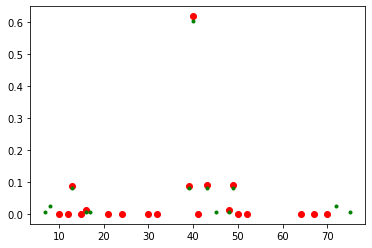

In [344]:
b = []
a = []
for i in range(basis.Ns):
    if (np.abs(psi_var[i])**2>=1e-4):
        b.append(np.abs(psi_var[i])**2)
        a.append(i)
y = []
x = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])**2>=1e-3:
        y.append(np.abs(eigenvectors[:,0][i])**2) 
        x.append(i)
n = []
m = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,1][i])**2>=1e-3:
        n.append(np.abs(eigenvectors[:,1][i])**2) 
        m.append(i)
     


        

plt.plot(a,b, "o",color = "r")
plt.plot(x,y, ".",color = "g")
#plt.plot(m,n, "o",color = "b")


In [345]:
string = ""
for i in range(basis.Ns):
    if np.abs(psi_var[i])**2>=1e-5:
        string+=str(psi_var[i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)

(-0.007861109134822858-0.00018692289118143595j)|2 2 1 2>
(-0.003289015314491963-0.00480920929553839j)|2 2 1 1>
(0.0032767062159061145-0.0009752362708689816j)|2 2 0 2>
(-0.007861109134822257-0.00018692289118133214j)|2 1 2 2>
(-0.013995153137754913-0.006446315110290416j)|2 1 2 1>
(0.009935943477619245+0.022897913327235443j)|2 1 1 2>
(0.24444980410660797-0.16332610698769215j)|2 1 1 1>
(-0.0003025609140163914-0.004517852665739003j)|2 1 1 0>
(0.007808284762763718+0.008035278953977178j)|2 1 0 2>
(-0.08680767161406427+0.070958251219741j)|2 1 0 1>
(0.0032767062159056682-0.0009752362708686331j)|2 0 2 2>
(-0.0031772747326094+0.0013726661615340021j)|2 0 2 1>
(0.007808284762761847+0.008035278953976824j)|2 0 1 2>
(0.0015156010532581532+0.005646667104391101j)|2 0 1 1>
(-0.001590567002229187-0.00490262124490372j)|2 0 1 0>
(-0.002555674781147332+0.013886480262147607j)|2 0 0 2>
(0.0029446805923216755+0.005763301385361861j)|2 0 0 1>
(-0.01399515313775287-0.00644631511028987j)|1 2 1 2>
(-0.00204068935645

In [101]:
#initial state
string_0 = "1111"

#for i in range(L):
#    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string_0)


psi_0[i_0] = 1.

In [103]:
psi = ms_gate_global(2*np.pi)@psi_0
string = ""
for i in range(basis.Ns):
    if np.abs(psi[i])**2>=1e-3:
        string+=str(psi[i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)
a = ms_gate_global(3*np.pi)

(-1.1729987415527113e-15+0.1464466094067268j)|2 2 2 2>
(-0.35355339059327506-4.608540849148181e-15j)|2 1 2 1>
(-0.3535533905932751-4.7056700676433e-15j)|1 2 1 2>
(1.1941022677129676e-14-0.8535533905932727j)|1 1 1 1>



In [242]:
phi = 0
sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
i = 1
j = 2
sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
print(sigma@sigma)

[[0.25+0.j 0.  +0.j 0.  +0.j]
 [0.  +0.j 0.25+0.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.  +0.j]]
